In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from collections import OrderedDict
import math
import argparse
import pickle
import saving_utils
import utils_MNIST
from torchvision.models.feature_extraction import get_graph_node_names,create_feature_extractor
from sklearn import  linear_model
from sklearn.metrics import r2_score

In [2]:
def custom_MSE_Loss(outputs, targets):
    batch_size = len(targets)
    delta = outputs-targets
    delta = delta**2
    loss = torch.sum(delta)/batch_size
    if loss < 1e-8:
        loss=0.
    return loss

In [4]:
teacher_depth=2
teacher_width=2
trainset_size=1000
testset_size=1000
input_dim=2
sample_size=trainset_size+testset_size
with torch.no_grad():
    teacher=utils_MNIST.fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
    inputs=torch.normal(0,1,(sample_size,round(input_dim)))
    outputs=teacher(inputs)
train_set = utils_MNIST.CustomDataSet(inputs[:trainset_size], outputs[:trainset_size], input_dim)
test_set = utils_MNIST.CustomDataSet(inputs[trainset_size:], outputs[trainset_size:], input_dim)

In [264]:
#print(inputs)
#print(outputs)
print(teacher.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.3109,  0.6719],
        [ 0.4807, -0.1572]])), ('linear_body.0.bias', tensor([0.8058, 0.1950])), ('linear_out.weight', tensor([[0.1795, 0.9344]])), ('linear_out.bias', tensor([-0.8400]))])


In [5]:
width=2
depth=2
#criterion=nn.MSELoss()
criterion=nn.MSELoss(reduction='mean')
#criterion=custom_MSE_Loss()
learning_rate=1e-5
weight_decay=0.
epochs=500
batch_size=10
student=utils_MNIST.fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
student.load_state_dict(teacher.state_dict())

optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
#optimizer = optim.Adam(student.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-8)
trainloader=torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=2)
testloader=torch.utils.data.DataLoader(test_set, batch_size=len(test_set),shuffle=False, num_workers=2)

In [266]:
print(type(teacher.state_dict()))
original_dict=teacher.state_dict()
for i in teacher.state_dict().keys():
    tensor=original_dict[i]
    tensor+=torch.normal(0,0.001,tensor.size())
    teacher.state_dict()[i]=tensor
student.load_state_dict(teacher.state_dict())
print(student.state_dict())

<class 'collections.OrderedDict'>
OrderedDict([('linear_body.0.weight', tensor([[ 0.3117,  0.6741],
        [ 0.4811, -0.1574]])), ('linear_body.0.bias', tensor([0.8030, 0.1952])), ('linear_out.weight', tensor([[0.1806, 0.9354]])), ('linear_out.bias', tensor([-0.8384]))])


In [267]:
#print(teacher.state_dict())
#print(student.state_dict())

In [268]:
for epoch in range(epochs):
    epoch+=1
    running_loss=0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs=student(inputs)
        #print(outputs)
        loss=criterion(outputs.to(torch.float32), labels.to(torch.float32))
        #loss = custom_MSE_Loss(outputs.to(torch.float32), labels.to(torch.float32))
        #print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        #print(loss.item())
    scheduler.step()
    print(f'Epoch:' , epoch ,np.sqrt(running_loss)/np.sqrt(trainset_size))

Epoch: 1 0.0009080293969958111
Epoch: 2 0.000860012361290883
Epoch: 3 0.0008143032789697961
Epoch: 4 0.0007708547215023077
Epoch: 5 0.000730141352507469
Epoch: 6 0.0006915162642079087
Epoch: 7 0.0006548228096891503
Epoch: 8 0.0006205820879699952
Epoch: 9 0.0005881042578407677
Epoch: 10 0.0005572575531911712
Epoch: 11 0.0005287071640122822
Epoch: 12 0.0005014019610458867
Epoch: 13 0.0004751698800894221
Epoch: 14 0.00045069587039098935
Epoch: 15 0.0004280382338346558
Epoch: 16 0.00040637015222101495
Epoch: 17 0.00038574051226514516
Epoch: 18 0.00036633386712461494
Epoch: 19 0.00034878129365322933
Epoch: 20 0.00033245595506913484
Epoch: 21 0.0003169925071672604
Epoch: 22 0.0003020757772640661
Epoch: 23 0.0002877661037206655
Epoch: 24 0.000274313702159381
Epoch: 25 0.00026217255376982483
Epoch: 26 0.00025112019465795715
Epoch: 27 0.00024060271240025795
Epoch: 28 0.00023057474069761123
Epoch: 29 0.00022093936977229128
Epoch: 30 0.00021178408554068382
Epoch: 31 0.00020308064486905395
Epoch: 

Epoch: 249 9.939457783751409e-05
Epoch: 250 9.939338404985536e-05
Epoch: 251 9.939232626412309e-05
Epoch: 252 9.939119623595144e-05
Epoch: 253 9.939075228513781e-05
Epoch: 254 9.938956427802007e-05
Epoch: 255 9.938760823807085e-05
Epoch: 256 9.938629004038886e-05
Epoch: 257 9.938467410596362e-05
Epoch: 258 9.938436994237859e-05
Epoch: 259 9.938206481060127e-05
Epoch: 260 9.938012521939568e-05
Epoch: 261 9.937832856114729e-05
Epoch: 262 9.937622878122705e-05
Epoch: 263 9.937527379219709e-05
Epoch: 264 9.937357843637662e-05
Epoch: 265 9.937287823094983e-05
Epoch: 266 9.937175637434297e-05
Epoch: 267 9.937175632071535e-05
Epoch: 268 9.937153910181407e-05
Epoch: 269 9.93696689242296e-05
Epoch: 270 9.936527709784075e-05
Epoch: 271 9.936538005164954e-05
Epoch: 272 9.936437466086207e-05
Epoch: 273 9.936437487985778e-05
Epoch: 274 9.936437508097628e-05
Epoch: 275 9.936437485751128e-05
Epoch: 276 9.936437511673069e-05
Epoch: 277 9.936412305682496e-05
Epoch: 278 9.936257310541336e-05
Epoch: 279 

Epoch: 498 9.935801003066036e-05
Epoch: 499 9.935801001278202e-05
Epoch: 500 9.935801018262631e-05


In [269]:
print(teacher.state_dict())
print(student.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.3117,  0.6741],
        [ 0.4811, -0.1574]])), ('linear_body.0.bias', tensor([0.8030, 0.1952])), ('linear_out.weight', tensor([[0.1806, 0.9354]])), ('linear_out.bias', tensor([-0.8384]))])
OrderedDict([('linear_body.0.weight', tensor([[ 0.3117,  0.6741],
        [ 0.4805, -0.1573]])), ('linear_body.0.bias', tensor([0.8029, 0.1946])), ('linear_out.weight', tensor([[0.1794, 0.9350]])), ('linear_out.bias', tensor([-0.8394]))])


In [246]:
with torch.no_grad():
    for i,data in enumerate(trainloader,0):
        if i==0:
            inputs, labels = data
            outputs=student(inputs)
            print(labels)
            print(outputs)

tensor([[-0.9566],
        [-0.9566],
        [-0.9566],
        [-0.6560],
        [-0.6910],
        [-0.8291],
        [-1.6807],
        [-0.7271],
        [-0.9566],
        [-0.9566]])
tensor([[-0.9568],
        [-0.9568],
        [-0.9568],
        [-0.6565],
        [-0.6910],
        [-0.8294],
        [-1.6807],
        [-0.7277],
        [-0.9568],
        [-0.9568]])


In [184]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = student(images.float())
nodes,_=get_graph_node_names(student)

In [185]:
features={nodes[-2]:'out'}

In [174]:
feature_extractor=create_feature_extractor(student,return_nodes=features)

In [175]:
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = feature_extractor(images.float())

In [176]:
X=outputs['out']
print(type(X))

<class 'torch.Tensor'>


In [177]:
print(X[0])

tensor([0.5486, 0.0000, 0.0000, 0.8364, 1.2676, 0.5704, 1.0783, 0.0000, 0.0000,
        0.0000, 1.6774, 0.1708, 0.0000, 0.0000, 0.6846, 0.4367, 0.9493, 0.0000,
        0.4251, 0.0000, 0.0000, 0.0000, 0.0000, 0.1024, 1.7553, 0.3958, 0.0000,
        1.2868, 0.4578, 0.6191, 0.0000, 0.7900, 1.0082, 0.1959, 1.0773, 0.0000,
        0.9049, 0.4653, 0.5695, 0.5181, 0.0000, 0.0000, 0.0000, 0.6170, 0.0000,
        0.0000, 0.9349, 0.5410, 0.5559, 0.0000, 0.0000, 0.5168, 0.2604, 0.6161,
        0.0000, 0.0000, 1.4084, 0.7717, 0.1281, 0.0000, 0.0000, 0.0000, 0.7205,
        0.0000])


In [178]:
X_check=X.numpy()
count=0
for j in range(len(X_check)):
    for i in range(len(X_check[0])):
        if X_check[j][i]==0:
            count+=1
print(count/len(X_check))

30.136


In [179]:
### fit on full layer from chunks

# chunk sizes
#css = [1, 2, 4, 8, 16, 32, 64, 100]
css=[1,2,4,8,12,16,24,32,64]

# number of repetitions
nreps = 5

# initialised matrices of residuals and covariances
rsqs = np.zeros((len(css), nreps))
diag_covs = np.zeros((len(css), width, nreps))
covs = np.zeros((len(css), width, width, nreps))

for i, cs in enumerate(css):
    print(cs)

    for r in range(nreps):
    
        indices = np.random.choice(np.arange(width), (cs), replace = False)
        Xc = X[:, indices]
        
        lm = linear_model.LinearRegression()
        lm = linear_model.Ridge(1e-8)
        
        lm.fit(Xc, X)
        X_pred = lm.predict(Xc)
        
        res = (X - X_pred)
        cov = np.cov(res.T)
        diag_covs[i, :, r] = np.diag(cov)
        
        rsqs[i, r]= r2_score(X, X_pred, multioutput = 'variance_weighted')
        covs[i,:, :, r] = cov

1
2
4
8
12
16
24
32


In [180]:
def hm_diagonal(corr):
    nondiag_entries = corr[np.tril_indices_from(corr, k = -1)]
    return np.mean(abs(nondiag_entries))

In [15]:
# compute regolarised correlation of residuals
reg = 1e-10
corrs = covs/(np.sqrt((diag_covs[:, :, None, :]*diag_covs[:, None, :, :]))+reg)

mean_non_diag_abs_corr = np.zeros((corrs.shape[0], corrs.shape[3]))

for i in range(corrs.shape[0]):
    for j in range(corrs.shape[3]):
        mean_non_diag_abs_corr[i, j] = hm_diagonal(corrs[i, :, :, j])

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

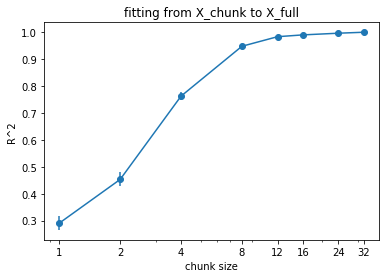

In [16]:
# plot R^2 value
plt.figure()
plt.errorbar(css, rsqs.mean(axis = 1)
             , rsqs.std(axis = 1)/np.sqrt(50), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('R^2')
plt.title('fitting from X_chunk to X_full')

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

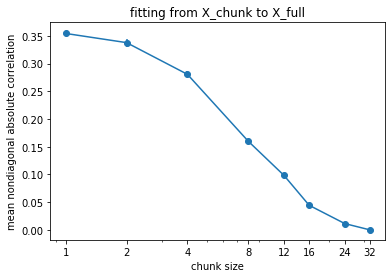

In [17]:
# plot mean nondiagonal absolute correlation
plt.figure()
plt.errorbar(css, mean_non_diag_abs_corr.mean(axis = 1)
             , mean_non_diag_abs_corr.std(axis = 1)/np.sqrt(25), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('mean nondiagonal absolute correlation')
plt.title('fitting from X_chunk to X_full')

# Online learning

Initialize teacher:

In [6]:
teacher_depth=2
teacher_width=2
batch_size=1
input_dim=2
teacher=utils_MNIST.fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                            dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)


Initialize student:

In [9]:
width=8
depth=2
#criterion=nn.MSELoss()
criterion=nn.MSELoss(reduction='mean')
#criterion=custom_MSE_Loss()
learning_rate=1e-4
weight_decay=0.
epochs=100
student=utils_MNIST.fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.0, weight_decay=weight_decay)
#optimizer = optim.Adam(student.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-8)



In [11]:
epochs=100000
for epoch in range(epochs):
    epoch+=1
    #if epoch==round(epochs/2):
        #optimizer = optim.SGD(student.parameters(), lr=learning_rate/10,momentum=0.0, weight_decay=weight_decay)
    running_loss=0
    with torch.no_grad():
        inputs=torch.normal(0,1,(batch_size,round(input_dim)))
        outputs=teacher(inputs)
    batch_set = utils_MNIST.CustomDataSet(inputs, outputs, input_dim)
    batchloader=torch.utils.data.DataLoader(batch_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=2)
    for i, data in enumerate(batchloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs=student(inputs)
        #print(outputs)
        loss=criterion(outputs.to(torch.float32), labels.to(torch.float32))
        #loss = custom_MSE_Loss(outputs.to(torch.float32), labels.to(torch.float32))
        #print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        #print(loss.item())
    #scheduler.step()
    print(f'Epoch:' , epoch ,np.sqrt(running_loss)/np.sqrt(batch_size))

Epoch: 1 0.5292771395561798
Epoch: 2 0.1052936628301462
Epoch: 3 0.047774403508510865
Epoch: 4 0.16369645405305175
Epoch: 5 0.4247927609227361
Epoch: 6 0.3345158681313141
Epoch: 7 0.24297009433975458
Epoch: 8 0.3021710476740942
Epoch: 9 0.29568147416265056
Epoch: 10 0.15922105286816773
Epoch: 11 0.09209090684295329
Epoch: 12 0.39829509658658874
Epoch: 13 0.2868722338532703
Epoch: 14 0.09142517867905355
Epoch: 15 0.11199118351960329
Epoch: 16 0.18237067735554888
Epoch: 17 0.17156278907251238
Epoch: 18 1.3186705271561843
Epoch: 19 0.21198442934487827
Epoch: 20 0.25198537043556224
Epoch: 21 0.2922942981252585
Epoch: 22 0.13581400967736265
Epoch: 23 0.11758258896651676
Epoch: 24 0.05061972126990367
Epoch: 25 0.6101893827500544
Epoch: 26 0.12330204376149599
Epoch: 27 0.28219395749464943
Epoch: 28 0.3125298009014377
Epoch: 29 0.25920155597524386
Epoch: 30 0.5627843614880185
Epoch: 31 0.18403273714228718
Epoch: 32 0.32984423956751124
Epoch: 33 0.2914145634669556
Epoch: 34 0.18380970124517135


Epoch: 272 0.4121736232339153
Epoch: 273 0.018277824090526838
Epoch: 274 0.9729649923168402
Epoch: 275 0.25384771699399106
Epoch: 276 0.23821842428478127
Epoch: 277 0.08460390500785005
Epoch: 278 0.5537443066857569
Epoch: 279 0.5189134466676717
Epoch: 280 0.2841542943771595
Epoch: 281 0.07746836564636905
Epoch: 282 0.26742425378693724
Epoch: 283 0.38729536052020996
Epoch: 284 0.0078068972498551185
Epoch: 285 0.7835518305662854
Epoch: 286 0.29156303125641764
Epoch: 287 0.25184553643736274
Epoch: 288 0.09502378024944504
Epoch: 289 0.014091104441197278
Epoch: 290 0.1731531023807556
Epoch: 291 0.1904224198739631
Epoch: 292 0.6847927586456156
Epoch: 293 0.22477655408725286
Epoch: 294 1.5930838595226806
Epoch: 295 0.13499473363926925
Epoch: 296 0.09996244090277549
Epoch: 297 0.495070400698485
Epoch: 298 0.26087275461328197
Epoch: 299 0.2828167614694799
Epoch: 300 0.3140513299502384
Epoch: 301 0.6768869824462823
Epoch: 302 0.25741430801129356
Epoch: 303 0.04249262772765342
Epoch: 304 0.307043

Epoch: 540 0.10849642835096787
Epoch: 541 0.14999610379245173
Epoch: 542 0.386714781153186
Epoch: 543 0.07266396204719289
Epoch: 544 0.3191667160892365
Epoch: 545 0.20858001806657592
Epoch: 546 0.06327021143439841
Epoch: 547 0.6197239146880852
Epoch: 548 0.05261901095812472
Epoch: 549 0.21625183945353083
Epoch: 550 0.19096372987668642
Epoch: 551 0.045691222797001704
Epoch: 552 0.24998094068831833
Epoch: 553 0.0366873142430251
Epoch: 554 0.08550703545012975
Epoch: 555 0.06509745285066497
Epoch: 556 0.5245335050414528
Epoch: 557 0.9362816841662035
Epoch: 558 0.3517025456705719
Epoch: 559 0.12059807851288266
Epoch: 560 0.07210290476824442
Epoch: 561 0.4496610702902095
Epoch: 562 0.23624696204840956
Epoch: 563 0.15569486947383976
Epoch: 564 0.0740527222160602
Epoch: 565 0.14626666739236724
Epoch: 566 0.008178830145920793
Epoch: 567 0.02544593861074285
Epoch: 568 0.868830387595158
Epoch: 569 0.19918330195084383
Epoch: 570 0.6308865615136043
Epoch: 571 0.07888185931447142
Epoch: 572 0.782670

Epoch: 808 0.1936623867429765
Epoch: 809 0.23767218371466484
Epoch: 810 0.03387361817427216
Epoch: 811 0.022937356896515992
Epoch: 812 0.014831602818560623
Epoch: 813 0.3209510462909824
Epoch: 814 1.0639259642893455
Epoch: 815 0.43302894440922424
Epoch: 816 0.7822945668809739
Epoch: 817 0.05720317325170608
Epoch: 818 0.20466905394276544
Epoch: 819 0.22206613072037
Epoch: 820 0.2928757074748867
Epoch: 821 0.18870824696244126
Epoch: 822 0.033813447298113
Epoch: 823 0.02292454184157028
Epoch: 824 0.17677539400789957
Epoch: 825 0.3891998615375402
Epoch: 826 0.021654486453734446
Epoch: 827 0.27017178649089024
Epoch: 828 0.11095530004482004
Epoch: 829 0.06001457485299677
Epoch: 830 0.0836595307655533
Epoch: 831 0.09774041363778373
Epoch: 832 0.31455856829967205
Epoch: 833 0.01769149336169092
Epoch: 834 0.19424889882154847
Epoch: 835 0.6693217088730348
Epoch: 836 0.2696098130210694
Epoch: 837 0.244375451641202
Epoch: 838 0.2681622776713921
Epoch: 839 0.033719957734527246
Epoch: 840 0.14071215

Epoch: 1074 0.28033215376253867
Epoch: 1075 0.16260671733547555
Epoch: 1076 0.5541251380915075
Epoch: 1077 0.010655105029792507
Epoch: 1078 0.07559067036106427
Epoch: 1079 0.26587024755046057
Epoch: 1080 0.016944587254898863
Epoch: 1081 0.05570143357005472
Epoch: 1082 0.011867195181266528
Epoch: 1083 0.5280325453149106
Epoch: 1084 0.06522306869658812
Epoch: 1085 0.14335626396108947
Epoch: 1086 0.10169029448701594
Epoch: 1087 0.2887822932395919
Epoch: 1088 0.18531045407585894
Epoch: 1089 0.07363320876705484
Epoch: 1090 0.09498096989148999
Epoch: 1091 0.17388005498932957
Epoch: 1092 0.3522554350339586
Epoch: 1093 0.14881169686547316
Epoch: 1094 0.15545904713932604
Epoch: 1095 0.23023530484190713
Epoch: 1096 0.09703159346803822
Epoch: 1097 0.4501590176265211
Epoch: 1098 0.3420777284141336
Epoch: 1099 0.5218782401983671
Epoch: 1100 0.3177712279221256
Epoch: 1101 0.37759530506478384
Epoch: 1102 0.31537490699727383
Epoch: 1103 0.37246024857343824
Epoch: 1104 0.06510001367992375
Epoch: 1105 0

Epoch: 1333 0.1821496966975187
Epoch: 1334 0.4297035907853667
Epoch: 1335 0.124001369615603
Epoch: 1336 0.09284669092194828
Epoch: 1337 0.1739875994170693
Epoch: 1338 0.04055839808032093
Epoch: 1339 0.15889808693833113
Epoch: 1340 0.2731708316190654
Epoch: 1341 0.3388310723751576
Epoch: 1342 0.0952796031118952
Epoch: 1343 0.12868720285854707
Epoch: 1344 0.1795923665353336
Epoch: 1345 0.5716525233950175
Epoch: 1346 0.2128562462022385
Epoch: 1347 0.08586588498185269
Epoch: 1348 0.2493981403355871
Epoch: 1349 0.09916398102448844
Epoch: 1350 0.0300403531972896
Epoch: 1351 0.28957674318586074
Epoch: 1352 0.0861518095004671
Epoch: 1353 0.11434389604734824
Epoch: 1354 0.38726719584866937
Epoch: 1355 0.36498192615047603
Epoch: 1356 0.26092821264585414
Epoch: 1357 0.15177112948044696
Epoch: 1358 0.12482267706797447
Epoch: 1359 0.28791523418033355
Epoch: 1360 0.5321186201193883
Epoch: 1361 0.374135132687765
Epoch: 1362 0.2663815607169667
Epoch: 1363 0.2618709520195533
Epoch: 1364 0.1649032236898

Epoch: 1592 0.4394456142207551
Epoch: 1593 0.2324766206779398
Epoch: 1594 0.22328161790842826
Epoch: 1595 0.3541241250948024
Epoch: 1596 0.01557826992930496
Epoch: 1597 0.2481354908082646
Epoch: 1598 0.04110485260072168
Epoch: 1599 0.5900872845660416
Epoch: 1600 0.14066102970352864
Epoch: 1601 0.17360638287516472
Epoch: 1602 0.19391113126022472
Epoch: 1603 0.24851115022748163
Epoch: 1604 0.36088817721820593
Epoch: 1605 0.13106411958229502
Epoch: 1606 0.19137497081918325
Epoch: 1607 0.3767819386495166
Epoch: 1608 0.05659300142113827
Epoch: 1609 0.37668447853624765
Epoch: 1610 0.14155360758138066
Epoch: 1611 0.17563338418374339
Epoch: 1612 0.15896191942182886
Epoch: 1613 0.36223566677993774
Epoch: 1614 0.16297945098087394
Epoch: 1615 0.18560551168591205
Epoch: 1616 0.5583208124218179
Epoch: 1617 0.1380091465794564
Epoch: 1618 1.3962293698828157
Epoch: 1619 0.6781849311679419
Epoch: 1620 0.09305065798335932
Epoch: 1621 0.36355562001132613
Epoch: 1622 0.012262523404759149
Epoch: 1623 0.275

Epoch: 1851 0.273662215946374
Epoch: 1852 0.10205616092647628
Epoch: 1853 0.2894968429683181
Epoch: 1854 0.015026509922464305
Epoch: 1855 0.2148602912777323
Epoch: 1856 0.8450182813438766
Epoch: 1857 0.2798953679763187
Epoch: 1858 0.3043031958730296
Epoch: 1859 0.2313054462925099
Epoch: 1860 0.04969006794165701
Epoch: 1861 0.2418016159011906
Epoch: 1862 0.11905030829544114
Epoch: 1863 0.30750740150910133
Epoch: 1864 0.11406816736277034
Epoch: 1865 0.26252979609002053
Epoch: 1866 0.37495575087471494
Epoch: 1867 0.1090185026516476
Epoch: 1868 0.5594353637944326
Epoch: 1869 0.29717108116563357
Epoch: 1870 0.19179935376028096
Epoch: 1871 0.132068273894703
Epoch: 1872 0.6333541906419191
Epoch: 1873 0.010364502635431294
Epoch: 1874 0.2515094902625566
Epoch: 1875 0.6297063772623437
Epoch: 1876 0.15564816919077815
Epoch: 1877 0.1476902788803214
Epoch: 1878 0.03118896484375
Epoch: 1879 0.09060019305675192
Epoch: 1880 0.1712190780862783
Epoch: 1881 0.11778322040041243
Epoch: 1882 0.1385816629895

Epoch: 2110 0.6140860361340097
Epoch: 2111 0.1582072104409252
Epoch: 2112 0.2612086777199269
Epoch: 2113 0.03536027740312289
Epoch: 2114 0.12920547925755843
Epoch: 2115 0.10684779396030125
Epoch: 2116 0.1760474150234535
Epoch: 2117 0.0294342041015625
Epoch: 2118 0.00034108757842519284
Epoch: 2119 0.16615903494493522
Epoch: 2120 0.09162884917865047
Epoch: 2121 0.07114246397199092
Epoch: 2122 0.044458269771032496
Epoch: 2123 0.19481205723026543
Epoch: 2124 0.8872126409576884
Epoch: 2125 0.1809176752696951
Epoch: 2126 0.20786391461165324
Epoch: 2127 0.40707927208237604
Epoch: 2128 0.2744804383501179
Epoch: 2129 0.01572716271489921
Epoch: 2130 0.15190759604343634
Epoch: 2131 0.12913399864546085
Epoch: 2132 0.19360733509505293
Epoch: 2133 0.0845865903522471
Epoch: 2134 0.3856689383578072
Epoch: 2135 0.4464644707142048
Epoch: 2136 0.13490356766192627
Epoch: 2137 0.7227731146268211
Epoch: 2138 0.30684316227187713
Epoch: 2139 0.02898406982421875
Epoch: 2140 0.2844116732247212
Epoch: 2141 0.027

Epoch: 2368 0.062230527623362855
Epoch: 2369 0.5399430312023388
Epoch: 2370 0.5505846633165656
Epoch: 2371 0.06927833044501833
Epoch: 2372 0.05355933207510126
Epoch: 2373 0.23319942976230013
Epoch: 2374 0.31263574989594356
Epoch: 2375 0.2400741430461946
Epoch: 2376 0.06676060084819362
Epoch: 2377 0.36267923905967947
Epoch: 2378 0.16204692602887838
Epoch: 2379 0.04910442143298157
Epoch: 2380 0.14121538316157733
Epoch: 2381 0.19738682715437947
Epoch: 2382 0.3185813457624251
Epoch: 2383 0.2361156359563099
Epoch: 2384 0.13346837585502172
Epoch: 2385 0.1935431637687254
Epoch: 2386 0.33997297570524754
Epoch: 2387 0.09528800892026557
Epoch: 2388 0.5029413610788721
Epoch: 2389 0.1605480043227672
Epoch: 2390 0.019357860093395414
Epoch: 2391 0.20275336895059298
Epoch: 2392 0.23766969152456624
Epoch: 2393 0.29608982808276074
Epoch: 2394 0.16620372326230293
Epoch: 2395 0.27516445043714177
Epoch: 2396 0.23373222425006684
Epoch: 2397 0.16437229358236363
Epoch: 2398 0.24435120465510715
Epoch: 2399 0.

Epoch: 2627 0.08092564341330866
Epoch: 2628 0.1480377612164715
Epoch: 2629 0.2651703112486838
Epoch: 2630 0.16183918531889338
Epoch: 2631 0.2106964270234701
Epoch: 2632 0.1424129587606037
Epoch: 2633 0.29067212512329477
Epoch: 2634 0.21000098800142933
Epoch: 2635 0.16454505910460965
Epoch: 2636 0.18869634276142658
Epoch: 2637 0.24632900588739803
Epoch: 2638 0.1617978964275572
Epoch: 2639 0.14368128870688449
Epoch: 2640 0.13733123099477518
Epoch: 2641 0.03407698938300109
Epoch: 2642 0.27446227820965524
Epoch: 2643 0.044441253924052175
Epoch: 2644 0.16216309358274536
Epoch: 2645 0.19724463360585287
Epoch: 2646 0.18061729031908902
Epoch: 2647 0.07883828996934968
Epoch: 2648 0.7442358561777754
Epoch: 2649 0.08079847666326415
Epoch: 2650 0.0481319726422729
Epoch: 2651 0.12132182868861521
Epoch: 2652 0.2820563941800172
Epoch: 2653 0.004794061124273665
Epoch: 2654 0.29047059859353974
Epoch: 2655 0.16028207395389776
Epoch: 2656 0.912718053134855
Epoch: 2657 0.27839231396306385
Epoch: 2658 0.27

Epoch: 2886 0.2278420146483125
Epoch: 2887 0.07392162213033299
Epoch: 2888 0.23596063525726127
Epoch: 2889 0.24869698462719383
Epoch: 2890 0.4739075326068952
Epoch: 2891 0.18183170030944784
Epoch: 2892 0.24556903303412142
Epoch: 2893 0.15673667098789823
Epoch: 2894 0.20034478352919308
Epoch: 2895 0.23066273300472526
Epoch: 2896 0.2870150171007963
Epoch: 2897 0.15033602652358533
Epoch: 2898 0.07155147032820618
Epoch: 2899 0.26080238704605563
Epoch: 2900 0.11292788458262126
Epoch: 2901 0.06831733909797587
Epoch: 2902 0.2916234472587443
Epoch: 2903 0.17619100073550054
Epoch: 2904 0.20511556011216187
Epoch: 2905 0.021728188131843296
Epoch: 2906 0.23210763926131492
Epoch: 2907 0.22041654970482052
Epoch: 2908 0.45467812636633476
Epoch: 2909 0.05963444774928896
Epoch: 2910 0.05956545403476358
Epoch: 2911 0.09189850173301953
Epoch: 2912 0.15553441697587422
Epoch: 2913 0.2898201035675868
Epoch: 2914 0.16420215384903716
Epoch: 2915 0.09093394912426768
Epoch: 2916 0.23343931023790773
Epoch: 2917 

Epoch: 3144 0.3034903408992738
Epoch: 3145 0.02620279759223537
Epoch: 3146 0.3368152971213493
Epoch: 3147 0.5294976223251948
Epoch: 3148 0.07274794714159859
Epoch: 3149 0.27414399565404435
Epoch: 3150 0.024477780164181454
Epoch: 3151 0.36628555554906606
Epoch: 3152 0.3039208082619975
Epoch: 3153 0.28920190903296045
Epoch: 3154 0.1786653533499255
Epoch: 3155 0.2565061678591008
Epoch: 3156 0.24452337398581245
Epoch: 3157 0.1983257268016668
Epoch: 3158 0.5228787186773317
Epoch: 3159 0.22905101982846043
Epoch: 3160 0.22119855553397255
Epoch: 3161 0.09266701165402783
Epoch: 3162 0.11493325087039756
Epoch: 3163 0.8914025910926769
Epoch: 3164 0.0365047896815596
Epoch: 3165 0.17396929719680237
Epoch: 3166 0.28612339928672137
Epoch: 3167 0.10915659487954041
Epoch: 3168 0.3731278735997458
Epoch: 3169 0.18710452334299876
Epoch: 3170 0.15530833565906815
Epoch: 3171 0.03230404930453018
Epoch: 3172 0.04185116313847394
Epoch: 3173 0.034993052849520874
Epoch: 3174 0.3331734589298136
Epoch: 3175 0.1487

Epoch: 3403 0.2526410197218874
Epoch: 3404 0.07729583855360718
Epoch: 3405 0.4824421681448714
Epoch: 3406 0.2779427761874954
Epoch: 3407 0.272355431805708
Epoch: 3408 0.10369312614757711
Epoch: 3409 0.17328065748259608
Epoch: 3410 0.21605328892027728
Epoch: 3411 0.3120970154225992
Epoch: 3412 0.23899130477909356
Epoch: 3413 0.04186659984439578
Epoch: 3414 0.0174553994409252
Epoch: 3415 0.5019142640504055
Epoch: 3416 0.22711026632779022
Epoch: 3417 0.20164136822167059
Epoch: 3418 0.7101893837965978
Epoch: 3419 0.10191659455610039
Epoch: 3420 0.15419825891216551
Epoch: 3421 0.23838952215514295
Epoch: 3422 0.06832218180149904
Epoch: 3423 0.04231983402610926
Epoch: 3424 0.21013833469479012
Epoch: 3425 0.15998676683046445
Epoch: 3426 0.2282905121894948
Epoch: 3427 0.24675801106708092
Epoch: 3428 0.09962606290264613
Epoch: 3429 0.10258710280800853
Epoch: 3430 0.14585548825798803
Epoch: 3431 0.21380787728125905
Epoch: 3432 0.20211951191669877
Epoch: 3433 0.5156431772900538
Epoch: 3434 0.05831

Epoch: 3662 0.21834367241809602
Epoch: 3663 0.042497098616392434
Epoch: 3664 0.41211205070313983
Epoch: 3665 0.17233165850723223
Epoch: 3666 0.14878127169073083
Epoch: 3667 0.4860417238925726
Epoch: 3668 0.18936205179182963
Epoch: 3669 0.1343301565174857
Epoch: 3670 0.18041905466162944
Epoch: 3671 0.06687411811282788
Epoch: 3672 0.4253440151828956
Epoch: 3673 0.1936672341551266
Epoch: 3674 0.24159980039331735
Epoch: 3675 0.12696773004885037
Epoch: 3676 0.09564766444627847
Epoch: 3677 0.12402209709224106
Epoch: 3678 0.17872792564486223
Epoch: 3679 0.21086910693171418
Epoch: 3680 0.5652588634023822
Epoch: 3681 0.32385482816034544
Epoch: 3682 0.254324949270596
Epoch: 3683 0.2803246321758503
Epoch: 3684 0.20065907052372814
Epoch: 3685 0.17601984573498367
Epoch: 3686 0.004771530630810323
Epoch: 3687 0.41850677515058116
Epoch: 3688 0.1353514763527688
Epoch: 3689 0.011552572444722495
Epoch: 3690 0.2370276776989464
Epoch: 3691 0.511341917173974
Epoch: 3692 0.08496955027717232
Epoch: 3693 0.440

Epoch: 3921 0.12485396900176737
Epoch: 3922 0.39794875068871055
Epoch: 3923 0.2565385961141795
Epoch: 3924 0.03415715632998703
Epoch: 3925 0.18251801924387934
Epoch: 3926 0.1067380292632958
Epoch: 3927 0.24449199568629265
Epoch: 3928 0.19635847392193811
Epoch: 3929 0.2127154005388555
Epoch: 3930 0.019812911842285796
Epoch: 3931 0.32081735182050575
Epoch: 3932 0.1425821813241518
Epoch: 3933 0.19705515671854795
Epoch: 3934 0.17381468195850489
Epoch: 3935 0.08609333593386653
Epoch: 3936 0.04639855033162598
Epoch: 3937 0.20602014441916167
Epoch: 3938 0.14362093635949078
Epoch: 3939 0.33810127175043136
Epoch: 3940 0.13098463070596597
Epoch: 3941 0.22978214856930154
Epoch: 3942 0.05366244945123323
Epoch: 3943 0.45619291052880795
Epoch: 3944 0.2507851460709774
Epoch: 3945 0.25346428479144134
Epoch: 3946 0.16773822956782214
Epoch: 3947 0.4023156758115356
Epoch: 3948 0.20634090739315222
Epoch: 3949 0.4683212703828993
Epoch: 3950 0.25229385166077806
Epoch: 3951 0.017303914193856792
Epoch: 3952 0

Epoch: 4180 0.12191730828625921
Epoch: 4181 0.0998748859024709
Epoch: 4182 0.2605994044343565
Epoch: 4183 0.12620848369662896
Epoch: 4184 0.14072021598738485
Epoch: 4185 0.40196298896690297
Epoch: 4186 0.338870342580745
Epoch: 4187 0.06748625513819756
Epoch: 4188 0.278267530823853
Epoch: 4189 0.16149529808170815
Epoch: 4190 0.17649430185831025
Epoch: 4191 0.25182926475047807
Epoch: 4192 0.15480416839997715
Epoch: 4193 0.11115151752412188
Epoch: 4194 0.22369222393201196
Epoch: 4195 0.48081534375443524
Epoch: 4196 0.15767214997361811
Epoch: 4197 0.2644867350239258
Epoch: 4198 0.21632990506074568
Epoch: 4199 0.29685401842360487
Epoch: 4200 0.11568464387220294
Epoch: 4201 1.0601472611070828
Epoch: 4202 0.08414536670422182
Epoch: 4203 0.06959396692159973
Epoch: 4204 0.17843002378832165
Epoch: 4205 0.29812436977455814
Epoch: 4206 0.07821984494380584
Epoch: 4207 0.2014533915664778
Epoch: 4208 0.09283718629340774
Epoch: 4209 0.30046632306511867
Epoch: 4210 0.3204129340723711
Epoch: 4211 0.9298

Epoch: 4439 0.06632056739129928
Epoch: 4440 0.24719819238688145
Epoch: 4441 0.14166763342733188
Epoch: 4442 0.22257112247676236
Epoch: 4443 0.01911114141931496
Epoch: 4444 0.06780180378686927
Epoch: 4445 0.5826135321312873
Epoch: 4446 0.2759233422065643
Epoch: 4447 0.1580936323781131
Epoch: 4448 0.2677969072937174
Epoch: 4449 0.40286337990592364
Epoch: 4450 0.07023891930205206
Epoch: 4451 0.1746881778666356
Epoch: 4452 0.19075602421678298
Epoch: 4453 0.16171671525163492
Epoch: 4454 0.2178256481175679
Epoch: 4455 0.16970512114231473
Epoch: 4456 0.0011099576886057943
Epoch: 4457 0.10228049966389474
Epoch: 4458 0.01877486726935619
Epoch: 4459 0.2809583555846017
Epoch: 4460 0.548957239351383
Epoch: 4461 0.28881726301022226
Epoch: 4462 0.05075794382065139
Epoch: 4463 0.2872026901669347
Epoch: 4464 0.22176865124349376
Epoch: 4465 0.07055926400557767
Epoch: 4466 0.21010837257732218
Epoch: 4467 0.18036821215382273
Epoch: 4468 0.16037337193179302
Epoch: 4469 0.006287038312418835
Epoch: 4470 0.1

Epoch: 4697 0.26425012829668293
Epoch: 4698 0.1031665223509781
Epoch: 4699 0.049105704003161145
Epoch: 4700 0.39705068799641274
Epoch: 4701 0.328761221926223
Epoch: 4702 0.07363092890589207
Epoch: 4703 0.5407325747852901
Epoch: 4704 0.2586988759789454
Epoch: 4705 0.02980679269451526
Epoch: 4706 0.12865028109821844
Epoch: 4707 0.186889469039502
Epoch: 4708 0.45402091345848117
Epoch: 4709 0.025995597596381297
Epoch: 4710 0.5375558003581468
Epoch: 4711 0.1373843815062874
Epoch: 4712 0.07543793463799044
Epoch: 4713 0.029105246193933038
Epoch: 4714 0.1817859867869719
Epoch: 4715 0.17123264331813967
Epoch: 4716 0.253925953614049
Epoch: 4717 0.37759867916285317
Epoch: 4718 0.23266959412775912
Epoch: 4719 0.19345527736710288
Epoch: 4720 0.20838141581870642
Epoch: 4721 0.1982909457374042
Epoch: 4722 0.004846602713392846
Epoch: 4723 0.4804083933563152
Epoch: 4724 0.2551856598545972
Epoch: 4725 0.22675836252545029
Epoch: 4726 0.1322254572474211
Epoch: 4727 0.29049867119870953
Epoch: 4728 0.233459

Epoch: 4956 0.050445406637182215
Epoch: 4957 0.36762333428745814
Epoch: 4958 0.15856517759865837
Epoch: 4959 0.08300665125315086
Epoch: 4960 0.16552015868490186
Epoch: 4961 0.9182400566287637
Epoch: 4962 0.18240200971962284
Epoch: 4963 0.017299950291125576
Epoch: 4964 0.10946130753290499
Epoch: 4965 0.12239289195672536
Epoch: 4966 0.09006708830211906
Epoch: 4967 0.1058100150693055
Epoch: 4968 0.8151648542503228
Epoch: 4969 0.06973113010309341
Epoch: 4970 0.051058813036398934
Epoch: 4971 0.05104827823847011
Epoch: 4972 0.14337411539657935
Epoch: 4973 0.14451107322485796
Epoch: 4974 0.05100011884188129
Epoch: 4975 0.21933953850389598
Epoch: 4976 0.04582345448084981
Epoch: 4977 0.15572164731600133
Epoch: 4978 1.4345345801051064
Epoch: 4979 0.09786751782658532
Epoch: 4980 0.007862866089077025
Epoch: 4981 0.2630330293805273
Epoch: 4982 0.5907101615180922
Epoch: 4983 0.030181944551013327
Epoch: 4984 0.13226864059309248
Epoch: 4985 0.22735120525130825
Epoch: 4986 0.24153014926262267
Epoch: 49

Epoch: 5214 0.15409111838490863
Epoch: 5215 0.0038226842712961217
Epoch: 5216 0.015497892980827054
Epoch: 5217 0.04298672110626515
Epoch: 5218 0.15493825206481737
Epoch: 5219 0.30246802888144425
Epoch: 5220 0.27488976783512553
Epoch: 5221 0.26311660508561674
Epoch: 5222 0.14405545326052965
Epoch: 5223 0.1807785908364163
Epoch: 5224 0.3283942344181478
Epoch: 5225 0.37567437648745566
Epoch: 5226 0.09387901488809629
Epoch: 5227 0.26403144055600175
Epoch: 5228 0.15585142201375196
Epoch: 5229 0.006122946803022011
Epoch: 5230 0.13536493447265446
Epoch: 5231 0.26851775869143857
Epoch: 5232 0.052451492028758796
Epoch: 5233 0.031777978792861435
Epoch: 5234 0.69172686885518
Epoch: 5235 0.10403850588814698
Epoch: 5236 0.2453968382992742
Epoch: 5237 0.13478670784610375
Epoch: 5238 0.04774192004346582
Epoch: 5239 0.1609876325448586
Epoch: 5240 0.008893072675243948
Epoch: 5241 0.07013693388011194
Epoch: 5242 0.014245510284870738
Epoch: 5243 0.3210499230056941
Epoch: 5244 0.28427303393499875
Epoch: 5

Epoch: 5472 0.20315289305862202
Epoch: 5473 0.12484836694561614
Epoch: 5474 0.04398828762846402
Epoch: 5475 0.9296194420274309
Epoch: 5476 0.15416260200589288
Epoch: 5477 0.1312934167895209
Epoch: 5478 0.18205014077589485
Epoch: 5479 0.23447303311191764
Epoch: 5480 0.005009531996068203
Epoch: 5481 0.1250442560649292
Epoch: 5482 0.06906950493279944
Epoch: 5483 0.24408844199396137
Epoch: 5484 0.1683662391024501
Epoch: 5485 0.2318897727928544
Epoch: 5486 0.12368765378506831
Epoch: 5487 0.15800645754578593
Epoch: 5488 0.1419968316999095
Epoch: 5489 0.32989322968878765
Epoch: 5490 0.42506831966365516
Epoch: 5491 0.05667769928750386
Epoch: 5492 0.1481569990269093
Epoch: 5493 0.2877489349468151
Epoch: 5494 0.1367203031179222
Epoch: 5495 0.005038499781385156
Epoch: 5496 0.13260683095097886
Epoch: 5497 0.4304063852207905
Epoch: 5498 0.20037947766863026
Epoch: 5499 0.16608321553014924
Epoch: 5500 0.25729191847002525
Epoch: 5501 0.05143904591325422
Epoch: 5502 0.1857324675895851
Epoch: 5503 0.114

Epoch: 5730 0.013801217272227835
Epoch: 5731 0.09043843987048364
Epoch: 5732 0.14544271126465097
Epoch: 5733 0.34371978453574037
Epoch: 5734 0.08568817242522699
Epoch: 5735 0.06776749986148801
Epoch: 5736 0.19387278165784036
Epoch: 5737 0.03784334733309359
Epoch: 5738 0.05890321666524306
Epoch: 5739 0.15014800404345602
Epoch: 5740 0.29263249491805654
Epoch: 5741 0.16143363845820516
Epoch: 5742 0.13675713681422103
Epoch: 5743 0.1892389384524158
Epoch: 5744 0.03391309036306263
Epoch: 5745 0.09352928246730147
Epoch: 5746 0.0537332293460962
Epoch: 5747 0.1353074941964613
Epoch: 5748 0.14427967342831524
Epoch: 5749 0.264495904186785
Epoch: 5750 0.25519103199189
Epoch: 5751 0.09635329299822785
Epoch: 5752 0.22718271503630444
Epoch: 5753 0.44766271030631033
Epoch: 5754 0.08783915655166122
Epoch: 5755 0.15525722419014207
Epoch: 5756 0.14107017122578386
Epoch: 5757 0.29665199487058175
Epoch: 5758 0.19800871456961977
Epoch: 5759 0.25280922337072004
Epoch: 5760 0.002566069383757616
Epoch: 5761 0.

Epoch: 5988 0.1451490831812985
Epoch: 5989 0.25483625724905973
Epoch: 5990 0.14374080581909102
Epoch: 5991 0.06387683769254135
Epoch: 5992 0.4550205243375684
Epoch: 5993 0.18012219177389255
Epoch: 5994 0.22432574733072705
Epoch: 5995 0.02247768663902445
Epoch: 5996 0.30100303993876176
Epoch: 5997 0.0673451733162175
Epoch: 5998 0.19260528210478053
Epoch: 5999 0.14704587766345398
Epoch: 6000 0.024945020337265082
Epoch: 6001 0.40730705654925664
Epoch: 6002 0.2642349588530842
Epoch: 6003 0.17978590882748346
Epoch: 6004 0.9680969744492884
Epoch: 6005 0.033951133126383384
Epoch: 6006 0.2636792641063529
Epoch: 6007 0.09849968509000456
Epoch: 6008 0.24308293686010438
Epoch: 6009 0.1338778709198178
Epoch: 6010 0.21358840225490394
Epoch: 6011 0.3626722132281157
Epoch: 6012 0.3482600444466566
Epoch: 6013 0.1100487563332474
Epoch: 6014 0.15555228380564015
Epoch: 6015 0.3597393676586323
Epoch: 6016 0.23428151332488825
Epoch: 6017 0.6703221762787942
Epoch: 6018 0.21982538332264195
Epoch: 6019 0.3898

Epoch: 6246 0.1902828237105442
Epoch: 6247 0.13028873742663408
Epoch: 6248 0.2557414416431501
Epoch: 6249 0.08243878211495054
Epoch: 6250 0.37565529709052436
Epoch: 6251 0.09463730273871773
Epoch: 6252 0.3394185947462884
Epoch: 6253 0.005845487112601286
Epoch: 6254 0.18009748540972997
Epoch: 6255 0.15054112496156716
Epoch: 6256 0.028130590525622137
Epoch: 6257 0.14576938978525103
Epoch: 6258 0.07136520800066327
Epoch: 6259 0.24876636625009005
Epoch: 6260 0.013488903843310257
Epoch: 6261 0.2537193343936577
Epoch: 6262 0.2524242727342292
Epoch: 6263 0.015726714876507897
Epoch: 6264 0.0023401975601351358
Epoch: 6265 0.22198681834432152
Epoch: 6266 0.0022777318673711084
Epoch: 6267 0.22244131857458047
Epoch: 6268 0.013023793795423885
Epoch: 6269 0.3070235807125876
Epoch: 6270 0.016922652332494244
Epoch: 6271 0.13324828738674027
Epoch: 6272 0.14284342421605312
Epoch: 6273 0.17503613328855766
Epoch: 6274 0.14815985915288424
Epoch: 6275 0.19885942366398546
Epoch: 6276 0.1594253060942719
Epoch

Epoch: 6504 0.14779460495216623
Epoch: 6505 0.10676903887923284
Epoch: 6506 0.12209981561805205
Epoch: 6507 0.005502462464564026
Epoch: 6508 0.2572849395711657
Epoch: 6509 0.12908630367486387
Epoch: 6510 0.21157775949246985
Epoch: 6511 0.07128520197409353
Epoch: 6512 0.06324154187863101
Epoch: 6513 0.7992923199305059
Epoch: 6514 0.44975280528760136
Epoch: 6515 0.08445328562030463
Epoch: 6516 0.15197737360566108
Epoch: 6517 0.236130955312539
Epoch: 6518 0.25336688046743927
Epoch: 6519 0.1158656311468201
Epoch: 6520 0.3216133452274517
Epoch: 6521 0.1353424760044641
Epoch: 6522 0.4370507590474624
Epoch: 6523 0.23689172864336927
Epoch: 6524 0.08101797134051278
Epoch: 6525 0.04900521114340708
Epoch: 6526 0.11678901314190515
Epoch: 6527 0.08824184496181112
Epoch: 6528 0.0844480390455279
Epoch: 6529 0.15830619421522726
Epoch: 6530 0.031869649443854814
Epoch: 6531 0.14005874165654966
Epoch: 6532 0.09229678126185564
Epoch: 6533 0.34123343757637925
Epoch: 6534 0.01722809693634592
Epoch: 6535 0.0

Epoch: 6762 0.1819344164778023
Epoch: 6763 0.0836732390637164
Epoch: 6764 0.11389061619699302
Epoch: 6765 0.015902281048776903
Epoch: 6766 0.2287984467233397
Epoch: 6767 0.25628558179331645
Epoch: 6768 0.2094937560652081
Epoch: 6769 0.2597937030962248
Epoch: 6770 0.20909116815008635
Epoch: 6771 0.2731181323237717
Epoch: 6772 0.18102808183821217
Epoch: 6773 0.3192495760082157
Epoch: 6774 0.028628885925630322
Epoch: 6775 0.3715428696396479
Epoch: 6776 0.13520598681617407
Epoch: 6777 0.26296391988705403
Epoch: 6778 0.22334578472420613
Epoch: 6779 0.435115275345832
Epoch: 6780 0.4767489146863869
Epoch: 6781 0.0017476081848144531
Epoch: 6782 0.18219293690939356
Epoch: 6783 0.08073064651465994
Epoch: 6784 0.13490125493037833
Epoch: 6785 0.10418677483628377
Epoch: 6786 0.02578464132639122
Epoch: 6787 0.12860783802236095
Epoch: 6788 0.09830504429587303
Epoch: 6789 0.055495351554427676
Epoch: 6790 0.20688616869416693
Epoch: 6791 0.20964594433494171
Epoch: 6792 0.1481289291464307
Epoch: 6793 0.0

Epoch: 7020 0.34765643216246217
Epoch: 7021 0.24284067826272865
Epoch: 7022 0.24643306198061535
Epoch: 7023 0.08021459058355224
Epoch: 7024 0.09389832802805893
Epoch: 7025 0.1998526455030552
Epoch: 7026 0.020389243927312214
Epoch: 7027 0.21891156258899416
Epoch: 7028 0.13906140755642185
Epoch: 7029 0.09577786680005847
Epoch: 7030 0.1991230510411548
Epoch: 7031 0.0064053387614403075
Epoch: 7032 0.24867933846364382
Epoch: 7033 0.12321326192930049
Epoch: 7034 0.11895151450989712
Epoch: 7035 0.17623357326813247
Epoch: 7036 0.09439261058997908
Epoch: 7037 0.011977374300812946
Epoch: 7038 0.10929384797262505
Epoch: 7039 0.30699905780017045
Epoch: 7040 0.31467326970205434
Epoch: 7041 0.15729160621991375
Epoch: 7042 0.23432590447243856
Epoch: 7043 0.15868377667206102
Epoch: 7044 0.15145949963623878
Epoch: 7045 0.22574377111858723
Epoch: 7046 0.07369929406167335
Epoch: 7047 0.18636283151416844
Epoch: 7048 0.12106113225270605
Epoch: 7049 0.12982872144943375
Epoch: 7050 0.32039154054463936
Epoch:

Epoch: 7278 0.13785588931921855
Epoch: 7279 0.10412225124049923
Epoch: 7280 0.16398067931817328
Epoch: 7281 0.08350610672993629
Epoch: 7282 0.14657065076063586
Epoch: 7283 0.10057357138014493
Epoch: 7284 0.07748696140619654
Epoch: 7285 0.045974850456623105
Epoch: 7286 0.21818027214135602
Epoch: 7287 0.15534393341692093
Epoch: 7288 0.14894977438841742
Epoch: 7289 0.15632607277090754
Epoch: 7290 0.2595627358093587
Epoch: 7291 0.2160833490589674
Epoch: 7292 0.27240812822144933
Epoch: 7293 0.15333340825808117
Epoch: 7294 0.34384774855677747
Epoch: 7295 0.1291170131192611
Epoch: 7296 0.022519067509715832
Epoch: 7297 0.18004168971390486
Epoch: 7298 0.08332800817114842
Epoch: 7299 0.2400306908161815
Epoch: 7300 0.21075244132649523
Epoch: 7301 0.07205140736846341
Epoch: 7302 0.16639676940130574
Epoch: 7303 0.2551869737029692
Epoch: 7304 0.4564116590023298
Epoch: 7305 0.28853422297620707
Epoch: 7306 0.15482419481369916
Epoch: 7307 0.6094982071569297
Epoch: 7308 0.06632650018416034
Epoch: 7309 0

Epoch: 7536 0.23374824167549033
Epoch: 7537 0.06709131477997639
Epoch: 7538 0.2192816744470423
Epoch: 7539 0.038752734295450716
Epoch: 7540 0.2641229092045367
Epoch: 7541 0.01669114849213835
Epoch: 7542 0.24299559061637707
Epoch: 7543 0.18916730852445304
Epoch: 7544 0.0784116671204783
Epoch: 7545 0.2618269340905559
Epoch: 7546 0.1414964483071476
Epoch: 7547 0.13299524833277615
Epoch: 7548 0.14362401002122743
Epoch: 7549 0.11372789759008511
Epoch: 7550 0.12731668061717918
Epoch: 7551 0.2317098642730373
Epoch: 7552 0.11973693796476534
Epoch: 7553 0.27925336272077095
Epoch: 7554 0.07146221518341346
Epoch: 7555 0.13212791183108752
Epoch: 7556 0.026492863510768523
Epoch: 7557 0.0897552946270286
Epoch: 7558 0.23512897016386783
Epoch: 7559 0.01962655774581034
Epoch: 7560 0.6631957287689964
Epoch: 7561 0.21435970050223427
Epoch: 7562 0.28232067347398254
Epoch: 7563 0.20404185101544456
Epoch: 7564 0.3217518959923214
Epoch: 7565 0.6266750063451166
Epoch: 7566 0.12353312826188273
Epoch: 7567 0.23

Epoch: 7795 0.0004231631745334343
Epoch: 7796 0.0401546362866212
Epoch: 7797 0.265391527679139
Epoch: 7798 0.6838163177018267
Epoch: 7799 0.20539463686443832
Epoch: 7800 0.10693925468057573
Epoch: 7801 0.12564741056924275
Epoch: 7802 0.16528116334814438
Epoch: 7803 0.22134797237181467
Epoch: 7804 0.14525130403584954
Epoch: 7805 0.24452227707021404
Epoch: 7806 0.02449390350038732
Epoch: 7807 0.6546018202988012
Epoch: 7808 0.031045317885809116
Epoch: 7809 0.35492518019349534
Epoch: 7810 0.028912961348268
Epoch: 7811 0.07162535073513183
Epoch: 7812 0.25679242015626774
Epoch: 7813 0.018626868710232107
Epoch: 7814 0.3290086949114033
Epoch: 7815 0.4328123560881117
Epoch: 7816 0.22197472688419895
Epoch: 7817 0.049724102274048824
Epoch: 7818 0.36492633579200706
Epoch: 7819 0.20392051223043478
Epoch: 7820 0.009813666267665402
Epoch: 7821 0.2496754805019679
Epoch: 7822 0.07069355309748754
Epoch: 7823 0.05613580335733815
Epoch: 7824 0.2826129156394844
Epoch: 7825 0.4615750348940137
Epoch: 7826 0.

Epoch: 8053 0.017501115992205496
Epoch: 8054 0.05147781977577779
Epoch: 8055 0.5253426342002052
Epoch: 8056 0.28519476016515843
Epoch: 8057 0.03701722631265651
Epoch: 8058 0.08565807431187382
Epoch: 8059 0.119964421053074
Epoch: 8060 0.12361258315662099
Epoch: 8061 0.020704358582587942
Epoch: 8062 0.04222425801017026
Epoch: 8063 0.12304771135439543
Epoch: 8064 0.060559869340893406
Epoch: 8065 0.6226496132529257
Epoch: 8066 0.3224342483020846
Epoch: 8067 0.11757043024402335
Epoch: 8068 0.05064842155849942
Epoch: 8069 0.02827179386450471
Epoch: 8070 0.22874304874208132
Epoch: 8071 0.2733237711224329
Epoch: 8072 0.08788883684246647
Epoch: 8073 0.2498486477942573
Epoch: 8074 0.14033368188661086
Epoch: 8075 0.058370650260592
Epoch: 8076 0.2686124982165771
Epoch: 8077 0.5772623378976546
Epoch: 8078 0.16402691500621056
Epoch: 8079 0.13395509372084533
Epoch: 8080 0.04064869951645417
Epoch: 8081 0.10172349292491172
Epoch: 8082 0.1822473381277177
Epoch: 8083 0.030493080797226825
Epoch: 8084 0.12

Epoch: 8311 0.266774034430024
Epoch: 8312 0.21926256992568843
Epoch: 8313 0.3931922095239106
Epoch: 8314 0.3809001998539804
Epoch: 8315 0.3153322382288608
Epoch: 8316 0.2224421056960351
Epoch: 8317 0.07964310005174695
Epoch: 8318 0.18885655220328976
Epoch: 8319 0.13793189779199763
Epoch: 8320 0.2534592728957718
Epoch: 8321 0.024156376385728276
Epoch: 8322 0.23296433944160164
Epoch: 8323 0.22369748642109955
Epoch: 8324 0.13770294168317898
Epoch: 8325 0.21592052428873915
Epoch: 8326 0.23877489828930945
Epoch: 8327 0.17659661018399114
Epoch: 8328 0.0736338190369149
Epoch: 8329 0.12682752264720318
Epoch: 8330 0.27220311151838084
Epoch: 8331 0.13233244613463965
Epoch: 8332 0.13039602262777075
Epoch: 8333 0.101010113349654
Epoch: 8334 0.05747896522372836
Epoch: 8335 0.11308935371074817
Epoch: 8336 0.2743388985972812
Epoch: 8337 0.17997393376309712
Epoch: 8338 0.18157589692279377
Epoch: 8339 0.23929176089718748
Epoch: 8340 0.23524280266945646
Epoch: 8341 0.01822131907262994
Epoch: 8342 0.3079

Epoch: 8569 0.3244831317130724
Epoch: 8570 0.1256349055811684
Epoch: 8571 0.25175571840301675
Epoch: 8572 0.10103157083553034
Epoch: 8573 0.29145950669349435
Epoch: 8574 0.05896461065687902
Epoch: 8575 0.15504139530102093
Epoch: 8576 0.02992406487855211
Epoch: 8577 0.20144991502724544
Epoch: 8578 0.30493956922816945
Epoch: 8579 0.1542720171062824
Epoch: 8580 0.18122579519842277
Epoch: 8581 0.23805311100312482
Epoch: 8582 0.10052777895954586
Epoch: 8583 0.04246953160250565
Epoch: 8584 0.3520989140424474
Epoch: 8585 0.14458212086098624
Epoch: 8586 0.09272211562625546
Epoch: 8587 0.04532879544616686
Epoch: 8588 0.023625805748102184
Epoch: 8589 0.14534306640521655
Epoch: 8590 0.19731640870225683
Epoch: 8591 0.08031314577778152
Epoch: 8592 0.018513322038873608
Epoch: 8593 0.10496325684438444
Epoch: 8594 1.0775288578426299
Epoch: 8595 0.09413608880411806
Epoch: 8596 0.16518974197387518
Epoch: 8597 0.08672070425855814
Epoch: 8598 0.008523166157773394
Epoch: 8599 0.003599971490262769
Epoch: 86

Epoch: 8827 0.016658693422112264
Epoch: 8828 0.3259553018976994
Epoch: 8829 0.05299961531303808
Epoch: 8830 0.23843428122121466
Epoch: 8831 0.2001243837824811
Epoch: 8832 0.4931517193448772
Epoch: 8833 0.11229659756256902
Epoch: 8834 0.053272007888053766
Epoch: 8835 0.15204167372439656
Epoch: 8836 0.23026034258881758
Epoch: 8837 0.23841337543149418
Epoch: 8838 0.06740587986834316
Epoch: 8839 0.17179396734860583
Epoch: 8840 0.2786766314494965
Epoch: 8841 0.17510172578047237
Epoch: 8842 0.2800594004353322
Epoch: 8843 0.17703994869331735
Epoch: 8844 0.13958492702195885
Epoch: 8845 0.10359342368608176
Epoch: 8846 0.08259928252269207
Epoch: 8847 0.07208442846963439
Epoch: 8848 0.04698500044761293
Epoch: 8849 0.20199040671976126
Epoch: 8850 0.009131789287602594
Epoch: 8851 0.07985067338936476
Epoch: 8852 0.3034027228378763
Epoch: 8853 0.1356178853480533
Epoch: 8854 0.11369755723543738
Epoch: 8855 0.2577208009113011
Epoch: 8856 0.015153825230418003
Epoch: 8857 0.0579008156800556
Epoch: 8858 0

Epoch: 9085 0.24923229061161725
Epoch: 9086 0.020041048593329495
Epoch: 9087 0.2215034103287094
Epoch: 9088 0.07683280164625342
Epoch: 9089 0.15072743364637076
Epoch: 9090 0.669903101532916
Epoch: 9091 0.05092541926197456
Epoch: 9092 0.1861177996798426
Epoch: 9093 0.37663239586193514
Epoch: 9094 0.28057071989190957
Epoch: 9095 0.2617216964100341
Epoch: 9096 0.26782802412159035
Epoch: 9097 0.025865525484121202
Epoch: 9098 0.3354018287555664
Epoch: 9099 0.17940301766047742
Epoch: 9100 0.15581815169665839
Epoch: 9101 0.26892786627360216
Epoch: 9102 0.18335247418518588
Epoch: 9103 0.25585526907152467
Epoch: 9104 0.11370494957807573
Epoch: 9105 0.21186932737639264
Epoch: 9106 0.1016221650635518
Epoch: 9107 0.127144441966668
Epoch: 9108 0.12031416520291575
Epoch: 9109 0.1214771277789698
Epoch: 9110 0.2929896410805052
Epoch: 9111 0.04153847657106651
Epoch: 9112 0.00975811490723408
Epoch: 9113 0.17330220310776218
Epoch: 9114 0.20691327566408096
Epoch: 9115 0.1342229975915327
Epoch: 9116 0.0018

Epoch: 9343 0.18057311578377822
Epoch: 9344 0.05695623198028798
Epoch: 9345 0.20487650997042986
Epoch: 9346 0.008121013851343837
Epoch: 9347 0.5238701754424993
Epoch: 9348 0.12688188020955452
Epoch: 9349 0.720886455261645
Epoch: 9350 0.17466753901911095
Epoch: 9351 0.29501473941592277
Epoch: 9352 0.24665039927629887
Epoch: 9353 0.19572320671373386
Epoch: 9354 0.1335458145251245
Epoch: 9355 0.06024998508350298
Epoch: 9356 0.21248852965307807
Epoch: 9357 0.13634881652285896
Epoch: 9358 0.31825047368061565
Epoch: 9359 0.5252506679474379
Epoch: 9360 0.25559794924059587
Epoch: 9361 0.1900521668858831
Epoch: 9362 0.15353780857964514
Epoch: 9363 0.05869638870912437
Epoch: 9364 0.09266337843326393
Epoch: 9365 0.08491247812095629
Epoch: 9366 0.019921005103809664
Epoch: 9367 0.1226541556950984
Epoch: 9368 0.22116022963943502
Epoch: 9369 0.3884459946210697
Epoch: 9370 0.11981424649253648
Epoch: 9371 0.1580898326660659
Epoch: 9372 0.1226395077729219
Epoch: 9373 0.12910154749513847
Epoch: 9374 0.13

Epoch: 9601 0.2610337702253759
Epoch: 9602 0.09479966734651003
Epoch: 9603 0.027352049751526195
Epoch: 9604 0.2365619275301579
Epoch: 9605 0.08466595380028823
Epoch: 9606 0.20408137463473047
Epoch: 9607 0.09722814182395006
Epoch: 9608 0.03433459973414485
Epoch: 9609 0.21103973913269625
Epoch: 9610 0.25151372638124897
Epoch: 9611 0.06642746936949032
Epoch: 9612 0.1709615863204977
Epoch: 9613 0.08058288579072827
Epoch: 9614 0.09503421277969412
Epoch: 9615 0.20519173517890524
Epoch: 9616 0.24754871446508395
Epoch: 9617 0.12857748502348845
Epoch: 9618 0.12160566399014451
Epoch: 9619 0.24417535916246652
Epoch: 9620 0.2997992077056399
Epoch: 9621 0.016087562091321506
Epoch: 9622 0.0409686566113725
Epoch: 9623 0.12738654172434155
Epoch: 9624 0.17703528780932412
Epoch: 9625 0.40989347850635327
Epoch: 9626 0.22927151885848024
Epoch: 9627 0.2605541708638198
Epoch: 9628 0.1316170393985466
Epoch: 9629 0.20344141011501687
Epoch: 9630 0.13837465482977157
Epoch: 9631 0.04901105232253899
Epoch: 9632 0

Epoch: 9859 0.257979627826998
Epoch: 9860 0.19236158844498016
Epoch: 9861 0.1597978023219783
Epoch: 9862 0.151567652457444
Epoch: 9863 0.14579171128879673
Epoch: 9864 0.04786974211255034
Epoch: 9865 0.009758919410432457
Epoch: 9866 0.011958033076665008
Epoch: 9867 0.03340905854402036
Epoch: 9868 0.12952639500500518
Epoch: 9869 0.1636013407071097
Epoch: 9870 0.039291738860350776
Epoch: 9871 0.0371303561778859
Epoch: 9872 0.07858729377207266
Epoch: 9873 0.18927748885880827
Epoch: 9874 0.15372988791265765
Epoch: 9875 0.13780771226632646
Epoch: 9876 0.1481457339937677
Epoch: 9877 0.04464712814353542
Epoch: 9878 0.2641726788780295
Epoch: 9879 0.13727368402244555
Epoch: 9880 0.14468583654967576
Epoch: 9881 0.2090023781695881
Epoch: 9882 0.3424173554199012
Epoch: 9883 0.2843742622114399
Epoch: 9884 0.24432957013537068
Epoch: 9885 0.10013994393643112
Epoch: 9886 0.04672127840048268
Epoch: 9887 0.03369766502019863
Epoch: 9888 0.5049902914077122
Epoch: 9889 0.13892674195187912
Epoch: 9890 0.2743

Epoch: 10114 0.13017219200823724
Epoch: 10115 0.3036124753649922
Epoch: 10116 0.2132769238379067
Epoch: 10117 0.13464859013207098
Epoch: 10118 0.22770080220791494
Epoch: 10119 0.07350513306359376
Epoch: 10120 0.30326468257864736
Epoch: 10121 0.18376376011313061
Epoch: 10122 0.06432550974624267
Epoch: 10123 0.16906943750337933
Epoch: 10124 0.20654966014366843
Epoch: 10125 0.26684489341675816
Epoch: 10126 0.03405600718312607
Epoch: 10127 0.08997738270883816
Epoch: 10128 0.3071210948150857
Epoch: 10129 0.028643459096146053
Epoch: 10130 0.13764473818252917
Epoch: 10131 0.2248951462303315
Epoch: 10132 0.010437309737719053
Epoch: 10133 0.057953417204533925
Epoch: 10134 0.08331638650635939
Epoch: 10135 0.18370634035510514
Epoch: 10136 0.048836976679515205
Epoch: 10137 0.1486954706083247
Epoch: 10138 0.11074224031369735
Epoch: 10139 0.060301809651315576
Epoch: 10140 0.16149315279139317
Epoch: 10141 0.27384691922152765
Epoch: 10142 0.03153818768917336
Epoch: 10143 0.21868425471189248
Epoch: 101

Epoch: 10364 0.04470044481248963
Epoch: 10365 0.08678069758797458
Epoch: 10366 0.069108664404838
Epoch: 10367 0.23768490288163402
Epoch: 10368 0.19897697774963652
Epoch: 10369 0.03433635772170185
Epoch: 10370 0.119707078110581
Epoch: 10371 0.07943511033797018
Epoch: 10372 0.19269549911307488
Epoch: 10373 0.12023238728834039
Epoch: 10374 0.12398569403813872
Epoch: 10375 0.20912529303147695
Epoch: 10376 0.1253352140831265
Epoch: 10377 0.09051138110610475
Epoch: 10378 0.008787929938778178
Epoch: 10379 0.04812073661215853
Epoch: 10380 0.18937173058422752
Epoch: 10381 0.14009199857755109
Epoch: 10382 0.021978676156751257
Epoch: 10383 0.2406950619494537
Epoch: 10384 0.11896361427880545
Epoch: 10385 0.36961483645148496
Epoch: 10386 0.11121133065296565
Epoch: 10387 0.09953132076949593
Epoch: 10388 0.12517190080527435
Epoch: 10389 0.004480451255742777
Epoch: 10390 0.02750316306537579
Epoch: 10391 0.005978733294551965
Epoch: 10392 0.060572057532310146
Epoch: 10393 0.015029013069781025
Epoch: 103

Epoch: 10614 0.061749994843594724
Epoch: 10615 0.28864025515770786
Epoch: 10616 0.09009671361873768
Epoch: 10617 0.1661654693685289
Epoch: 10618 0.16652709486236017
Epoch: 10619 0.13688957577658042
Epoch: 10620 0.22489614838428937
Epoch: 10621 0.008328079992165088
Epoch: 10622 0.21180878938141381
Epoch: 10623 0.11466011316092448
Epoch: 10624 0.018536180439278845
Epoch: 10625 0.4797803708114823
Epoch: 10626 0.20055309052712167
Epoch: 10627 0.14658722128120677
Epoch: 10628 0.1637875432736196
Epoch: 10629 0.1331187322085796
Epoch: 10630 0.10037195722331392
Epoch: 10631 0.042838544154722685
Epoch: 10632 0.1233035770475746
Epoch: 10633 0.16014432862735595
Epoch: 10634 0.22933927270760654
Epoch: 10635 0.22896976663825325
Epoch: 10636 0.1407395929102155
Epoch: 10637 0.3451746117269803
Epoch: 10638 0.06992942047430407
Epoch: 10639 0.09518621943658791
Epoch: 10640 0.1560377348093376
Epoch: 10641 0.36377698647456974
Epoch: 10642 0.5129590618556082
Epoch: 10643 0.20738555173489323
Epoch: 10644 0.

Epoch: 10864 0.3234040699143595
Epoch: 10865 0.0016928315487954274
Epoch: 10866 0.47256350592566826
Epoch: 10867 0.08736378069418677
Epoch: 10868 0.044003665117465784
Epoch: 10869 0.48877695480029143
Epoch: 10870 0.20209069279578723
Epoch: 10871 0.6682342314038867
Epoch: 10872 0.045342564269257084
Epoch: 10873 0.111027940299246
Epoch: 10874 0.1278401782395443
Epoch: 10875 0.038436114283332365
Epoch: 10876 0.2744120397527138
Epoch: 10877 0.34446251241896636
Epoch: 10878 0.16398179248958963
Epoch: 10879 0.12485462541799332
Epoch: 10880 0.006935358043387263
Epoch: 10881 0.16631412597701486
Epoch: 10882 0.20084341326291072
Epoch: 10883 0.09509011927219496
Epoch: 10884 0.04644556328599114
Epoch: 10885 0.18272681184327855
Epoch: 10886 0.2418328811509063
Epoch: 10887 0.1713370987663767
Epoch: 10888 0.2553817280001184
Epoch: 10889 0.09875393031242116
Epoch: 10890 0.17172026713380545
Epoch: 10891 0.13258442509146934
Epoch: 10892 0.24991330491325925
Epoch: 10893 0.14226853712810306
Epoch: 10894 

Epoch: 11114 0.08381837696625037
Epoch: 11115 0.08869069777699065
Epoch: 11116 0.15108119033676898
Epoch: 11117 0.25694233536212663
Epoch: 11118 0.2711090402386175
Epoch: 11119 0.3102217357695862
Epoch: 11120 0.004217863130054643
Epoch: 11121 0.516718802462178
Epoch: 11122 0.42102634761008645
Epoch: 11123 0.2805441369879423
Epoch: 11124 0.16898200017113046
Epoch: 11125 0.38907935477520056
Epoch: 11126 0.22689980029811452
Epoch: 11127 0.09484781291906784
Epoch: 11128 0.2145405537281988
Epoch: 11129 0.047666459279808254
Epoch: 11130 0.06222867933361753
Epoch: 11131 0.013658762075948933
Epoch: 11132 0.24703036049351526
Epoch: 11133 0.1392010745741999
Epoch: 11134 0.3260231592737008
Epoch: 11135 0.01777935005056623
Epoch: 11136 0.21802851360102538
Epoch: 11137 0.09520639235328675
Epoch: 11138 0.22470387668376463
Epoch: 11139 0.07054597120561552
Epoch: 11140 0.04099756507405069
Epoch: 11141 0.025391429649954455
Epoch: 11142 0.11068093676497173
Epoch: 11143 0.12972622948029183
Epoch: 11144 0

Epoch: 11364 0.13455805480452204
Epoch: 11365 0.05067902831093882
Epoch: 11366 0.23055463742276983
Epoch: 11367 0.4312357319669135
Epoch: 11368 0.4463787030568773
Epoch: 11369 0.0337233253981749
Epoch: 11370 0.2558792485097325
Epoch: 11371 0.15350353931096097
Epoch: 11372 0.4824829680643644
Epoch: 11373 0.12456552801337292
Epoch: 11374 0.04916036109442122
Epoch: 11375 0.14663818549401708
Epoch: 11376 0.09620973247868447
Epoch: 11377 0.2107453353971989
Epoch: 11378 0.05981343910759085
Epoch: 11379 0.2223502365125844
Epoch: 11380 0.16433119909166524
Epoch: 11381 0.1479497412241155
Epoch: 11382 0.04670771910341254
Epoch: 11383 0.11324478664224784
Epoch: 11384 0.2208803107044723
Epoch: 11385 0.18525445884738806
Epoch: 11386 0.1957899171474096
Epoch: 11387 0.17914555549075084
Epoch: 11388 0.07852983488484498
Epoch: 11389 0.015820264742626114
Epoch: 11390 0.03745561869256504
Epoch: 11391 0.15452647329069993
Epoch: 11392 0.13159542043364453
Epoch: 11393 0.1725797185828569
Epoch: 11394 0.31026

Epoch: 11615 0.13939327323338419
Epoch: 11616 0.4405496099921234
Epoch: 11617 0.10131052285647296
Epoch: 11618 0.5509437970490185
Epoch: 11619 0.10313585180926625
Epoch: 11620 0.05949699862056729
Epoch: 11621 0.06256514745082939
Epoch: 11622 0.2600364707163211
Epoch: 11623 0.022678106705829836
Epoch: 11624 0.03895574824458975
Epoch: 11625 0.08245095671007022
Epoch: 11626 0.1328320488847705
Epoch: 11627 0.2605606046888156
Epoch: 11628 0.11504897461886623
Epoch: 11629 0.4213380575538912
Epoch: 11630 0.2744749822906869
Epoch: 11631 0.09308481164524338
Epoch: 11632 0.1102672229289972
Epoch: 11633 0.12162429197660077
Epoch: 11634 0.11881247260606581
Epoch: 11635 0.08206391251932492
Epoch: 11636 0.13878886566663506
Epoch: 11637 0.20835715495451218
Epoch: 11638 0.144384864185288
Epoch: 11639 0.15523998331959826
Epoch: 11640 0.2495062915189357
Epoch: 11641 0.17436143950576646
Epoch: 11642 0.08159562940288541
Epoch: 11643 0.06339132748572589
Epoch: 11644 0.14118644771082464
Epoch: 11645 0.00744

Epoch: 11865 0.07007047603480489
Epoch: 11866 0.04759681290015181
Epoch: 11867 0.13909513058531123
Epoch: 11868 0.16989099835891838
Epoch: 11869 0.2751236561712491
Epoch: 11870 0.14798065833498567
Epoch: 11871 0.2299585514194288
Epoch: 11872 0.1847641446818435
Epoch: 11873 0.13136877010774886
Epoch: 11874 0.04783254848993408
Epoch: 11875 0.06270340142401824
Epoch: 11876 0.01938524810132934
Epoch: 11877 0.06777087022607595
Epoch: 11878 0.23500722808070282
Epoch: 11879 0.03512173852826135
Epoch: 11880 0.16504132534484733
Epoch: 11881 0.08736282659370119
Epoch: 11882 0.32433211401415823
Epoch: 11883 0.09490878972570198
Epoch: 11884 0.1427166474895163
Epoch: 11885 0.15961170080005616
Epoch: 11886 0.01566344519627171
Epoch: 11887 0.39910888205174
Epoch: 11888 0.10823187187982339
Epoch: 11889 0.1613567472380408
Epoch: 11890 0.22216561284754918
Epoch: 11891 0.016406685214571178
Epoch: 11892 0.11169332284936943
Epoch: 11893 0.03171899833311857
Epoch: 11894 0.099914299108786
Epoch: 11895 0.0505

Epoch: 12115 0.1347326639197932
Epoch: 12116 0.046263037983184076
Epoch: 12117 0.2509878579058172
Epoch: 12118 0.05551949139588703
Epoch: 12119 0.19094105066347608
Epoch: 12120 0.11965292864573694
Epoch: 12121 0.23151925270001894
Epoch: 12122 0.21923988698528493
Epoch: 12123 0.19056976252848568
Epoch: 12124 0.26144477396199545
Epoch: 12125 0.05832552911751523
Epoch: 12126 0.11914925465832918
Epoch: 12127 0.15923593849490342
Epoch: 12128 0.18807152230390192
Epoch: 12129 0.13618576519540893
Epoch: 12130 0.10926526815120773
Epoch: 12131 0.27273413248086864
Epoch: 12132 0.13255804594327755
Epoch: 12133 0.04272514615402898
Epoch: 12134 0.13484367929768393
Epoch: 12135 0.19081857537969446
Epoch: 12136 0.09034943799540456
Epoch: 12137 0.1993755583620773
Epoch: 12138 0.25161442428096376
Epoch: 12139 0.34735983095340334
Epoch: 12140 0.02053695903696748
Epoch: 12141 0.46576359241572785
Epoch: 12142 0.1400143358115686
Epoch: 12143 0.11275981234094137
Epoch: 12144 0.3413014117837337
Epoch: 12145 0

Epoch: 12365 0.18405825109710403
Epoch: 12366 0.22027666530960258
Epoch: 12367 0.1564493755046338
Epoch: 12368 0.21366805991998292
Epoch: 12369 0.055937141108959906
Epoch: 12370 0.1470531357338445
Epoch: 12371 0.21212960633237093
Epoch: 12372 8.761882781982422e-06
Epoch: 12373 0.19155812563421157
Epoch: 12374 0.19678562610698175
Epoch: 12375 0.1475757947347019
Epoch: 12376 0.14023947852578783
Epoch: 12377 0.061547339050265444
Epoch: 12378 0.02420902220264109
Epoch: 12379 0.49653316171064305
Epoch: 12380 0.04082793051758749
Epoch: 12381 0.06407606487176283
Epoch: 12382 0.06835514464231487
Epoch: 12383 0.21098983080198197
Epoch: 12384 0.2610598140420385
Epoch: 12385 0.10087558559923711
Epoch: 12386 0.11476422836175802
Epoch: 12387 0.147914605450932
Epoch: 12388 0.10340808284434425
Epoch: 12389 0.1459881388050334
Epoch: 12390 0.05477237713869757
Epoch: 12391 0.12123355178760009
Epoch: 12392 0.13079248683150133
Epoch: 12393 0.0014269351760048414
Epoch: 12394 0.05653199515977137
Epoch: 1239

Epoch: 12614 0.19259996309708355
Epoch: 12615 0.1315067986346318
Epoch: 12616 0.2264844661369022
Epoch: 12617 0.21453793174245905
Epoch: 12618 0.13335597813307648
Epoch: 12619 0.05090326085075729
Epoch: 12620 0.7668406897146888
Epoch: 12621 0.15802234163195225
Epoch: 12622 0.044811964333763
Epoch: 12623 0.24705696069880137
Epoch: 12624 0.18315064953655774
Epoch: 12625 0.06829890573930202
Epoch: 12626 0.03672781652258375
Epoch: 12627 0.20830813295220169
Epoch: 12628 0.06522774848289271
Epoch: 12629 0.06551328343342593
Epoch: 12630 0.28559747291990967
Epoch: 12631 0.4503682232700797
Epoch: 12632 0.3143696170596302
Epoch: 12633 0.17296980461240186
Epoch: 12634 0.10017436739971967
Epoch: 12635 0.1635077270189713
Epoch: 12636 0.293513351342272
Epoch: 12637 0.22559565568608628
Epoch: 12638 0.31931042350546346
Epoch: 12639 0.3304460607905724
Epoch: 12640 0.04261863235110063
Epoch: 12641 0.027306079460649647
Epoch: 12642 0.10194283575995491
Epoch: 12643 0.20699274856713068
Epoch: 12644 0.10510

Epoch: 12864 0.11788567940290368
Epoch: 12865 0.5920381463364749
Epoch: 12866 0.14325025937795874
Epoch: 12867 0.24723985757699374
Epoch: 12868 0.25752741049732797
Epoch: 12869 0.18620472786634354
Epoch: 12870 0.5924295247894638
Epoch: 12871 0.022335052164470303
Epoch: 12872 0.12479618339041261
Epoch: 12873 0.3022160800211999
Epoch: 12874 0.20800823336992982
Epoch: 12875 0.016630560254292673
Epoch: 12876 0.042252927340773856
Epoch: 12877 0.0746041537000726
Epoch: 12878 0.1912677322064694
Epoch: 12879 0.0015339851379394531
Epoch: 12880 0.27309900858485076
Epoch: 12881 0.12734404312287279
Epoch: 12882 0.302047134017261
Epoch: 12883 0.1642587203591531
Epoch: 12884 0.13881457065667846
Epoch: 12885 0.19495542310170583
Epoch: 12886 0.03515243509575134
Epoch: 12887 0.23322593826579954
Epoch: 12888 0.5324478669234797
Epoch: 12889 0.956352584921213
Epoch: 12890 0.04172652928146228
Epoch: 12891 0.42720202409433516
Epoch: 12892 0.11546781704077944
Epoch: 12893 0.035755484483957836
Epoch: 12894 0.

Epoch: 13114 0.22667062579903524
Epoch: 13115 0.21992491352428242
Epoch: 13116 0.1239916693182859
Epoch: 13117 0.04852411040830032
Epoch: 13118 0.017976879756949192
Epoch: 13119 0.09679393568340726
Epoch: 13120 0.032744527630178565
Epoch: 13121 0.051023245953475
Epoch: 13122 0.14865812419458088
Epoch: 13123 0.177680049181172
Epoch: 13124 0.017573356809557607
Epoch: 13125 0.16605603904236918
Epoch: 13126 0.16699743541480086
Epoch: 13127 0.13449792257507376
Epoch: 13128 0.2643981538377734
Epoch: 13129 0.0002371072769165039
Epoch: 13130 0.17691904165008274
Epoch: 13131 0.04462295832741855
Epoch: 13132 0.02449995310394813
Epoch: 13133 0.07911515119182233
Epoch: 13134 0.4363038024680252
Epoch: 13135 0.041922330969542745
Epoch: 13136 0.15699684349724444
Epoch: 13137 0.05368077775186419
Epoch: 13138 0.15531969281164068
Epoch: 13139 0.01317229879843349
Epoch: 13140 0.11118398503917287
Epoch: 13141 0.17632509977714314
Epoch: 13142 0.009307146044903934
Epoch: 13143 0.0030035673955440133
Epoch: 1

Epoch: 13364 0.03220927793637243
Epoch: 13365 0.2205852007832493
Epoch: 13366 0.2084655471330415
Epoch: 13367 0.09040874110902815
Epoch: 13368 0.08423626352693472
Epoch: 13369 0.12419009088003168
Epoch: 13370 0.10248631074109311
Epoch: 13371 0.22812220134063518
Epoch: 13372 0.029357672232379523
Epoch: 13373 0.11876305960067765
Epoch: 13374 0.11346247991085978
Epoch: 13375 0.2140570107333981
Epoch: 13376 0.07602483054599737
Epoch: 13377 0.2826327664313345
Epoch: 13378 0.04642236243640166
Epoch: 13379 0.002347648173277808
Epoch: 13380 0.13448027102339266
Epoch: 13381 0.02217599769588792
Epoch: 13382 0.23381534355400435
Epoch: 13383 0.014506250464830192
Epoch: 13384 0.04684409473768221
Epoch: 13385 0.017266035381193295
Epoch: 13386 0.19217352932649748
Epoch: 13387 0.02464947097375485
Epoch: 13388 0.3195849389856944
Epoch: 13389 0.19156174279976526
Epoch: 13390 0.08894053251567868
Epoch: 13391 0.3902883223168428
Epoch: 13392 0.02104493977021521
Epoch: 13393 0.16003513408641087
Epoch: 13394

Epoch: 13614 0.04086308126753457
Epoch: 13615 0.11346948128829422
Epoch: 13616 0.06086033580092615
Epoch: 13617 0.1521360007848064
Epoch: 13618 0.10742649588616472
Epoch: 13619 0.26046529633738685
Epoch: 13620 0.13944053512930776
Epoch: 13621 0.08135735922162972
Epoch: 13622 0.04446494652167277
Epoch: 13623 0.27344613742810203
Epoch: 13624 0.4758536272793128
Epoch: 13625 0.04226171965104989
Epoch: 13626 0.49952369593545587
Epoch: 13627 0.2439953104525118
Epoch: 13628 0.04907155155022935
Epoch: 13629 0.49563956307834717
Epoch: 13630 0.08440425893104563
Epoch: 13631 0.2622941367952376
Epoch: 13632 0.029601424495718138
Epoch: 13633 0.22055327974722622
Epoch: 13634 0.08883991975910623
Epoch: 13635 0.20057399569346396
Epoch: 13636 0.23339874874078276
Epoch: 13637 0.13031625487271703
Epoch: 13638 0.005922809217990356
Epoch: 13639 0.15000760858828954
Epoch: 13640 0.1317975235534702
Epoch: 13641 0.188150103389596
Epoch: 13642 0.15153756551037073
Epoch: 13643 0.043186724008870296
Epoch: 13644 0

Epoch: 13864 0.07600575758922182
Epoch: 13865 0.18712584596263038
Epoch: 13866 0.13657241892200822
Epoch: 13867 0.18954048895272577
Epoch: 13868 0.21497449364567603
Epoch: 13869 0.12534171573649663
Epoch: 13870 0.24494018851262603
Epoch: 13871 0.18101836851540978
Epoch: 13872 0.12834611485227296
Epoch: 13873 0.10053239712225209
Epoch: 13874 0.24013787168867506
Epoch: 13875 0.09796571811292065
Epoch: 13876 0.26503085557323314
Epoch: 13877 0.0946004116039692
Epoch: 13878 0.15149985006650737
Epoch: 13879 0.08353400345783506
Epoch: 13880 0.02094474462753489
Epoch: 13881 0.013248681951301541
Epoch: 13882 0.21748946796052845
Epoch: 13883 0.19574772979374788
Epoch: 13884 0.05802157500477575
Epoch: 13885 0.19758234941907132
Epoch: 13886 0.14129422476579007
Epoch: 13887 0.24511240768331663
Epoch: 13888 0.17532093919409392
Epoch: 13889 0.035434604422405806
Epoch: 13890 0.18432553524892648
Epoch: 13891 0.1323028772465111
Epoch: 13892 0.16633197711875525
Epoch: 13893 0.03355660977591692
Epoch: 138

Epoch: 14113 0.23447895128982213
Epoch: 14114 0.18862591888666533
Epoch: 14115 0.025023401053789474
Epoch: 14116 0.1597230448793796
Epoch: 14117 0.05100703251420967
Epoch: 14118 0.11418893971707418
Epoch: 14119 2.002716064453125e-05
Epoch: 14120 0.04292154292798186
Epoch: 14121 0.13045388354045395
Epoch: 14122 0.22487645234163262
Epoch: 14123 0.15205614133193815
Epoch: 14124 0.11003331907082628
Epoch: 14125 0.4081348197772131
Epoch: 14126 0.1877893757984747
Epoch: 14127 0.13563588322864223
Epoch: 14128 0.1618021443631161
Epoch: 14129 0.24227194698170837
Epoch: 14130 0.0021515488616316576
Epoch: 14131 0.09797673090987274
Epoch: 14132 0.15828162470977503
Epoch: 14133 0.12964505109878446
Epoch: 14134 0.1125764254415908
Epoch: 14135 0.045092688138557886
Epoch: 14136 0.04733657821543375
Epoch: 14137 0.12547445406602128
Epoch: 14138 0.8096656881182261
Epoch: 14139 0.0943961723211821
Epoch: 14140 0.11955174663062312
Epoch: 14141 0.13094127284284135
Epoch: 14142 0.13929664878163606
Epoch: 1414

Epoch: 14363 0.05790761110589283
Epoch: 14364 0.13544018859025475
Epoch: 14365 0.05369558982050422
Epoch: 14366 0.10593447027543951
Epoch: 14367 0.005865186364959175
Epoch: 14368 0.1305603696444796
Epoch: 14369 0.05247819451933039
Epoch: 14370 0.14521318728458435
Epoch: 14371 0.021853029924242748
Epoch: 14372 0.1973355424311369
Epoch: 14373 0.016323328072164786
Epoch: 14374 0.1703414614577409
Epoch: 14375 0.505108249884074
Epoch: 14376 0.11615689006559282
Epoch: 14377 0.12815361953552865
Epoch: 14378 0.1385817503545784
Epoch: 14379 0.1311544465033487
Epoch: 14380 0.25397371716228384
Epoch: 14381 0.16039686039446613
Epoch: 14382 0.13569058322434516
Epoch: 14383 0.30936557485692423
Epoch: 14384 0.12203227022577333
Epoch: 14385 0.1243489379450064
Epoch: 14386 0.23864316814493441
Epoch: 14387 0.18116896930912527
Epoch: 14388 0.1678780044455818
Epoch: 14389 0.1346576645237479
Epoch: 14390 0.13294681601260658
Epoch: 14391 0.0951348090640926
Epoch: 14392 0.2521569366559191
Epoch: 14393 0.1768

Epoch: 14613 0.06743812709385093
Epoch: 14614 0.14591072291235907
Epoch: 14615 0.05484882045331027
Epoch: 14616 0.023081049544880786
Epoch: 14617 0.1932072956546688
Epoch: 14618 0.13763820870952947
Epoch: 14619 0.4889802888015983
Epoch: 14620 0.18823401503624693
Epoch: 14621 0.09753355424701933
Epoch: 14622 0.016706705227779832
Epoch: 14623 0.039519279791761674
Epoch: 14624 0.10670839399075127
Epoch: 14625 0.023814320034070365
Epoch: 14626 0.24285927787110761
Epoch: 14627 0.01790076516197155
Epoch: 14628 0.63070934389456
Epoch: 14629 0.14844688586626953
Epoch: 14630 0.18178637614833643
Epoch: 14631 0.12569501746367878
Epoch: 14632 0.16627165742041472
Epoch: 14633 0.1543130745411618
Epoch: 14634 0.13548563307524597
Epoch: 14635 0.1250889580804893
Epoch: 14636 0.11585635095766732
Epoch: 14637 0.15686742863108638
Epoch: 14638 0.10601015561050343
Epoch: 14639 0.3556987730849638
Epoch: 14640 0.14464241340819756
Epoch: 14641 0.13989673228861477
Epoch: 14642 0.24070759043255066
Epoch: 14643 0

Epoch: 14863 0.20427280524931393
Epoch: 14864 0.21694532243697776
Epoch: 14865 0.25571838163227884
Epoch: 14866 0.14152772885880557
Epoch: 14867 0.1345471740119508
Epoch: 14868 0.333021370620143
Epoch: 14869 0.08782318229710155
Epoch: 14870 0.13048085225104916
Epoch: 14871 0.21059346400166642
Epoch: 14872 0.09683942603090073
Epoch: 14873 0.1794644609357579
Epoch: 14874 0.36695239474098224
Epoch: 14875 0.044307708576020115
Epoch: 14876 0.4563612958950134
Epoch: 14877 0.061222492729776215
Epoch: 14878 0.19610066648649166
Epoch: 14879 0.06983655540482284
Epoch: 14880 0.24325444943023417
Epoch: 14881 0.031126558984234744
Epoch: 14882 0.8109186262165144
Epoch: 14883 0.18083972123798325
Epoch: 14884 0.07195344717759229
Epoch: 14885 0.08735364750808987
Epoch: 14886 0.0011132359616396583
Epoch: 14887 0.1344859773884553
Epoch: 14888 0.024719178235016407
Epoch: 14889 0.2604019001906806
Epoch: 14890 0.27232354641253886
Epoch: 14891 0.24175476823037423
Epoch: 14892 0.11719673835579206
Epoch: 14893

Epoch: 15113 0.257205421778159
Epoch: 15114 0.20316351928814347
Epoch: 15115 0.12917752332463509
Epoch: 15116 0.40541500698245175
Epoch: 15117 0.02759349394751841
Epoch: 15118 0.26531351282490323
Epoch: 15119 0.13040289330293123
Epoch: 15120 0.1519621324198517
Epoch: 15121 0.07304924665262665
Epoch: 15122 0.36285504596839696
Epoch: 15123 0.05540335193239309
Epoch: 15124 0.13024863731949124
Epoch: 15125 0.06726753699014353
Epoch: 15126 0.29660576608272193
Epoch: 15127 0.17134302892016626
Epoch: 15128 0.07665020276708931
Epoch: 15129 0.13545063323346057
Epoch: 15130 0.16414576642691556
Epoch: 15131 0.1347502754979157
Epoch: 15132 0.07655319721769614
Epoch: 15133 0.20674681467960562
Epoch: 15134 0.19378356450591397
Epoch: 15135 0.2785693744087637
Epoch: 15136 0.12911972518331796
Epoch: 15137 0.17115256352482883
Epoch: 15138 0.5411700086973095
Epoch: 15139 0.1563338174121936
Epoch: 15140 0.225611416917706
Epoch: 15141 0.15815321994660983
Epoch: 15142 0.13110083039160433
Epoch: 15143 0.2086

Epoch: 15363 0.43516359442877134
Epoch: 15364 0.07287081982947863
Epoch: 15365 0.16707284552183796
Epoch: 15366 0.010807990985756927
Epoch: 15367 0.2694661849726098
Epoch: 15368 0.02029894292704076
Epoch: 15369 0.09563304320336309
Epoch: 15370 0.17723950460497415
Epoch: 15371 0.15984910495472873
Epoch: 15372 0.21433073696239371
Epoch: 15373 0.07275915126967664
Epoch: 15374 0.018940746756356076
Epoch: 15375 0.022333532749141693
Epoch: 15376 0.17329859712966206
Epoch: 15377 0.025460302363053126
Epoch: 15378 0.03320367721491101
Epoch: 15379 0.1884311166634218
Epoch: 15380 0.0406036376953125
Epoch: 15381 0.01090398433980641
Epoch: 15382 0.22009943371775312
Epoch: 15383 0.1570681312768189
Epoch: 15384 0.2245652362742778
Epoch: 15385 0.3784484260361547
Epoch: 15386 0.12505216553094978
Epoch: 15387 0.8926698399675624
Epoch: 15388 0.03782731363564007
Epoch: 15389 0.13525277698472338
Epoch: 15390 0.031272053387517075
Epoch: 15391 0.15044148315922176
Epoch: 15392 0.010793149489551547
Epoch: 1539

Epoch: 15613 0.11511853424723902
Epoch: 15614 0.12021213748467076
Epoch: 15615 0.039820284162653104
Epoch: 15616 0.6879609253468931
Epoch: 15617 0.19572275942685605
Epoch: 15618 0.09295329678754119
Epoch: 15619 0.4186157317333005
Epoch: 15620 0.034728527903856346
Epoch: 15621 0.036224856931696435
Epoch: 15622 0.03919234896782361
Epoch: 15623 0.08083224221430015
Epoch: 15624 0.05500829223008617
Epoch: 15625 0.22465007247422708
Epoch: 15626 0.007994294059018647
Epoch: 15627 0.06079789969137857
Epoch: 15628 0.168550354911843
Epoch: 15629 0.17400075612678062
Epoch: 15630 0.029989778676075333
Epoch: 15631 0.13419036822724983
Epoch: 15632 0.19791704207100316
Epoch: 15633 0.117728083213965
Epoch: 15634 0.11231559617509257
Epoch: 15635 0.4897763365576548
Epoch: 15636 0.09318848175936278
Epoch: 15637 0.23930397366896153
Epoch: 15638 0.25248819651728355
Epoch: 15639 0.1040861896737175
Epoch: 15640 0.12024277425358496
Epoch: 15641 0.13983579218721717
Epoch: 15642 0.028586447431741997
Epoch: 15643

Epoch: 15862 0.025003642090726697
Epoch: 15863 0.173450338043154
Epoch: 15864 0.24476513143879902
Epoch: 15865 0.07035660684855466
Epoch: 15866 0.19415345562112504
Epoch: 15867 0.24535241561568846
Epoch: 15868 0.18372273479642726
Epoch: 15869 0.0754978669805509
Epoch: 15870 0.17704970143278728
Epoch: 15871 0.11988963305678084
Epoch: 15872 0.057381481200005774
Epoch: 15873 0.10426480964771734
Epoch: 15874 0.027597546997380505
Epoch: 15875 0.042566061115379736
Epoch: 15876 0.08012348437196215
Epoch: 15877 0.18465054498917957
Epoch: 15878 0.18477293528315628
Epoch: 15879 0.4116870831756312
Epoch: 15880 0.07834184177088593
Epoch: 15881 0.12176585185287923
Epoch: 15882 0.21490156956233064
Epoch: 15883 0.24069749959917608
Epoch: 15884 0.18721266426124558
Epoch: 15885 0.04393716180236788
Epoch: 15886 0.18083638401432048
Epoch: 15887 0.16991538002492237
Epoch: 15888 0.21664990779056872
Epoch: 15889 0.11300373202544575
Epoch: 15890 0.009510934239131848
Epoch: 15891 0.031243562966720474
Epoch: 1

Epoch: 16111 0.1639712000166356
Epoch: 16112 0.04205098720638301
Epoch: 16113 0.02045854898617678
Epoch: 16114 0.005581244968564754
Epoch: 16115 0.45483365675729615
Epoch: 16116 0.05375468683116114
Epoch: 16117 0.0704635382044484
Epoch: 16118 0.06524017630839081
Epoch: 16119 0.23225003790367482
Epoch: 16120 0.44157889036736747
Epoch: 16121 0.8640453357612805
Epoch: 16122 0.12086752171174635
Epoch: 16123 0.19668591176007857
Epoch: 16124 0.06312866609262252
Epoch: 16125 0.20065745533853102
Epoch: 16126 0.6080743652152235
Epoch: 16127 0.17513565612790513
Epoch: 16128 0.21809373915771071
Epoch: 16129 0.11947825541089187
Epoch: 16130 0.043920964542612705
Epoch: 16131 0.1657488924118222
Epoch: 16132 0.48606959139151484
Epoch: 16133 0.2634232090233405
Epoch: 16134 0.1803654755035933
Epoch: 16135 0.06660607370217413
Epoch: 16136 0.008169293319257549
Epoch: 16137 0.1458168779750953
Epoch: 16138 0.2390356784310096
Epoch: 16139 0.1454426472310001
Epoch: 16140 0.15190082743504424
Epoch: 16141 0.13

Epoch: 16361 0.2681396606634256
Epoch: 16362 0.014083385459456888
Epoch: 16363 0.22346821187098187
Epoch: 16364 0.21915752053365067
Epoch: 16365 0.04190415203004552
Epoch: 16366 0.4080127107683213
Epoch: 16367 0.22760367397077527
Epoch: 16368 0.21769186810161414
Epoch: 16369 0.10032208102809069
Epoch: 16370 0.09919273906589444
Epoch: 16371 0.11232359768425991
Epoch: 16372 0.1822555040639024
Epoch: 16373 0.22758319737772428
Epoch: 16374 0.10884930091763964
Epoch: 16375 0.014615893472362725
Epoch: 16376 0.13840394934247008
Epoch: 16377 0.09790147985294796
Epoch: 16378 0.01966267860517379
Epoch: 16379 0.025481879638024715
Epoch: 16380 0.02615240265837481
Epoch: 16381 0.09609238615851466
Epoch: 16382 0.2511479872146155
Epoch: 16383 0.2614371222115527
Epoch: 16384 0.07536366430292114
Epoch: 16385 0.39411955778077007
Epoch: 16386 0.20041685174416649
Epoch: 16387 0.17933455301962256
Epoch: 16388 0.7515730256356724
Epoch: 16389 0.0006772875759600124
Epoch: 16390 0.1636322715570028
Epoch: 16391

Epoch: 16610 0.09276616419339428
Epoch: 16611 0.14830738563858373
Epoch: 16612 0.24955832686208387
Epoch: 16613 0.3162518112598163
Epoch: 16614 0.08957797108817805
Epoch: 16615 0.00259178879549808
Epoch: 16616 0.21655887564946955
Epoch: 16617 0.14323587763120788
Epoch: 16618 0.20981714514589347
Epoch: 16619 0.14352348533497924
Epoch: 16620 0.08216559954583262
Epoch: 16621 0.1560126826983558
Epoch: 16622 0.12648867231659452
Epoch: 16623 0.23029662833267564
Epoch: 16624 0.18475548472412617
Epoch: 16625 0.5217782382004282
Epoch: 16626 0.08520853478270705
Epoch: 16627 0.26245946116996693
Epoch: 16628 0.05795428097094761
Epoch: 16629 0.03694814396660273
Epoch: 16630 0.2834818027953435
Epoch: 16631 0.04069703837755678
Epoch: 16632 0.10922905858279643
Epoch: 16633 0.24982317989521968
Epoch: 16634 0.045319438374340056
Epoch: 16635 0.16898228125084164
Epoch: 16636 0.10827839278570296
Epoch: 16637 0.008119732105124176
Epoch: 16638 0.04608160359966003
Epoch: 16639 0.11840394002574567
Epoch: 16640

Epoch: 16860 0.12375140204984017
Epoch: 16861 0.12323462830347355
Epoch: 16862 0.2972444945355721
Epoch: 16863 0.05324524653764511
Epoch: 16864 0.01550924790033736
Epoch: 16865 0.11998072292419566
Epoch: 16866 0.06157273066236928
Epoch: 16867 0.04783469506194847
Epoch: 16868 0.1426837412384622
Epoch: 16869 0.18995466406674794
Epoch: 16870 0.09588019378133314
Epoch: 16871 0.04599338713860604
Epoch: 16872 0.1079268162152484
Epoch: 16873 0.2193893897398968
Epoch: 16874 0.17365143936706032
Epoch: 16875 0.22339548402832646
Epoch: 16876 0.08677637520386319
Epoch: 16877 0.14610496340265655
Epoch: 16878 0.1734955746274579
Epoch: 16879 0.00658553845176549
Epoch: 16880 0.024888605180124278
Epoch: 16881 0.18501503665812163
Epoch: 16882 0.0025012791183400525
Epoch: 16883 0.04167801158032884
Epoch: 16884 0.18632004918285341
Epoch: 16885 0.2188141337112809
Epoch: 16886 0.20642203539913634
Epoch: 16887 0.05307889034745839
Epoch: 16888 0.1256153413395047
Epoch: 16889 0.005063950992671403
Epoch: 16890 

Epoch: 17110 0.039019525253565814
Epoch: 17111 0.062058568138073575
Epoch: 17112 0.05669730942770535
Epoch: 17113 0.07452422258347653
Epoch: 17114 0.136629027490071
Epoch: 17115 0.07496819007838558
Epoch: 17116 0.13116580044810985
Epoch: 17117 0.03700435201510701
Epoch: 17118 0.011061876863833347
Epoch: 17119 0.14833456159357286
Epoch: 17120 0.10942818421489878
Epoch: 17121 0.11911097141883946
Epoch: 17122 0.08157002976526284
Epoch: 17123 0.14003206791561196
Epoch: 17124 0.16210196949233302
Epoch: 17125 0.06623542425683852
Epoch: 17126 0.2133001972348025
Epoch: 17127 0.1591143912976527
Epoch: 17128 0.07522234183187958
Epoch: 17129 0.15146269092714637
Epoch: 17130 0.11897243682197817
Epoch: 17131 0.05238318505748509
Epoch: 17132 0.03378900957930285
Epoch: 17133 0.1652248510587462
Epoch: 17134 0.005716145015919159
Epoch: 17135 0.11932659096959944
Epoch: 17136 0.07397437016917414
Epoch: 17137 0.10837995955917305
Epoch: 17138 0.13254190676307737
Epoch: 17139 0.17524145745545439
Epoch: 1714

Epoch: 17360 0.2004526391843784
Epoch: 17361 0.14046394874590806
Epoch: 17362 0.5540251202138513
Epoch: 17363 0.10917544467577557
Epoch: 17364 0.0866212842696201
Epoch: 17365 0.07597064985691236
Epoch: 17366 0.28782862146975774
Epoch: 17367 0.057636231572578384
Epoch: 17368 0.1083024003343834
Epoch: 17369 0.14743625990162956
Epoch: 17370 0.10378511455781574
Epoch: 17371 0.05040067417277148
Epoch: 17372 0.10242092502394946
Epoch: 17373 0.04595699784909521
Epoch: 17374 0.15775891919357815
Epoch: 17375 0.1459569655328534
Epoch: 17376 0.16351203875338477
Epoch: 17377 0.18683096614080147
Epoch: 17378 0.1414914854296709
Epoch: 17379 0.0214793086851658
Epoch: 17380 0.12343311241657491
Epoch: 17381 0.09178507505829621
Epoch: 17382 0.05855244332899731
Epoch: 17383 0.08255475889296525
Epoch: 17384 0.08192473546679659
Epoch: 17385 0.007532745686940401
Epoch: 17386 0.14399182979764288
Epoch: 17387 0.12313483515418376
Epoch: 17388 0.08767226432431027
Epoch: 17389 0.06833642846944314
Epoch: 17390 0.

Epoch: 17609 0.16580076338306968
Epoch: 17610 0.14369169172201854
Epoch: 17611 0.006991714162329036
Epoch: 17612 0.08281374010471092
Epoch: 17613 0.176353677546917
Epoch: 17614 0.06590968539150555
Epoch: 17615 0.06815373962847941
Epoch: 17616 0.08445082641511849
Epoch: 17617 0.0623666936082385
Epoch: 17618 0.5702303735833312
Epoch: 17619 0.1853025835963906
Epoch: 17620 0.2190356858395231
Epoch: 17621 0.12068585948234084
Epoch: 17622 0.6738953487753675
Epoch: 17623 0.04194319300901661
Epoch: 17624 0.024894148515916342
Epoch: 17625 0.06789800398598994
Epoch: 17626 0.04019537512363786
Epoch: 17627 0.201164838056726
Epoch: 17628 0.20509824200008814
Epoch: 17629 0.11153298485770219
Epoch: 17630 0.06729207979078901
Epoch: 17631 0.04214912712506995
Epoch: 17632 0.02024373400740317
Epoch: 17633 0.04403299088595085
Epoch: 17634 0.032190978749948466
Epoch: 17635 0.11330051915941206
Epoch: 17636 0.18737015599331794
Epoch: 17637 0.17041519507361133
Epoch: 17638 0.10944003062233466
Epoch: 17639 0.0

Epoch: 17859 0.044166027888862855
Epoch: 17860 0.17358478916158704
Epoch: 17861 0.28007746367861935
Epoch: 17862 0.0700020193602722
Epoch: 17863 0.04770472681624844
Epoch: 17864 0.09271326623430012
Epoch: 17865 0.07447093857595889
Epoch: 17866 0.1308198556012125
Epoch: 17867 0.11043706467838985
Epoch: 17868 0.045701920053297006
Epoch: 17869 0.06374660053375482
Epoch: 17870 0.24408487827899142
Epoch: 17871 0.25316775102228267
Epoch: 17872 0.0011845827042678597
Epoch: 17873 0.1323882929662844
Epoch: 17874 0.17952769886020653
Epoch: 17875 0.14421663967791426
Epoch: 17876 0.12312108405779534
Epoch: 17877 0.3282872094253912
Epoch: 17878 0.14662975091099206
Epoch: 17879 0.17909942675599416
Epoch: 17880 0.14145088071063508
Epoch: 17881 0.04113060298647575
Epoch: 17882 0.02716428003732843
Epoch: 17883 0.11702543416743386
Epoch: 17884 0.1878763931023527
Epoch: 17885 0.11930851753996043
Epoch: 17886 0.1094022401880097
Epoch: 17887 0.24732974156745424
Epoch: 17888 0.08706402699462316
Epoch: 17889

Epoch: 18109 0.5027670291708294
Epoch: 18110 0.18902293256237734
Epoch: 18111 0.02316159030111684
Epoch: 18112 0.05985873976775919
Epoch: 18113 0.1425435272462601
Epoch: 18114 0.2648225190646671
Epoch: 18115 0.2817813701504581
Epoch: 18116 0.06975948894659578
Epoch: 18117 0.19061717072027184
Epoch: 18118 0.26415977548511865
Epoch: 18119 0.08974766776579782
Epoch: 18120 0.18374636576750042
Epoch: 18121 0.14369302688313149
Epoch: 18122 0.045729218679722926
Epoch: 18123 0.1150555394844966
Epoch: 18124 0.14752137922263114
Epoch: 18125 0.01818195008307433
Epoch: 18126 0.11324487710596394
Epoch: 18127 0.21468224957693835
Epoch: 18128 0.0340144933776046
Epoch: 18129 0.047097205951579055
Epoch: 18130 0.1502632369488031
Epoch: 18131 0.038481861320873334
Epoch: 18132 0.11849063481573469
Epoch: 18133 0.16677820427271978
Epoch: 18134 0.0713687249139681
Epoch: 18135 0.005614906539883711
Epoch: 18136 0.1557807193276445
Epoch: 18137 0.20943308280833406
Epoch: 18138 0.10447842070543643
Epoch: 18139 0.

Epoch: 18358 0.1600992403676849
Epoch: 18359 0.42947453509835803
Epoch: 18360 0.10959033545120497
Epoch: 18361 0.32045591446770405
Epoch: 18362 0.24356699119393505
Epoch: 18363 0.08755314460491666
Epoch: 18364 0.02821862734842418
Epoch: 18365 0.08772306098832727
Epoch: 18366 0.2925931175475256
Epoch: 18367 0.19507319094674483
Epoch: 18368 0.12265870006811279
Epoch: 18369 0.04690629192797714
Epoch: 18370 0.14049449799241515
Epoch: 18371 0.08255663438289915
Epoch: 18372 0.21122131856921883
Epoch: 18373 0.14548641405918725
Epoch: 18374 0.19062888657406862
Epoch: 18375 0.1415647722002962
Epoch: 18376 0.21502873519781832
Epoch: 18377 0.29865905865933906
Epoch: 18378 0.17427337072508564
Epoch: 18379 0.01854002445346959
Epoch: 18380 0.3127042103156094
Epoch: 18381 0.0024045706002135793
Epoch: 18382 0.05050072074027038
Epoch: 18383 0.06332847487303349
Epoch: 18384 0.11573356464334557
Epoch: 18385 0.15351206336124343
Epoch: 18386 0.1571962848677051
Epoch: 18387 0.014486164069651501
Epoch: 18388

Epoch: 18607 0.17549444749259419
Epoch: 18608 0.12129429008902029
Epoch: 18609 0.05483850849405549
Epoch: 18610 0.2195309085775415
Epoch: 18611 0.022980779900228378
Epoch: 18612 0.19824230964544132
Epoch: 18613 0.5397464173124285
Epoch: 18614 0.184367123532564
Epoch: 18615 0.03369492360427278
Epoch: 18616 0.05375373392456566
Epoch: 18617 0.13657631266287987
Epoch: 18618 0.20068496740757444
Epoch: 18619 0.16756591063225915
Epoch: 18620 0.07417225950172367
Epoch: 18621 0.03427511415810794
Epoch: 18622 0.004239976378865375
Epoch: 18623 0.11057049209196326
Epoch: 18624 0.12760756611350615
Epoch: 18625 0.15578694871677748
Epoch: 18626 0.3162681490134635
Epoch: 18627 0.08872681839672503
Epoch: 18628 0.13048786120439196
Epoch: 18629 0.02073401208502823
Epoch: 18630 0.05452498701618286
Epoch: 18631 0.00610905872408029
Epoch: 18632 0.05970820702807359
Epoch: 18633 0.37467149412378475
Epoch: 18634 0.09917356013916874
Epoch: 18635 0.06823152439154508
Epoch: 18636 0.15952028216284675
Epoch: 18637 

Epoch: 18857 0.20615566184130713
Epoch: 18858 0.20115942129456477
Epoch: 18859 0.2071128180702222
Epoch: 18860 0.23838375575763782
Epoch: 18861 0.12629760819467353
Epoch: 18862 0.04365453149233184
Epoch: 18863 0.6317062362726
Epoch: 18864 0.0814943454161597
Epoch: 18865 0.054448247271026026
Epoch: 18866 0.1337915058330546
Epoch: 18867 0.10530383851233867
Epoch: 18868 0.0007894039154052734
Epoch: 18869 0.20363941528047635
Epoch: 18870 0.07499796186598444
Epoch: 18871 0.11608278597558683
Epoch: 18872 0.11625303179238118
Epoch: 18873 0.2771315232775129
Epoch: 18874 0.10289061092298407
Epoch: 18875 0.08650177777088312
Epoch: 18876 0.26284992532139456
Epoch: 18877 0.22271089552507833
Epoch: 18878 0.09921991655459929
Epoch: 18879 0.09036618695315717
Epoch: 18880 0.11674660554552169
Epoch: 18881 0.6942564842380118
Epoch: 18882 0.04844659519942757
Epoch: 18883 0.11397083220973765
Epoch: 18884 0.19907027677020173
Epoch: 18885 0.11987976707997906
Epoch: 18886 0.019866407185012595
Epoch: 18887 0.

Epoch: 19106 0.18675090241629075
Epoch: 19107 0.1579123285128833
Epoch: 19108 0.3903231599022463
Epoch: 19109 0.1801114057788946
Epoch: 19110 0.022026419430228712
Epoch: 19111 0.13222025204001203
Epoch: 19112 0.02159571650671029
Epoch: 19113 0.11054586083179488
Epoch: 19114 0.09766945272843301
Epoch: 19115 0.0904855145929554
Epoch: 19116 0.2716519229833491
Epoch: 19117 0.06035143125390161
Epoch: 19118 0.1363345538156511
Epoch: 19119 0.08744660114758974
Epoch: 19120 0.008597984916403026
Epoch: 19121 0.42510556494736723
Epoch: 19122 0.19090366553853394
Epoch: 19123 0.12743106522387457
Epoch: 19124 0.11614019981828898
Epoch: 19125 0.009717762527094557
Epoch: 19126 0.12148710934668111
Epoch: 19127 0.04867669944212486
Epoch: 19128 0.03238916377087573
Epoch: 19129 0.02517446909792933
Epoch: 19130 0.12334682221352213
Epoch: 19131 0.1278435730295348
Epoch: 19132 0.15013503984703833
Epoch: 19133 0.2477438119073158
Epoch: 19134 0.15469851912159255
Epoch: 19135 0.052698745877258917
Epoch: 19136 0

Epoch: 19356 0.013148844252768535
Epoch: 19357 0.14318867168754687
Epoch: 19358 0.19167572631536622
Epoch: 19359 0.14300590511780759
Epoch: 19360 0.16209992990209862
Epoch: 19361 0.05465897812599735
Epoch: 19362 0.06377380905874949
Epoch: 19363 0.2383323286372685
Epoch: 19364 0.1586605159331777
Epoch: 19365 0.06091380071125087
Epoch: 19366 0.06081622914539565
Epoch: 19367 0.24802322725526288
Epoch: 19368 0.15039521371355608
Epoch: 19369 0.11917266258608693
Epoch: 19370 0.013253867425553942
Epoch: 19371 0.15598541746695846
Epoch: 19372 0.01354917909277739
Epoch: 19373 0.1494513134864022
Epoch: 19374 0.08759984286927121
Epoch: 19375 0.06409388912935375
Epoch: 19376 0.23805541139325906
Epoch: 19377 0.07406255637037973
Epoch: 19378 0.012926399871462421
Epoch: 19379 0.06090056839261823
Epoch: 19380 0.11337876233626505
Epoch: 19381 0.07828807797701293
Epoch: 19382 0.03220629777414342
Epoch: 19383 0.03328913529765672
Epoch: 19384 0.14381665052967257
Epoch: 19385 0.1166634564688927
Epoch: 1938

Epoch: 19605 0.10076957901200362
Epoch: 19606 0.11677134052929854
Epoch: 19607 0.14725918894902673
Epoch: 19608 0.11275377872551678
Epoch: 19609 0.21460700429211735
Epoch: 19610 0.11089043156022563
Epoch: 19611 0.019612819244006655
Epoch: 19612 0.0525396469324783
Epoch: 19613 0.12931341111621347
Epoch: 19614 0.15574209394564567
Epoch: 19615 0.22379839068864116
Epoch: 19616 0.06653043761077648
Epoch: 19617 0.8143306429677091
Epoch: 19618 0.1319283550021446
Epoch: 19619 0.11368601111380292
Epoch: 19620 0.2020137909723281
Epoch: 19621 0.1497363435698832
Epoch: 19622 0.060155495725584616
Epoch: 19623 0.07873153677281959
Epoch: 19624 0.6769472327749105
Epoch: 19625 0.035498440542228914
Epoch: 19626 0.2306404686343147
Epoch: 19627 0.14877116823040748
Epoch: 19628 0.07520449260309868
Epoch: 19629 0.3093901269277872
Epoch: 19630 0.16908369846321805
Epoch: 19631 0.18731720278936126
Epoch: 19632 0.25818992211640057
Epoch: 19633 0.11067014887534199
Epoch: 19634 0.004120826610837978
Epoch: 19635 0

Epoch: 19854 0.06616279559465794
Epoch: 19855 0.2489992690980479
Epoch: 19856 0.15060144361920796
Epoch: 19857 0.23711782720040295
Epoch: 19858 0.10008388982870758
Epoch: 19859 0.21910631587815899
Epoch: 19860 0.120602549776283
Epoch: 19861 0.08667185875246217
Epoch: 19862 0.26498151420049054
Epoch: 19863 0.12262148972006506
Epoch: 19864 0.11272645202759264
Epoch: 19865 0.11278529368127861
Epoch: 19866 0.12735319190331182
Epoch: 19867 0.018050104273934248
Epoch: 19868 0.13248199122331722
Epoch: 19869 0.25406556633181576
Epoch: 19870 0.16258017987332546
Epoch: 19871 0.21478030395021946
Epoch: 19872 0.05820840645195918
Epoch: 19873 0.053550691410311844
Epoch: 19874 0.02616542538306538
Epoch: 19875 0.07850843747771193
Epoch: 19876 0.093525169908435
Epoch: 19877 0.008069813319953819
Epoch: 19878 0.11147973127791853
Epoch: 19879 0.12990650878662072
Epoch: 19880 0.15138201487121844
Epoch: 19881 0.0044108331001090914
Epoch: 19882 0.16094670963787333
Epoch: 19883 0.05137738509178746
Epoch: 198

Epoch: 20103 0.005336940242944374
Epoch: 20104 0.1410018652651387
Epoch: 20105 0.11085273230815439
Epoch: 20106 0.5008719708755934
Epoch: 20107 0.0029081106356945064
Epoch: 20108 0.7482196020801726
Epoch: 20109 0.30972457074917614
Epoch: 20110 0.019371479685833724
Epoch: 20111 0.11202572300177924
Epoch: 20112 0.18914110504303763
Epoch: 20113 0.13295188769994168
Epoch: 20114 0.026783138101413008
Epoch: 20115 0.00925178835329327
Epoch: 20116 0.46932760255852274
Epoch: 20117 0.012680023872716802
Epoch: 20118 0.06227782366879418
Epoch: 20119 0.19880181983555184
Epoch: 20120 0.11239618223190365
Epoch: 20121 0.07472622381772684
Epoch: 20122 0.1319022471067496
Epoch: 20123 0.0044525861979481975
Epoch: 20124 0.042127102814151586
Epoch: 20125 0.19418253187276865
Epoch: 20126 0.12508056696617278
Epoch: 20127 0.20921036275414825
Epoch: 20128 0.04870478788559297
Epoch: 20129 0.1337649400223647
Epoch: 20130 0.005098819710369319
Epoch: 20131 0.24738764832994162
Epoch: 20132 0.36760973495470317
Epoch

Epoch: 20352 0.20244054835533842
Epoch: 20353 0.24971345036162493
Epoch: 20354 0.035402939145661616
Epoch: 20355 0.02419772740256839
Epoch: 20356 0.01688706892645621
Epoch: 20357 0.12871943288039892
Epoch: 20358 0.050850600791015145
Epoch: 20359 0.11826699872755611
Epoch: 20360 0.11787477264731276
Epoch: 20361 0.37872782173311736
Epoch: 20362 0.21259478916237787
Epoch: 20363 0.21347969695056068
Epoch: 20364 0.18305438537103844
Epoch: 20365 0.006235450579638217
Epoch: 20366 0.06276345234107356
Epoch: 20367 0.17671595652165883
Epoch: 20368 0.1327741862178027
Epoch: 20369 0.03361868785209092
Epoch: 20370 0.1920581149498487
Epoch: 20371 0.37024736757134674
Epoch: 20372 0.12014763143903914
Epoch: 20373 0.08726209437844736
Epoch: 20374 0.1182990524747611
Epoch: 20375 0.05951610232610218
Epoch: 20376 0.11333064531531974
Epoch: 20377 0.11341693989382483
Epoch: 20378 0.10143347026579301
Epoch: 20379 0.06745135925717613
Epoch: 20380 0.04585868046964105
Epoch: 20381 0.14910373374351463
Epoch: 203

Epoch: 20602 0.03207343742581346
Epoch: 20603 0.19050496887500132
Epoch: 20604 0.11409892340027014
Epoch: 20605 0.13339214198391688
Epoch: 20606 0.2784183931698703
Epoch: 20607 0.09533888244550635
Epoch: 20608 0.050960451536216825
Epoch: 20609 0.17216217368808256
Epoch: 20610 0.18213744565360662
Epoch: 20611 0.2074533065142322
Epoch: 20612 0.11285054607468394
Epoch: 20613 0.13891868387619657
Epoch: 20614 0.23469746182476803
Epoch: 20615 0.08297946950932794
Epoch: 20616 0.04427018878037467
Epoch: 20617 0.13790057824498037
Epoch: 20618 0.10272336019638967
Epoch: 20619 0.17280498243401854
Epoch: 20620 0.24693536654144274
Epoch: 20621 0.3227253611258613
Epoch: 20622 0.06149914806999974
Epoch: 20623 0.11474893850493169
Epoch: 20624 0.13967839166528856
Epoch: 20625 0.12021285411015616
Epoch: 20626 0.03015235076875305
Epoch: 20627 0.03482675622551761
Epoch: 20628 0.07199460190622414
Epoch: 20629 0.040351494787220304
Epoch: 20630 0.022140919624261554
Epoch: 20631 0.1471451668898633
Epoch: 2063

Epoch: 20852 0.0001138448715209961
Epoch: 20853 0.03642132951773102
Epoch: 20854 0.26676696844303943
Epoch: 20855 0.14162809846784838
Epoch: 20856 0.023914456119992964
Epoch: 20857 0.24707047835634718
Epoch: 20858 0.12122897703870286
Epoch: 20859 0.05944770562088409
Epoch: 20860 0.07108926863746631
Epoch: 20861 0.008763164205981909
Epoch: 20862 0.13969011285117533
Epoch: 20863 0.07505875734603726
Epoch: 20864 0.03376308018261977
Epoch: 20865 0.11496350003937074
Epoch: 20866 0.004915893149758946
Epoch: 20867 0.1024769095109382
Epoch: 20868 0.0446360111841479
Epoch: 20869 0.042637110075769015
Epoch: 20870 0.048097610435814106
Epoch: 20871 0.1212660962781189
Epoch: 20872 0.30373942986687713
Epoch: 20873 0.29648178813142523
Epoch: 20874 0.1787254244242933
Epoch: 20875 0.06851425676817424
Epoch: 20876 0.34435135086883567
Epoch: 20877 0.03755676690348756
Epoch: 20878 0.07861173225440551
Epoch: 20879 0.3279237697810317
Epoch: 20880 0.1259458637536652
Epoch: 20881 0.21279168235806636
Epoch: 20

Epoch: 21101 0.20539337632290627
Epoch: 21102 0.004157066235823432
Epoch: 21103 0.11954568186757744
Epoch: 21104 0.42824334297974226
Epoch: 21105 0.06525894918539865
Epoch: 21106 0.2005700024271161
Epoch: 21107 0.13667179391225537
Epoch: 21108 0.08650383415055517
Epoch: 21109 0.05993008627576735
Epoch: 21110 0.02352544680224877
Epoch: 21111 0.1306418774963023
Epoch: 21112 0.06403267517965938
Epoch: 21113 0.2416944638179497
Epoch: 21114 0.043110668646972446
Epoch: 21115 0.23476195181767434
Epoch: 21116 0.04867949992823136
Epoch: 21117 0.18877394345924595
Epoch: 21118 0.14626166261526666
Epoch: 21119 0.21569854442702632
Epoch: 21120 0.17441886540684967
Epoch: 21121 0.0794713507343724
Epoch: 21122 0.024565934828294316
Epoch: 21123 0.04176378232428164
Epoch: 21124 0.20082187761054152
Epoch: 21125 0.15171568345920092
Epoch: 21126 0.06877243383100547
Epoch: 21127 0.05718478502215369
Epoch: 21128 0.06466540865840974
Epoch: 21129 0.12866354259293505
Epoch: 21130 0.14650234747940902
Epoch: 2113

Epoch: 21351 0.0767107602162172
Epoch: 21352 0.1158633362883223
Epoch: 21353 0.1955663271444472
Epoch: 21354 0.055735588130843554
Epoch: 21355 0.2321659891424907
Epoch: 21356 0.11376497153120817
Epoch: 21357 0.33671375899366457
Epoch: 21358 0.16517279922772402
Epoch: 21359 0.11173325574509269
Epoch: 21360 0.20022232989853903
Epoch: 21361 0.07643824854138807
Epoch: 21362 0.0861438500864319
Epoch: 21363 0.1023117315642757
Epoch: 21364 0.12120656557278586
Epoch: 21365 0.029316634230327675
Epoch: 21366 0.14173948871192327
Epoch: 21367 0.12631519403609442
Epoch: 21368 0.0312580474535057
Epoch: 21369 0.21229600546455157
Epoch: 21370 0.030720695700114934
Epoch: 21371 0.15145647430415907
Epoch: 21372 0.11276778645985695
Epoch: 21373 0.1244261428860806
Epoch: 21374 0.08869081853601708
Epoch: 21375 0.07365232709926436
Epoch: 21376 0.37678205729500347
Epoch: 21377 0.1771827668696523
Epoch: 21378 0.054048985107428796
Epoch: 21379 0.10735379142243458
Epoch: 21380 0.18914223754964338
Epoch: 21381 0.

Epoch: 21600 0.03661818810697751
Epoch: 21601 0.11657284234367571
Epoch: 21602 0.02018302645678782
Epoch: 21603 0.05318571698660741
Epoch: 21604 0.1211446839548934
Epoch: 21605 0.07080158693578656
Epoch: 21606 0.3978694718852035
Epoch: 21607 0.14899092953390766
Epoch: 21608 0.1553036282536491
Epoch: 21609 0.06096914345525352
Epoch: 21610 0.25771909524490433
Epoch: 21611 0.05699823792535396
Epoch: 21612 0.2526347675992796
Epoch: 21613 0.28758138665647925
Epoch: 21614 0.39586365315948935
Epoch: 21615 0.036514223244568
Epoch: 21616 0.11969238465503315
Epoch: 21617 0.19810704853910138
Epoch: 21618 0.07033651988042497
Epoch: 21619 0.1720191556939133
Epoch: 21620 0.10525402534153923
Epoch: 21621 0.23693791054801017
Epoch: 21622 0.051690012231336596
Epoch: 21623 0.20660060502247143
Epoch: 21624 0.013431102156957045
Epoch: 21625 0.18329171436222766
Epoch: 21626 0.03365164981885975
Epoch: 21627 0.19358193468456752
Epoch: 21628 0.11958213203133593
Epoch: 21629 0.009715854956150741
Epoch: 21630 0

Epoch: 21849 0.017619907867984574
Epoch: 21850 0.06850460157374881
Epoch: 21851 0.20492574389256252
Epoch: 21852 0.9378536828775907
Epoch: 21853 0.19820687491568886
Epoch: 21854 0.018626853866808676
Epoch: 21855 0.23198795685360615
Epoch: 21856 0.017082810657719716
Epoch: 21857 0.13655065011523074
Epoch: 21858 0.021579355024313247
Epoch: 21859 0.5441114901200386
Epoch: 21860 0.11685016877009569
Epoch: 21861 0.05141988460768213
Epoch: 21862 0.00950565918142786
Epoch: 21863 0.1324426395599048
Epoch: 21864 0.188014348192111
Epoch: 21865 0.1170754413480441
Epoch: 21866 0.09036684138786709
Epoch: 21867 0.08582156933978446
Epoch: 21868 0.11683738382375942
Epoch: 21869 0.11814270930021302
Epoch: 21870 0.16995509140877513
Epoch: 21871 0.20975071340798782
Epoch: 21872 0.04780213567029585
Epoch: 21873 0.3918342564892546
Epoch: 21874 0.017410337663661377
Epoch: 21875 0.16895574195730964
Epoch: 21876 0.20540589070894455
Epoch: 21877 0.21046489294322682
Epoch: 21878 0.1115514330957951
Epoch: 21879 

Epoch: 22097 0.037557541824563175
Epoch: 22098 0.07976311562483204
Epoch: 22099 0.0036890208353997853
Epoch: 22100 0.002291142952150961
Epoch: 22101 0.1682909713706985
Epoch: 22102 0.0506939894795596
Epoch: 22103 0.1468639351856888
Epoch: 22104 0.06429261030628788
Epoch: 22105 0.10877749177774242
Epoch: 22106 0.15297810822014693
Epoch: 22107 0.07870924465072325
Epoch: 22108 0.05543160420438061
Epoch: 22109 0.11758858073437327
Epoch: 22110 0.07141920842863757
Epoch: 22111 0.019626051335748258
Epoch: 22112 0.14334612896917992
Epoch: 22113 0.025664358995559695
Epoch: 22114 0.08607405412146205
Epoch: 22115 0.21250793638555676
Epoch: 22116 0.08840441467400018
Epoch: 22117 0.18742165319406567
Epoch: 22118 0.01608055848814211
Epoch: 22119 0.1426470864101034
Epoch: 22120 0.0840981012864417
Epoch: 22121 0.12634429193588526
Epoch: 22122 0.06023311650474245
Epoch: 22123 0.16013987387694004
Epoch: 22124 0.12622121224217694
Epoch: 22125 0.12874591132264243
Epoch: 22126 0.22336864277418061
Epoch: 22

Epoch: 22346 0.059078037111191244
Epoch: 22347 0.20954236735720275
Epoch: 22348 0.09407307171741057
Epoch: 22349 0.11745816603328747
Epoch: 22350 0.17282976131562994
Epoch: 22351 0.11128500052979506
Epoch: 22352 0.2131829398508218
Epoch: 22353 0.040194571409909965
Epoch: 22354 0.14883506388270443
Epoch: 22355 0.09044522075841184
Epoch: 22356 0.06890428189410187
Epoch: 22357 0.09115892781701138
Epoch: 22358 0.1183732285905803
Epoch: 22359 0.036065846647893376
Epoch: 22360 0.04873689951156791
Epoch: 22361 0.3136510868238547
Epoch: 22362 0.12024909429447012
Epoch: 22363 0.44179325523883567
Epoch: 22364 0.06566161003048873
Epoch: 22365 0.0942630340008899
Epoch: 22366 0.11234672423074585
Epoch: 22367 0.1977427915110475
Epoch: 22368 0.14639024253100635
Epoch: 22369 0.12116563493782069
Epoch: 22370 0.1332453797739991
Epoch: 22371 0.12462172043492152
Epoch: 22372 0.028128683698338222
Epoch: 22373 0.11345972192259295
Epoch: 22374 0.11597111744110167
Epoch: 22375 0.06459438853601099
Epoch: 22376

Epoch: 22595 0.041707724903001696
Epoch: 22596 0.03924360907951256
Epoch: 22597 0.12501612201673404
Epoch: 22598 0.7912069583774872
Epoch: 22599 0.10331976553298018
Epoch: 22600 0.1346905540686502
Epoch: 22601 0.11694690722855557
Epoch: 22602 0.0614399608565979
Epoch: 22603 0.32033782951875994
Epoch: 22604 0.10584704672193089
Epoch: 22605 0.14411136490449838
Epoch: 22606 0.14902661771368209
Epoch: 22607 0.015480816550520572
Epoch: 22608 0.019734710188663383
Epoch: 22609 0.05718487459615745
Epoch: 22610 0.0924440610332336
Epoch: 22611 0.21166426355175474
Epoch: 22612 0.05296528338943283
Epoch: 22613 0.03195118834996879
Epoch: 22614 0.4445503974907196
Epoch: 22615 0.1856368900594721
Epoch: 22616 0.1616620706203147
Epoch: 22617 0.030777752005535522
Epoch: 22618 0.15921045953731372
Epoch: 22619 0.048735767279028
Epoch: 22620 0.2255809007222727
Epoch: 22621 0.08175665160173747
Epoch: 22622 0.15933036693459518
Epoch: 22623 0.11551231067195304
Epoch: 22624 0.16108589067166573
Epoch: 22625 0.0

Epoch: 22844 0.16807899073333216
Epoch: 22845 0.16650129970624628
Epoch: 22846 0.09655006465961558
Epoch: 22847 0.2192184932079157
Epoch: 22848 0.2307047524606339
Epoch: 22849 0.475084906443251
Epoch: 22850 0.0031996965741423688
Epoch: 22851 0.007397085310507904
Epoch: 22852 0.03435701114939684
Epoch: 22853 0.18578731618398728
Epoch: 22854 0.1162590960884281
Epoch: 22855 0.05427888007733362
Epoch: 22856 0.10297882600957291
Epoch: 22857 0.1884487902483795
Epoch: 22858 0.4699100603884114
Epoch: 22859 0.018870353867420017
Epoch: 22860 0.1828987276872501
Epoch: 22861 0.1516392078657719
Epoch: 22862 0.02841535192416304
Epoch: 22863 0.11197722002673537
Epoch: 22864 0.05375379239886596
Epoch: 22865 0.06429092632321919
Epoch: 22866 0.10184560803002847
Epoch: 22867 0.0036816895585861926
Epoch: 22868 0.10120891036782892
Epoch: 22869 0.12674148231022822
Epoch: 22870 0.013287007853471875
Epoch: 22871 0.13578183809423008
Epoch: 22872 0.1037739957139506
Epoch: 22873 0.09079945232414191
Epoch: 22874 

Epoch: 23093 0.3014290633004688
Epoch: 23094 0.06989338923249205
Epoch: 23095 0.1343835583999839
Epoch: 23096 0.6134704249480943
Epoch: 23097 0.3419331306257841
Epoch: 23098 0.14056955012539446
Epoch: 23099 0.19291883433080578
Epoch: 23100 0.07700490879344164
Epoch: 23101 0.024805307662149823
Epoch: 23102 0.05116871048701079
Epoch: 23103 0.0599503510911888
Epoch: 23104 0.12198804371929865
Epoch: 23105 0.17493856088092435
Epoch: 23106 0.1867185540776841
Epoch: 23107 0.11464019108867325
Epoch: 23108 0.19897100527254952
Epoch: 23109 0.16444881120945373
Epoch: 23110 0.009774625251748398
Epoch: 23111 0.13560417074675366
Epoch: 23112 0.16905638731308129
Epoch: 23113 0.09353817911574452
Epoch: 23114 0.07483267658897452
Epoch: 23115 0.12961328117734128
Epoch: 23116 0.16195078066478422
Epoch: 23117 0.17420187427914494
Epoch: 23118 0.05028530868045483
Epoch: 23119 0.1919296950719418
Epoch: 23120 0.1426593340219681
Epoch: 23121 0.07203456630540718
Epoch: 23122 0.15243740137620201
Epoch: 23123 0.0

Epoch: 23343 0.03804263532650877
Epoch: 23344 0.18411143343837533
Epoch: 23345 0.019635707207252693
Epoch: 23346 0.31055304083311186
Epoch: 23347 0.12796654061213897
Epoch: 23348 0.15894329327575482
Epoch: 23349 0.01245383918933469
Epoch: 23350 0.026614487530455946
Epoch: 23351 0.02203357252685939
Epoch: 23352 0.07323512361158926
Epoch: 23353 0.22400058673032486
Epoch: 23354 0.2108756875494448
Epoch: 23355 0.1256299462341056
Epoch: 23356 0.11526408863065003
Epoch: 23357 0.10477201480708806
Epoch: 23358 0.09496674124880033
Epoch: 23359 0.04643243494446736
Epoch: 23360 0.11356942338077836
Epoch: 23361 0.12948656228161684
Epoch: 23362 0.0908394454983413
Epoch: 23363 0.40272957163479844
Epoch: 23364 0.18684413562536442
Epoch: 23365 0.11024901173947738
Epoch: 23366 0.1121709192795615
Epoch: 23367 0.10328790520594663
Epoch: 23368 0.05606389127993664
Epoch: 23369 0.0006180703575318307
Epoch: 23370 0.1541657433825846
Epoch: 23371 0.024391293637267525
Epoch: 23372 0.1344500177036556
Epoch: 2337

Epoch: 23593 0.38209413740232506
Epoch: 23594 0.13684427765724705
Epoch: 23595 0.21852125401316527
Epoch: 23596 0.11987879985981238
Epoch: 23597 0.11489252932669482
Epoch: 23598 0.09597554651513669
Epoch: 23599 0.033446311937087254
Epoch: 23600 0.1676972934740071
Epoch: 23601 0.36532538600935954
Epoch: 23602 0.1564355047059081
Epoch: 23603 0.16551688394722228
Epoch: 23604 0.0008571744110212728
Epoch: 23605 0.11444693994572593
Epoch: 23606 0.19038307401939775
Epoch: 23607 0.1863405219538471
Epoch: 23608 0.37671100173380356
Epoch: 23609 0.002987325238473669
Epoch: 23610 0.06707642877825723
Epoch: 23611 0.1617603623945296
Epoch: 23612 0.09159910426471006
Epoch: 23613 0.15608978402003368
Epoch: 23614 0.07976383078310442
Epoch: 23615 0.02193045603578774
Epoch: 23616 0.19270560009195098
Epoch: 23617 0.2421852773133696
Epoch: 23618 0.1276368217788899
Epoch: 23619 0.14086631097711813
Epoch: 23620 0.11271716539011
Epoch: 23621 0.1832396663995709
Epoch: 23622 0.074522585470158
Epoch: 23623 0.157

Epoch: 23842 0.11486694383935901
Epoch: 23843 0.06706368854096974
Epoch: 23844 0.08322656082021543
Epoch: 23845 0.11703777284868454
Epoch: 23846 0.04931336572924234
Epoch: 23847 0.06330004504210292
Epoch: 23848 0.13648727440115363
Epoch: 23849 0.11583116731388066
Epoch: 23850 0.02820759985418944
Epoch: 23851 0.07703804918985827
Epoch: 23852 0.02946347017163914
Epoch: 23853 0.01860795953568834
Epoch: 23854 0.1463593394382369
Epoch: 23855 0.06482702593976222
Epoch: 23856 0.2213477788265262
Epoch: 23857 0.014882042941900344
Epoch: 23858 0.13043751971002931
Epoch: 23859 0.11170357421024832
Epoch: 23860 0.07376122622594936
Epoch: 23861 0.04072105835677285
Epoch: 23862 0.1865001783798377
Epoch: 23863 0.11826121852274406
Epoch: 23864 0.01847159845862199
Epoch: 23865 0.23078626646608813
Epoch: 23866 0.24134202244718342
Epoch: 23867 0.008966475744143072
Epoch: 23868 0.010147362899104766
Epoch: 23869 0.009661555465990672
Epoch: 23870 0.10186284844061191
Epoch: 23871 0.06362295143430612
Epoch: 23

Epoch: 24091 0.04533235745803636
Epoch: 24092 0.21650141265906023
Epoch: 24093 0.10964166966212839
Epoch: 24094 0.19183935095178145
Epoch: 24095 0.25076373980940964
Epoch: 24096 0.20253149770737144
Epoch: 24097 0.1499485106311238
Epoch: 24098 0.11458906426692103
Epoch: 24099 0.0980972062067425
Epoch: 24100 0.09175225959270449
Epoch: 24101 0.11099124013131677
Epoch: 24102 0.05762007875785337
Epoch: 24103 0.004189252792333648
Epoch: 24104 0.11786454837580539
Epoch: 24105 0.11406081897332965
Epoch: 24106 0.002694606738815348
Epoch: 24107 0.10900112949642464
Epoch: 24108 0.19870397030235953
Epoch: 24109 0.02132129684119274
Epoch: 24110 0.11575424793246918
Epoch: 24111 0.11274020294278364
Epoch: 24112 0.1479308302628443
Epoch: 24113 0.18718324170817563
Epoch: 24114 0.11960230940388031
Epoch: 24115 0.11835630400296294
Epoch: 24116 0.18912845990003244
Epoch: 24117 0.16747877270254047
Epoch: 24118 0.05481103160244035
Epoch: 24119 0.11145803334145267
Epoch: 24120 0.11966571241654574
Epoch: 2412

Epoch: 24340 0.18031870851125203
Epoch: 24341 0.19451615110269962
Epoch: 24342 0.040208369885427614
Epoch: 24343 0.12288251374740901
Epoch: 24344 0.14780519733575925
Epoch: 24345 0.2423893487311817
Epoch: 24346 0.09424930962580386
Epoch: 24347 0.10237327069846935
Epoch: 24348 0.1134389650891275
Epoch: 24349 0.016196102189270263
Epoch: 24350 0.22532996810996236
Epoch: 24351 0.03618286506547539
Epoch: 24352 0.12787480669529047
Epoch: 24353 0.042746543703427516
Epoch: 24354 0.11335930108528698
Epoch: 24355 0.08963798200186193
Epoch: 24356 0.0008524954272116674
Epoch: 24357 0.1896546953074402
Epoch: 24358 0.1106122869727163
Epoch: 24359 0.05109155280524742
Epoch: 24360 0.035477162019531674
Epoch: 24361 0.06179222550003335
Epoch: 24362 0.14301618794826695
Epoch: 24363 0.094995794438458
Epoch: 24364 0.1386615185161172
Epoch: 24365 0.4310857390889625
Epoch: 24366 0.15847045188032066
Epoch: 24367 0.06906747895520969
Epoch: 24368 0.1115107836450771
Epoch: 24369 0.125641050748622
Epoch: 24370 0.

Epoch: 24590 0.14134311768362742
Epoch: 24591 0.05418282767906519
Epoch: 24592 0.07660052233626365
Epoch: 24593 0.10242873568947665
Epoch: 24594 0.11222955429545317
Epoch: 24595 0.11226743411953836
Epoch: 24596 0.07811462810332113
Epoch: 24597 0.11523875535301267
Epoch: 24598 0.18973338643636192
Epoch: 24599 0.011011004550540089
Epoch: 24600 0.1808300493000022
Epoch: 24601 0.16317674541428254
Epoch: 24602 0.07709658062948915
Epoch: 24603 0.03655624369744977
Epoch: 24604 0.09212863606681615
Epoch: 24605 0.14773372025649834
Epoch: 24606 0.19533356552963269
Epoch: 24607 0.07983779898113139
Epoch: 24608 0.08911396702033636
Epoch: 24609 0.1848618057441972
Epoch: 24610 0.11442753828036689
Epoch: 24611 0.11791823960519983
Epoch: 24612 0.015749156798888955
Epoch: 24613 0.08845457241644318
Epoch: 24614 0.11402411892913723
Epoch: 24615 0.1829450387681838
Epoch: 24616 0.12929016078561092
Epoch: 24617 0.12779286763103997
Epoch: 24618 0.013767719128421455
Epoch: 24619 0.0952288201662457
Epoch: 2462

Epoch: 24840 0.2264422804764534
Epoch: 24841 0.2224075367161239
Epoch: 24842 0.034762620997034
Epoch: 24843 0.1921148903463414
Epoch: 24844 0.20147424954209397
Epoch: 24845 0.08994993382721048
Epoch: 24846 0.23326720055536032
Epoch: 24847 0.14528362233339337
Epoch: 24848 0.028582245428782512
Epoch: 24849 0.11208653616125486
Epoch: 24850 0.06530004796166762
Epoch: 24851 0.4107801868748538
Epoch: 24852 0.09575025701892959
Epoch: 24853 0.04080879622778254
Epoch: 24854 0.11436913845931874
Epoch: 24855 0.02063316116016753
Epoch: 24856 0.13751800430072095
Epoch: 24857 0.09594214039865648
Epoch: 24858 0.11159122063957119
Epoch: 24859 0.11528646778749758
Epoch: 24860 0.47974070772690774
Epoch: 24861 0.06443853646683385
Epoch: 24862 0.06128403466743731
Epoch: 24863 0.12452249293367271
Epoch: 24864 0.11406691408761165
Epoch: 24865 0.12017716484321109
Epoch: 24866 0.11287942685616663
Epoch: 24867 0.08954849656247149
Epoch: 24868 0.15245456822017062
Epoch: 24869 0.4044496367438396
Epoch: 24870 0.0

Epoch: 25090 0.03663826063240428
Epoch: 25091 0.2711252265707628
Epoch: 25092 0.015455484535535054
Epoch: 25093 0.017170518951798153
Epoch: 25094 0.13961844355584013
Epoch: 25095 0.03131020044772028
Epoch: 25096 0.1237123296940589
Epoch: 25097 0.05610492819061079
Epoch: 25098 0.12218701696666256
Epoch: 25099 0.1810064936817911
Epoch: 25100 0.33104389589438166
Epoch: 25101 0.02172175044922154
Epoch: 25102 0.12725287775793329
Epoch: 25103 0.11066605054804605
Epoch: 25104 0.3989490329498358
Epoch: 25105 0.178717357749472
Epoch: 25106 0.09294460467937747
Epoch: 25107 0.09630019914707001
Epoch: 25108 0.040463060504711205
Epoch: 25109 0.07092027446115724
Epoch: 25110 0.1692065605993467
Epoch: 25111 0.13968257886850266
Epoch: 25112 0.11695972001663434
Epoch: 25113 0.06677919733911933
Epoch: 25114 0.21706578185272052
Epoch: 25115 0.019181013283629565
Epoch: 25116 0.11753161292969692
Epoch: 25117 0.03333926165999463
Epoch: 25118 0.10254672339749468
Epoch: 25119 0.17441302381421944
Epoch: 25120 

Epoch: 25339 0.07004967217686046
Epoch: 25340 0.008608698830878248
Epoch: 25341 0.11259600546322361
Epoch: 25342 0.0018592923965011754
Epoch: 25343 0.17175015879051775
Epoch: 25344 0.11619415883343272
Epoch: 25345 0.3886009419952535
Epoch: 25346 0.09946039221972733
Epoch: 25347 0.12231148737131028
Epoch: 25348 0.11465123496468714
Epoch: 25349 0.02422177767863548
Epoch: 25350 0.08034533311474126
Epoch: 25351 0.16815629735158025
Epoch: 25352 0.18562097575581044
Epoch: 25353 0.15294200243517161
Epoch: 25354 0.04641452508014293
Epoch: 25355 0.01734510085444804
Epoch: 25356 0.15180788797312095
Epoch: 25357 0.027307718668790285
Epoch: 25358 0.1727293412170829
Epoch: 25359 0.18743010052483652
Epoch: 25360 0.005106598178377736
Epoch: 25361 0.1323588069178108
Epoch: 25362 0.12478758227595808
Epoch: 25363 0.11696478820571164
Epoch: 25364 0.1140892219595736
Epoch: 25365 0.012691438180034117
Epoch: 25366 0.05995571621643109
Epoch: 25367 0.11218051680133416
Epoch: 25368 0.0945782089639515
Epoch: 25

Epoch: 25588 0.18749215189085705
Epoch: 25589 0.07486933486909696
Epoch: 25590 0.10636881170388153
Epoch: 25591 0.07773005974355884
Epoch: 25592 0.11503624855965157
Epoch: 25593 0.11909073426045111
Epoch: 25594 0.02836540348564935
Epoch: 25595 0.35436355737179015
Epoch: 25596 0.10789509059633544
Epoch: 25597 0.05467799223266562
Epoch: 25598 0.04167789286885398
Epoch: 25599 0.020167469983617337
Epoch: 25600 0.06499123633434177
Epoch: 25601 0.11616140800735762
Epoch: 25602 0.04258589433077561
Epoch: 25603 0.022343606394026175
Epoch: 25604 0.01949647101702405
Epoch: 25605 0.2183243663750691
Epoch: 25606 0.020518749874033217
Epoch: 25607 0.01700046617846311
Epoch: 25608 0.15716397479133037
Epoch: 25609 0.20110932090544564
Epoch: 25610 0.09162953525120297
Epoch: 25611 0.1524389104253936
Epoch: 25612 0.04265123606390359
Epoch: 25613 0.11373548039054952
Epoch: 25614 0.006436422499918738
Epoch: 25615 0.0944579681767124
Epoch: 25616 0.1191505326388316
Epoch: 25617 0.7864769602879164
Epoch: 2561

Epoch: 25837 0.24084959880774853
Epoch: 25838 0.05986717391931777
Epoch: 25839 0.13689518171175755
Epoch: 25840 0.11987101908598258
Epoch: 25841 0.1108258360359201
Epoch: 25842 0.026442438051095828
Epoch: 25843 0.05670404377865965
Epoch: 25844 0.05505582758858597
Epoch: 25845 0.05077853791624034
Epoch: 25846 0.1197511554370598
Epoch: 25847 0.08977687461420736
Epoch: 25848 0.08137960688050856
Epoch: 25849 0.08996498697585925
Epoch: 25850 0.17932756281837142
Epoch: 25851 0.1200806787103886
Epoch: 25852 0.10142481163791131
Epoch: 25853 0.004521906281212107
Epoch: 25854 0.01252612468031656
Epoch: 25855 0.0684489888951098
Epoch: 25856 0.04976803000895348
Epoch: 25857 0.17226052395627217
Epoch: 25858 0.09852409508645782
Epoch: 25859 0.13083156603355545
Epoch: 25860 0.20605440727323307
Epoch: 25861 0.24013501725557798
Epoch: 25862 0.08675564837944834
Epoch: 25863 0.16801148802393817
Epoch: 25864 0.020316541165450508
Epoch: 25865 0.27731535322928047
Epoch: 25866 0.25963368327570696
Epoch: 2586

Epoch: 26086 0.015647292067668774
Epoch: 26087 0.06615066429328686
Epoch: 26088 0.08035862456291558
Epoch: 26089 0.16718141531344444
Epoch: 26090 0.11455202126380622
Epoch: 26091 0.031636625496316746
Epoch: 26092 0.05563393204010804
Epoch: 26093 0.13442970648236854
Epoch: 26094 0.11098206004618208
Epoch: 26095 0.11774382068609232
Epoch: 26096 0.11741043581416723
Epoch: 26097 0.10860335681465638
Epoch: 26098 0.11853066237098063
Epoch: 26099 0.058517277007345055
Epoch: 26100 0.04909968440470711
Epoch: 26101 0.08971425758854971
Epoch: 26102 0.46846719794009595
Epoch: 26103 0.026893824583284168
Epoch: 26104 0.16034752193661736
Epoch: 26105 0.16649690316874352
Epoch: 26106 0.0511813154139283
Epoch: 26107 0.20861518192559353
Epoch: 26108 0.1036399149123466
Epoch: 26109 0.14638290069466667
Epoch: 26110 0.16011938391856723
Epoch: 26111 0.30292058570710617
Epoch: 26112 0.09860998304944531
Epoch: 26113 0.009171783739529302
Epoch: 26114 0.020260751036898866
Epoch: 26115 0.022788167503379336
Epoch

Epoch: 26335 0.07728141478687924
Epoch: 26336 0.15665444838680515
Epoch: 26337 0.12299851950887422
Epoch: 26338 0.1276819290611393
Epoch: 26339 0.09090678395146945
Epoch: 26340 0.13962566750297717
Epoch: 26341 0.03269165733317102
Epoch: 26342 0.17570625400767778
Epoch: 26343 0.07605796941583536
Epoch: 26344 0.13777342400200618
Epoch: 26345 0.07911065131824294
Epoch: 26346 0.17126634505852875
Epoch: 26347 0.03624112899064625
Epoch: 26348 0.2663491699730723
Epoch: 26349 0.14385278722413353
Epoch: 26350 0.1775337805974712
Epoch: 26351 0.17447197541083004
Epoch: 26352 0.08362108490012284
Epoch: 26353 0.17880716495161822
Epoch: 26354 0.11718033132879167
Epoch: 26355 0.13216757564449574
Epoch: 26356 0.009989738418834021
Epoch: 26357 0.2898657952328091
Epoch: 26358 0.05833840362334513
Epoch: 26359 0.10982170589882197
Epoch: 26360 0.12516254049677847
Epoch: 26361 0.013028145080760755
Epoch: 26362 0.1065392954234205
Epoch: 26363 0.1837582257272127
Epoch: 26364 0.10685732921974161
Epoch: 26365 0

Epoch: 26584 0.02769011257173686
Epoch: 26585 0.17400881666250745
Epoch: 26586 0.06081694314329975
Epoch: 26587 0.12914112396743854
Epoch: 26588 0.11505995497564502
Epoch: 26589 0.11660781377140558
Epoch: 26590 0.10835217012574297
Epoch: 26591 0.16349395946512746
Epoch: 26592 0.09439963032774604
Epoch: 26593 0.1407346562835603
Epoch: 26594 0.18152871324733838
Epoch: 26595 0.04399272824347828
Epoch: 26596 0.02938807022812134
Epoch: 26597 0.0821282999104764
Epoch: 26598 0.058004618325577684
Epoch: 26599 0.1794481860698909
Epoch: 26600 0.10938864861206676
Epoch: 26601 0.003959000171199135
Epoch: 26602 0.21554814088400606
Epoch: 26603 0.16185304759826924
Epoch: 26604 0.208040360245963
Epoch: 26605 0.06564024240159347
Epoch: 26606 0.051630197953341436
Epoch: 26607 0.017444670239348044
Epoch: 26608 0.13080142289451877
Epoch: 26609 0.05779942891523413
Epoch: 26610 0.12055402886553958
Epoch: 26611 0.5380823651037692
Epoch: 26612 0.04529509014657485
Epoch: 26613 0.1087377666986477
Epoch: 26614 

Epoch: 26833 0.05609595743367856
Epoch: 26834 0.08681419614332321
Epoch: 26835 0.1720894591799422
Epoch: 26836 0.035811126388050986
Epoch: 26837 0.10101251515515948
Epoch: 26838 0.06586807976865941
Epoch: 26839 0.03004798269027826
Epoch: 26840 0.048089622461725316
Epoch: 26841 0.09525823826938343
Epoch: 26842 0.20930355867291697
Epoch: 26843 0.1326842038993565
Epoch: 26844 0.10537496123052995
Epoch: 26845 0.07198068465301234
Epoch: 26846 0.37399010970430635
Epoch: 26847 0.1295591566695989
Epoch: 26848 0.013529181358037816
Epoch: 26849 0.38957052957774885
Epoch: 26850 0.11040246684008793
Epoch: 26851 0.06570875735074024
Epoch: 26852 0.13417234997628052
Epoch: 26853 0.10722195922892949
Epoch: 26854 0.15689432689074562
Epoch: 26855 0.1525462284431951
Epoch: 26856 0.11200791413182247
Epoch: 26857 0.15056794723333794
Epoch: 26858 0.12772293710390445
Epoch: 26859 0.13276481473598484
Epoch: 26860 0.16871464146944218
Epoch: 26861 0.07276740684952941
Epoch: 26862 0.0926998850727089
Epoch: 26863

Epoch: 27082 0.09639823288250073
Epoch: 27083 0.030788302288407836
Epoch: 27084 0.07251641214137086
Epoch: 27085 0.10616214517440663
Epoch: 27086 0.6834351927932427
Epoch: 27087 0.010089278248596326
Epoch: 27088 0.07845866654343955
Epoch: 27089 0.18356064234148511
Epoch: 27090 0.19176071781794654
Epoch: 27091 0.03767341406353043
Epoch: 27092 0.11302100081218962
Epoch: 27093 0.22384437814922886
Epoch: 27094 0.13424938951296675
Epoch: 27095 0.15732316786961467
Epoch: 27096 0.037832737422746995
Epoch: 27097 0.11003565934335117
Epoch: 27098 0.08554452757902488
Epoch: 27099 0.11206667183154435
Epoch: 27100 0.05077078830720976
Epoch: 27101 0.15745915215288514
Epoch: 27102 0.17716157227328916
Epoch: 27103 0.12033704083204412
Epoch: 27104 0.09414993354869215
Epoch: 27105 0.11749798254934142
Epoch: 27106 0.16479487666376694
Epoch: 27107 0.2250048928258628
Epoch: 27108 0.13782575529496316
Epoch: 27109 0.24222182984227977
Epoch: 27110 0.007970571457325212
Epoch: 27111 0.7452262108712816
Epoch: 27

Epoch: 27332 0.1304228462054199
Epoch: 27333 0.08682155508042785
Epoch: 27334 0.0782472786030251
Epoch: 27335 0.08247888003930064
Epoch: 27336 0.15578140086603848
Epoch: 27337 0.17732482926857834
Epoch: 27338 0.07028541109349158
Epoch: 27339 0.11563629034052109
Epoch: 27340 0.0540640343637146
Epoch: 27341 0.1762973361923405
Epoch: 27342 0.03136026776425266
Epoch: 27343 0.05308470214405647
Epoch: 27344 0.19318467735084582
Epoch: 27345 0.027664005722923803
Epoch: 27346 0.15832324236369
Epoch: 27347 0.0921417009414697
Epoch: 27348 0.06907644876449469
Epoch: 27349 0.1127266131324345
Epoch: 27350 0.11974883004694133
Epoch: 27351 0.18002897448261262
Epoch: 27352 0.02509888987348146
Epoch: 27353 0.14442261917894877
Epoch: 27354 0.32811349894031383
Epoch: 27355 0.19460885135514336
Epoch: 27356 0.1308302277514815
Epoch: 27357 0.33400619167881934
Epoch: 27358 0.10474066291855287
Epoch: 27359 0.007966279894326713
Epoch: 27360 0.10833214115746184
Epoch: 27361 0.104906765992501
Epoch: 27362 0.04541

Epoch: 27581 0.05342137789613521
Epoch: 27582 0.10267142880368492
Epoch: 27583 0.003665476979154472
Epoch: 27584 0.13688099634631162
Epoch: 27585 0.03896212646025287
Epoch: 27586 0.06060010162484564
Epoch: 27587 0.028740867921441992
Epoch: 27588 0.07714226854986928
Epoch: 27589 0.16442283727496063
Epoch: 27590 0.08665734589365587
Epoch: 27591 0.11066623148356228
Epoch: 27592 0.10136735489818591
Epoch: 27593 0.06606800876136129
Epoch: 27594 0.05772618918079403
Epoch: 27595 0.019700407845898413
Epoch: 27596 0.026356279801412245
Epoch: 27597 0.12021340416573888
Epoch: 27598 0.11849205351619674
Epoch: 27599 0.05807825861867498
Epoch: 27600 0.13480264044782303
Epoch: 27601 0.23275438133729678
Epoch: 27602 0.03989541494258645
Epoch: 27603 0.05034741676478417
Epoch: 27604 0.0022050738262153827
Epoch: 27605 0.010202705755499966
Epoch: 27606 0.1495751715324377
Epoch: 27607 0.2465638484482824
Epoch: 27608 0.018073752237193732
Epoch: 27609 0.23458160195352576
Epoch: 27610 0.11547990277931064
Epoc

Epoch: 27829 0.013363212300472299
Epoch: 27830 0.116171986599723
Epoch: 27831 0.10531277956486845
Epoch: 27832 0.14664437139335798
Epoch: 27833 0.02509257176027387
Epoch: 27834 0.1071378724997893
Epoch: 27835 0.11669081494067222
Epoch: 27836 0.11138524296809833
Epoch: 27837 0.10493716744148128
Epoch: 27838 0.07105311775780433
Epoch: 27839 0.15819457113429586
Epoch: 27840 0.10601328310280876
Epoch: 27841 0.02515184822096486
Epoch: 27842 0.1509169496640326
Epoch: 27843 0.007129550042950415
Epoch: 27844 0.19111198070085553
Epoch: 27845 0.11615175054285476
Epoch: 27846 0.2089064711353441
Epoch: 27847 0.09789794576355643
Epoch: 27848 0.14936916449652232
Epoch: 27849 0.1099409888214357
Epoch: 27850 0.19285053191857124
Epoch: 27851 0.1470654027050909
Epoch: 27852 0.02312146135589969
Epoch: 27853 0.22080513613698852
Epoch: 27854 0.12075275046042523
Epoch: 27855 0.103830291116937
Epoch: 27856 0.2946574054775871
Epoch: 27857 0.1178070894878473
Epoch: 27858 0.016031443965353786
Epoch: 27859 0.215

Epoch: 28078 0.05856612269439069
Epoch: 28079 0.18509573048001096
Epoch: 28080 0.19187367061378127
Epoch: 28081 0.014992505217623863
Epoch: 28082 0.11160284161794343
Epoch: 28083 0.02132362133027107
Epoch: 28084 0.084799410200275
Epoch: 28085 0.038688153395427353
Epoch: 28086 0.21535685562667273
Epoch: 28087 0.07275095556023227
Epoch: 28088 0.19082663807687508
Epoch: 28089 0.027240514654042938
Epoch: 28090 0.198372530251184
Epoch: 28091 0.10846944150261906
Epoch: 28092 0.3179616374314576
Epoch: 28093 0.08960393328718705
Epoch: 28094 0.2478498517421543
Epoch: 28095 0.023117185032097653
Epoch: 28096 0.06464007386910169
Epoch: 28097 0.18257653707026755
Epoch: 28098 0.21335154691881403
Epoch: 28099 0.08290499321775453
Epoch: 28100 0.02380874776125407
Epoch: 28101 0.18343086321650667
Epoch: 28102 0.04544657354439803
Epoch: 28103 0.03681862328630911
Epoch: 28104 0.11398111160265943
Epoch: 28105 0.10318352400520851
Epoch: 28106 0.19952118114078518
Epoch: 28107 0.08171027830714933
Epoch: 28108

Epoch: 28327 0.07422688715648647
Epoch: 28328 0.14777709844472625
Epoch: 28329 0.09842851934641328
Epoch: 28330 0.09759473770721584
Epoch: 28331 0.025315642825877803
Epoch: 28332 0.1885961044784006
Epoch: 28333 0.08374786342201396
Epoch: 28334 0.1183519642779197
Epoch: 28335 0.20795449840743627
Epoch: 28336 0.09992893234336214
Epoch: 28337 0.12903590617621494
Epoch: 28338 0.10809232257971385
Epoch: 28339 0.20607067787354083
Epoch: 28340 0.09351810942801843
Epoch: 28341 0.1296875496944654
Epoch: 28342 0.11459265656543842
Epoch: 28343 0.022128045792613647
Epoch: 28344 0.1260385656435097
Epoch: 28345 0.11485895328706373
Epoch: 28346 0.055200815851097124
Epoch: 28347 0.1136121766809049
Epoch: 28348 0.09814953672635672
Epoch: 28349 0.048013151553246175
Epoch: 28350 0.08137142674431672
Epoch: 28351 0.4650472147618355
Epoch: 28352 0.030874520445175687
Epoch: 28353 0.12451762017121049
Epoch: 28354 0.11886963355073334
Epoch: 28355 0.008626401236402122
Epoch: 28356 0.028081834263561048
Epoch: 28

Epoch: 28577 0.059969306495329715
Epoch: 28578 0.0556161992606442
Epoch: 28579 0.10687972588854151
Epoch: 28580 0.04718250007381943
Epoch: 28581 0.02214029392220021
Epoch: 28582 0.18442237819094595
Epoch: 28583 0.14545766875308166
Epoch: 28584 0.12825948123946537
Epoch: 28585 0.09819278195219451
Epoch: 28586 0.23146760406663694
Epoch: 28587 0.1108673666505762
Epoch: 28588 0.05987614350344399
Epoch: 28589 0.1624225670385549
Epoch: 28590 0.10370945776765596
Epoch: 28591 0.1226654954329367
Epoch: 28592 0.06314146650943478
Epoch: 28593 0.053861439694231884
Epoch: 28594 0.04662907182552714
Epoch: 28595 0.11345466954102315
Epoch: 28596 0.02297395529606817
Epoch: 28597 0.0656946886534052
Epoch: 28598 0.019777595873897734
Epoch: 28599 0.15302088832810956
Epoch: 28600 0.238081332280321
Epoch: 28601 0.2043839376723442
Epoch: 28602 0.06910744142835291
Epoch: 28603 0.4849489871952058
Epoch: 28604 0.03384713793807327
Epoch: 28605 0.06737929487030624
Epoch: 28606 0.03411096407774962
Epoch: 28607 0.0

Epoch: 28826 0.10383105353537338
Epoch: 28827 0.09323966679324096
Epoch: 28828 0.16586178776499488
Epoch: 28829 0.2558917396401408
Epoch: 28830 0.10910199784309131
Epoch: 28831 0.1306948339040899
Epoch: 28832 0.17464968666170866
Epoch: 28833 0.07986038832953617
Epoch: 28834 0.10417407625389348
Epoch: 28835 0.09355121637964961
Epoch: 28836 0.02764701836682386
Epoch: 28837 0.07375004805244076
Epoch: 28838 0.10280394627982029
Epoch: 28839 0.03228956443695073
Epoch: 28840 0.0024285912389388946
Epoch: 28841 0.14727853394652138
Epoch: 28842 0.03944924501895455
Epoch: 28843 0.07871905017627455
Epoch: 28844 0.11829823372024942
Epoch: 28845 0.24482017547226706
Epoch: 28846 0.07268351471435823
Epoch: 28847 0.04570180287853361
Epoch: 28848 0.16166656983776567
Epoch: 28849 0.05931869114308266
Epoch: 28850 0.036301523449275445
Epoch: 28851 0.2675404487314401
Epoch: 28852 0.046607613386540736
Epoch: 28853 0.001552581787109375
Epoch: 28854 0.0045748650584062495
Epoch: 28855 0.23752558595468437
Epoch:

Epoch: 29075 0.0006166100473205729
Epoch: 29076 0.12444257873515423
Epoch: 29077 0.013724207769907326
Epoch: 29078 0.20033397989365764
Epoch: 29079 0.07510146564202395
Epoch: 29080 0.2597160292010034
Epoch: 29081 0.11150610650478128
Epoch: 29082 0.15335069343219193
Epoch: 29083 0.43088152319250606
Epoch: 29084 0.004815355004488844
Epoch: 29085 0.0009719729551453442
Epoch: 29086 0.03764900503366059
Epoch: 29087 0.321917293603191
Epoch: 29088 0.19474673343668544
Epoch: 29089 0.0484646548978278
Epoch: 29090 0.1113504462703062
Epoch: 29091 0.16605556232057736
Epoch: 29092 0.08493773647844546
Epoch: 29093 0.044317484157864406
Epoch: 29094 0.07344201167938377
Epoch: 29095 0.07748711164464551
Epoch: 29096 0.27913316850715064
Epoch: 29097 0.04195502349928452
Epoch: 29098 0.22435924036364804
Epoch: 29099 0.12754051330348784
Epoch: 29100 0.18651789512189107
Epoch: 29101 0.15327022730617776
Epoch: 29102 0.09163850454200813
Epoch: 29103 0.1695822632415698
Epoch: 29104 0.2086781548883683
Epoch: 291

Epoch: 29324 0.06994715452074879
Epoch: 29325 0.03371003230394656
Epoch: 29326 0.15340025451687533
Epoch: 29327 0.0643136364629741
Epoch: 29328 0.03853949964129628
Epoch: 29329 0.017911910909190244
Epoch: 29330 0.1275195178351656
Epoch: 29331 0.07945528532896554
Epoch: 29332 0.066661983920955
Epoch: 29333 0.11127184398913274
Epoch: 29334 0.016497254512483153
Epoch: 29335 0.11504256724020423
Epoch: 29336 0.1064630152479354
Epoch: 29337 0.13171155501520204
Epoch: 29338 0.05289217730051545
Epoch: 29339 0.336952450541744
Epoch: 29340 0.055655359541518214
Epoch: 29341 0.2628669178264896
Epoch: 29342 0.17808189581627176
Epoch: 29343 0.35059011345291596
Epoch: 29344 0.019123732949204008
Epoch: 29345 0.006637454031827444
Epoch: 29346 0.05118334201284154
Epoch: 29347 0.18773412987815674
Epoch: 29348 0.08383166768301951
Epoch: 29349 0.057971955224260754
Epoch: 29350 0.12923628289123443
Epoch: 29351 0.17575506969040794
Epoch: 29352 0.07888981652747484
Epoch: 29353 0.055904030123564236
Epoch: 2935

Epoch: 29573 0.0475439430950627
Epoch: 29574 0.32420324954931784
Epoch: 29575 0.14214920822609706
Epoch: 29576 0.10353018550314036
Epoch: 29577 0.0400056248696953
Epoch: 29578 0.006067812325386476
Epoch: 29579 0.016056895036112205
Epoch: 29580 0.05309781472878375
Epoch: 29581 0.11343289781067485
Epoch: 29582 0.006378263377058378
Epoch: 29583 0.14545829621683962
Epoch: 29584 0.31410047054871876
Epoch: 29585 0.10339880145203077
Epoch: 29586 0.16666552175684915
Epoch: 29587 0.12835222454203316
Epoch: 29588 0.009888559542080443
Epoch: 29589 0.011818051568468844
Epoch: 29590 0.02292892390609249
Epoch: 29591 0.05188325085646482
Epoch: 29592 0.07570975989584279
Epoch: 29593 0.1218021957869769
Epoch: 29594 0.34736901107751095
Epoch: 29595 0.18184817157239933
Epoch: 29596 0.1154804955407514
Epoch: 29597 0.025683387557895457
Epoch: 29598 0.1020634474491357
Epoch: 29599 0.11269958147528253
Epoch: 29600 0.11169420252724273
Epoch: 29601 0.04225725003055225
Epoch: 29602 0.17886721964042526
Epoch: 29

Epoch: 29823 0.00414866216865769
Epoch: 29824 0.14341509123519094
Epoch: 29825 0.1139196461517201
Epoch: 29826 0.2524000093322169
Epoch: 29827 0.09356409256553794
Epoch: 29828 0.11568728039039035
Epoch: 29829 0.21494343785699788
Epoch: 29830 0.025903522506845147
Epoch: 29831 0.389614342749061
Epoch: 29832 0.08303371193692019
Epoch: 29833 0.12150098405005846
Epoch: 29834 0.7355541745480535
Epoch: 29835 0.3994825532944558
Epoch: 29836 0.0028331726673090393
Epoch: 29837 0.15397904654408592
Epoch: 29838 0.1802178930675969
Epoch: 29839 0.12155716040365125
Epoch: 29840 0.012039363458462335
Epoch: 29841 0.16883409290101278
Epoch: 29842 0.11239314120326704
Epoch: 29843 0.1292268350140656
Epoch: 29844 0.09287178448441254
Epoch: 29845 0.18104198209590963
Epoch: 29846 0.09750594015549649
Epoch: 29847 0.010254830080377558
Epoch: 29848 0.1455549893290343
Epoch: 29849 0.059646278550248726
Epoch: 29850 0.04309904598148419
Epoch: 29851 0.061705931708593835
Epoch: 29852 0.17071861070274272
Epoch: 29853

Epoch: 30072 0.05942073397076293
Epoch: 30073 0.01788547652357348
Epoch: 30074 0.032436550076628934
Epoch: 30075 0.12483456586803648
Epoch: 30076 0.2662519880901131
Epoch: 30077 0.126309214387392
Epoch: 30078 0.18896647016431556
Epoch: 30079 0.007296860282073147
Epoch: 30080 0.003955841064453125
Epoch: 30081 0.02997031855468526
Epoch: 30082 0.0419828299142974
Epoch: 30083 0.07337451107842735
Epoch: 30084 0.09628310891213812
Epoch: 30085 0.07711690548047288
Epoch: 30086 0.08048683340616677
Epoch: 30087 0.025485097980491124
Epoch: 30088 0.0788174873542969
Epoch: 30089 0.1154485788716431
Epoch: 30090 0.0330432362475167
Epoch: 30091 0.11130094614713906
Epoch: 30092 0.01399391886817594
Epoch: 30093 0.08924883853700234
Epoch: 30094 0.04662767119768131
Epoch: 30095 0.09206390602147853
Epoch: 30096 0.19863822914622492
Epoch: 30097 0.15193709482596388
Epoch: 30098 0.02868634487664673
Epoch: 30099 0.12767237345498167
Epoch: 30100 0.15494772499671003
Epoch: 30101 0.04469615264800416
Epoch: 30102 

Epoch: 30321 0.05290079128641105
Epoch: 30322 0.0319155456129482
Epoch: 30323 0.18742070905697233
Epoch: 30324 0.061965585429073
Epoch: 30325 0.02817231385774636
Epoch: 30326 0.010072916704476886
Epoch: 30327 0.11976800733313234
Epoch: 30328 0.09206953542815982
Epoch: 30329 0.4492434785090403
Epoch: 30330 0.09889991399469097
Epoch: 30331 0.10756331582178387
Epoch: 30332 0.05668279500299558
Epoch: 30333 0.05461877523675491
Epoch: 30334 0.04343077584405966
Epoch: 30335 0.08182400397918439
Epoch: 30336 0.008128196130375421
Epoch: 30337 0.13483119143620598
Epoch: 30338 0.048661888385403355
Epoch: 30339 0.02626717106593594
Epoch: 30340 0.1799774422186704
Epoch: 30341 0.05393201024182983
Epoch: 30342 0.028779655809626815
Epoch: 30343 0.03450435323975231
Epoch: 30344 0.11299539954101176
Epoch: 30345 0.02977859999462442
Epoch: 30346 0.10000264846006598
Epoch: 30347 0.18579071486018897
Epoch: 30348 0.04845610278668866
Epoch: 30349 0.08062532466908075
Epoch: 30350 0.04853975736656987
Epoch: 3035

Epoch: 30570 0.10023091912351456
Epoch: 30571 0.009139507945158165
Epoch: 30572 0.07574754904528902
Epoch: 30573 0.011484056626702809
Epoch: 30574 0.5228267921733333
Epoch: 30575 0.1398313631400422
Epoch: 30576 0.5913395893216853
Epoch: 30577 0.031238794180301052
Epoch: 30578 0.05656641793446841
Epoch: 30579 0.17525130496682004
Epoch: 30580 0.0005648136138916016
Epoch: 30581 0.17423395937231267
Epoch: 30582 0.12069506926953116
Epoch: 30583 0.45844805611052575
Epoch: 30584 0.08145469467407605
Epoch: 30585 0.11140599789798242
Epoch: 30586 0.027287811298255877
Epoch: 30587 0.054953814375709974
Epoch: 30588 0.0662883209283696
Epoch: 30589 0.027228265872209674
Epoch: 30590 0.018072128195246794
Epoch: 30591 0.11761273479870016
Epoch: 30592 0.06910717526806845
Epoch: 30593 0.11778859709918278
Epoch: 30594 0.48121857478598556
Epoch: 30595 0.6414906305712639
Epoch: 30596 0.05495905933614289
Epoch: 30597 0.11050343401322957
Epoch: 30598 0.05689638862236456
Epoch: 30599 0.09328716989323607
Epoch:

Epoch: 30819 0.1321129185152278
Epoch: 30820 0.11550682801493736
Epoch: 30821 0.19690423854302386
Epoch: 30822 0.15079405784564442
Epoch: 30823 0.052187204595689124
Epoch: 30824 0.19367605344104966
Epoch: 30825 0.393081816377126
Epoch: 30826 0.02140629258573605
Epoch: 30827 0.12979036640763006
Epoch: 30828 0.07087948798106199
Epoch: 30829 0.07281747383516657
Epoch: 30830 0.11555071019661523
Epoch: 30831 0.0930743207098041
Epoch: 30832 0.12365421769754696
Epoch: 30833 0.13051882599456363
Epoch: 30834 0.0033474862393782024
Epoch: 30835 0.15484050158375826
Epoch: 30836 0.10679420984817395
Epoch: 30837 0.26670181569274126
Epoch: 30838 0.14360580053395683
Epoch: 30839 0.08063453337026205
Epoch: 30840 0.04089161740169429
Epoch: 30841 0.053920566516708894
Epoch: 30842 0.016547352097234628
Epoch: 30843 0.0009840875808748355
Epoch: 30844 0.13484052981336356
Epoch: 30845 0.0008443892123069502
Epoch: 30846 0.024501144552439867
Epoch: 30847 0.02614121162040784
Epoch: 30848 0.10310486051391245
Epoc

Epoch: 31068 0.15907984802921118
Epoch: 31069 0.00902605055503154
Epoch: 31070 0.18573164523880092
Epoch: 31071 0.0015734285239676997
Epoch: 31072 0.1463074951375062
Epoch: 31073 0.10527725407435685
Epoch: 31074 0.021752178508833906
Epoch: 31075 0.014891743636593348
Epoch: 31076 0.16781927821430803
Epoch: 31077 0.13958504711944708
Epoch: 31078 0.1281189937463064
Epoch: 31079 0.0686120099276486
Epoch: 31080 0.3028852886470769
Epoch: 31081 0.12373596576622382
Epoch: 31082 0.14695382235177534
Epoch: 31083 0.1326133342626965
Epoch: 31084 0.08410063448073679
Epoch: 31085 0.09648497558128835
Epoch: 31086 0.10343427880679536
Epoch: 31087 0.12448662523711536
Epoch: 31088 0.06483152601773
Epoch: 31089 0.11372193581096061
Epoch: 31090 0.12193218045238231
Epoch: 31091 0.1295460875057845
Epoch: 31092 0.5203870450709778
Epoch: 31093 0.29510715803350873
Epoch: 31094 0.1682723041465972
Epoch: 31095 0.11610507952162821
Epoch: 31096 0.08219399940062597
Epoch: 31097 0.1423911737150773
Epoch: 31098 0.117

Epoch: 31318 0.051474377709961855
Epoch: 31319 0.029680073548003054
Epoch: 31320 0.14933986941027522
Epoch: 31321 0.1067170340985128
Epoch: 31322 0.04965396120301338
Epoch: 31323 0.20804269704086698
Epoch: 31324 0.04240304232276249
Epoch: 31325 0.06304266895506781
Epoch: 31326 0.028308868151182692
Epoch: 31327 0.03670608988343675
Epoch: 31328 0.11170647977256717
Epoch: 31329 0.1260215176353389
Epoch: 31330 0.10096375791870735
Epoch: 31331 0.0253092948774065
Epoch: 31332 0.032863751332013226
Epoch: 31333 0.2375456681389297
Epoch: 31334 0.15163950880878996
Epoch: 31335 0.07619207982320746
Epoch: 31336 0.1210517156617143
Epoch: 31337 0.17179718748743383
Epoch: 31338 0.12342709123208621
Epoch: 31339 0.0612044922698107
Epoch: 31340 0.1531089370437869
Epoch: 31341 0.11494374398420297
Epoch: 31342 0.11055067126626944
Epoch: 31343 0.004133701296960459
Epoch: 31344 0.10266771873731347
Epoch: 31345 0.15788334446070446
Epoch: 31346 0.37376063902649237
Epoch: 31347 0.10036878385333621
Epoch: 31348

Epoch: 31567 0.2670373254780163
Epoch: 31568 0.1316488068185907
Epoch: 31569 0.23952708758913746
Epoch: 31570 0.17996520890005951
Epoch: 31571 0.062098354360511684
Epoch: 31572 0.10342073589941929
Epoch: 31573 0.018871485884920776
Epoch: 31574 0.23906570818873896
Epoch: 31575 0.08782061861729912
Epoch: 31576 0.08976355373492906
Epoch: 31577 0.03384455997692303
Epoch: 31578 0.12444420274264463
Epoch: 31579 0.17731365250948078
Epoch: 31580 0.12040402117566484
Epoch: 31581 0.016382098266900274
Epoch: 31582 0.16702869640821355
Epoch: 31583 0.13907003328728107
Epoch: 31584 0.01848852602723902
Epoch: 31585 0.0832814279101692
Epoch: 31586 0.10308115128091647
Epoch: 31587 0.15208315568961478
Epoch: 31588 0.32857692341659855
Epoch: 31589 0.09149390301331028
Epoch: 31590 0.09960699078567513
Epoch: 31591 0.5776610445912709
Epoch: 31592 0.16871872629786192
Epoch: 31593 0.09852643461163008
Epoch: 31594 0.10167710550483394
Epoch: 31595 0.06606745547445585
Epoch: 31596 0.07237494100620158
Epoch: 3159

Epoch: 31816 0.05465924648620173
Epoch: 31817 0.09092402432902592
Epoch: 31818 0.02389377404218789
Epoch: 31819 0.11676679434357329
Epoch: 31820 0.056269020682696194
Epoch: 31821 0.1112352033617223
Epoch: 31822 0.05404673425028048
Epoch: 31823 0.10091496789633442
Epoch: 31824 0.09030318443967524
Epoch: 31825 0.006660491193899289
Epoch: 31826 0.16001468891838105
Epoch: 31827 0.029327720060713255
Epoch: 31828 0.18822839438240052
Epoch: 31829 0.26173353865105387
Epoch: 31830 0.06458783161292486
Epoch: 31831 0.17347748355668208
Epoch: 31832 0.12934346180893175
Epoch: 31833 0.034577488356524286
Epoch: 31834 0.23851042810870343
Epoch: 31835 0.03928598755778792
Epoch: 31836 0.21824262736071165
Epoch: 31837 0.004347920337709215
Epoch: 31838 0.08308085705837046
Epoch: 31839 0.43202027070647975
Epoch: 31840 0.13352087386669287
Epoch: 31841 0.00048530101776123047
Epoch: 31842 0.2200091939056268
Epoch: 31843 0.04627996759759755
Epoch: 31844 0.11135718317766508
Epoch: 31845 0.04432401139599215
Epoc

Epoch: 32065 0.10525278656775074
Epoch: 32066 0.027574480012765672
Epoch: 32067 0.1758749659052926
Epoch: 32068 0.47985389569561304
Epoch: 32069 0.02969145791592925
Epoch: 32070 0.007409602413170298
Epoch: 32071 0.11146399505516726
Epoch: 32072 0.011209428036399849
Epoch: 32073 0.2560185817981964
Epoch: 32074 0.14274490086914848
Epoch: 32075 0.12115339763625145
Epoch: 32076 0.27823126188113173
Epoch: 32077 0.027707874958993187
Epoch: 32078 0.05513811091450194
Epoch: 32079 0.35028624409840226
Epoch: 32080 0.007882148167991189
Epoch: 32081 0.03991648618278245
Epoch: 32082 0.06945234587375036
Epoch: 32083 0.12025029862732596
Epoch: 32084 0.057254404807186014
Epoch: 32085 0.02018094050270913
Epoch: 32086 0.11610180274302441
Epoch: 32087 0.06076358268108114
Epoch: 32088 0.07504123532685605
Epoch: 32089 0.035508126712789495
Epoch: 32090 0.006325602620172281
Epoch: 32091 0.10987965779635882
Epoch: 32092 0.13563788131990376
Epoch: 32093 0.1052721009320003
Epoch: 32094 0.0876935126071066
Epoch:

Epoch: 32313 0.20412167536731424
Epoch: 32314 0.0498490323134683
Epoch: 32315 0.1134599763826511
Epoch: 32316 0.12165933855228721
Epoch: 32317 0.02433466876627763
Epoch: 32318 0.09375196693264386
Epoch: 32319 0.013876795923884883
Epoch: 32320 0.15679067407462463
Epoch: 32321 0.07604125022229816
Epoch: 32322 0.03790682619583474
Epoch: 32323 0.031035751479006262
Epoch: 32324 0.15003253365404332
Epoch: 32325 0.005615860188896884
Epoch: 32326 0.1790571247079598
Epoch: 32327 0.05503696305323098
Epoch: 32328 0.10492223410782815
Epoch: 32329 0.021261811258748004
Epoch: 32330 0.14192709499907372
Epoch: 32331 0.09901048097737147
Epoch: 32332 0.1386225102096118
Epoch: 32333 0.1416203387735761
Epoch: 32334 0.11073228684156478
Epoch: 32335 0.11540769215779453
Epoch: 32336 0.17844491973255203
Epoch: 32337 0.0963255339256229
Epoch: 32338 0.16602522317404353
Epoch: 32339 0.0467700652948506
Epoch: 32340 0.07000028978973247
Epoch: 32341 0.0939248064624751
Epoch: 32342 0.06941774404677323
Epoch: 32343 0

Epoch: 32562 0.08649498114210326
Epoch: 32563 0.15811568657772287
Epoch: 32564 0.117628230384489
Epoch: 32565 0.12632351788463486
Epoch: 32566 0.1366779062024761
Epoch: 32567 0.0790794482931637
Epoch: 32568 0.02537059796482478
Epoch: 32569 0.18717736062305962
Epoch: 32570 0.3199669090126383
Epoch: 32571 0.14678955078125
Epoch: 32572 0.06855720436605808
Epoch: 32573 0.11766240134882969
Epoch: 32574 0.001235291363875911
Epoch: 32575 0.036674619340790124
Epoch: 32576 0.10522873819486507
Epoch: 32577 0.20802358110861074
Epoch: 32578 0.12860752663450306
Epoch: 32579 0.017758101256484013
Epoch: 32580 0.05125743178237999
Epoch: 32581 0.13166862750278352
Epoch: 32582 0.2183764879212023
Epoch: 32583 0.13379411618231665
Epoch: 32584 0.11280429254802606
Epoch: 32585 0.02714753102257449
Epoch: 32586 0.052926301495963134
Epoch: 32587 0.10130716744620027
Epoch: 32588 0.17434996594419658
Epoch: 32589 0.030178427618765886
Epoch: 32590 0.00010794401168823242
Epoch: 32591 0.02692198751562233
Epoch: 3259

Epoch: 32811 0.21734213778393524
Epoch: 32812 0.07833603132810496
Epoch: 32813 0.03780201081726857
Epoch: 32814 0.041412770965653586
Epoch: 32815 0.022031366537340516
Epoch: 32816 0.0960014617288339
Epoch: 32817 0.11057242933861602
Epoch: 32818 0.7699044189332256
Epoch: 32819 0.1543724563037712
Epoch: 32820 0.12176249795219952
Epoch: 32821 0.06785294406738318
Epoch: 32822 0.1841626787473111
Epoch: 32823 0.7128850231211837
Epoch: 32824 0.005166530587126376
Epoch: 32825 0.0312782826439348
Epoch: 32826 0.02496069611587877
Epoch: 32827 0.11155334078431829
Epoch: 32828 0.05568689162604894
Epoch: 32829 0.14041134710545794
Epoch: 32830 0.014599502305528098
Epoch: 32831 0.20595470371079722
Epoch: 32832 0.0172515811107011
Epoch: 32833 0.011360228021489886
Epoch: 32834 0.14417299770316216
Epoch: 32835 0.15875564448767268
Epoch: 32836 0.05511087211774161
Epoch: 32837 0.06681892201276887
Epoch: 32838 0.17028641785382317
Epoch: 32839 0.07447457456381595
Epoch: 32840 0.04644209166813601
Epoch: 32841

Epoch: 33060 0.023072302003856175
Epoch: 33061 0.031053737035037575
Epoch: 33062 0.0867669274558517
Epoch: 33063 0.10585422626516332
Epoch: 33064 0.16125608988100046
Epoch: 33065 0.13259505956705694
Epoch: 33066 0.010850727504275874
Epoch: 33067 0.13402868655851444
Epoch: 33068 0.15507894607057537
Epoch: 33069 0.20799142477465019
Epoch: 33070 0.160060761060582
Epoch: 33071 0.10192167977392297
Epoch: 33072 0.0887591837527005
Epoch: 33073 0.08409878511799426
Epoch: 33074 0.1979127410867447
Epoch: 33075 0.010908663270089401
Epoch: 33076 0.026190788014971617
Epoch: 33077 0.16721674672229445
Epoch: 33078 0.18635943327687185
Epoch: 33079 0.13691246750102531
Epoch: 33080 0.028654873412224592
Epoch: 33081 0.04375180582381283
Epoch: 33082 0.036689281559680854
Epoch: 33083 0.0011321306165876144
Epoch: 33084 0.15034479210729687
Epoch: 33085 0.13012064762834327
Epoch: 33086 0.09118655407763353
Epoch: 33087 0.048233003263335086
Epoch: 33088 0.12188349733929876
Epoch: 33089 0.026662408948401148
Epoc

Epoch: 33309 0.04416869529532414
Epoch: 33310 0.06211870831112893
Epoch: 33311 0.09770575222410044
Epoch: 33312 0.0594411489339863
Epoch: 33313 0.12816350259516157
Epoch: 33314 0.041081577023755984
Epoch: 33315 0.03506419095967811
Epoch: 33316 0.12195312978975432
Epoch: 33317 0.22414770363140454
Epoch: 33318 0.10510397011804996
Epoch: 33319 0.039166391321038295
Epoch: 33320 0.10059071964636442
Epoch: 33321 0.0559643812994516
Epoch: 33322 0.12285138677514734
Epoch: 33323 0.0706214903754881
Epoch: 33324 0.11595811108636866
Epoch: 33325 0.17093504922250172
Epoch: 33326 0.23975211483606373
Epoch: 33327 0.0639090840986683
Epoch: 33328 0.1450151192350377
Epoch: 33329 0.10269248474598364
Epoch: 33330 0.08525046803728395
Epoch: 33331 0.0528938170150225
Epoch: 33332 0.09494101935682352
Epoch: 33333 0.14283572402535044
Epoch: 33334 0.09373211690093948
Epoch: 33335 0.13291985016057786
Epoch: 33336 0.012550026445839134
Epoch: 33337 0.024515211855717967
Epoch: 33338 0.10488022742468817
Epoch: 33339

Epoch: 33558 0.15367717881157605
Epoch: 33559 0.1121728413403795
Epoch: 33560 0.1616250697450716
Epoch: 33561 0.08913762997770375
Epoch: 33562 0.0690570177625259
Epoch: 33563 0.08177205986370592
Epoch: 33564 0.025827526649769186
Epoch: 33565 0.0661083756321488
Epoch: 33566 0.03080928338176078
Epoch: 33567 0.6175038697820326
Epoch: 33568 0.033159569263486885
Epoch: 33569 0.09816819470319503
Epoch: 33570 0.021388709234773363
Epoch: 33571 0.03171703287583348
Epoch: 33572 0.030020832791776253
Epoch: 33573 0.10078634278788542
Epoch: 33574 0.08091309543568358
Epoch: 33575 0.4351543145676039
Epoch: 33576 0.02840802057069233
Epoch: 33577 0.08017589253128637
Epoch: 33578 0.07033860529965334
Epoch: 33579 0.030053913679763837
Epoch: 33580 0.1276963632353096
Epoch: 33581 0.10372284176137937
Epoch: 33582 0.057271063235452724
Epoch: 33583 0.006782204005387202
Epoch: 33584 0.20875429697239842
Epoch: 33585 0.08709478341616318
Epoch: 33586 0.038194149599749504
Epoch: 33587 0.10668821792411268
Epoch: 33

Epoch: 33806 0.09350094396355649
Epoch: 33807 0.02979028180843656
Epoch: 33808 0.0025569200932582196
Epoch: 33809 0.04256009991165904
Epoch: 33810 0.6293361687069332
Epoch: 33811 0.17522051703274893
Epoch: 33812 0.08774495238542664
Epoch: 33813 0.07716208651075927
Epoch: 33814 0.04993560824493219
Epoch: 33815 0.14132398166982976
Epoch: 33816 0.03537221313318821
Epoch: 33817 0.13841724524208646
Epoch: 33818 0.03823229745866548
Epoch: 33819 0.12060797067124368
Epoch: 33820 0.13249536123792766
Epoch: 33821 0.004118665986372033
Epoch: 33822 0.1676290036928056
Epoch: 33823 0.05088022334687616
Epoch: 33824 0.07108420174271064
Epoch: 33825 0.17248988162474757
Epoch: 33826 0.06585547345710863
Epoch: 33827 0.08981919471375006
Epoch: 33828 0.034738480694544764
Epoch: 33829 0.09899656337404926
Epoch: 33830 0.27750747844568224
Epoch: 33831 0.10781230200873729
Epoch: 33832 0.08071476252808883
Epoch: 33833 0.054155291119724724
Epoch: 33834 0.11959023921190311
Epoch: 33835 0.029930025285815155
Epoch:

Epoch: 34055 0.33572039131218556
Epoch: 34056 0.02550235337904994
Epoch: 34057 0.028903960929911886
Epoch: 34058 0.19961696916381413
Epoch: 34059 0.11623691220468711
Epoch: 34060 0.14532869951130303
Epoch: 34061 0.16468374387377333
Epoch: 34062 0.05226099390059996
Epoch: 34063 0.33609684780010896
Epoch: 34064 0.018244206732346446
Epoch: 34065 0.04126328250184716
Epoch: 34066 0.08709821052167892
Epoch: 34067 0.13854979124363234
Epoch: 34068 0.030869364668260277
Epoch: 34069 0.057016790448015
Epoch: 34070 0.004363834854277104
Epoch: 34071 0.1645782006394935
Epoch: 34072 0.1922976988135245
Epoch: 34073 0.11531592974563201
Epoch: 34074 0.10489277392771237
Epoch: 34075 0.14771824927756588
Epoch: 34076 0.11637136461457476
Epoch: 34077 0.0930518490192907
Epoch: 34078 0.08842539749975595
Epoch: 34079 0.23977947585395268
Epoch: 34080 0.08481469667670948
Epoch: 34081 0.04305380563364083
Epoch: 34082 0.1032702308380306
Epoch: 34083 0.1378733518766531
Epoch: 34084 0.11969584324519064
Epoch: 34085 

Epoch: 34304 0.06991931801388174
Epoch: 34305 0.08853283538906932
Epoch: 34306 0.7607410122393441
Epoch: 34307 0.13606545493588676
Epoch: 34308 0.03319424447341092
Epoch: 34309 0.09568399121275323
Epoch: 34310 0.021013259801131428
Epoch: 34311 0.1862520270429304
Epoch: 34312 0.0015032291223282476
Epoch: 34313 0.10674733004033998
Epoch: 34314 0.030598044170427195
Epoch: 34315 0.049591719402976714
Epoch: 34316 0.0327015518828723
Epoch: 34317 0.10751320251216032
Epoch: 34318 0.08067035615859215
Epoch: 34319 0.1101536283789809
Epoch: 34320 0.0819026813686608
Epoch: 34321 0.16102103778120183
Epoch: 34322 0.07589262736409928
Epoch: 34323 0.0814243556122248
Epoch: 34324 0.10737425008518592
Epoch: 34325 0.16852536681325878
Epoch: 34326 0.03225336982804886
Epoch: 34327 0.0725808742195492
Epoch: 34328 0.36542819994853565
Epoch: 34329 0.08099088110706831
Epoch: 34330 0.07673567496359675
Epoch: 34331 0.029685020186352898
Epoch: 34332 0.1297902731249146
Epoch: 34333 0.17983209969959488
Epoch: 34334

Epoch: 34553 0.16073127190386946
Epoch: 34554 0.10017600830938943
Epoch: 34555 0.12297977404153901
Epoch: 34556 0.042930081698037026
Epoch: 34557 0.046026945296298694
Epoch: 34558 0.14004355999309795
Epoch: 34559 0.3339335642751738
Epoch: 34560 0.06353092066908861
Epoch: 34561 0.10471609226890866
Epoch: 34562 0.10679991740795489
Epoch: 34563 0.07835310774943591
Epoch: 34564 0.2172729403030014
Epoch: 34565 0.0818763672872847
Epoch: 34566 0.17844177780435022
Epoch: 34567 0.10114969209184796
Epoch: 34568 0.1894248469376899
Epoch: 34569 0.13666348021366914
Epoch: 34570 0.12312267632881695
Epoch: 34571 0.1182991548186766
Epoch: 34572 0.19538330701983314
Epoch: 34573 0.2158361662138112
Epoch: 34574 0.05974751639129871
Epoch: 34575 0.3578369981799873
Epoch: 34576 0.2467198959043731
Epoch: 34577 0.15198375275559894
Epoch: 34578 0.0574811404140685
Epoch: 34579 0.033689051352314585
Epoch: 34580 0.14644224832686423
Epoch: 34581 0.14229538723012977
Epoch: 34582 0.0554447769523762
Epoch: 34583 0.14

Epoch: 34802 0.12075708874287326
Epoch: 34803 0.05293569064496418
Epoch: 34804 0.021714121358339042
Epoch: 34805 0.01702426350689524
Epoch: 34806 0.11005278032954424
Epoch: 34807 0.02149270448908752
Epoch: 34808 0.041265085261132574
Epoch: 34809 0.1389468917992864
Epoch: 34810 0.11200636756972328
Epoch: 34811 0.15030247098691332
Epoch: 34812 0.019843712715382354
Epoch: 34813 0.10635933334654632
Epoch: 34814 0.06578326059675697
Epoch: 34815 0.10981869534600823
Epoch: 34816 0.04771220584437165
Epoch: 34817 0.0046097337466488785
Epoch: 34818 0.05790772971719145
Epoch: 34819 0.020193517130600712
Epoch: 34820 0.16073149208649587
Epoch: 34821 0.1265842139490426
Epoch: 34822 0.144424798786663
Epoch: 34823 0.13864800422348408
Epoch: 34824 0.04963880852247631
Epoch: 34825 0.22074949570713787
Epoch: 34826 0.10441465710157755
Epoch: 34827 0.0393704169450145
Epoch: 34828 0.01075023416124913
Epoch: 34829 0.00982522954063721
Epoch: 34830 0.07655847086327987
Epoch: 34831 0.12855565192742643
Epoch: 34

Epoch: 35051 0.06383735021018438
Epoch: 35052 0.10409356671628961
Epoch: 35053 0.0325751310454746
Epoch: 35054 0.08403778041540035
Epoch: 35055 0.14762144006406522
Epoch: 35056 0.06760990533891825
Epoch: 35057 0.12502917306934566
Epoch: 35058 0.063462226422539
Epoch: 35059 0.3449495151111619
Epoch: 35060 0.10612483295409554
Epoch: 35061 0.03266602759938384
Epoch: 35062 0.19223969843911035
Epoch: 35063 0.11471482926409962
Epoch: 35064 0.3774113612288858
Epoch: 35065 0.177602593330134
Epoch: 35066 0.037687868411049034
Epoch: 35067 0.10310973357860717
Epoch: 35068 0.1173528894949132
Epoch: 35069 0.04154920630264304
Epoch: 35070 0.33525386269155477
Epoch: 35071 0.10810266558313246
Epoch: 35072 0.04952442562912593
Epoch: 35073 0.11710643746176325
Epoch: 35074 0.0032177567829784997
Epoch: 35075 0.08122527601425442
Epoch: 35076 0.09720875253163216
Epoch: 35077 0.14802342936283797
Epoch: 35078 0.08491095903526653
Epoch: 35079 0.13654745815635796
Epoch: 35080 0.06644840515290755
Epoch: 35081 0.

Epoch: 35300 0.15700227128423908
Epoch: 35301 0.0916302365645028
Epoch: 35302 0.04087668683059511
Epoch: 35303 0.16700887875489376
Epoch: 35304 0.06301131677431357
Epoch: 35305 0.11753325318990364
Epoch: 35306 0.12498900245925533
Epoch: 35307 0.06499058073483178
Epoch: 35308 0.10167501709243579
Epoch: 35309 0.051030158773798406
Epoch: 35310 0.05302601982979031
Epoch: 35311 0.4741935163945609
Epoch: 35312 0.1416589620601148
Epoch: 35313 0.1063418366632512
Epoch: 35314 0.28318362991055995
Epoch: 35315 0.02666266219095748
Epoch: 35316 0.07199826917041478
Epoch: 35317 0.09902083677529563
Epoch: 35318 0.054461241039283355
Epoch: 35319 0.12397591739308575
Epoch: 35320 0.05905622320591903
Epoch: 35321 0.13303403749876772
Epoch: 35322 0.08637571231517963
Epoch: 35323 0.0840685804864137
Epoch: 35324 0.07076004105826286
Epoch: 35325 0.13420462286412277
Epoch: 35326 0.04089724965269689
Epoch: 35327 0.4670041793119574
Epoch: 35328 0.07992315416253955
Epoch: 35329 0.10303530278130191
Epoch: 35330 0

Epoch: 35548 0.1471245003479484
Epoch: 35549 0.08369877959702472
Epoch: 35550 0.014269545521136389
Epoch: 35551 0.13256463595337203
Epoch: 35552 0.13426230606492698
Epoch: 35553 0.1144550731805596
Epoch: 35554 0.11863282518006811
Epoch: 35555 0.06847929993667165
Epoch: 35556 0.04460525626878501
Epoch: 35557 0.041366100132639194
Epoch: 35558 0.016671181134259448
Epoch: 35559 0.2462074758754455
Epoch: 35560 0.103968815861123
Epoch: 35561 0.08560147752885569
Epoch: 35562 0.18127855495257286
Epoch: 35563 0.11103351410630305
Epoch: 35564 0.01680749641231218
Epoch: 35565 0.00104647876020376
Epoch: 35566 0.10357122007975006
Epoch: 35567 0.14263440680429001
Epoch: 35568 0.1437779526381125
Epoch: 35569 0.0451108208618831
Epoch: 35570 0.11894763887883356
Epoch: 35571 0.07707849180744025
Epoch: 35572 0.12093085053248945
Epoch: 35573 0.029860317655127977
Epoch: 35574 0.10223159104232214
Epoch: 35575 0.2867893589399308
Epoch: 35576 0.0072140991037101185
Epoch: 35577 0.1834846334649674
Epoch: 35578 

Epoch: 35797 0.05087795814978019
Epoch: 35798 0.11209301696289868
Epoch: 35799 0.04170650233192119
Epoch: 35800 0.08333396787203166
Epoch: 35801 0.08398440549539411
Epoch: 35802 0.07703262702666702
Epoch: 35803 0.43325990420014265
Epoch: 35804 0.055502116382848875
Epoch: 35805 0.06556817955457636
Epoch: 35806 0.03442543783550066
Epoch: 35807 0.1235353635703296
Epoch: 35808 0.023284643379150604
Epoch: 35809 0.15909218869879033
Epoch: 35810 0.2016837635031072
Epoch: 35811 0.09622731966471988
Epoch: 35812 0.09046828844680718
Epoch: 35813 0.013864218996886654
Epoch: 35814 0.16002578771543619
Epoch: 35815 0.09461584699845152
Epoch: 35816 0.08288189650140972
Epoch: 35817 0.07481902896365286
Epoch: 35818 0.15715617031649884
Epoch: 35819 0.09651750389642955
Epoch: 35820 0.11410775887061649
Epoch: 35821 0.0031856298245913663
Epoch: 35822 0.11632514198505871
Epoch: 35823 0.14939522468644348
Epoch: 35824 0.04328772428440975
Epoch: 35825 0.11614161916394788
Epoch: 35826 0.023271560590781695
Epoch:

Epoch: 36046 0.05309045409959778
Epoch: 36047 0.052519650311971686
Epoch: 36048 0.06498312864715801
Epoch: 36049 0.02715283613797102
Epoch: 36050 0.02087950704167851
Epoch: 36051 0.042743414418825745
Epoch: 36052 0.08192127951380662
Epoch: 36053 0.22892021976325838
Epoch: 36054 0.2026647893008011
Epoch: 36055 0.0011667907112406142
Epoch: 36056 0.049982399003208215
Epoch: 36057 0.0583420393434534
Epoch: 36058 0.40713763466690756
Epoch: 36059 0.12479408260892816
Epoch: 36060 0.12978936899665983
Epoch: 36061 0.12229424726602776
Epoch: 36062 0.05670696517058615
Epoch: 36063 0.061162830332088726
Epoch: 36064 0.03978639786355467
Epoch: 36065 0.23482775667341751
Epoch: 36066 0.09437301866554675
Epoch: 36067 0.07447379923477873
Epoch: 36068 0.08219382094056099
Epoch: 36069 0.015874385883871803
Epoch: 36070 0.012831091928976015
Epoch: 36071 0.044956326231639275
Epoch: 36072 0.11328160762730415
Epoch: 36073 0.005789399155624909
Epoch: 36074 0.1422295751779051
Epoch: 36075 0.08394718178291613
Epo

Epoch: 36295 0.019004762052965137
Epoch: 36296 0.08275660763189992
Epoch: 36297 0.01367813365172516
Epoch: 36298 0.5582776008612679
Epoch: 36299 0.10917596503584218
Epoch: 36300 0.1632680618399259
Epoch: 36301 0.028985828005931576
Epoch: 36302 0.08742138852247437
Epoch: 36303 0.013160943844614637
Epoch: 36304 0.0947710404731671
Epoch: 36305 0.3034532686687601
Epoch: 36306 0.05748656385422218
Epoch: 36307 0.01123341944016121
Epoch: 36308 0.03228580924202812
Epoch: 36309 0.02047023210797081
Epoch: 36310 0.08985880020798843
Epoch: 36311 0.0940942454155581
Epoch: 36312 0.027257993451242465
Epoch: 36313 0.016400187903672425
Epoch: 36314 0.0533245057074614
Epoch: 36315 0.12576527582935987
Epoch: 36316 0.11098539987252268
Epoch: 36317 0.13067418131970512
Epoch: 36318 0.11303964286585083
Epoch: 36319 0.11373582430687941
Epoch: 36320 0.02056130743626665
Epoch: 36321 0.11624966705310477
Epoch: 36322 0.09565915343188008
Epoch: 36323 0.12531626448363603
Epoch: 36324 0.06340625977927368
Epoch: 3632

Epoch: 36545 0.33747979916057375
Epoch: 36546 0.13706943631265836
Epoch: 36547 0.1260371321330121
Epoch: 36548 0.0010133385921210357
Epoch: 36549 0.0679162136192706
Epoch: 36550 0.11237877599516438
Epoch: 36551 0.011091322008788594
Epoch: 36552 0.0017869472344610355
Epoch: 36553 0.10467842030649678
Epoch: 36554 0.07375779813821494
Epoch: 36555 0.12900380575680048
Epoch: 36556 0.03821071944196959
Epoch: 36557 0.10302229050813345
Epoch: 36558 0.19052481598303958
Epoch: 36559 0.0024556219214289005
Epoch: 36560 0.10323470612841343
Epoch: 36561 0.14892309843054513
Epoch: 36562 0.047807663613718514
Epoch: 36563 0.10586759422741526
Epoch: 36564 0.01683133832782714
Epoch: 36565 0.10766379684964657
Epoch: 36566 0.21348966957891516
Epoch: 36567 0.037345410072166796
Epoch: 36568 0.08747354196837577
Epoch: 36569 0.10940247854696503
Epoch: 36570 0.060656442639572185
Epoch: 36571 0.0027483403849140778
Epoch: 36572 0.01883995523900266
Epoch: 36573 0.11028411795945144
Epoch: 36574 0.0884515663862754
E

Epoch: 36793 0.2075348523037979
Epoch: 36794 0.2465553269231288
Epoch: 36795 0.1423009176432945
Epoch: 36796 0.08228153126607328
Epoch: 36797 0.0006591081511459032
Epoch: 36798 0.12240776340361267
Epoch: 36799 0.14691923444266172
Epoch: 36800 0.14718502960845142
Epoch: 36801 0.1301977026096526
Epoch: 36802 0.09800975237371339
Epoch: 36803 0.08694794883642123
Epoch: 36804 0.030716359286788193
Epoch: 36805 0.10588900848112826
Epoch: 36806 0.06259217766459571
Epoch: 36807 0.15448611762351755
Epoch: 36808 0.08452910262780772
Epoch: 36809 0.012806713681923832
Epoch: 36810 0.15151369326582428
Epoch: 36811 0.1933578240688816
Epoch: 36812 0.01544094082748284
Epoch: 36813 0.13688708568804997
Epoch: 36814 0.1703347583102347
Epoch: 36815 0.14568231986363797
Epoch: 36816 0.07074999796691292
Epoch: 36817 0.22621853796723315
Epoch: 36818 0.19547803539600758
Epoch: 36819 0.1396265012678309
Epoch: 36820 0.005949497356660912
Epoch: 36821 0.1882503614770476
Epoch: 36822 0.0779293770174424
Epoch: 36823 0

Epoch: 37042 0.07180917125046983
Epoch: 37043 0.20019124654967366
Epoch: 37044 0.11224049516544968
Epoch: 37045 0.18056130451032423
Epoch: 37046 0.396828506780162
Epoch: 37047 0.3129882217383365
Epoch: 37048 0.15987855399038747
Epoch: 37049 0.004892259823760884
Epoch: 37050 0.0778194651875909
Epoch: 37051 0.006168782733777818
Epoch: 37052 0.14891803283545937
Epoch: 37053 0.0772697936834086
Epoch: 37054 0.3660920217084935
Epoch: 37055 0.32211732631124407
Epoch: 37056 0.11282890952719367
Epoch: 37057 0.0537364487317188
Epoch: 37058 0.17265991858645535
Epoch: 37059 0.007042974124102147
Epoch: 37060 0.13177155229374857
Epoch: 37061 0.1624390799697648
Epoch: 37062 0.14422789518842902
Epoch: 37063 0.10144926599606705
Epoch: 37064 0.035301745204337084
Epoch: 37065 0.25212630892098464
Epoch: 37066 0.15607283800583927
Epoch: 37067 0.18058967089728803
Epoch: 37068 0.149549067969321
Epoch: 37069 0.07913571668243044
Epoch: 37070 0.04685711767913532
Epoch: 37071 0.1363778701243317
Epoch: 37072 0.05

Epoch: 37291 0.3819988907915259
Epoch: 37292 0.010456010747934617
Epoch: 37293 0.07550969603508592
Epoch: 37294 0.020062505867296545
Epoch: 37295 0.0894415393972799
Epoch: 37296 0.12299433222147835
Epoch: 37297 0.06182810678679415
Epoch: 37298 0.11001825211016866
Epoch: 37299 0.02278807810294256
Epoch: 37300 0.1198873530783721
Epoch: 37301 0.0983879572082765
Epoch: 37302 0.12095641993598076
Epoch: 37303 0.06132534090635303
Epoch: 37304 0.05043044789994579
Epoch: 37305 0.13890833908887318
Epoch: 37306 0.08816227259105623
Epoch: 37307 0.02750760291166506
Epoch: 37308 0.06452178909971146
Epoch: 37309 0.0880799294640996
Epoch: 37310 0.0602412818036213
Epoch: 37311 0.09041637400921836
Epoch: 37312 0.055103630389763104
Epoch: 37313 0.10496251152286555
Epoch: 37314 0.1062069814561861
Epoch: 37315 0.01639673149917795
Epoch: 37316 0.14311131628498053
Epoch: 37317 0.18801347638017357
Epoch: 37318 0.007873058304651813
Epoch: 37319 0.06128695618685592
Epoch: 37320 0.0731151114200757
Epoch: 37321 0

Epoch: 37539 0.003272086320973725
Epoch: 37540 0.0360757402802421
Epoch: 37541 0.4794567273734834
Epoch: 37542 0.11038666985345097
Epoch: 37543 0.06268742517669373
Epoch: 37544 0.10203060607794592
Epoch: 37545 0.1941732175858427
Epoch: 37546 0.09937082035943763
Epoch: 37547 0.11160747715354989
Epoch: 37548 0.06760507704908472
Epoch: 37549 0.10243314540636758
Epoch: 37550 0.14370523071778685
Epoch: 37551 0.03345826239695141
Epoch: 37552 0.16860175066923694
Epoch: 37553 0.14842103565660233
Epoch: 37554 0.15887135206869676
Epoch: 37555 0.17108043788698624
Epoch: 37556 0.16799449723319967
Epoch: 37557 0.37766181461904724
Epoch: 37558 0.10789680398349875
Epoch: 37559 0.05637317852981198
Epoch: 37560 0.1814906311106356
Epoch: 37561 0.040045053045540534
Epoch: 37562 0.11556160258434175
Epoch: 37563 0.07525890930716612
Epoch: 37564 0.10650545573475928
Epoch: 37565 0.04775351336967007
Epoch: 37566 0.13688264968041142
Epoch: 37567 0.10944646390975986
Epoch: 37568 0.138037176034356
Epoch: 37569 0

Epoch: 37788 0.13547414620419582
Epoch: 37789 0.07287141731351916
Epoch: 37790 0.1758368616085351
Epoch: 37791 0.023152142844447533
Epoch: 37792 0.1113677038142647
Epoch: 37793 0.17686098996943417
Epoch: 37794 0.09792867332849366
Epoch: 37795 0.08298617529761299
Epoch: 37796 0.027031838458538418
Epoch: 37797 0.09756893068829205
Epoch: 37798 0.21365922893920838
Epoch: 37799 0.09956538874745188
Epoch: 37800 0.3864684788211054
Epoch: 37801 0.07055094804866051
Epoch: 37802 0.021847367049589186
Epoch: 37803 0.10167643227131185
Epoch: 37804 0.035412370364785534
Epoch: 37805 0.08274733964581486
Epoch: 37806 0.0744531156033553
Epoch: 37807 0.1343901281934181
Epoch: 37808 0.10751262212966343
Epoch: 37809 0.12234275170719153
Epoch: 37810 0.4027336786598971
Epoch: 37811 0.07470640481424419
Epoch: 37812 0.042982936272936444
Epoch: 37813 0.0865992002332764
Epoch: 37814 0.13924133877467992
Epoch: 37815 0.5041478782757467
Epoch: 37816 0.12006574785356275
Epoch: 37817 0.05712324301860474
Epoch: 37818 

Epoch: 38037 0.11518877549637296
Epoch: 38038 0.06715071136725544
Epoch: 38039 0.04240047937016911
Epoch: 38040 0.12502640206935844
Epoch: 38041 0.12166443295937746
Epoch: 38042 0.11301100081275439
Epoch: 38043 0.0988303133379237
Epoch: 38044 0.18011018546266175
Epoch: 38045 0.07815134379165267
Epoch: 38046 0.3531809745581337
Epoch: 38047 0.007278740524887404
Epoch: 38048 0.1371752338965
Epoch: 38049 0.12966063864712477
Epoch: 38050 0.168634923356634
Epoch: 38051 0.03616356829472239
Epoch: 38052 0.2538680708130688
Epoch: 38053 0.06839886274156562
Epoch: 38054 0.1659663014910971
Epoch: 38055 0.15331897006084955
Epoch: 38056 0.10787062546605777
Epoch: 38057 0.04019716351003416
Epoch: 38058 0.002492845103333836
Epoch: 38059 0.15244125033852657
Epoch: 38060 0.0024555027512022003
Epoch: 38061 0.08779466211555033
Epoch: 38062 0.011493086522455261
Epoch: 38063 0.13337911323445278
Epoch: 38064 0.014531374116529031
Epoch: 38065 0.013902246937618332
Epoch: 38066 0.013035893361211956
Epoch: 38067

Epoch: 38286 0.19450181562194085
Epoch: 38287 0.033501148329076094
Epoch: 38288 0.14969396863909226
Epoch: 38289 0.03129062024238106
Epoch: 38290 0.05197629385084192
Epoch: 38291 0.028449982540558097
Epoch: 38292 0.06767171624595959
Epoch: 38293 0.20013977769167088
Epoch: 38294 0.012716978640276029
Epoch: 38295 0.0965491531076754
Epoch: 38296 0.10153143205828913
Epoch: 38297 0.20413589188833065
Epoch: 38298 0.038190901830111736
Epoch: 38299 0.08249354376510266
Epoch: 38300 0.06424105318421017
Epoch: 38301 0.14875886036225477
Epoch: 38302 0.04245361624938228
Epoch: 38303 0.059432507416333526
Epoch: 38304 0.0331327326792075
Epoch: 38305 0.4790145141795737
Epoch: 38306 0.5633382115021192
Epoch: 38307 0.3867452785756103
Epoch: 38308 0.1205710157226707
Epoch: 38309 0.01118224873201031
Epoch: 38310 0.101732789841789
Epoch: 38311 0.06313094535415564
Epoch: 38312 0.21198362096625822
Epoch: 38313 0.0031342506045967263
Epoch: 38314 0.13869647358601897
Epoch: 38315 0.1245886247272958
Epoch: 38316

Epoch: 38535 0.14601454091983568
Epoch: 38536 0.09858271298998654
Epoch: 38537 0.10403682295298111
Epoch: 38538 0.17827966901661577
Epoch: 38539 0.028349429815592964
Epoch: 38540 0.09573274757324401
Epoch: 38541 0.015788733826776234
Epoch: 38542 0.04585316891000299
Epoch: 38543 0.03233453695412079
Epoch: 38544 0.05467408943938275
Epoch: 38545 0.14298292725523876
Epoch: 38546 0.08583146294138441
Epoch: 38547 0.11333116714105515
Epoch: 38548 0.1144966945782747
Epoch: 38549 0.010633081163950871
Epoch: 38550 0.17162689812160006
Epoch: 38551 0.14409083201577533
Epoch: 38552 0.07530003847212081
Epoch: 38553 0.05673086648116191
Epoch: 38554 0.09895957979454591
Epoch: 38555 0.13350314196361057
Epoch: 38556 0.04241579712573754
Epoch: 38557 0.16731407975493776
Epoch: 38558 0.11827161717590481
Epoch: 38559 0.07015439974653769
Epoch: 38560 0.09798525226360291
Epoch: 38561 0.029473126248428756
Epoch: 38562 0.0997864747646309
Epoch: 38563 0.020480275114909546
Epoch: 38564 0.0901529805815337
Epoch: 3

Epoch: 38784 0.11352115746265908
Epoch: 38785 0.006615578999111511
Epoch: 38786 0.09499466208939863
Epoch: 38787 0.002798795771158089
Epoch: 38788 0.025343165149390445
Epoch: 38789 0.03866383397909105
Epoch: 38790 0.11747357101675374
Epoch: 38791 0.009820982747171905
Epoch: 38792 0.13346244454902095
Epoch: 38793 0.05947265084741126
Epoch: 38794 0.0975393215156144
Epoch: 38795 0.09705306692458533
Epoch: 38796 0.16660630665472018
Epoch: 38797 0.2093869725405458
Epoch: 38798 0.057206421211014186
Epoch: 38799 0.08982446712385735
Epoch: 38800 0.024695410841698056
Epoch: 38801 0.12287115992961332
Epoch: 38802 0.37639254062463934
Epoch: 38803 0.16916206545534712
Epoch: 38804 0.10584385712401086
Epoch: 38805 0.32421529147590006
Epoch: 38806 0.10820220247970247
Epoch: 38807 0.10172507222476082
Epoch: 38808 0.09489197888155185
Epoch: 38809 0.06094056428944227
Epoch: 38810 0.10341453564558604
Epoch: 38811 0.1174141321592602
Epoch: 38812 0.05934125214106258
Epoch: 38813 0.15514844385930132
Epoch: 

Epoch: 39032 0.11768528990891194
Epoch: 39033 0.06597966027087736
Epoch: 39034 0.1329927273456826
Epoch: 39035 0.011525944133065732
Epoch: 39036 0.05891358781071192
Epoch: 39037 0.0687154216940475
Epoch: 39038 0.20059109154666158
Epoch: 39039 0.1690834891569392
Epoch: 39040 0.066322192818693
Epoch: 39041 0.007089167907435328
Epoch: 39042 0.028545171392043895
Epoch: 39043 0.16181039816293222
Epoch: 39044 0.42537018417694833
Epoch: 39045 0.048653990661391304
Epoch: 39046 0.08873322628907973
Epoch: 39047 0.09736554268493954
Epoch: 39048 0.013467937669090827
Epoch: 39049 0.06184607821166627
Epoch: 39050 0.10946685050794111
Epoch: 39051 0.19305463339183612
Epoch: 39052 0.06750440683593709
Epoch: 39053 0.021606982084384836
Epoch: 39054 0.02075642369304475
Epoch: 39055 0.12816320466112285
Epoch: 39056 0.13660379072536796
Epoch: 39057 0.0963079936856522
Epoch: 39058 0.0017868280689125739
Epoch: 39059 0.09788844161707834
Epoch: 39060 0.16938668406926694
Epoch: 39061 0.08740753019917422
Epoch: 3

Epoch: 39281 0.20263108395015225
Epoch: 39282 0.13122892153736668
Epoch: 39283 0.35877835460750823
Epoch: 39284 0.03462326498711243
Epoch: 39285 0.11066610945731636
Epoch: 39286 0.06709301523211383
Epoch: 39287 0.3203546100941759
Epoch: 39288 0.06718277956215664
Epoch: 39289 0.1708011023036934
Epoch: 39290 0.04889297470470166
Epoch: 39291 0.012751102509920672
Epoch: 39292 0.10482877372794559
Epoch: 39293 0.1105509408465959
Epoch: 39294 0.09022438749551767
Epoch: 39295 0.2939698091862777
Epoch: 39296 0.1041542721367994
Epoch: 39297 0.1484332962444748
Epoch: 39298 0.012568711997059896
Epoch: 39299 0.2006936639268636
Epoch: 39300 0.12072988031506639
Epoch: 39301 0.13298879871220115
Epoch: 39302 0.11242339039086736
Epoch: 39303 0.11013287421354188
Epoch: 39304 0.13393766962664566
Epoch: 39305 0.10092415011998711
Epoch: 39306 0.09952870075248901
Epoch: 39307 0.022185921174193216
Epoch: 39308 0.019008457719642546
Epoch: 39309 0.08700883445283437
Epoch: 39310 0.11721673441857192
Epoch: 39311 

Epoch: 39529 0.4438124370975125
Epoch: 39530 0.07636636577466549
Epoch: 39531 0.0959990752214106
Epoch: 39532 0.1495687207894203
Epoch: 39533 0.11003287047764115
Epoch: 39534 0.061717152273043994
Epoch: 39535 0.05464327249939004
Epoch: 39536 0.06946507034196156
Epoch: 39537 0.0072314738244725184
Epoch: 39538 0.03484499422340849
Epoch: 39539 0.07119914812082521
Epoch: 39540 0.03672575934448251
Epoch: 39541 0.18763825167469236
Epoch: 39542 0.24074909459643978
Epoch: 39543 0.1095378973980331
Epoch: 39544 0.16294029151030925
Epoch: 39545 0.10140748298024752
Epoch: 39546 0.0966330473557199
Epoch: 39547 0.1190898427454935
Epoch: 39548 0.06167888681907934
Epoch: 39549 0.08329442135233377
Epoch: 39550 0.11252359947394751
Epoch: 39551 0.02186095734818348
Epoch: 39552 0.0710921278181605
Epoch: 39553 0.14697358140622568
Epoch: 39554 0.004985183415311706
Epoch: 39555 0.17969659077412056
Epoch: 39556 0.15474627635270496
Epoch: 39557 0.1124816702440558
Epoch: 39558 0.09884500340563417
Epoch: 39559 0

Epoch: 39778 0.09249195261211006
Epoch: 39779 0.1260438857461192
Epoch: 39780 0.11984041162091015
Epoch: 39781 0.1474335499776487
Epoch: 39782 0.03861549438632906
Epoch: 39783 0.4818230282801901
Epoch: 39784 0.14448141837021342
Epoch: 39785 0.14065334246379896
Epoch: 39786 0.20927624508582243
Epoch: 39787 0.1564379336727927
Epoch: 39788 0.12540698108179574
Epoch: 39789 0.39053475291117423
Epoch: 39790 0.16458049245587647
Epoch: 39791 0.06140554008182718
Epoch: 39792 0.014975130404163182
Epoch: 39793 0.10662540896645854
Epoch: 39794 0.11418488612364788
Epoch: 39795 0.03927037093954239
Epoch: 39796 0.12320026797148974
Epoch: 39797 0.10729122019029823
Epoch: 39798 0.01292493912623677
Epoch: 39799 0.12017211201071167
Epoch: 39800 0.4648279620142129
Epoch: 39801 0.06788480400639496
Epoch: 39802 0.1399087746715956
Epoch: 39803 0.0933677859088859
Epoch: 39804 0.030315637977574413
Epoch: 39805 0.3249565943746305
Epoch: 39806 0.1538857221226157
Epoch: 39807 0.06727555279789035
Epoch: 39808 0.06

Epoch: 40027 0.13885056708731422
Epoch: 40028 0.0967744882664692
Epoch: 40029 0.025614977192505682
Epoch: 40030 0.13625420941184901
Epoch: 40031 0.24661695780646567
Epoch: 40032 0.4784812914928944
Epoch: 40033 0.012859225095762214
Epoch: 40034 0.09829826555646484
Epoch: 40035 0.0648571988602025
Epoch: 40036 0.12306138740213876
Epoch: 40037 0.05474993641228554
Epoch: 40038 0.03193177333215988
Epoch: 40039 0.004664420984050194
Epoch: 40040 0.07253086540895964
Epoch: 40041 0.029911965364538554
Epoch: 40042 0.12066298823620925
Epoch: 40043 0.14927869785907014
Epoch: 40044 0.05777108724467872
Epoch: 40045 0.09664276169255114
Epoch: 40046 0.048443377526606726
Epoch: 40047 0.06465199524116724
Epoch: 40048 0.1381285932017425
Epoch: 40049 0.34410160679188456
Epoch: 40050 0.09631646928863684
Epoch: 40051 0.01812142134095067
Epoch: 40052 0.13221713867864615
Epoch: 40053 0.029213964843714295
Epoch: 40054 0.031131028974736314
Epoch: 40055 0.1479442583014216
Epoch: 40056 0.06902056820296829
Epoch: 4

Epoch: 40276 0.02320820057510206
Epoch: 40277 0.03927856680759824
Epoch: 40278 0.06477668853499245
Epoch: 40279 0.020786523773848358
Epoch: 40280 0.11896903939834438
Epoch: 40281 0.0922706733924586
Epoch: 40282 0.16689217232632494
Epoch: 40283 0.005849152889594397
Epoch: 40284 0.16846624155712056
Epoch: 40285 0.1536458562322912
Epoch: 40286 0.05489343374115178
Epoch: 40287 0.10872760403016325
Epoch: 40288 0.014792680846029922
Epoch: 40289 0.14088734685970564
Epoch: 40290 0.1170217414616923
Epoch: 40291 0.012902498331148718
Epoch: 40292 0.07042783642185993
Epoch: 40293 8.322298393360503e-05
Epoch: 40294 0.056052326192532344
Epoch: 40295 0.10769446206959095
Epoch: 40296 0.036833018000633905
Epoch: 40297 0.09796846073357375
Epoch: 40298 0.09758807663760002
Epoch: 40299 0.06274899786765412
Epoch: 40300 0.08537370069490408
Epoch: 40301 0.09501960985703858
Epoch: 40302 0.6233125317599454
Epoch: 40303 0.08694738113749036
Epoch: 40304 0.12147597777608447
Epoch: 40305 0.032293497639001884
Epoch

Epoch: 40525 0.0926181095227024
Epoch: 40526 0.03748050309518072
Epoch: 40527 0.10023771117672532
Epoch: 40528 0.13936044434163783
Epoch: 40529 0.09544814943448758
Epoch: 40530 0.1570228477146956
Epoch: 40531 0.09508361086695541
Epoch: 40532 0.3340142666116829
Epoch: 40533 0.052925973758407935
Epoch: 40534 0.01903030313596289
Epoch: 40535 0.26231098068084524
Epoch: 40536 0.01360543051600526
Epoch: 40537 0.08157968551079876
Epoch: 40538 0.13435906437708064
Epoch: 40539 0.09928679592172762
Epoch: 40540 0.2298282354319452
Epoch: 40541 0.02043202494306412
Epoch: 40542 0.09583730924779393
Epoch: 40543 0.0014196335940918087
Epoch: 40544 0.06025481153825128
Epoch: 40545 0.005908519070429641
Epoch: 40546 0.13367811182879327
Epoch: 40547 0.019676476957834897
Epoch: 40548 0.10089164867593688
Epoch: 40549 0.10869893530365451
Epoch: 40550 0.03786647361206795
Epoch: 40551 0.09979307775289527
Epoch: 40552 0.16656482398789776
Epoch: 40553 0.06430834707836017
Epoch: 40554 0.12944766699013602
Epoch: 40

Epoch: 40774 0.10120993638362474
Epoch: 40775 0.49093633905342704
Epoch: 40776 0.0983457874142201
Epoch: 40777 0.036817967194572074
Epoch: 40778 0.07550907009141183
Epoch: 40779 0.10034780182702216
Epoch: 40780 0.017223715963269454
Epoch: 40781 0.19824498743043695
Epoch: 40782 0.136373759012756
Epoch: 40783 0.00486543775325864
Epoch: 40784 0.04698044123545312
Epoch: 40785 0.026192694805829135
Epoch: 40786 0.10625222393120655
Epoch: 40787 0.02978795753657429
Epoch: 40788 0.1387423282620214
Epoch: 40789 0.0974690454967162
Epoch: 40790 0.08455015772666494
Epoch: 40791 0.08048620856341777
Epoch: 40792 0.0947017833902316
Epoch: 40793 0.07140237151303533
Epoch: 40794 0.0891852816624628
Epoch: 40795 0.014624357299305299
Epoch: 40796 0.05449521584453423
Epoch: 40797 0.07261628056493874
Epoch: 40798 0.13629317122454732
Epoch: 40799 0.09523005730790328
Epoch: 40800 0.11699372403595784
Epoch: 40801 0.36728871756350767
Epoch: 40802 0.10056036559288309
Epoch: 40803 0.10012596939483207
Epoch: 40804 

Epoch: 41023 0.072052001953125
Epoch: 41024 0.09247377586919683
Epoch: 41025 0.20406543831805546
Epoch: 41026 0.10040032751791754
Epoch: 41027 0.12303149793302917
Epoch: 41028 0.048505098430239785
Epoch: 41029 0.2957000696989422
Epoch: 41030 0.18566679843561756
Epoch: 41031 0.053442002125617546
Epoch: 41032 0.16347841902103666
Epoch: 41033 0.0070991813335175725
Epoch: 41034 0.1210701904143642
Epoch: 41035 0.008553206735993468
Epoch: 41036 0.14061185987328353
Epoch: 41037 0.0958841761922017
Epoch: 41038 0.042466342155668815
Epoch: 41039 0.07508546062997165
Epoch: 41040 0.05601769765373819
Epoch: 41041 0.04315635517405871
Epoch: 41042 0.10481736131772555
Epoch: 41043 0.029528915867131623
Epoch: 41044 0.03238856711695907
Epoch: 41045 0.07201178210581348
Epoch: 41046 0.06243178250794777
Epoch: 41047 0.03817695355057178
Epoch: 41048 0.09795799843565126
Epoch: 41049 0.12142700054801499
Epoch: 41050 0.12473845313787302
Epoch: 41051 0.09796193440623167
Epoch: 41052 0.13934397686821998
Epoch: 4

Epoch: 41272 0.0946838243167641
Epoch: 41273 0.0790742043880206
Epoch: 41274 0.12577770861977303
Epoch: 41275 0.1109619140625
Epoch: 41276 0.10179864042395113
Epoch: 41277 0.06893116370847778
Epoch: 41278 0.001218616949313717
Epoch: 41279 0.07936781648453656
Epoch: 41280 0.038987070510746125
Epoch: 41281 0.023604959535290605
Epoch: 41282 0.043723582802815214
Epoch: 41283 0.095558748528998
Epoch: 41284 0.06166327003432311
Epoch: 41285 0.022003352393326528
Epoch: 41286 0.024679452172495082
Epoch: 41287 0.07021668647926571
Epoch: 41288 0.12548702699502
Epoch: 41289 0.3780355970446992
Epoch: 41290 0.14078875120545667
Epoch: 41291 0.07273930204627897
Epoch: 41292 0.00823918005093996
Epoch: 41293 0.03693243873702565
Epoch: 41294 0.18317216802760877
Epoch: 41295 0.18013244976240955
Epoch: 41296 0.01649302262700639
Epoch: 41297 0.12426117016771726
Epoch: 41298 0.05606478415748452
Epoch: 41299 0.017125367811255284
Epoch: 41300 0.06277316717102675
Epoch: 41301 0.10036548975205445
Epoch: 41302 0.

Epoch: 41520 0.5205513826782225
Epoch: 41521 0.06431883491404493
Epoch: 41522 0.000665247437667915
Epoch: 41523 0.11466623733479062
Epoch: 41524 0.0562664862156081
Epoch: 41525 0.10656793338594082
Epoch: 41526 0.11412358346730579
Epoch: 41527 0.09006282798924442
Epoch: 41528 0.03188858936684886
Epoch: 41529 0.03215175855141351
Epoch: 41530 0.21104093947070335
Epoch: 41531 0.031464546182670985
Epoch: 41532 0.12452709626625813
Epoch: 41533 0.11999532674342317
Epoch: 41534 0.11303751308954044
Epoch: 41535 0.035104662411386586
Epoch: 41536 0.010274380582367484
Epoch: 41537 0.359257824080553
Epoch: 41538 0.1399664292787206
Epoch: 41539 0.020905434805147068
Epoch: 41540 0.0742122967323779
Epoch: 41541 0.07171008143883902
Epoch: 41542 0.1311912385213398
Epoch: 41543 0.034336298388970385
Epoch: 41544 0.134910540134997
Epoch: 41545 0.08502680045261991
Epoch: 41546 0.07483244012600565
Epoch: 41547 0.10325859656753823
Epoch: 41548 0.12984782299764236
Epoch: 41549 0.015689372661298294
Epoch: 41550

Epoch: 41769 0.031148165314970326
Epoch: 41770 0.0036592483520507812
Epoch: 41771 0.18123262996311992
Epoch: 41772 0.1602537044730767
Epoch: 41773 0.01828700300369282
Epoch: 41774 0.052544355214497025
Epoch: 41775 0.08992248692374731
Epoch: 41776 0.04911509111255873
Epoch: 41777 0.011707544557408077
Epoch: 41778 0.16188746511120097
Epoch: 41779 0.010738015041862474
Epoch: 41780 0.04749521579616503
Epoch: 41781 0.4471016295843816
Epoch: 41782 0.049356699053786736
Epoch: 41783 0.12098193004920735
Epoch: 41784 0.15144953179945098
Epoch: 41785 0.14444847571904687
Epoch: 41786 0.06311592579173238
Epoch: 41787 0.12562677333538577
Epoch: 41788 0.048987001389725275
Epoch: 41789 0.13822549514906055
Epoch: 41790 0.19999924339210925
Epoch: 41791 0.04769332666816591
Epoch: 41792 0.1068840608882892
Epoch: 41793 0.011535734095553713
Epoch: 41794 0.14113162756326614
Epoch: 41795 0.11293946285552871
Epoch: 41796 0.07653591085990752
Epoch: 41797 0.04952406832679429
Epoch: 41798 0.11292985148831959
Epoc

Epoch: 42017 0.13028782960926338
Epoch: 42018 0.06801077650558
Epoch: 42019 0.01577204472252035
Epoch: 42020 0.06246683052669657
Epoch: 42021 0.028030782789317817
Epoch: 42022 0.09528897651805472
Epoch: 42023 0.1681979024601652
Epoch: 42024 0.12699696444136993
Epoch: 42025 0.1930305111849163
Epoch: 42026 0.0028933584479818556
Epoch: 42027 0.1811493310395065
Epoch: 42028 0.09883502023940816
Epoch: 42029 0.09169760368476769
Epoch: 42030 0.07737487446076866
Epoch: 42031 0.05304622717870511
Epoch: 42032 0.05123853654849469
Epoch: 42033 0.06520912015623535
Epoch: 42034 0.021522775518038845
Epoch: 42035 0.0033396483127206594
Epoch: 42036 0.09171274063140655
Epoch: 42037 0.027724445019376244
Epoch: 42038 0.1267163930502065
Epoch: 42039 0.12404939424921549
Epoch: 42040 0.11430993480734576
Epoch: 42041 0.0241001246017997
Epoch: 42042 0.0828271217528304
Epoch: 42043 0.07405710184568524
Epoch: 42044 0.0072504729258987205
Epoch: 42045 0.10503563429521404
Epoch: 42046 0.07439956160804422
Epoch: 420

Epoch: 42266 0.06411007054091304
Epoch: 42267 0.02326619607225826
Epoch: 42268 0.09687441664181697
Epoch: 42269 0.06873691052219447
Epoch: 42270 0.03461405598380749
Epoch: 42271 0.07888676183179456
Epoch: 42272 0.109986393084236
Epoch: 42273 0.06820061845641459
Epoch: 42274 0.07557427910291514
Epoch: 42275 0.03813081933384685
Epoch: 42276 0.07480168423711968
Epoch: 42277 0.0128992796467511
Epoch: 42278 0.06845500932175379
Epoch: 42279 0.04092717141201378
Epoch: 42280 0.17058978955824708
Epoch: 42281 0.05232202947521207
Epoch: 42282 0.0056438149531682314
Epoch: 42283 0.1324082491343161
Epoch: 42284 0.09541012228083713
Epoch: 42285 0.08266353738656039
Epoch: 42286 0.02378222400500952
Epoch: 42287 0.08458763357043836
Epoch: 42288 0.12140065571207842
Epoch: 42289 0.13077366569932586
Epoch: 42290 0.09560054516997224
Epoch: 42291 0.04825025743872273
Epoch: 42292 0.06777930399214768
Epoch: 42293 0.06775528131399877
Epoch: 42294 0.13710280019531979
Epoch: 42295 0.024433524004366318
Epoch: 4229

Epoch: 42515 0.11645199513702985
Epoch: 42516 0.057149976936460414
Epoch: 42517 0.006294786834984543
Epoch: 42518 0.3977520413241462
Epoch: 42519 0.03331494260977302
Epoch: 42520 0.048568488290334694
Epoch: 42521 0.1993354007056632
Epoch: 42522 0.04552778524056275
Epoch: 42523 0.013941004656911334
Epoch: 42524 0.09611689881879294
Epoch: 42525 0.286819571249322
Epoch: 42526 0.03886488010276275
Epoch: 42527 0.0098876953125
Epoch: 42528 0.18585467657730467
Epoch: 42529 0.041610300910408744
Epoch: 42530 0.10550816558840952
Epoch: 42531 0.07754397400739649
Epoch: 42532 0.049783526861974584
Epoch: 42533 0.05836059155721781
Epoch: 42534 0.03631922602613153
Epoch: 42535 0.011632800316628096
Epoch: 42536 0.14364972504407897
Epoch: 42537 0.09548254283345142
Epoch: 42538 0.022514194603083085
Epoch: 42539 0.05872893236597201
Epoch: 42540 0.07073327825697505
Epoch: 42541 0.07509630980853395
Epoch: 42542 0.14030358219268932
Epoch: 42543 0.1440108441236704
Epoch: 42544 0.11996030642120806
Epoch: 4254

Epoch: 42764 0.09619012338005532
Epoch: 42765 0.11986593780880539
Epoch: 42766 0.2085112894492921
Epoch: 42767 0.027873516535495895
Epoch: 42768 0.08270993921901293
Epoch: 42769 0.2029690143562927
Epoch: 42770 0.12192058536004406
Epoch: 42771 0.032133758100313006
Epoch: 42772 0.09755967610229423
Epoch: 42773 0.17553618620522307
Epoch: 42774 0.01881857243859233
Epoch: 42775 0.10044680389076836
Epoch: 42776 0.11275303534193379
Epoch: 42777 0.10676229159760577
Epoch: 42778 0.03876745737327886
Epoch: 42779 0.1896491364015377
Epoch: 42780 0.06176710128600123
Epoch: 42781 0.13095332801128565
Epoch: 42782 0.12402564144429049
Epoch: 42783 0.12670644856820631
Epoch: 42784 0.15154123452039048
Epoch: 42785 0.0841165793947744
Epoch: 42786 0.14454844733329306
Epoch: 42787 0.07261690579360239
Epoch: 42788 0.08393943216187032
Epoch: 42789 0.09865826571039288
Epoch: 42790 0.09074768628600773
Epoch: 42791 0.012603282919446382
Epoch: 42792 0.12680211990047977
Epoch: 42793 0.10807791137260578
Epoch: 4279

Epoch: 43013 0.11153332721531957
Epoch: 43014 0.04263573940522351
Epoch: 43015 0.15685257354332954
Epoch: 43016 0.01921519622665564
Epoch: 43017 0.15361578830775732
Epoch: 43018 0.019421815507808034
Epoch: 43019 0.17126369679975775
Epoch: 43020 0.13329750448258723
Epoch: 43021 0.039803385565863186
Epoch: 43022 0.16377073411494097
Epoch: 43023 0.07899927955631665
Epoch: 43024 0.15344947792468128
Epoch: 43025 0.05759620688611136
Epoch: 43026 0.08175241958777087
Epoch: 43027 0.03189021388206627
Epoch: 43028 0.018614650132598057
Epoch: 43029 0.04056587886283822
Epoch: 43030 0.14036015896969456
Epoch: 43031 0.010907292521721571
Epoch: 43032 0.03149443818476668
Epoch: 43033 0.020048439710313472
Epoch: 43034 0.008912786892003356
Epoch: 43035 0.041660934602822955
Epoch: 43036 0.015198022005098724
Epoch: 43037 0.06445313944960923
Epoch: 43038 0.057448803821906126
Epoch: 43039 0.4263742499611911
Epoch: 43040 0.049151122373685324
Epoch: 43041 0.12766483788102798
Epoch: 43042 0.01790842449469742
E

Epoch: 43262 0.09790533723962748
Epoch: 43263 0.09254193282597216
Epoch: 43264 0.10870076882069421
Epoch: 43265 0.059282869854399595
Epoch: 43266 0.004918664759470711
Epoch: 43267 0.09546148682263059
Epoch: 43268 0.05500104969551013
Epoch: 43269 0.1023630356999498
Epoch: 43270 0.12175188876866515
Epoch: 43271 0.06669074363537963
Epoch: 43272 0.195762935034452
Epoch: 43273 0.17576543948807796
Epoch: 43274 0.007918298064783435
Epoch: 43275 0.010575041259202242
Epoch: 43276 0.14362555979618774
Epoch: 43277 0.09649396165333737
Epoch: 43278 0.08265182510765653
Epoch: 43279 0.13171637022735336
Epoch: 43280 0.07213276493567146
Epoch: 43281 0.1235239491260605
Epoch: 43282 0.0680785781233712
Epoch: 43283 0.0468572667473782
Epoch: 43284 0.42577617537247936
Epoch: 43285 0.10888490119409297
Epoch: 43286 0.12673641929487386
Epoch: 43287 0.14760649362487369
Epoch: 43288 0.10236218501178912
Epoch: 43289 0.13135754714652426
Epoch: 43290 0.07717412810580722
Epoch: 43291 0.08829836573985239
Epoch: 43292

Epoch: 43511 0.1320494723865205
Epoch: 43512 0.09183115014919979
Epoch: 43513 0.3275350648912429
Epoch: 43514 0.653692484453592
Epoch: 43515 0.11903804521651119
Epoch: 43516 0.031839012804866375
Epoch: 43517 0.023259282537055136
Epoch: 43518 0.1974278057160113
Epoch: 43519 0.03477014675630578
Epoch: 43520 0.11970397773541518
Epoch: 43521 0.036580801096374065
Epoch: 43522 0.03392699360259752
Epoch: 43523 0.08189433740801698
Epoch: 43524 0.05593950944293461
Epoch: 43525 0.0884457224976305
Epoch: 43526 0.027388930247840768
Epoch: 43527 0.10425174090163389
Epoch: 43528 0.11325444118026204
Epoch: 43529 0.07707855222132406
Epoch: 43530 0.13161589308105762
Epoch: 43531 0.007212132114947411
Epoch: 43532 0.08344781327444584
Epoch: 43533 0.14038002345624082
Epoch: 43534 0.14766988413801405
Epoch: 43535 0.04538503331312578
Epoch: 43536 0.022544086268717393
Epoch: 43537 0.27231097452569486
Epoch: 43538 0.14864132088608875
Epoch: 43539 0.08429859673577524
Epoch: 43540 0.07928082381187677
Epoch: 435

Epoch: 43759 0.0184822676965724
Epoch: 43760 0.08360087919138678
Epoch: 43761 0.0900675381049449
Epoch: 43762 0.0725751511382337
Epoch: 43763 0.13839962924591676
Epoch: 43764 0.07276210162708732
Epoch: 43765 0.0634756968512564
Epoch: 43766 0.026623591825695146
Epoch: 43767 0.10680931742978632
Epoch: 43768 0.1224027113469948
Epoch: 43769 0.04067709985193177
Epoch: 43770 0.0059248207932288376
Epoch: 43771 0.09323863797409435
Epoch: 43772 0.10025838183117482
Epoch: 43773 0.11392728976214454
Epoch: 43774 0.04127258039702303
Epoch: 43775 0.007941544200659048
Epoch: 43776 0.14930748722640552
Epoch: 43777 0.01177710295070423
Epoch: 43778 0.005622804245446099
Epoch: 43779 0.0317682033486674
Epoch: 43780 0.10851743970552394
Epoch: 43781 0.15172007863634693
Epoch: 43782 0.12383228499587887
Epoch: 43783 0.1440325393780439
Epoch: 43784 0.009895741976702666
Epoch: 43785 0.08646851899957493
Epoch: 43786 0.5426308383148643
Epoch: 43787 0.08641961178068851
Epoch: 43788 0.0434006756862911
Epoch: 43789 

Epoch: 44008 0.12154593946972457
Epoch: 44009 0.3062787927988854
Epoch: 44010 0.024348557332080658
Epoch: 44011 0.03165405909539051
Epoch: 44012 0.031113683956279576
Epoch: 44013 0.10429950132170775
Epoch: 44014 0.08545285353423032
Epoch: 44015 0.040735960234863616
Epoch: 44016 0.1056280434328004
Epoch: 44017 0.3918311570934761
Epoch: 44018 0.12702466709539675
Epoch: 44019 0.07338011153010301
Epoch: 44020 0.01629531424633084
Epoch: 44021 0.09933122901243016
Epoch: 44022 0.18275868446991025
Epoch: 44023 0.00956642643090912
Epoch: 44024 0.19080227324415638
Epoch: 44025 0.0653476699221618
Epoch: 44026 0.03323018500046722
Epoch: 44027 0.16710642203441164
Epoch: 44028 0.07212753569878425
Epoch: 44029 0.06517326939434867
Epoch: 44030 0.12872996703327785
Epoch: 44031 0.006482720259975109
Epoch: 44032 0.0490202319476395
Epoch: 44033 0.003391802335558473
Epoch: 44034 0.15588966185306738
Epoch: 44035 0.16306304771006763
Epoch: 44036 0.13335062848612775
Epoch: 44037 0.003504991588134537
Epoch: 44

Epoch: 44257 0.15928021281621108
Epoch: 44258 0.1021485932241387
Epoch: 44259 0.11745872898898968
Epoch: 44260 0.08439448493686104
Epoch: 44261 0.12405285148552014
Epoch: 44262 0.07822658074162647
Epoch: 44263 0.10049736419348002
Epoch: 44264 0.029549420162152215
Epoch: 44265 0.11651024221632608
Epoch: 44266 0.16245283373070674
Epoch: 44267 0.032182245777610544
Epoch: 44268 0.7341123882439958
Epoch: 44269 0.09922991731079973
Epoch: 44270 0.07868224430314272
Epoch: 44271 0.00301361083984375
Epoch: 44272 0.3938044283351022
Epoch: 44273 0.00031048058891369615
Epoch: 44274 0.11598292188467733
Epoch: 44275 0.03129041189624807
Epoch: 44276 0.11546589336810599
Epoch: 44277 0.03921884303537861
Epoch: 44278 0.13147064747040657
Epoch: 44279 0.15159431153167668
Epoch: 44280 0.27073582703540106
Epoch: 44281 5.352497100830078e-05
Epoch: 44282 0.31072917122137
Epoch: 44283 0.048772723238992996
Epoch: 44284 0.032142042457371435
Epoch: 44285 0.9005518042888742
Epoch: 44286 0.06184774594206177
Epoch: 4

Epoch: 44505 0.013988494873046875
Epoch: 44506 0.06690856688891893
Epoch: 44507 0.03382200002833102
Epoch: 44508 0.07789772771803298
Epoch: 44509 0.1454299359930407
Epoch: 44510 0.04656895927935871
Epoch: 44511 0.01685777349230197
Epoch: 44512 0.08438259351080511
Epoch: 44513 0.09785833906362075
Epoch: 44514 0.09069278952225564
Epoch: 44515 0.6270561252491629
Epoch: 44516 0.2419967515467316
Epoch: 44517 0.0489211079274779
Epoch: 44518 0.14471125348007252
Epoch: 44519 0.039215981439882176
Epoch: 44520 0.09724821199100969
Epoch: 44521 0.16075986415037516
Epoch: 44522 0.11257961456192271
Epoch: 44523 0.00897806891544116
Epoch: 44524 0.09870956758092754
Epoch: 44525 0.09659844655319069
Epoch: 44526 0.07049238519620775
Epoch: 44527 0.035031080939657434
Epoch: 44528 0.09977182530349238
Epoch: 44529 0.14340463568276962
Epoch: 44530 0.030757576421340846
Epoch: 44531 0.036741256664359095
Epoch: 44532 0.09690947630585033
Epoch: 44533 0.09775743011312023
Epoch: 44534 0.06855416134689438
Epoch: 44

Epoch: 44754 0.024798333816712363
Epoch: 44755 0.09044662115180505
Epoch: 44756 0.042077839349845894
Epoch: 44757 0.19786506636874315
Epoch: 44758 0.032610848947342376
Epoch: 44759 0.003199815812298139
Epoch: 44760 0.03347349182832842
Epoch: 44761 0.05024886048875936
Epoch: 44762 0.09537849056973373
Epoch: 44763 0.04101680288440021
Epoch: 44764 0.0961463745359575
Epoch: 44765 0.09200406028278903
Epoch: 44766 0.1086831520695972
Epoch: 44767 0.18599973927179644
Epoch: 44768 0.009828686875385182
Epoch: 44769 0.24825389363250117
Epoch: 44770 0.0843098758884048
Epoch: 44771 0.17305195501719964
Epoch: 44772 0.09501143025976817
Epoch: 44773 0.0488773884215583
Epoch: 44774 0.13430819070399036
Epoch: 44775 0.03371018252792648
Epoch: 44776 0.11347530860011136
Epoch: 44777 0.10137924754702243
Epoch: 44778 0.23340130249563423
Epoch: 44779 0.15973475864584114
Epoch: 44780 0.08922317488064385
Epoch: 44781 0.05356428108083381
Epoch: 44782 0.005172699777692221
Epoch: 44783 0.0582689641749875
Epoch: 44

Epoch: 45002 0.03329879112953119
Epoch: 45003 0.055246501937552595
Epoch: 45004 0.09657260956820145
Epoch: 45005 0.06768164162080847
Epoch: 45006 0.09366339418454576
Epoch: 45007 0.08746328839698682
Epoch: 45008 0.013286381932607434
Epoch: 45009 0.007482051955727483
Epoch: 45010 0.26809668587080804
Epoch: 45011 0.12296102950351238
Epoch: 45012 0.07220500581545734
Epoch: 45013 0.05227971109529789
Epoch: 45014 0.0425914528639944
Epoch: 45015 0.10473275345257411
Epoch: 45016 0.045243202445111444
Epoch: 45017 0.10620568802976206
Epoch: 45018 0.06663531178248562
Epoch: 45019 0.10007209916775406
Epoch: 45020 0.3670124691915988
Epoch: 45021 0.050038397097425566
Epoch: 45022 0.0922585706412355
Epoch: 45023 0.008406400596017978
Epoch: 45024 0.010126143531087702
Epoch: 45025 0.034383684451183436
Epoch: 45026 0.14892193523506225
Epoch: 45027 0.1373192813329117
Epoch: 45028 0.011579334940669378
Epoch: 45029 0.15711649009341538
Epoch: 45030 0.131929766855709
Epoch: 45031 0.023893624221470455
Epoch:

Epoch: 45250 0.08588546564776657
Epoch: 45251 0.05208611505749084
Epoch: 45252 0.048385740416541756
Epoch: 45253 0.006912887196877597
Epoch: 45254 0.08970236537932658
Epoch: 45255 0.0996347797010846
Epoch: 45256 0.005985081307130342
Epoch: 45257 0.04278027994696294
Epoch: 45258 0.048081069017309165
Epoch: 45259 0.009445428845257557
Epoch: 45260 0.2727359491290274
Epoch: 45261 0.07279947313235799
Epoch: 45262 0.09446306547860367
Epoch: 45263 0.010287076158105084
Epoch: 45264 0.018274515782058232
Epoch: 45265 0.12439960219040393
Epoch: 45266 0.05422785792749667
Epoch: 45267 0.08612343603033906
Epoch: 45268 0.11491444594814418
Epoch: 45269 0.23191770800346334
Epoch: 45270 0.10171175040495899
Epoch: 45271 0.10735805523044106
Epoch: 45272 0.2662464613522627
Epoch: 45273 0.11587807724960124
Epoch: 45274 0.004353284777056264
Epoch: 45275 0.09952113038723374
Epoch: 45276 0.05100518378639845
Epoch: 45277 0.081251620427809
Epoch: 45278 0.046192646614825174
Epoch: 45279 0.008538693048104382
Epoch

Epoch: 45498 0.031372754946708103
Epoch: 45499 0.019797623169614198
Epoch: 45500 0.08452853521052678
Epoch: 45501 0.11009180672971876
Epoch: 45502 0.037043451744023397
Epoch: 45503 0.15902973788511948
Epoch: 45504 0.15407009601244134
Epoch: 45505 0.13759637213406264
Epoch: 45506 0.03213468191010397
Epoch: 45507 0.053144962578214446
Epoch: 45508 0.04004508211661691
Epoch: 45509 0.06063330157824546
Epoch: 45510 0.05153662048381479
Epoch: 45511 0.17339002930462447
Epoch: 45512 0.009478717900274
Epoch: 45513 0.03601229227900141
Epoch: 45514 0.05591124313951528
Epoch: 45515 0.10992199070835598
Epoch: 45516 0.015019178191805009
Epoch: 45517 0.15000695048560803
Epoch: 45518 0.04609411964834023
Epoch: 45519 0.06945165863248444
Epoch: 45520 0.05729338614455528
Epoch: 45521 0.10624086800067305
Epoch: 45522 0.11229097863159346
Epoch: 45523 0.11093226121568052
Epoch: 45524 0.0955377678028148
Epoch: 45525 0.12100711538318557
Epoch: 45526 0.14031460732829495
Epoch: 45527 0.015923738092298738
Epoch: 

Epoch: 45746 0.02099537848207928
Epoch: 45747 0.21730249742895433
Epoch: 45748 0.011119514709142216
Epoch: 45749 0.10705731694023164
Epoch: 45750 0.42997229414773336
Epoch: 45751 0.07748103276444845
Epoch: 45752 0.05790829663563597
Epoch: 45753 0.0865353950607744
Epoch: 45754 0.12594562712540688
Epoch: 45755 0.07054808673683999
Epoch: 45756 0.1277414859460605
Epoch: 45757 0.05166757112158116
Epoch: 45758 0.09039044424680212
Epoch: 45759 0.04262721541194034
Epoch: 45760 0.13508114298973034
Epoch: 45761 0.006197035294020582
Epoch: 45762 0.05616977877081177
Epoch: 45763 0.06526768256659472
Epoch: 45764 0.012534573962657192
Epoch: 45765 0.01798616370821775
Epoch: 45766 0.10325543524663877
Epoch: 45767 0.1171064215561878
Epoch: 45768 0.029800206040578762
Epoch: 45769 0.4319330493596696
Epoch: 45770 0.22433578580213198
Epoch: 45771 0.021847367049589186
Epoch: 45772 0.04572910157490864
Epoch: 45773 0.08923232342741758
Epoch: 45774 0.0924102046995612
Epoch: 45775 0.12229646714204519
Epoch: 457

Epoch: 45994 0.046867131526485646
Epoch: 45995 0.09545007161633076
Epoch: 45996 0.12702748248482953
Epoch: 45997 0.11606004680121827
Epoch: 45998 0.09766650146082803
Epoch: 45999 0.039500073021563956
Epoch: 46000 0.1431768986670824
Epoch: 46001 0.16027531036316556
Epoch: 46002 0.06638413650101006
Epoch: 46003 0.1998044548145181
Epoch: 46004 0.16390922743690348
Epoch: 46005 0.054355828951904224
Epoch: 46006 0.011443019180894149
Epoch: 46007 0.03464500580128337
Epoch: 46008 0.15805635001480212
Epoch: 46009 0.1781093184779506
Epoch: 46010 0.17944694048363813
Epoch: 46011 0.004315972366051159
Epoch: 46012 0.07353669401792505
Epoch: 46013 0.15549126227244975
Epoch: 46014 0.05342406041142905
Epoch: 46015 0.036657869628924984
Epoch: 46016 0.03520184778532807
Epoch: 46017 0.10527327755153303
Epoch: 46018 0.010088413904435016
Epoch: 46019 0.12294840657130311
Epoch: 46020 0.011314257687203172
Epoch: 46021 0.021844863808333045
Epoch: 46022 0.019910112115243392
Epoch: 46023 0.1661498985321356
Epoc

Epoch: 46242 0.0585139983546981
Epoch: 46243 0.031198829427135748
Epoch: 46244 0.1587622323073057
Epoch: 46245 0.08770614973364382
Epoch: 46246 0.06040689414867941
Epoch: 46247 0.10164383235917035
Epoch: 46248 0.01204356535679764
Epoch: 46249 0.01926821450116877
Epoch: 46250 0.025320768543775116
Epoch: 46251 0.1453668756678967
Epoch: 46252 0.04761385996397445
Epoch: 46253 0.06126177297848933
Epoch: 46254 0.045555114107222995
Epoch: 46255 0.08608770248856762
Epoch: 46256 0.12968096429373352
Epoch: 46257 0.17993378346796338
Epoch: 46258 0.6774542281746744
Epoch: 46259 0.06119438953414661
Epoch: 46260 0.07059824353891277
Epoch: 46261 0.08861347808883292
Epoch: 46262 0.009866774024392858
Epoch: 46263 0.004629015871892185
Epoch: 46264 0.09151488475425278
Epoch: 46265 0.03353592683998738
Epoch: 46266 0.1408155858467464
Epoch: 46267 0.17735941603445615
Epoch: 46268 0.05809476898155388
Epoch: 46269 0.11012571990565868
Epoch: 46270 0.012509465498752351
Epoch: 46271 0.08073672584808367
Epoch: 46

Epoch: 46491 0.07747149430157921
Epoch: 46492 0.12179684716053682
Epoch: 46493 0.05321258265853705
Epoch: 46494 0.17743503599011334
Epoch: 46495 0.29632502358360135
Epoch: 46496 0.0920332695410728
Epoch: 46497 0.13851648677895642
Epoch: 46498 0.12425699919692589
Epoch: 46499 0.05211660345719808
Epoch: 46500 0.03151771491104308
Epoch: 46501 0.06473940790331133
Epoch: 46502 0.10396660776198681
Epoch: 46503 0.06548726693996776
Epoch: 46504 0.07890224363995929
Epoch: 46505 0.056137771374134234
Epoch: 46506 0.12353125102387902
Epoch: 46507 0.007085144505515114
Epoch: 46508 0.060627877364378684
Epoch: 46509 0.09889516309546936
Epoch: 46510 0.004427760830535886
Epoch: 46511 0.05349105563330554
Epoch: 46512 0.11817255462522676
Epoch: 46513 0.2442827192693969
Epoch: 46514 0.14560806737738968
Epoch: 46515 0.025541782908821083
Epoch: 46516 0.036918401273934975
Epoch: 46517 0.02192306485366091
Epoch: 46518 0.14492386896247467
Epoch: 46519 0.019417763107634788
Epoch: 46520 0.26560324692008974
Epoch

Epoch: 46739 0.002504870297962339
Epoch: 46740 0.3213081933908842
Epoch: 46741 0.14028066625535246
Epoch: 46742 0.07274410002501562
Epoch: 46743 0.029000222810298314
Epoch: 46744 0.10525834766303707
Epoch: 46745 0.026355534424466042
Epoch: 46746 0.1095843610410159
Epoch: 46747 0.12353722566823888
Epoch: 46748 0.1267246611494673
Epoch: 46749 0.05188390604014702
Epoch: 46750 0.04802021405345825
Epoch: 46751 0.0537499481196763
Epoch: 46752 0.0637387619152392
Epoch: 46753 0.09962741837982474
Epoch: 46754 0.09689022509851164
Epoch: 46755 0.12273734761723104
Epoch: 46756 0.08687657179885666
Epoch: 46757 0.06486553047528165
Epoch: 46758 0.11717119898272325
Epoch: 46759 0.017513155910823062
Epoch: 46760 0.12354937007990283
Epoch: 46761 0.062370897109416394
Epoch: 46762 0.0011736154495731353
Epoch: 46763 0.007813930380531348
Epoch: 46764 0.06503495670223605
Epoch: 46765 0.10042101107033276
Epoch: 46766 0.08547465626970924
Epoch: 46767 0.2362998756359934
Epoch: 46768 0.07550874324191399
Epoch: 4

Epoch: 46987 0.10148536981178748
Epoch: 46988 0.2746418452160083
Epoch: 46989 0.1366917515391331
Epoch: 46990 0.03427369948792002
Epoch: 46991 0.12354022230533745
Epoch: 46992 0.27502843698944796
Epoch: 46993 0.08984258899767852
Epoch: 46994 0.10301774780276822
Epoch: 46995 0.0964190939859352
Epoch: 46996 0.1127355685471596
Epoch: 46997 0.012992709926752603
Epoch: 46998 0.12242490003946689
Epoch: 46999 0.09133085703618088
Epoch: 47000 0.1787086757662709
Epoch: 47001 0.013841539534823137
Epoch: 47002 0.018297493573418824
Epoch: 47003 0.04798436226871015
Epoch: 47004 0.03515882780637865
Epoch: 47005 0.046209216565473034
Epoch: 47006 0.07699924844020509
Epoch: 47007 0.107835994454855
Epoch: 47008 0.09545139858222595
Epoch: 47009 0.0285276171374603
Epoch: 47010 0.0025499164749875733
Epoch: 47011 0.0689668367843856
Epoch: 47012 0.09356431652680636
Epoch: 47013 0.02632904052734375
Epoch: 47014 0.07137763386959033
Epoch: 47015 0.02645784594334565
Epoch: 47016 0.1002080448233059
Epoch: 47017 0

Epoch: 47235 0.02387598143981674
Epoch: 47236 0.10075744802493795
Epoch: 47237 0.002088308320740666
Epoch: 47238 0.09679235290019833
Epoch: 47239 0.16504639265045376
Epoch: 47240 0.2320703284111589
Epoch: 47241 0.09277900879845737
Epoch: 47242 0.04515668669575261
Epoch: 47243 0.0629613693173742
Epoch: 47244 0.061926663256686366
Epoch: 47245 0.03717404615536403
Epoch: 47246 0.023526250917327025
Epoch: 47247 0.14107600052928473
Epoch: 47248 0.24326074355767247
Epoch: 47249 0.06612962368658164
Epoch: 47250 0.027374267578125
Epoch: 47251 0.08847075900145049
Epoch: 47252 0.09862650955003449
Epoch: 47253 0.036585033464636076
Epoch: 47254 0.05070066476916059
Epoch: 47255 0.15484747248966577
Epoch: 47256 0.06639638645183413
Epoch: 47257 0.15987381221734148
Epoch: 47258 0.10297304232048773
Epoch: 47259 0.06849226296674057
Epoch: 47260 0.3438346715163908
Epoch: 47261 0.0862627323313753
Epoch: 47262 0.011315524481235325
Epoch: 47263 0.20008907755851071
Epoch: 47264 0.14035156607793756
Epoch: 4726

Epoch: 47484 0.045158117480089764
Epoch: 47485 0.045022426934114915
Epoch: 47486 0.07807034130166525
Epoch: 47487 0.061060934345150884
Epoch: 47488 0.09331914621568851
Epoch: 47489 0.29884505379789417
Epoch: 47490 0.06752109505362744
Epoch: 47491 0.09351476821092625
Epoch: 47492 0.09650054383032004
Epoch: 47493 0.06798178065563619
Epoch: 47494 0.04655644335814795
Epoch: 47495 0.08988508538261622
Epoch: 47496 0.15716594214523538
Epoch: 47497 0.16903501675929958
Epoch: 47498 0.059268473993816455
Epoch: 47499 0.11973252771648332
Epoch: 47500 0.06581312247830541
Epoch: 47501 0.04884898693738575
Epoch: 47502 0.28656429007334067
Epoch: 47503 0.12484383513838022
Epoch: 47504 0.14719553298856744
Epoch: 47505 0.28068023826160077
Epoch: 47506 0.0680383432845034
Epoch: 47507 0.09660382617931296
Epoch: 47508 0.005770683209771184
Epoch: 47509 0.0967155399698811
Epoch: 47510 0.07420152539601313
Epoch: 47511 0.010524928460257984
Epoch: 47512 0.015592336507016295
Epoch: 47513 0.16729969021648222
Epoch

Epoch: 47731 0.06784936845358294
Epoch: 47732 0.1321783352553904
Epoch: 47733 0.09897066549790848
Epoch: 47734 0.02110217500693288
Epoch: 47735 0.005435228300715829
Epoch: 47736 0.13194844425633295
Epoch: 47737 0.08286553699816589
Epoch: 47738 0.008763074949474954
Epoch: 47739 0.01553976524411803
Epoch: 47740 0.08719864609529474
Epoch: 47741 0.07065531486721653
Epoch: 47742 0.14823427845157708
Epoch: 47743 0.10555365465133337
Epoch: 47744 0.1325601817606835
Epoch: 47745 0.027994126189069858
Epoch: 47746 0.02580517485993083
Epoch: 47747 0.1289255893534212
Epoch: 47748 0.02119886889330683
Epoch: 47749 0.07617986160370312
Epoch: 47750 0.01529738313777806
Epoch: 47751 0.0360932939519186
Epoch: 47752 0.08106200346044642
Epoch: 47753 0.055902838970200854
Epoch: 47754 0.016604453073626138
Epoch: 47755 0.026637792552070282
Epoch: 47756 0.049994795405442743
Epoch: 47757 0.06571406156619418
Epoch: 47758 0.14248688273540047
Epoch: 47759 0.07881388037911184
Epoch: 47760 0.023454755401503512
Epoch:

Epoch: 47978 0.14019878355519197
Epoch: 47979 0.11988229968376767
Epoch: 47980 0.03498131055846688
Epoch: 47981 0.054962276816571065
Epoch: 47982 0.026250481611755378
Epoch: 47983 0.04917025627545288
Epoch: 47984 0.12011432644297719
Epoch: 47985 0.05537468160210515
Epoch: 47986 0.1326536111715232
Epoch: 47987 0.16208356628875206
Epoch: 47988 0.07706332340345869
Epoch: 47989 0.07944905812199284
Epoch: 47990 0.07585296138204686
Epoch: 47991 0.13039547267242685
Epoch: 47992 0.0008259117597925044
Epoch: 47993 0.013510972193554797
Epoch: 47994 0.007745444783572029
Epoch: 47995 0.08965649994475931
Epoch: 47996 0.1348578510669025
Epoch: 47997 0.1232936972147075
Epoch: 47998 0.03435644528181414
Epoch: 47999 0.14095105016196383
Epoch: 48000 0.08847269592931026
Epoch: 48001 0.04877215515490594
Epoch: 48002 0.03802064042064202
Epoch: 48003 0.12362097220951714
Epoch: 48004 0.08477494006239877
Epoch: 48005 0.16447797460669647
Epoch: 48006 0.31716394947736964
Epoch: 48007 0.17152887410022874
Epoch: 

Epoch: 48226 0.04848456393947908
Epoch: 48227 0.016571641177133885
Epoch: 48228 0.1473301945798994
Epoch: 48229 0.1438277948863703
Epoch: 48230 0.0650978677404558
Epoch: 48231 0.10056942739447623
Epoch: 48232 0.013147056246379312
Epoch: 48233 0.07500746722102669
Epoch: 48234 0.04919642309110802
Epoch: 48235 0.08632618073392817
Epoch: 48236 0.06870394784487971
Epoch: 48237 0.14193579591612532
Epoch: 48238 0.13916427204671172
Epoch: 48239 0.06018456761697614
Epoch: 48240 0.0012730956063622633
Epoch: 48241 0.08967500887092544
Epoch: 48242 0.04487532297532201
Epoch: 48243 0.08744287616567001
Epoch: 48244 0.12410366662330655
Epoch: 48245 0.05309701008650133
Epoch: 48246 0.03480294306179937
Epoch: 48247 0.4476506437579711
Epoch: 48248 0.027598470794295577
Epoch: 48249 0.06505462629233585
Epoch: 48250 0.0864145169218148
Epoch: 48251 0.08370012039878919
Epoch: 48252 0.037523239355618465
Epoch: 48253 0.0829332016367885
Epoch: 48254 0.054113180156022116
Epoch: 48255 0.10418400371837432
Epoch: 48

Epoch: 48474 0.11241278214626563
Epoch: 48475 0.01562112568342036
Epoch: 48476 0.03966632495894562
Epoch: 48477 0.12815922245186684
Epoch: 48478 0.1403046376164361
Epoch: 48479 0.06373596008753757
Epoch: 48480 0.10852527500662355
Epoch: 48481 0.864835970325852
Epoch: 48482 0.010406315499951057
Epoch: 48483 0.1749300959735105
Epoch: 48484 0.0004404783248901367
Epoch: 48485 0.18205850994663028
Epoch: 48486 0.09976387197138781
Epoch: 48487 0.25794368354090524
Epoch: 48488 0.5192070142835699
Epoch: 48489 0.45747845932534226
Epoch: 48490 0.07058358255541833
Epoch: 48491 0.08999836616390763
Epoch: 48492 0.07061612614651634
Epoch: 48493 0.06635886493205691
Epoch: 48494 0.13667314995118351
Epoch: 48495 0.10157668491487533
Epoch: 48496 0.17078206050781689
Epoch: 48497 0.031619101285453435
Epoch: 48498 0.057705849383976805
Epoch: 48499 0.4642809658672313
Epoch: 48500 0.09759698977117828
Epoch: 48501 0.14350316037667118
Epoch: 48502 0.0995471937907642
Epoch: 48503 0.12293146412756255
Epoch: 48504

Epoch: 48722 0.02144081878026709
Epoch: 48723 0.014681577448254155
Epoch: 48724 0.022007495360506606
Epoch: 48725 0.0971274075602483
Epoch: 48726 0.06394550162085248
Epoch: 48727 0.04327511752146113
Epoch: 48728 0.07629552610667002
Epoch: 48729 0.10443857190046062
Epoch: 48730 0.05326259059772964
Epoch: 48731 0.12790682639358647
Epoch: 48732 0.08112432177382098
Epoch: 48733 0.15779003323311494
Epoch: 48734 0.1322166174299861
Epoch: 48735 0.12001150801234452
Epoch: 48736 0.05425345868534343
Epoch: 48737 0.08781739999295306
Epoch: 48738 0.10563063559931579
Epoch: 48739 0.22300978250279885
Epoch: 48740 0.002933591641623826
Epoch: 48741 0.09989774326087113
Epoch: 48742 0.14427739480197035
Epoch: 48743 0.06804233670019143
Epoch: 48744 0.053934574546662534
Epoch: 48745 0.11525049743369155
Epoch: 48746 0.027711868220493447
Epoch: 48747 0.03998339231179059
Epoch: 48748 0.0878876738582639
Epoch: 48749 0.04684975808720716
Epoch: 48750 0.1068231892345912
Epoch: 48751 0.012884020716568762
Epoch: 4

Epoch: 48970 0.08844402190615407
Epoch: 48971 0.06026873035246143
Epoch: 48972 0.08153668110984666
Epoch: 48973 0.07570004438228263
Epoch: 48974 0.12452199930870336
Epoch: 48975 0.0829442145237287
Epoch: 48976 0.09238573678612433
Epoch: 48977 0.07995504131111751
Epoch: 48978 0.05074547231715216
Epoch: 48979 0.16994434515048587
Epoch: 48980 0.11560282156211514
Epoch: 48981 0.170980466502195
Epoch: 48982 0.07131782043140568
Epoch: 48983 0.1702751510246855
Epoch: 48984 0.09541450498386657
Epoch: 48985 0.011691272330321677
Epoch: 48986 0.08232602448932276
Epoch: 48987 0.09185260744726112
Epoch: 48988 0.014744162709384721
Epoch: 48989 0.009828388538948381
Epoch: 48990 0.1284154666903465
Epoch: 48991 0.1213521507679684
Epoch: 48992 0.08662450433186056
Epoch: 48993 0.17324399850408392
Epoch: 48994 0.03568133648757322
Epoch: 48995 0.03513807085021609
Epoch: 48996 0.03697082416753015
Epoch: 48997 0.09367741814948036
Epoch: 48998 0.026364207099317246
Epoch: 48999 0.06071296338461568
Epoch: 49000

Epoch: 49218 0.19538674850614646
Epoch: 49219 0.07613176120993227
Epoch: 49220 0.04695960942254475
Epoch: 49221 0.041716009808587334
Epoch: 49222 0.08761677198528349
Epoch: 49223 0.021772206105633515
Epoch: 49224 0.08268195312410667
Epoch: 49225 0.12265081849190551
Epoch: 49226 0.08766624366090635
Epoch: 49227 0.0012652278044750897
Epoch: 49228 0.07519346395920415
Epoch: 49229 0.23688298498801433
Epoch: 49230 0.12415356830247107
Epoch: 49231 0.026301383539921366
Epoch: 49232 0.12519653337570713
Epoch: 49233 0.031862764888286606
Epoch: 49234 0.2369290270879016
Epoch: 49235 0.06156763502552313
Epoch: 49236 0.11217221449479003
Epoch: 49237 0.11692342010811735
Epoch: 49238 0.11727258454471899
Epoch: 49239 0.02605977707692018
Epoch: 49240 0.011722743451648343
Epoch: 49241 0.016355067766944287
Epoch: 49242 0.06843158450318827
Epoch: 49243 0.019535034528283285
Epoch: 49244 0.01272618798683423
Epoch: 49245 0.10442993056331157
Epoch: 49246 0.027263880208625
Epoch: 49247 0.07862415890042884
Epoc

Epoch: 49466 0.04415544892883355
Epoch: 49467 0.159985678253469
Epoch: 49468 0.042719722195807226
Epoch: 49469 0.047530620933510674
Epoch: 49470 0.016247331709391796
Epoch: 49471 0.053033084277652506
Epoch: 49472 0.0932764570963347
Epoch: 49473 0.051887661967757626
Epoch: 49474 0.004261553200387966
Epoch: 49475 0.03721254994923142
Epoch: 49476 0.039065480118560605
Epoch: 49477 0.01677349238715411
Epoch: 49478 0.02310854184979506
Epoch: 49479 0.003962487061133149
Epoch: 49480 0.06787452071615173
Epoch: 49481 0.1093747019763701
Epoch: 49482 0.11620268271483752
Epoch: 49483 0.14494338428631623
Epoch: 49484 0.4039660957315918
Epoch: 49485 0.031702995859708455
Epoch: 49486 0.16390198280190904
Epoch: 49487 0.029741645323506358
Epoch: 49488 0.09553161160753448
Epoch: 49489 0.10044044323527304
Epoch: 49490 0.03018343432607619
Epoch: 49491 0.1394534717416593
Epoch: 49492 0.04077583563879222
Epoch: 49493 0.10148885697943383
Epoch: 49494 0.03296116009347949
Epoch: 49495 0.13422167230828666
Epoch:

Epoch: 49713 0.1298045230764564
Epoch: 49714 0.009944856143797533
Epoch: 49715 0.10601079253706422
Epoch: 49716 0.11957818337836212
Epoch: 49717 0.0037482083202776124
Epoch: 49718 0.06193578193225136
Epoch: 49719 0.038776218884867764
Epoch: 49720 0.1442976623393886
Epoch: 49721 0.010415360443662387
Epoch: 49722 0.0833174596012828
Epoch: 49723 0.14473054007805694
Epoch: 49724 0.0062593073898497146
Epoch: 49725 0.05502045127903799
Epoch: 49726 0.111748949884168
Epoch: 49727 0.034790485780759134
Epoch: 49728 0.1245888601952885
Epoch: 49729 0.11760969403536459
Epoch: 49730 0.15900868316698408
Epoch: 49731 0.2786397873885088
Epoch: 49732 0.07141226417101765
Epoch: 49733 0.059941916990294976
Epoch: 49734 0.16397249500446573
Epoch: 49735 0.024651885403606574
Epoch: 49736 0.08247294888733343
Epoch: 49737 0.286779408703692
Epoch: 49738 0.25312086561146774
Epoch: 49739 0.033957928542552904
Epoch: 49740 0.17851613585150683
Epoch: 49741 0.04550445159485772
Epoch: 49742 0.029472201961937033
Epoch: 

Epoch: 49961 0.09133884112531294
Epoch: 49962 0.07787340899858279
Epoch: 49963 0.10789745998347179
Epoch: 49964 0.10193678772500314
Epoch: 49965 0.10183888663384687
Epoch: 49966 0.010399580152144242
Epoch: 49967 0.0464530295184335
Epoch: 49968 0.0009621977787629857
Epoch: 49969 0.11994406389237418
Epoch: 49970 0.14953327409775438
Epoch: 49971 0.10330034758963087
Epoch: 49972 0.09493157235205803
Epoch: 49973 0.1128194497139329
Epoch: 49974 0.003029763716753246
Epoch: 49975 0.019547909843505448
Epoch: 49976 0.018341064453125
Epoch: 49977 0.24277471294973377
Epoch: 49978 0.018491744896749544
Epoch: 49979 0.04462933654911606
Epoch: 49980 0.06750941132019737
Epoch: 49981 0.14012634425024673
Epoch: 49982 0.09998929275619235
Epoch: 49983 0.1129095127712272
Epoch: 49984 0.006374150529024421
Epoch: 49985 0.01271882653484292
Epoch: 49986 0.07745361328125
Epoch: 49987 0.11389547752335027
Epoch: 49988 0.00917792339760973
Epoch: 49989 0.1200612333276585
Epoch: 49990 0.094677420778429
Epoch: 49991 0

Epoch: 50209 0.2503069691755393
Epoch: 50210 0.11607603850615937
Epoch: 50211 0.027374267578125
Epoch: 50212 0.08689516912266074
Epoch: 50213 0.005798578257427606
Epoch: 50214 0.04519248135452083
Epoch: 50215 0.48386842633420846
Epoch: 50216 0.7443623049892217
Epoch: 50217 0.1599896425009104
Epoch: 50218 0.0672042353158515
Epoch: 50219 0.17602884551108744
Epoch: 50220 0.1712625004476652
Epoch: 50221 0.06761062163214628
Epoch: 50222 0.039529920009528756
Epoch: 50223 0.04538762651443971
Epoch: 50224 0.0435073071484013
Epoch: 50225 0.11592167428191202
Epoch: 50226 0.11923304084678282
Epoch: 50227 0.3368801486872789
Epoch: 50228 0.03778424809258826
Epoch: 50229 0.05459976182963075
Epoch: 50230 0.04133933762978837
Epoch: 50231 0.18922472488394912
Epoch: 50232 0.10415923469574981
Epoch: 50233 0.03822630605586276
Epoch: 50234 0.1410995859542364
Epoch: 50235 0.059742748332692955
Epoch: 50236 0.26886334801276385
Epoch: 50237 0.07583525751114971
Epoch: 50238 0.09266349904038847
Epoch: 50239 0.00

Epoch: 50458 0.002775609420936967
Epoch: 50459 0.06500157816855467
Epoch: 50460 0.07824189857852364
Epoch: 50461 0.0872086584616451
Epoch: 50462 0.11594319153513896
Epoch: 50463 0.11653760069459466
Epoch: 50464 0.1875763975903572
Epoch: 50465 0.1616681828429792
Epoch: 50466 0.12361298623594538
Epoch: 50467 0.01835742591976986
Epoch: 50468 0.025188028637438766
Epoch: 50469 0.13850221194599383
Epoch: 50470 0.026919573438011695
Epoch: 50471 0.01964592942768977
Epoch: 50472 0.05046758153613887
Epoch: 50473 0.007939398195427444
Epoch: 50474 0.12929439628737538
Epoch: 50475 0.10855653763299793
Epoch: 50476 0.1567406045141381
Epoch: 50477 0.11256474363785197
Epoch: 50478 0.13119967182581044
Epoch: 50479 0.11041007980082207
Epoch: 50480 0.6579436744508206
Epoch: 50481 0.08378267186031524
Epoch: 50482 0.0875325804322938
Epoch: 50483 0.25579327901659416
Epoch: 50484 0.001591503645819156
Epoch: 50485 0.07040572278142414
Epoch: 50486 0.033940822548006434
Epoch: 50487 0.07563954578954395
Epoch: 504

Epoch: 50706 0.10696505166591393
Epoch: 50707 0.01616623964721353
Epoch: 50708 0.02002155770535949
Epoch: 50709 0.03878575581269577
Epoch: 50710 0.16395743161886192
Epoch: 50711 0.04922962106508992
Epoch: 50712 0.030944049231100054
Epoch: 50713 0.7977552974528626
Epoch: 50714 0.14445304688017793
Epoch: 50715 0.08371448398968641
Epoch: 50716 0.08767131092523703
Epoch: 50717 0.17032175038965533
Epoch: 50718 0.6648260327140187
Epoch: 50719 0.0915803892965086
Epoch: 50720 0.07658643883511185
Epoch: 50721 0.01747292257170382
Epoch: 50722 0.07370485403997935
Epoch: 50723 0.08421993211879109
Epoch: 50724 0.11713116006748514
Epoch: 50725 0.054113328597606314
Epoch: 50726 0.0409094096520596
Epoch: 50727 0.1657290622100245
Epoch: 50728 0.06379163382394092
Epoch: 50729 0.06237000304918299
Epoch: 50730 0.05603152421207634
Epoch: 50731 0.03982669053725164
Epoch: 50732 0.021520763299670696
Epoch: 50733 0.021173000115546934
Epoch: 50734 0.07309907600912949
Epoch: 50735 0.0617876058081937
Epoch: 50736

Epoch: 50954 0.14010983385325942
Epoch: 50955 0.07057464264357952
Epoch: 50956 0.00018635391950721684
Epoch: 50957 0.04389359026524304
Epoch: 50958 0.09424435887479356
Epoch: 50959 0.1590021875605107
Epoch: 50960 0.09816835598222039
Epoch: 50961 0.10841971695441771
Epoch: 50962 0.08191749371376383
Epoch: 50963 0.025272697302652202
Epoch: 50964 0.02070277923394216
Epoch: 50965 0.10396704221927522
Epoch: 50966 0.016252875729832115
Epoch: 50967 0.01231449862864268
Epoch: 50968 0.04708582189291621
Epoch: 50969 0.5330833887495058
Epoch: 50970 0.11580040890946977
Epoch: 50971 0.12829162271127612
Epoch: 50972 0.09024727427772955
Epoch: 50973 0.05480000299837459
Epoch: 50974 0.057074457696251704
Epoch: 50975 0.016760796130439782
Epoch: 50976 0.08192755184698441
Epoch: 50977 0.10181502895422534
Epoch: 50978 0.13186847850303882
Epoch: 50979 0.07635262635868784
Epoch: 50980 0.061784743762202506
Epoch: 50981 0.05279117853923602
Epoch: 50982 0.04462185476342581
Epoch: 50983 0.10828637869222532
Epoc

Epoch: 51202 0.014687895778227635
Epoch: 51203 0.1478840083069321
Epoch: 51204 0.02307990206048999
Epoch: 51205 0.11870363484773133
Epoch: 51206 0.0728247476834887
Epoch: 51207 0.08315315704998096
Epoch: 51208 0.06162017641729823
Epoch: 51209 0.03859603391725361
Epoch: 51210 0.06594019974135337
Epoch: 51211 0.10624092936365193
Epoch: 51212 0.0018535256529558194
Epoch: 51213 0.0809865285792044
Epoch: 51214 0.1264435076297498
Epoch: 51215 0.07106852385182438
Epoch: 51216 0.1480559099706613
Epoch: 51217 0.0670147532501764
Epoch: 51218 0.20305423237415435
Epoch: 51219 0.1484779691742438
Epoch: 51220 0.06112575482648865
Epoch: 51221 0.10375297075350162
Epoch: 51222 0.061810702698081116
Epoch: 51223 0.09007266156252487
Epoch: 51224 0.012691915153793682
Epoch: 51225 0.1362808913571914
Epoch: 51226 0.1430459317083003
Epoch: 51227 0.04382929189041504
Epoch: 51228 0.11802567504329387
Epoch: 51229 0.09039413791513387
Epoch: 51230 0.052031546665611744
Epoch: 51231 0.021715164100804454
Epoch: 51232

Epoch: 51450 0.10417804109540406
Epoch: 51451 0.08610692716530768
Epoch: 51452 0.08293068331777752
Epoch: 51453 0.30177646566965277
Epoch: 51454 0.08895277785249049
Epoch: 51455 0.15442648405588144
Epoch: 51456 0.008833646693856046
Epoch: 51457 0.07980853442117568
Epoch: 51458 0.11711111758349926
Epoch: 51459 0.03178510146823722
Epoch: 51460 0.3133027495048969
Epoch: 51461 0.2016179592513798
Epoch: 51462 0.14977782977286264
Epoch: 51463 0.1300925017765924
Epoch: 51464 0.06855946616556172
Epoch: 51465 0.015823542668395304
Epoch: 51466 0.10423498049465663
Epoch: 51467 0.1487977775410963
Epoch: 51468 0.06433099677935605
Epoch: 51469 0.11645458629192401
Epoch: 51470 0.17197742986254566
Epoch: 51471 0.15160542475069289
Epoch: 51472 0.11686304396531193
Epoch: 51473 0.09049284255949858
Epoch: 51474 0.0652218478275462
Epoch: 51475 0.07495266294704744
Epoch: 51476 0.10212618036475145
Epoch: 51477 0.012077152614750097
Epoch: 51478 0.06056803479691514
Epoch: 51479 0.08959977568317332
Epoch: 51480

Epoch: 51698 0.09616547927383023
Epoch: 51699 0.132671323241148
Epoch: 51700 0.06775042558198544
Epoch: 51701 0.048592298361815764
Epoch: 51702 0.058206408443258834
Epoch: 51703 0.13302534942857072
Epoch: 51704 0.02978423285225508
Epoch: 51705 0.050234019350896046
Epoch: 51706 0.01702043453897665
Epoch: 51707 0.06685298827036133
Epoch: 51708 0.13946177271468432
Epoch: 51709 0.038510769860610895
Epoch: 51710 0.10252729075843905
Epoch: 51711 0.03252165067198478
Epoch: 51712 0.11055030059224717
Epoch: 51713 0.019670993103379438
Epoch: 51714 0.0806578983648724
Epoch: 51715 0.15877187009410418
Epoch: 51716 0.1486980447974602
Epoch: 51717 0.08714732468192493
Epoch: 51718 0.0787464370612194
Epoch: 51719 0.05046485259520117
Epoch: 51720 0.19793063143769896
Epoch: 51721 0.028216004453989054
Epoch: 51722 0.09762300402259119
Epoch: 51723 0.05796772192804261
Epoch: 51724 0.1137701288297619
Epoch: 51725 0.03200651673507685
Epoch: 51726 0.03547538836992776
Epoch: 51727 0.016580134826452656
Epoch: 51

Epoch: 51946 0.0077306033053959385
Epoch: 51947 0.1270711130444756
Epoch: 51948 0.04444369788094384
Epoch: 51949 0.07577562274391429
Epoch: 51950 0.12744936424927764
Epoch: 51951 0.06329530365621859
Epoch: 51952 0.09393754716847873
Epoch: 51953 0.0873665523236482
Epoch: 51954 0.007462441989551502
Epoch: 51955 0.08691164881322895
Epoch: 51956 0.02352896367512632
Epoch: 51957 0.03549235992318385
Epoch: 51958 0.04448776035119442
Epoch: 51959 0.036532640126511286
Epoch: 51960 0.11573833246727881
Epoch: 51961 0.025531649963293854
Epoch: 51962 0.1184805501561726
Epoch: 51963 0.014226555835767093
Epoch: 51964 0.04161104510590878
Epoch: 51965 0.14117963346305398
Epoch: 51966 0.08642735991679494
Epoch: 51967 0.07337507590256653
Epoch: 51968 0.04814615846557418
Epoch: 51969 0.053959011348784315
Epoch: 51970 0.027540326258563695
Epoch: 51971 0.15318909272004425
Epoch: 51972 0.08772659359815126
Epoch: 51973 0.0338045807439592
Epoch: 51974 0.06272259204892339
Epoch: 51975 0.08483931452132375
Epoch:

Epoch: 52194 0.0035092532532231173
Epoch: 52195 0.12745745327647673
Epoch: 52196 0.005931556179003219
Epoch: 52197 0.11066003322166944
Epoch: 52198 0.08645704479818074
Epoch: 52199 0.11232754433275265
Epoch: 52200 0.16770626784073525
Epoch: 52201 0.1104337883853415
Epoch: 52202 0.01934745934774365
Epoch: 52203 0.08288589106730376
Epoch: 52204 0.13985338710632236
Epoch: 52205 0.022162854028914252
Epoch: 52206 0.1519634133020996
Epoch: 52207 0.10989630308849341
Epoch: 52208 0.11338789622490232
Epoch: 52209 0.012228548635856502
Epoch: 52210 0.16883182572770894
Epoch: 52211 0.03374055028676421
Epoch: 52212 0.02345639450692337
Epoch: 52213 0.2030071320044317
Epoch: 52214 0.1400679775270865
Epoch: 52215 0.10489769267082498
Epoch: 52216 0.07601112128909575
Epoch: 52217 0.10176122004392006
Epoch: 52218 0.11643555915446602
Epoch: 52219 0.016959518544635795
Epoch: 52220 0.12386184964186822
Epoch: 52221 0.03927886467222093
Epoch: 52222 0.09791390760910651
Epoch: 52223 0.08638349134197948
Epoch: 5

Epoch: 52442 0.07462489530901059
Epoch: 52443 0.06898504441563998
Epoch: 52444 0.10484202371446716
Epoch: 52445 0.054510712123967735
Epoch: 52446 0.15475478611425478
Epoch: 52447 0.06760075815816267
Epoch: 52448 0.1065215179220044
Epoch: 52449 0.04411762944586662
Epoch: 52450 0.02470693046375872
Epoch: 52451 0.06191632111758812
Epoch: 52452 0.16599922099131753
Epoch: 52453 0.10037362737774112
Epoch: 52454 0.09352536408901087
Epoch: 52455 0.06265166254563362
Epoch: 52456 0.08726525344188961
Epoch: 52457 0.0341944390207818
Epoch: 52458 0.08846390046215466
Epoch: 52459 0.09505744052404541
Epoch: 52460 0.052668063981399386
Epoch: 52461 0.000851511946916747
Epoch: 52462 0.03292974835465986
Epoch: 52463 0.3005383613120312
Epoch: 52464 0.07502377128387788
Epoch: 52465 0.16355603814506928
Epoch: 52466 0.0006879567996692541
Epoch: 52467 0.04253429121831154
Epoch: 52468 0.1171407844890411
Epoch: 52469 0.12731798268199732
Epoch: 52470 0.029518305900470068
Epoch: 52471 0.06161607851878332
Epoch: 5

Epoch: 52689 0.045657277647414174
Epoch: 52690 0.009341150695234366
Epoch: 52691 0.16641658719510127
Epoch: 52692 0.08508360436995231
Epoch: 52693 0.1385808296589151
Epoch: 52694 0.022905528807736174
Epoch: 52695 0.08170020482459739
Epoch: 52696 0.015628844957832164
Epoch: 52697 0.012672632733582722
Epoch: 52698 0.44412362192800664
Epoch: 52699 0.06820160165485986
Epoch: 52700 0.12471196023733999
Epoch: 52701 0.10509284015701786
Epoch: 52702 0.0333609581232197
Epoch: 52703 0.11552351705835148
Epoch: 52704 0.046924458180940175
Epoch: 52705 0.4691345068336503
Epoch: 52706 0.013224512306098547
Epoch: 52707 0.052350341324936815
Epoch: 52708 0.020148903072394763
Epoch: 52709 0.05941951339529114
Epoch: 52710 0.074811279887852
Epoch: 52711 0.0968321840205875
Epoch: 52712 0.014982283122856484
Epoch: 52713 0.09408728703062581
Epoch: 52714 0.08144055290860103
Epoch: 52715 0.05204433182916478
Epoch: 52716 0.07351094527455646
Epoch: 52717 0.3552337540435901
Epoch: 52718 0.07203251059229697
Epoch: 

Epoch: 52937 0.011009544108606852
Epoch: 52938 0.6027177641502487
Epoch: 52939 0.06206032582625573
Epoch: 52940 0.054171503558672035
Epoch: 52941 0.020503282756313704
Epoch: 52942 0.3080509578889932
Epoch: 52943 0.048882692364018765
Epoch: 52944 0.12116227979564265
Epoch: 52945 0.0224543515169364
Epoch: 52946 0.10473229104822407
Epoch: 52947 0.08104845965255461
Epoch: 52948 0.12046234426153862
Epoch: 52949 0.11245235603162891
Epoch: 52950 0.07112860584965494
Epoch: 52951 0.0015623569306609795
Epoch: 52952 0.004081621792610916
Epoch: 52953 0.11363518440653424
Epoch: 52954 0.056540130797668745
Epoch: 52955 0.07021817529703757
Epoch: 52956 0.10237741444463011
Epoch: 52957 0.10270479523417668
Epoch: 52958 0.10594445254993264
Epoch: 52959 0.23584609882281451
Epoch: 52960 0.17527280494944772
Epoch: 52961 0.008956074878886994
Epoch: 52962 0.02527287579874767
Epoch: 52963 0.007704883712819729
Epoch: 52964 0.03272750950925417
Epoch: 52965 0.04833435981161656
Epoch: 52966 0.004377603628271694
Ep

Epoch: 53185 0.05425643907488126
Epoch: 53186 0.038005292621226934
Epoch: 53187 0.08848780566898419
Epoch: 53188 0.06526890257828787
Epoch: 53189 0.0463132854250602
Epoch: 53190 0.046924202646592805
Epoch: 53191 0.0885197797071245
Epoch: 53192 0.0628001671694794
Epoch: 53193 0.48290238022208765
Epoch: 53194 0.06588891059987159
Epoch: 53195 0.08743611008498521
Epoch: 53196 0.08707830362457349
Epoch: 53197 0.1375889468770175
Epoch: 53198 0.45928901140048267
Epoch: 53199 0.015775740384336698
Epoch: 53200 0.05472430625474056
Epoch: 53201 0.09941458823733909
Epoch: 53202 0.20055908090191868
Epoch: 53203 0.16741955041272868
Epoch: 53204 0.15727730044911079
Epoch: 53205 0.14227473627291234
Epoch: 53206 0.0029783844369291198
Epoch: 53207 0.08659523714561679
Epoch: 53208 0.0017015039855557373
Epoch: 53209 0.06868636738374424
Epoch: 53210 0.1252110309225605
Epoch: 53211 0.04829207140517674
Epoch: 53212 0.004661738966647491
Epoch: 53213 0.041803657569666725
Epoch: 53214 0.03826200916439054
Epoch:

Epoch: 53433 0.12122611533218515
Epoch: 53434 0.06011897246491337
Epoch: 53435 0.047844156353855
Epoch: 53436 0.4584153239289404
Epoch: 53437 0.12272080860640652
Epoch: 53438 0.09989473196436197
Epoch: 53439 0.021291136722615744
Epoch: 53440 0.14648471832235158
Epoch: 53441 0.0009566843393625029
Epoch: 53442 0.06197580664339807
Epoch: 53443 0.04780283461298189
Epoch: 53444 0.12296752793360402
Epoch: 53445 0.13780356946974248
Epoch: 53446 0.07423529001445656
Epoch: 53447 0.04840683870314659
Epoch: 53448 0.041195065370647134
Epoch: 53449 0.1455670626548873
Epoch: 53450 0.09167045146089783
Epoch: 53451 0.1728995574439851
Epoch: 53452 0.11935350285694682
Epoch: 53453 0.06841140878424117
Epoch: 53454 0.05140805151066913
Epoch: 53455 0.028289377236189094
Epoch: 53456 0.08662366841735679
Epoch: 53457 0.042877018069507104
Epoch: 53458 0.04902058817269459
Epoch: 53459 0.04809913042124097
Epoch: 53460 0.08587250093748164
Epoch: 53461 0.17087429966081927
Epoch: 53462 0.012654185159781532
Epoch: 5

Epoch: 53681 0.12369301853186278
Epoch: 53682 0.1032793389257544
Epoch: 53683 0.01039305326549675
Epoch: 53684 0.034505456497691496
Epoch: 53685 0.062184959130879514
Epoch: 53686 0.013189971559983128
Epoch: 53687 0.11572301438030727
Epoch: 53688 0.060329973578443524
Epoch: 53689 0.08624893349354405
Epoch: 53690 0.03992262488470859
Epoch: 53691 0.07840260715068806
Epoch: 53692 0.01516562679738637
Epoch: 53693 0.12067407517710024
Epoch: 53694 0.08626872409704646
Epoch: 53695 0.06651794982715799
Epoch: 53696 0.07883986699899159
Epoch: 53697 0.007513821221250166
Epoch: 53698 0.0692530862343439
Epoch: 53699 0.11074070551047144
Epoch: 53700 0.12808640177771444
Epoch: 53701 0.14120176372566293
Epoch: 53702 0.0423766970617274
Epoch: 53703 0.4422594281523744
Epoch: 53704 0.022065758815589094
Epoch: 53705 0.013554841149425333
Epoch: 53706 0.014954865169671674
Epoch: 53707 0.018773853444929867
Epoch: 53708 0.026986092726064607
Epoch: 53709 0.14060526947842475
Epoch: 53710 0.055901645708953805
Epo

Epoch: 53929 0.06928536424327643
Epoch: 53930 0.12210974247218782
Epoch: 53931 0.20209321820442916
Epoch: 53932 0.023823171387973983
Epoch: 53933 0.08201515800585128
Epoch: 53934 0.12198123351970337
Epoch: 53935 0.003650993125170139
Epoch: 53936 0.004594057750342616
Epoch: 53937 0.08776742194324155
Epoch: 53938 0.15503929286179424
Epoch: 53939 0.09001570810387988
Epoch: 53940 0.12003924003908216
Epoch: 53941 0.10746160119426171
Epoch: 53942 0.03736710612824353
Epoch: 53943 0.18964630777909464
Epoch: 53944 0.14538264171199392
Epoch: 53945 0.014217108541528117
Epoch: 53946 0.1321699009784102
Epoch: 53947 0.048471212095662713
Epoch: 53948 0.1285400970255983
Epoch: 53949 0.14425334115720712
Epoch: 53950 0.01210969683677085
Epoch: 53951 0.1448050881815806
Epoch: 53952 0.09311252664070706
Epoch: 53953 0.027383565652573362
Epoch: 53954 0.13841768931385812
Epoch: 53955 0.002959191779354431
Epoch: 53956 0.08224013390979877
Epoch: 53957 0.03333704252268857
Epoch: 53958 0.17096453886959095
Epoch:

Epoch: 54177 0.21540262185420822
Epoch: 54178 0.10937988747167213
Epoch: 54179 0.03829634147581352
Epoch: 54180 0.09715113182457707
Epoch: 54181 0.14245048453220804
Epoch: 54182 0.1023136385817608
Epoch: 54183 0.041489183395083756
Epoch: 54184 0.02814513423738331
Epoch: 54185 0.02834248496957902
Epoch: 54186 0.13408391024612815
Epoch: 54187 0.12592163662829323
Epoch: 54188 0.019039928670452514
Epoch: 54189 0.13267034046928605
Epoch: 54190 0.03973042931581467
Epoch: 54191 0.04116335444982618
Epoch: 54192 0.0687718989163207
Epoch: 54193 0.030752092512862095
Epoch: 54194 0.0157466535365227
Epoch: 54195 0.05040907882298714
Epoch: 54196 0.09563723066750981
Epoch: 54197 0.12234157177872688
Epoch: 54198 0.11590167978018198
Epoch: 54199 0.12402379418869991
Epoch: 54200 0.1301197243233908
Epoch: 54201 0.09499696108700807
Epoch: 54202 0.08607435167136597
Epoch: 54203 0.030749440581151217
Epoch: 54204 0.12510889495704156
Epoch: 54205 0.08550289375601126
Epoch: 54206 0.027340113874905855
Epoch: 54

Epoch: 54425 0.008423268784679971
Epoch: 54426 0.02525308729932669
Epoch: 54427 0.021031558364228976
Epoch: 54428 0.09717744752283611
Epoch: 54429 0.005773127162395096
Epoch: 54430 0.08652061173623214
Epoch: 54431 0.03413349333819926
Epoch: 54432 0.1663845786906235
Epoch: 54433 0.013818234183617157
Epoch: 54434 0.07237604121400547
Epoch: 54435 0.08539342966386076
Epoch: 54436 0.004980966365488724
Epoch: 54437 0.1397996097568801
Epoch: 54438 0.009369433104961956
Epoch: 54439 0.0316708986541653
Epoch: 54440 0.06824517247354014
Epoch: 54441 0.014682501683670461
Epoch: 54442 0.03222888699731341
Epoch: 54443 0.04514938512267396
Epoch: 54444 0.12093888270280138
Epoch: 54445 0.15382627960733317
Epoch: 54446 0.08307290049804882
Epoch: 54447 0.13187337273231026
Epoch: 54448 0.07672762786887673
Epoch: 54449 0.004407078121942614
Epoch: 54450 0.06642755699532203
Epoch: 54451 0.10710606101047725
Epoch: 54452 0.1543426506129221
Epoch: 54453 0.10398148129260862
Epoch: 54454 0.22301195409085867
Epoch:

Epoch: 54673 0.10435992631739476
Epoch: 54674 0.056332737949383274
Epoch: 54675 0.04858922930063002
Epoch: 54676 0.10381813202869769
Epoch: 54677 0.09576980545005315
Epoch: 54678 0.11924686932078046
Epoch: 54679 0.145737351751657
Epoch: 54680 0.01945218459191614
Epoch: 54681 0.05452412443620597
Epoch: 54682 0.06274598857369972
Epoch: 54683 0.1393547504516139
Epoch: 54684 0.09495805200094606
Epoch: 54685 0.09544351457287388
Epoch: 54686 0.02093493973167197
Epoch: 54687 0.09637999564302578
Epoch: 54688 0.09329020978718738
Epoch: 54689 0.08163881379723913
Epoch: 54690 0.16020399056634899
Epoch: 54691 0.35671345279484945
Epoch: 54692 0.05183613222670614
Epoch: 54693 0.1315563911551043
Epoch: 54694 0.11221894432551387
Epoch: 54695 0.02132868778377921
Epoch: 54696 0.027180880605361148
Epoch: 54697 0.07513970015391552
Epoch: 54698 0.011819124007781488
Epoch: 54699 0.03866958599348352
Epoch: 54700 0.05678489825076024
Epoch: 54701 0.08388596690932337
Epoch: 54702 0.41447978315989026
Epoch: 5470

Epoch: 54921 0.0032481550814875966
Epoch: 54922 0.06748664499220096
Epoch: 54923 0.09772630086429676
Epoch: 54924 0.007603943334615141
Epoch: 54925 0.0718537851309018
Epoch: 54926 0.11472839056577633
Epoch: 54927 0.0605112016860278
Epoch: 54928 0.11202648368177287
Epoch: 54929 0.18082994629468385
Epoch: 54930 0.02957826819161014
Epoch: 54931 0.05310493758336861
Epoch: 54932 0.08345380347875482
Epoch: 54933 0.1039643727416757
Epoch: 54934 0.006066173224197745
Epoch: 54935 0.009369522409312457
Epoch: 54936 0.0640946047573389
Epoch: 54937 0.08270281689613676
Epoch: 54938 0.10282462637704971
Epoch: 54939 0.16434129800071692
Epoch: 54940 0.12624830316829078
Epoch: 54941 0.06782382581548989
Epoch: 54942 0.09452819701064681
Epoch: 54943 0.2561717565221533
Epoch: 54944 0.019506722934524493
Epoch: 54945 0.3514441290896221
Epoch: 54946 0.12879436868433944
Epoch: 54947 0.032561093911172796
Epoch: 54948 0.11124454255192782
Epoch: 54949 0.04883462147410976
Epoch: 54950 0.10087664270215678
Epoch: 54

Epoch: 55169 0.07695227745964264
Epoch: 55170 0.05845671962103098
Epoch: 55171 0.009763509178432416
Epoch: 55172 0.14593717732281514
Epoch: 55173 0.14877946889308377
Epoch: 55174 0.1396847657655065
Epoch: 55175 0.37308751628846426
Epoch: 55176 0.030289023947685075
Epoch: 55177 0.09634266980203185
Epoch: 55178 0.03528475785175688
Epoch: 55179 0.11887836514061105
Epoch: 55180 0.5960205733153471
Epoch: 55181 0.020735472558234047
Epoch: 55182 0.5167527148927961
Epoch: 55183 0.08285227396226556
Epoch: 55184 0.2380141340073934
Epoch: 55185 0.10281269257536133
Epoch: 55186 0.014586657141959971
Epoch: 55187 0.016718566085236124
Epoch: 55188 0.07176518499454199
Epoch: 55189 0.055432437962231434
Epoch: 55190 0.11640404036684115
Epoch: 55191 0.06539040781370166
Epoch: 55192 0.021605551561092746
Epoch: 55193 0.12701234170032658
Epoch: 55194 0.05006563555721107
Epoch: 55195 0.09033882527963445
Epoch: 55196 0.38318905508049067
Epoch: 55197 0.05975759100053182
Epoch: 55198 0.08375903883239874
Epoch: 

Epoch: 55417 0.3118299572703439
Epoch: 55418 0.12123979713585402
Epoch: 55419 0.10168871464704322
Epoch: 55420 0.08724257448629308
Epoch: 55421 0.005008876365902323
Epoch: 55422 0.09195196462950797
Epoch: 55423 0.1250724210159297
Epoch: 55424 0.1375332006555798
Epoch: 55425 0.050307482412210114
Epoch: 55426 0.074069918555717
Epoch: 55427 0.0006447732386590153
Epoch: 55428 0.004547774744455035
Epoch: 55429 0.04833829520856672
Epoch: 55430 0.05413763310476185
Epoch: 55431 0.10937574505552206
Epoch: 55432 0.05166810737095793
Epoch: 55433 0.055773408052041534
Epoch: 55434 0.07097916329069123
Epoch: 55435 0.09404090114550806
Epoch: 55436 0.10571460414140867
Epoch: 55437 0.004796564489758214
Epoch: 55438 0.3357832132941532
Epoch: 55439 0.030200153333839838
Epoch: 55440 0.11403688851971039
Epoch: 55441 0.15779675579850333
Epoch: 55442 0.0492532249843458
Epoch: 55443 0.08804279505797463
Epoch: 55444 0.061599969568139575
Epoch: 55445 0.013810783633105879
Epoch: 55446 0.012551605602804116
Epoch:

Epoch: 55665 0.054048657715851045
Epoch: 55666 0.03837326223062805
Epoch: 55667 0.027486384428795134
Epoch: 55668 0.03373572295924889
Epoch: 55669 0.0013929307126027655
Epoch: 55670 0.01660913231715888
Epoch: 55671 0.5002312125624795
Epoch: 55672 0.16965973573358156
Epoch: 55673 0.324582757329042
Epoch: 55674 0.0258768796127223
Epoch: 55675 0.17532652743551436
Epoch: 55676 0.038835286402515413
Epoch: 55677 0.013679325679158423
Epoch: 55678 0.1154539271623791
Epoch: 55679 0.038569822845592246
Epoch: 55680 0.05452767074829056
Epoch: 55681 0.026129394277046154
Epoch: 55682 0.07101085672013226
Epoch: 55683 0.035241723465258744
Epoch: 55684 0.05965483250839781
Epoch: 55685 0.11111879327371867
Epoch: 55686 0.002847522513240628
Epoch: 55687 0.0076889396635606054
Epoch: 55688 0.04560548039013471
Epoch: 55689 0.055841506087332675
Epoch: 55690 0.14218717695555827
Epoch: 55691 0.11489349799349292
Epoch: 55692 0.0019003153109025507
Epoch: 55693 0.09274432076754693
Epoch: 55694 0.055140435451296356

Epoch: 55913 0.11369120885677532
Epoch: 55914 0.11520776198888155
Epoch: 55915 0.11664661913938823
Epoch: 55916 0.07038462105717216
Epoch: 55917 0.0813077686880981
Epoch: 55918 0.13157272200617454
Epoch: 55919 0.04945913048222378
Epoch: 55920 0.042711020079620646
Epoch: 55921 0.09786560981869256
Epoch: 55922 0.004055976755557944
Epoch: 55923 0.05853801898173849
Epoch: 55924 0.06253641900307838
Epoch: 55925 0.001423627102888362
Epoch: 55926 0.029634446183802707
Epoch: 55927 0.07912781950709097
Epoch: 55928 0.10900038615238182
Epoch: 55929 0.21269840346823574
Epoch: 55930 0.11079652502719886
Epoch: 55931 0.046341150890656255
Epoch: 55932 0.06432789499822217
Epoch: 55933 0.08254671213454196
Epoch: 55934 0.08398199078036636
Epoch: 55935 0.0909718868860749
Epoch: 55936 0.04172700636178917
Epoch: 55937 0.043102711233720864
Epoch: 55938 0.07250261432048914
Epoch: 55939 0.08794966410185921
Epoch: 55940 0.011880785068597539
Epoch: 55941 0.015453040582235353
Epoch: 55942 0.18083172827841879
Epoc

Epoch: 56161 0.0023126304270605167
Epoch: 56162 0.006024539326489221
Epoch: 56163 0.1426801512438656
Epoch: 56164 0.052074015300417116
Epoch: 56165 0.12446954798412697
Epoch: 56166 0.005175441583754343
Epoch: 56167 0.1497076180105039
Epoch: 56168 0.12546355749813176
Epoch: 56169 0.02641031151670752
Epoch: 56170 0.01049058151116876
Epoch: 56171 0.05618944808085856
Epoch: 56172 0.012893751245768798
Epoch: 56173 0.056379705880916446
Epoch: 56174 0.13779026166715594
Epoch: 56175 0.14805102229285555
Epoch: 56176 0.02910065605524832
Epoch: 56177 0.03887546136145722
Epoch: 56178 0.09210413885561967
Epoch: 56179 0.12520122722395222
Epoch: 56180 0.143212689550124
Epoch: 56181 0.13203345443645917
Epoch: 56182 0.4112713867934052
Epoch: 56183 0.022152275147396566
Epoch: 56184 0.10989454460367694
Epoch: 56185 0.10034412186428084
Epoch: 56186 0.052846907708836495
Epoch: 56187 0.1481047275710296
Epoch: 56188 0.028710245915601708
Epoch: 56189 0.0715133847849854
Epoch: 56190 0.11041835012891978
Epoch: 

Epoch: 56409 0.007867604339604092
Epoch: 56410 0.08309203251074779
Epoch: 56411 0.035432130462303695
Epoch: 56412 0.15479018025713556
Epoch: 56413 0.18086141169083042
Epoch: 56414 0.11807084150163642
Epoch: 56415 0.10466119432174796
Epoch: 56416 0.01421147585602631
Epoch: 56417 0.10627320576144544
Epoch: 56418 0.01857417817743124
Epoch: 56419 0.004926621890473327
Epoch: 56420 0.14304201224086535
Epoch: 56421 0.27549490070470073
Epoch: 56422 0.031732351409384005
Epoch: 56423 0.08068853715902988
Epoch: 56424 0.11019426714493614
Epoch: 56425 0.14148628541108457
Epoch: 56426 0.26979144984988973
Epoch: 56427 0.145973382414492
Epoch: 56428 0.09891353448525451
Epoch: 56429 0.06587633654945932
Epoch: 56430 0.09831613275633218
Epoch: 56431 0.2207002470790956
Epoch: 56432 0.037895917645708044
Epoch: 56433 0.04103097316268318
Epoch: 56434 0.12952799841293353
Epoch: 56435 0.1318464275001432
Epoch: 56436 0.05810204063047988
Epoch: 56437 0.23731800716993465
Epoch: 56438 0.15373345007832886
Epoch: 56

Epoch: 56657 0.03635254463467322
Epoch: 56658 0.08429014742983298
Epoch: 56659 0.08484974523828077
Epoch: 56660 0.02879372208844969
Epoch: 56661 0.13131488689076182
Epoch: 56662 0.1172057376021647
Epoch: 56663 0.02805897559259696
Epoch: 56664 0.04029703191887136
Epoch: 56665 0.015666753146611576
Epoch: 56666 0.0003636479328898323
Epoch: 56667 0.10257391564360627
Epoch: 56668 0.12760904766660605
Epoch: 56669 0.040138870376497764
Epoch: 56670 0.21736650122962742
Epoch: 56671 0.09685233143184815
Epoch: 56672 0.06768202690930387
Epoch: 56673 0.11068741993225407
Epoch: 56674 0.044988005619971794
Epoch: 56675 0.0816743814002785
Epoch: 56676 0.0644650448267411
Epoch: 56677 0.1029120971299738
Epoch: 56678 0.04890710165726485
Epoch: 56679 0.05201906048194396
Epoch: 56680 0.08820861670492185
Epoch: 56681 0.10332423637164719
Epoch: 56682 0.04069283603398517
Epoch: 56683 0.030088305646899693
Epoch: 56684 0.48238715537227134
Epoch: 56685 0.035880386278404584
Epoch: 56686 0.03551423577322148
Epoch: 

Epoch: 56905 0.053844958771533676
Epoch: 56906 0.05168861135506906
Epoch: 56907 0.06605213780730013
Epoch: 56908 0.0643235732474903
Epoch: 56909 0.08475389959832247
Epoch: 56910 0.044926762315011706
Epoch: 56911 0.10467711244119537
Epoch: 56912 0.023750841898724805
Epoch: 56913 0.005996733827978327
Epoch: 56914 0.01972901829455965
Epoch: 56915 0.11123454611441312
Epoch: 56916 0.027573764399884074
Epoch: 56917 0.04806318975271149
Epoch: 56918 0.0651752342324626
Epoch: 56919 0.0994493938833929
Epoch: 56920 0.006244301712892347
Epoch: 56921 0.08363699874930833
Epoch: 56922 0.03785249651109831
Epoch: 56923 0.022097051350647563
Epoch: 56924 0.08064255150498872
Epoch: 56925 0.049303919561640874
Epoch: 56926 0.0775184930764071
Epoch: 56927 0.21548002697630506
Epoch: 56928 0.01428267384505265
Epoch: 56929 0.015254885174127344
Epoch: 56930 0.0846566858220561
Epoch: 56931 0.0845373269962231
Epoch: 56932 0.09054529429776555
Epoch: 56933 0.1602658036654885
Epoch: 56934 0.09605632533926103
Epoch: 5

Epoch: 57153 0.08400419467112863
Epoch: 57154 0.07886600447679552
Epoch: 57155 0.07243156390413004
Epoch: 57156 0.08143398288442245
Epoch: 57157 0.06084644708878709
Epoch: 57158 0.0033622681702295642
Epoch: 57159 0.051052093363339116
Epoch: 57160 0.07001972171858628
Epoch: 57161 0.11938932523230839
Epoch: 57162 0.12749507840792831
Epoch: 57163 0.04137548746795331
Epoch: 57164 0.1492141807815251
Epoch: 57165 0.13622489699041104
Epoch: 57166 0.08930656262076815
Epoch: 57167 0.08532091862935041
Epoch: 57168 0.03182625681891259
Epoch: 57169 0.14637922963840716
Epoch: 57170 0.13489340515479714
Epoch: 57171 0.00661718839246866
Epoch: 57172 0.08650895873744978
Epoch: 57173 0.17598932984130553
Epoch: 57174 0.058012097935730964
Epoch: 57175 0.14564237197312782
Epoch: 57176 0.05679356955652506
Epoch: 57177 0.04515850417077759
Epoch: 57178 0.05005922907241192
Epoch: 57179 0.040884435405517464
Epoch: 57180 0.08497387140853946
Epoch: 57181 0.06358897818651099
Epoch: 57182 0.5776609156128414
Epoch: 

Epoch: 57401 0.12236371447462886
Epoch: 57402 0.08068654033513475
Epoch: 57403 0.04247757748378163
Epoch: 57404 0.13720892501012866
Epoch: 57405 0.07919898626949559
Epoch: 57406 0.02115252626380833
Epoch: 57407 0.060279637133466714
Epoch: 57408 0.023861884899283477
Epoch: 57409 0.019444018262498492
Epoch: 57410 0.08491152389701823
Epoch: 57411 0.03324815557587916
Epoch: 57412 0.0844725074105247
Epoch: 57413 0.10220274493624003
Epoch: 57414 0.285736799417464
Epoch: 57415 0.029956519124069034
Epoch: 57416 0.0537326942074487
Epoch: 57417 0.05944734725435194
Epoch: 57418 0.08924311468869496
Epoch: 57419 0.025285482495414794
Epoch: 57420 0.07222098182999756
Epoch: 57421 0.08388701051388185
Epoch: 57422 0.06283754232093876
Epoch: 57423 0.1305845563280903
Epoch: 57424 0.10375034962733085
Epoch: 57425 0.03905943024017422
Epoch: 57426 0.07978433412480833
Epoch: 57427 0.1139219392886966
Epoch: 57428 0.07767462854486863
Epoch: 57429 0.02661204337112529
Epoch: 57430 0.009240388990195969
Epoch: 574

Epoch: 57649 0.008879542285952682
Epoch: 57650 0.10677498764779562
Epoch: 57651 0.023946106315697362
Epoch: 57652 0.13305851646290964
Epoch: 57653 0.04712891600806732
Epoch: 57654 0.12108877387128399
Epoch: 57655 0.12345921968156827
Epoch: 57656 0.04081314779219525
Epoch: 57657 0.002311587330605369
Epoch: 57658 0.08359512791433815
Epoch: 57659 0.026859134727297094
Epoch: 57660 0.025839805303849203
Epoch: 57661 0.3021535038292131
Epoch: 57662 0.14086468456499465
Epoch: 57663 0.03123691683573253
Epoch: 57664 0.05986470038768351
Epoch: 57665 0.08519250181232597
Epoch: 57666 0.09237748527893797
Epoch: 57667 0.058062880399703094
Epoch: 57668 0.04409512837815134
Epoch: 57669 0.3093614565649558
Epoch: 57670 0.1074204141344092
Epoch: 57671 0.0337877571675193
Epoch: 57672 0.031749263110606565
Epoch: 57673 0.009947031774188556
Epoch: 57674 0.09749952137352767
Epoch: 57675 0.14545994809828017
Epoch: 57676 0.04022303191025596
Epoch: 57677 0.07992622168365397
Epoch: 57678 0.34050453006781023
Epoch:

Epoch: 57897 0.13831901654183357
Epoch: 57898 0.12044504438317104
Epoch: 57899 0.013240397124451525
Epoch: 57900 0.0573872629774328
Epoch: 57901 0.09740635847740998
Epoch: 57902 0.03336876686183827
Epoch: 57903 0.050999493392480416
Epoch: 57904 0.07952228264663883
Epoch: 57905 0.10633456742489591
Epoch: 57906 0.09841796874242965
Epoch: 57907 0.00649073710338107
Epoch: 57908 0.11476263373458245
Epoch: 57909 0.06577190888968058
Epoch: 57910 0.046890169411104514
Epoch: 57911 0.10724490934630446
Epoch: 57912 0.03416638115316786
Epoch: 57913 0.03628891654339399
Epoch: 57914 0.048365622207059596
Epoch: 57915 0.11935663184309472
Epoch: 57916 0.011485070294503298
Epoch: 57917 0.05097967363049801
Epoch: 57918 0.03651833581482683
Epoch: 57919 0.11305475200292463
Epoch: 57920 0.11893402227678539
Epoch: 57921 0.016771852629401247
Epoch: 57922 0.13934213217612912
Epoch: 57923 0.0004460215528715777
Epoch: 57924 0.09661746190025122
Epoch: 57925 0.017457395948886407
Epoch: 57926 0.04830708983517115
Ep

Epoch: 58145 0.5551005692477873
Epoch: 58146 0.07825633870428185
Epoch: 58147 0.007211908651267897
Epoch: 58148 0.04587006452855091
Epoch: 58149 0.3603091744817831
Epoch: 58150 0.06135666283479961
Epoch: 58151 0.0684704797298614
Epoch: 58152 0.01920472049152226
Epoch: 58153 0.09304529312832607
Epoch: 58154 0.04591853888631094
Epoch: 58155 0.06662186861216664
Epoch: 58156 0.004225820322194629
Epoch: 58157 0.03308549548532796
Epoch: 58158 0.13589771198189785
Epoch: 58159 0.005513369962008412
Epoch: 58160 0.05691823261381252
Epoch: 58161 0.24276922717935695
Epoch: 58162 0.057398707150357706
Epoch: 58163 0.0941330218113736
Epoch: 58164 0.05338612222592936
Epoch: 58165 0.0381033121116577
Epoch: 58166 0.09299622438281967
Epoch: 58167 0.07325917364879657
Epoch: 58168 0.12708944191348126
Epoch: 58169 0.011200904805592243
Epoch: 58170 0.010962367088264069
Epoch: 58171 0.07024502828295175
Epoch: 58172 0.13051188292745214
Epoch: 58173 0.29643827238229575
Epoch: 58174 0.0506820374361975
Epoch: 581

Epoch: 58393 0.023073137047845714
Epoch: 58394 0.11430886342634378
Epoch: 58395 0.059131473550670284
Epoch: 58396 0.04119280030698328
Epoch: 58397 0.031685352207035666
Epoch: 58398 0.04900717807610284
Epoch: 58399 0.03587472411063739
Epoch: 58400 0.09613634847797768
Epoch: 58401 0.05287447615233215
Epoch: 58402 0.2455716877755208
Epoch: 58403 0.06977215406360586
Epoch: 58404 0.061372875481795264
Epoch: 58405 0.4883049768405181
Epoch: 58406 0.09017547753613185
Epoch: 58407 0.08095222626842326
Epoch: 58408 0.09105000112772904
Epoch: 58409 0.051316112973656514
Epoch: 58410 0.04753053275971048
Epoch: 58411 0.06526944123116435
Epoch: 58412 0.3138922433875516
Epoch: 58413 0.12622201649556208
Epoch: 58414 0.08558371721640953
Epoch: 58415 0.09909205175675086
Epoch: 58416 0.02767795340030282
Epoch: 58417 0.10234332248365494
Epoch: 58418 0.13608576154421004
Epoch: 58419 0.11683839614918733
Epoch: 58420 0.07764107014199692
Epoch: 58421 0.020852521228474488
Epoch: 58422 0.011453509588203558
Epoch:

Epoch: 58641 0.022038012897091334
Epoch: 58642 0.048567682914795414
Epoch: 58643 0.27231878585337166
Epoch: 58644 0.21627974479271675
Epoch: 58645 0.0041353702476437685
Epoch: 58646 0.14010181723424572
Epoch: 58647 0.07786613731789847
Epoch: 58648 0.09342251641563241
Epoch: 58649 0.13916686192468358
Epoch: 58650 0.6732899603785969
Epoch: 58651 0.03530266855426314
Epoch: 58652 0.06042778508706284
Epoch: 58653 0.14087289577087136
Epoch: 58654 0.10025012337083669
Epoch: 58655 0.268413575985925
Epoch: 58656 0.017604023180390723
Epoch: 58657 0.32104653477716877
Epoch: 58658 0.07034677425125829
Epoch: 58659 0.08309283950628907
Epoch: 58660 0.12600779331085799
Epoch: 58661 0.14763091566336148
Epoch: 58662 0.08179676511332683
Epoch: 58663 0.09692150276527096
Epoch: 58664 0.12844312443217293
Epoch: 58665 0.12398104431231241
Epoch: 58666 0.1067066178819174
Epoch: 58667 0.12170618681044312
Epoch: 58668 0.12587085251240038
Epoch: 58669 0.031063348496568326
Epoch: 58670 0.10175776509084347
Epoch: 5

Epoch: 58889 0.09995201028491782
Epoch: 58890 0.16901055217457311
Epoch: 58891 0.021276414410325153
Epoch: 58892 0.14089250288210303
Epoch: 58893 0.01370677368199824
Epoch: 58894 0.01841878924939024
Epoch: 58895 0.1351442615616493
Epoch: 58896 0.07605132320351436
Epoch: 58897 0.008929729652639039
Epoch: 58898 0.027259618468494517
Epoch: 58899 0.0846801095725531
Epoch: 58900 0.01913946869578568
Epoch: 58901 0.0013108551390430961
Epoch: 58902 0.12521961410734586
Epoch: 58903 0.2354124156742515
Epoch: 58904 0.013252049665724875
Epoch: 58905 0.05573299598498411
Epoch: 58906 0.14376922069464715
Epoch: 58907 0.09229707893173397
Epoch: 58908 0.09932075554730821
Epoch: 58909 0.0032176076823462758
Epoch: 58910 0.4119672846698259
Epoch: 58911 0.22234114719778791
Epoch: 58912 0.1569011828051258
Epoch: 58913 0.02483451361360396
Epoch: 58914 0.10404217154897624
Epoch: 58915 0.07710015923060588
Epoch: 58916 0.22541205405142153
Epoch: 58917 0.03836482744691011
Epoch: 58918 0.021247535716731245
Epoch:

Epoch: 59137 0.578772311347008
Epoch: 59138 0.09677951167475936
Epoch: 59139 0.1452113081213686
Epoch: 59140 0.04758408781561091
Epoch: 59141 0.1623481806975623
Epoch: 59142 0.030048906699974516
Epoch: 59143 0.0819596193556856
Epoch: 59144 0.1508787272430642
Epoch: 59145 0.05943983868494039
Epoch: 59146 0.010156840111823667
Epoch: 59147 0.17561939523278952
Epoch: 59148 0.04791769498692606
Epoch: 59149 0.01965421473203437
Epoch: 59150 0.1333071319408718
Epoch: 59151 0.18668195968557402
Epoch: 59152 0.07509037845700801
Epoch: 59153 0.2517746137720031
Epoch: 59154 0.08966213508130444
Epoch: 59155 0.11468607367634279
Epoch: 59156 0.0501416926522913
Epoch: 59157 0.06492304721696697
Epoch: 59158 0.026349961649730066
Epoch: 59159 0.05945789760063428
Epoch: 59160 0.08116413678026228
Epoch: 59161 0.12408876575824668
Epoch: 59162 0.114599645782842
Epoch: 59163 0.059169590123215016
Epoch: 59164 0.0829568201403575
Epoch: 59165 0.09006428603162447
Epoch: 59166 0.04474770949737984
Epoch: 59167 0.081

Epoch: 59385 0.15150718367733343
Epoch: 59386 0.08365625224043993
Epoch: 59387 0.005168020691909315
Epoch: 59388 0.0947162484915068
Epoch: 59389 0.12690620288833912
Epoch: 59390 0.02764926893345516
Epoch: 59391 0.17664125719931645
Epoch: 59392 0.06345778701111444
Epoch: 59393 0.07216104789141299
Epoch: 59394 0.04809352705239542
Epoch: 59395 0.13172983915908537
Epoch: 59396 0.03987219977524251
Epoch: 59397 0.05470526142859836
Epoch: 59398 0.09033444375605518
Epoch: 59399 0.055480153379085836
Epoch: 59400 0.029980778265420865
Epoch: 59401 0.06743168785983011
Epoch: 59402 0.11618670844095197
Epoch: 59403 0.329665270051386
Epoch: 59404 0.07306149446078562
Epoch: 59405 0.3248593768920282
Epoch: 59406 0.019698768689817958
Epoch: 59407 0.1629222631031864
Epoch: 59408 0.09486582930317602
Epoch: 59409 0.09684519616937039
Epoch: 59410 0.0016167759972233926
Epoch: 59411 0.09744930274333737
Epoch: 59412 0.06698674090851892
Epoch: 59413 0.08367866221004493
Epoch: 59414 0.03501471866169203
Epoch: 59

Epoch: 59633 0.13620361965947783
Epoch: 59634 0.03570514906940932
Epoch: 59635 0.12918740735375966
Epoch: 59636 0.03296123426316893
Epoch: 59637 0.0299614968598906
Epoch: 59638 0.11501255750121935
Epoch: 59639 0.09842806990428424
Epoch: 59640 0.2123091394541971
Epoch: 59641 0.029963553188889134
Epoch: 59642 0.17128465879514615
Epoch: 59643 0.16925990851922681
Epoch: 59644 0.06690573772481967
Epoch: 59645 0.01740044375391274
Epoch: 59646 0.09717786441426647
Epoch: 59647 0.008455068025056443
Epoch: 59648 0.028480649345467866
Epoch: 59649 0.13440859535448638
Epoch: 59650 0.030967384406188007
Epoch: 59651 0.023683786295007926
Epoch: 59652 0.0303860308722174
Epoch: 59653 0.09499305422858324
Epoch: 59654 0.05976942274705684
Epoch: 59655 0.17783838938408028
Epoch: 59656 0.15436199479979187
Epoch: 59657 0.04251843706877539
Epoch: 59658 0.18866525602873446
Epoch: 59659 0.027002036506703443
Epoch: 59660 0.03587228050374936
Epoch: 59661 0.014815479280273007
Epoch: 59662 0.05186830503639118
Epoch:

Epoch: 59880 0.2554184266201409
Epoch: 59881 0.092598946760897
Epoch: 59882 0.08319386779973698
Epoch: 59883 0.11571615740076086
Epoch: 59884 0.10409396932940136
Epoch: 59885 0.051475793462663066
Epoch: 59886 0.0382090208876003
Epoch: 59887 0.10641149981259557
Epoch: 59888 0.043176054745032846
Epoch: 59889 0.016813814692341247
Epoch: 59890 0.02958041413035437
Epoch: 59891 0.07035186778102387
Epoch: 59892 0.005501836480763926
Epoch: 59893 0.12551863188283824
Epoch: 59894 0.11478301732535519
Epoch: 59895 0.035015135915818216
Epoch: 59896 0.08786547088947357
Epoch: 59897 0.0195194186197745
Epoch: 59898 0.0399322509765625
Epoch: 59899 0.023053049769656286
Epoch: 59900 0.12094078862847052
Epoch: 59901 0.03244972268242842
Epoch: 59902 0.040732323519071925
Epoch: 59903 0.05099183215623412
Epoch: 59904 0.06327727284708012
Epoch: 59905 0.0712675460587034
Epoch: 59906 0.03359454855413336
Epoch: 59907 0.12085935379970096
Epoch: 59908 0.14381790034654163
Epoch: 59909 0.021038472853640893
Epoch: 59

Epoch: 60128 0.07709410722075337
Epoch: 60129 0.11150032244836686
Epoch: 60130 0.127005888904685
Epoch: 60131 0.06372672450821451
Epoch: 60132 0.013175606515660486
Epoch: 60133 0.1303327554059244
Epoch: 60134 0.10483930989114629
Epoch: 60135 0.03891065709017977
Epoch: 60136 0.02812501763303522
Epoch: 60137 0.014055818263429673
Epoch: 60138 0.08564096734821174
Epoch: 60139 0.1593504674112409
Epoch: 60140 0.01940715302376776
Epoch: 60141 0.3732655069281627
Epoch: 60142 0.08744430600236922
Epoch: 60143 0.047466070678571774
Epoch: 60144 0.004385769324690139
Epoch: 60145 0.07831469097082781
Epoch: 60146 0.008269250550802647
Epoch: 60147 0.011325299747209529
Epoch: 60148 0.028857768043791268
Epoch: 60149 0.026046037803804243
Epoch: 60150 0.045910836127849276
Epoch: 60151 0.07280969720775136
Epoch: 60152 0.0673909182441535
Epoch: 60153 0.2040753963800039
Epoch: 60154 0.12605467304268664
Epoch: 60155 0.09648501901759143
Epoch: 60156 0.042192608746953526
Epoch: 60157 0.26734602391554
Epoch: 601

Epoch: 60376 0.05342355268328801
Epoch: 60377 0.03291285076486879
Epoch: 60378 0.09127744867688807
Epoch: 60379 0.06770026712176494
Epoch: 60380 0.0719753796697539
Epoch: 60381 0.0721396817944433
Epoch: 60382 0.061416775721017954
Epoch: 60383 0.03745870334190246
Epoch: 60384 0.06373953997591875
Epoch: 60385 0.025295257280718197
Epoch: 60386 0.09349840896446127
Epoch: 60387 0.02974945316612285
Epoch: 60388 0.040685653284148075
Epoch: 60389 0.07199016148536005
Epoch: 60390 0.015970349354095414
Epoch: 60391 0.09375777808348408
Epoch: 60392 0.031484484116244486
Epoch: 60393 0.09683772858305514
Epoch: 60394 0.0072040557861328125
Epoch: 60395 0.11058881877162645
Epoch: 60396 0.3909404625235324
Epoch: 60397 0.00919851660453268
Epoch: 60398 0.16556707259891543
Epoch: 60399 0.09464883564933384
Epoch: 60400 0.1532369374803605
Epoch: 60401 0.36320203512237076
Epoch: 60402 0.027175366772811998
Epoch: 60403 0.06598860170637373
Epoch: 60404 0.09370231409057538
Epoch: 60405 0.027702212825889527
Epoch

Epoch: 60625 0.025277257194733397
Epoch: 60626 0.1216126100930092
Epoch: 60627 0.08203649504105745
Epoch: 60628 0.2097876077282687
Epoch: 60629 0.0664764937370089
Epoch: 60630 0.10737565086437265
Epoch: 60631 0.0024556815506690064
Epoch: 60632 0.03207784896084731
Epoch: 60633 0.07029561661303858
Epoch: 60634 0.1616149221204263
Epoch: 60635 0.15593931184644907
Epoch: 60636 0.11201253706110173
Epoch: 60637 0.5635048844278935
Epoch: 60638 0.21566792972954926
Epoch: 60639 0.06020379154040294
Epoch: 60640 0.13642513900310754
Epoch: 60641 0.0400848388671875
Epoch: 60642 0.09562215006857405
Epoch: 60643 0.09568080349848586
Epoch: 60644 0.0939239388418248
Epoch: 60645 0.05763125449946338
Epoch: 60646 0.10718750963405643
Epoch: 60647 0.13418787663330967
Epoch: 60648 0.10465747025348804
Epoch: 60649 0.07186427658361356
Epoch: 60650 0.12448692448900799
Epoch: 60651 0.018987030160776634
Epoch: 60652 0.0259156528529157
Epoch: 60653 0.10820086404524608
Epoch: 60654 0.018576562058762184
Epoch: 60655 

Epoch: 60873 0.009271740790008264
Epoch: 60874 0.08435429566281562
Epoch: 60875 0.08410620723961963
Epoch: 60876 0.016525745825246466
Epoch: 60877 0.09681749155876469
Epoch: 60878 0.10433030289288804
Epoch: 60879 0.12052917383881909
Epoch: 60880 0.07045474498998795
Epoch: 60881 0.05377828970098138
Epoch: 60882 0.1670486901155837
Epoch: 60883 0.033517226609395774
Epoch: 60884 0.04473924571534585
Epoch: 60885 0.14747339789690322
Epoch: 60886 0.03928890776020617
Epoch: 60887 0.1349755669820012
Epoch: 60888 0.2792947542336782
Epoch: 60889 0.10579436864603851
Epoch: 60890 0.4461016438816261
Epoch: 60891 0.044168531881773956
Epoch: 60892 0.029044866498284222
Epoch: 60893 0.07469672088284775
Epoch: 60894 0.09251344288303104
Epoch: 60895 0.06809175079683782
Epoch: 60896 0.11306515174864311
Epoch: 60897 0.12811033583670506
Epoch: 60898 0.08375153034416902
Epoch: 60899 0.13785084942324916
Epoch: 60900 0.1036765269577524
Epoch: 60901 0.0058622359453768804
Epoch: 60902 0.03963482428083806
Epoch: 6

Epoch: 61121 0.04607638652321876
Epoch: 61122 0.08797395252915603
Epoch: 61123 0.051547825596390824
Epoch: 61124 0.06185695529569182
Epoch: 61125 0.036098212352292124
Epoch: 61126 0.007438242484889832
Epoch: 61127 0.09137979067430402
Epoch: 61128 0.08132153843950524
Epoch: 61129 0.08191430463832418
Epoch: 61130 0.0932432875470465
Epoch: 61131 0.10341429699367362
Epoch: 61132 0.018809556995813145
Epoch: 61133 0.20070216517591996
Epoch: 61134 0.042136877315672366
Epoch: 61135 0.11667257667229355
Epoch: 61136 0.08303496253360738
Epoch: 61137 0.06307569249347923
Epoch: 61138 0.05044084862757021
Epoch: 61139 0.10585164837246357
Epoch: 61140 0.013421714039987587
Epoch: 61141 0.08347904577832378
Epoch: 61142 0.19501453559448337
Epoch: 61143 0.08539432397214099
Epoch: 61144 0.04430544367504626
Epoch: 61145 0.09418797509124859
Epoch: 61146 0.09108188861093494
Epoch: 61147 0.06673403092565597
Epoch: 61148 0.08080372104455921
Epoch: 61149 0.03214362337863333
Epoch: 61150 0.03777682818517644
Epoch

Epoch: 61369 0.001708090337567333
Epoch: 61370 0.05167719797883763
Epoch: 61371 0.08392742355121163
Epoch: 61372 0.1728030152761866
Epoch: 61373 0.12422993882489082
Epoch: 61374 0.13387909525975164
Epoch: 61375 0.07657495246554763
Epoch: 61376 0.0244891347610127
Epoch: 61377 0.033178865812724716
Epoch: 61378 0.0964925573331256
Epoch: 61379 0.007459402019577423
Epoch: 61380 0.06592851836945196
Epoch: 61381 0.07889893563994653
Epoch: 61382 0.08464086191071327
Epoch: 61383 0.014864176299970187
Epoch: 61384 0.04633489273471159
Epoch: 61385 0.02523678588533212
Epoch: 61386 0.06322198951117432
Epoch: 61387 0.008662343037511512
Epoch: 61388 0.006294876414301151
Epoch: 61389 0.027520493027955284
Epoch: 61390 0.0866588343660696
Epoch: 61391 0.08039128894550268
Epoch: 61392 0.1225107297103003
Epoch: 61393 0.10483486813020365
Epoch: 61394 0.09004503486834227
Epoch: 61395 0.05920869081938143
Epoch: 61396 0.01522910616542326
Epoch: 61397 0.03717744381758245
Epoch: 61398 0.053790778726251605
Epoch: 

Epoch: 61616 0.12092245969472014
Epoch: 61617 0.045316995405956594
Epoch: 61618 0.011836468988389052
Epoch: 61619 0.03387667159334381
Epoch: 61620 0.06530958511382261
Epoch: 61621 0.05070173705057242
Epoch: 61622 0.03156191165536236
Epoch: 61623 0.19129173590093063
Epoch: 61624 0.07200721017366876
Epoch: 61625 0.011665761502314768
Epoch: 61626 0.004005700284065202
Epoch: 61627 0.10592107558296943
Epoch: 61628 0.06272660095626065
Epoch: 61629 0.1509085876009677
Epoch: 61630 0.02001225961648255
Epoch: 61631 0.11471217851409807
Epoch: 61632 0.001945555209200492
Epoch: 61633 0.11787608419756082
Epoch: 61634 0.09821936378262949
Epoch: 61635 0.08338874474689906
Epoch: 61636 0.0191094281110275
Epoch: 61637 0.12022653115398721
Epoch: 61638 0.13782114001846793
Epoch: 61639 0.011506855199916373
Epoch: 61640 0.045652420086966974
Epoch: 61641 0.09737724024303776
Epoch: 61642 0.1335145054408099
Epoch: 61643 0.03568828033913152
Epoch: 61644 0.08267298374449115
Epoch: 61645 0.13328658367186516
Epoch:

Epoch: 61864 0.17531568013501087
Epoch: 61865 0.13891896544745397
Epoch: 61866 0.19652494804152104
Epoch: 61867 0.045696616320662777
Epoch: 61868 0.10247942688959259
Epoch: 61869 0.020747452836966673
Epoch: 61870 0.03235185175300944
Epoch: 61871 0.1466185019281683
Epoch: 61872 0.02585071364106032
Epoch: 61873 0.1397058195650621
Epoch: 61874 0.0717600003523113
Epoch: 61875 0.003146946497378228
Epoch: 61876 0.18274712657104558
Epoch: 61877 0.06472760334916151
Epoch: 61878 0.07784313077289841
Epoch: 61879 0.14797532760840357
Epoch: 61880 0.08299785722611458
Epoch: 61881 0.005316704463447287
Epoch: 61882 0.03641191185261961
Epoch: 61883 0.044307233008968466
Epoch: 61884 0.06862801151820365
Epoch: 61885 0.006961584217748664
Epoch: 61886 0.08843302781992972
Epoch: 61887 0.15385749887109185
Epoch: 61888 0.023920327411617436
Epoch: 61889 0.12372721567672221
Epoch: 61890 0.02111229305023511
Epoch: 61891 0.026612192104908186
Epoch: 61892 0.07225078353036239
Epoch: 61893 0.004268795169349327
Epoc

Epoch: 62112 0.051631196816230795
Epoch: 62113 0.09179064546915441
Epoch: 62114 0.08358681084005212
Epoch: 62115 0.06845435628412727
Epoch: 62116 0.06405794488017738
Epoch: 62117 0.03223836386503734
Epoch: 62118 0.00902800273375392
Epoch: 62119 0.06555691490985391
Epoch: 62120 0.09200504217214703
Epoch: 62121 0.01093399511106912
Epoch: 62122 0.09772773033991648
Epoch: 62123 0.0260096488513031
Epoch: 62124 0.2356920272697831
Epoch: 62125 0.0809484124053525
Epoch: 62126 0.06312531343703306
Epoch: 62127 0.18967232362219774
Epoch: 62128 0.12116128053717572
Epoch: 62129 0.038736373765739955
Epoch: 62130 0.14583825985784202
Epoch: 62131 0.06552249105935926
Epoch: 62132 0.08445072164918165
Epoch: 62133 0.036501020038816744
Epoch: 62134 0.10540065068008121
Epoch: 62135 0.11593460840927512
Epoch: 62136 0.11138477891640543
Epoch: 62137 0.03827236623495111
Epoch: 62138 0.08342766886023907
Epoch: 62139 0.14076971846209552
Epoch: 62140 0.0835046457071519
Epoch: 62141 0.0304870758209343
Epoch: 62142

Epoch: 62360 0.01789146699079708
Epoch: 62361 0.09512002576474637
Epoch: 62362 0.0014421194698641356
Epoch: 62363 0.03723680895333093
Epoch: 62364 0.026403427606268626
Epoch: 62365 0.007673680756160092
Epoch: 62366 0.04995584456737312
Epoch: 62367 0.3565080770337297
Epoch: 62368 0.0707825110967346
Epoch: 62369 0.012268424028906178
Epoch: 62370 0.05203694075459838
Epoch: 62371 0.051101506877327105
Epoch: 62372 0.13089239358680493
Epoch: 62373 0.016205787630630606
Epoch: 62374 0.11488056014627797
Epoch: 62375 0.06993702133055812
Epoch: 62376 0.04996493449190579
Epoch: 62377 0.1293775727297264
Epoch: 62378 0.090476811861815
Epoch: 62379 0.07036586233297143
Epoch: 62380 0.05910918108514797
Epoch: 62381 0.10768787655152935
Epoch: 62382 0.10783895672415282
Epoch: 62383 0.09995888185045827
Epoch: 62384 0.1282937206660581
Epoch: 62385 0.387373033611505
Epoch: 62386 0.120191694427723
Epoch: 62387 0.10222759626024014
Epoch: 62388 0.08178198214729068
Epoch: 62389 0.13789710686121462
Epoch: 62390 

Epoch: 62608 0.0888475197207982
Epoch: 62609 0.1375143945810349
Epoch: 62610 0.042934238597847
Epoch: 62611 0.03824001562041445
Epoch: 62612 0.06717500223869452
Epoch: 62613 0.04601323705251036
Epoch: 62614 0.03850665694612096
Epoch: 62615 0.07107666132504399
Epoch: 62616 0.12886431763394207
Epoch: 62617 0.1271790108788387
Epoch: 62618 0.17806268070328268
Epoch: 62619 0.056731999208724494
Epoch: 62620 0.10436051977100576
Epoch: 62621 0.07613459310509378
Epoch: 62622 0.04610338766964652
Epoch: 62623 0.133583920937063
Epoch: 62624 0.040465832473002214
Epoch: 62625 0.09842450741143681
Epoch: 62626 0.12429609889490077
Epoch: 62627 0.08386027793156513
Epoch: 62628 0.06957349244121415
Epoch: 62629 0.4369923507405054
Epoch: 62630 0.05994295990795796
Epoch: 62631 0.09415383582592118
Epoch: 62632 0.02265825879300841
Epoch: 62633 0.13949036488321076
Epoch: 62634 0.08409312326813667
Epoch: 62635 0.025101482530140582
Epoch: 62636 0.07609093167864651
Epoch: 62637 0.09187126189366963
Epoch: 62638 0.

Epoch: 62856 0.032768428033735454
Epoch: 62857 0.05948221618411358
Epoch: 62858 0.10921244377272535
Epoch: 62859 0.024782628149520373
Epoch: 62860 0.06393724676121205
Epoch: 62861 0.005429819237531127
Epoch: 62862 0.08332511897381187
Epoch: 62863 0.07495579099555963
Epoch: 62864 0.03253814498196246
Epoch: 62865 0.026093602297844562
Epoch: 62866 0.1427646553375691
Epoch: 62867 0.014517247819645607
Epoch: 62868 0.1046318698155011
Epoch: 62869 0.12367978506883806
Epoch: 62870 0.030729532433275353
Epoch: 62871 0.02067729830842825
Epoch: 62872 0.010168492908460286
Epoch: 62873 0.10409569607464159
Epoch: 62874 0.14415022526019503
Epoch: 62875 0.4760060892507007
Epoch: 62876 0.020018458337643597
Epoch: 62877 0.06392824785932416
Epoch: 62878 0.033462644438521816
Epoch: 62879 0.03288707128669538
Epoch: 62880 0.036281168364442035
Epoch: 62881 0.016153321044893722
Epoch: 62882 0.10012844356557503
Epoch: 62883 0.03772509021339032
Epoch: 62884 0.013651728687839
Epoch: 62885 0.15963125244193793
Epoc

Epoch: 63104 0.08569932031140769
Epoch: 63105 0.01809427167940484
Epoch: 63106 0.15537154499134687
Epoch: 63107 0.16324374279185924
Epoch: 63108 0.0003493130194348551
Epoch: 63109 0.09639003983701996
Epoch: 63110 0.10820591644101732
Epoch: 63111 0.04053530126604349
Epoch: 63112 0.12087363187371684
Epoch: 63113 0.12538706931898833
Epoch: 63114 0.11209058670619287
Epoch: 63115 0.11732220457636475
Epoch: 63116 0.03722834652371519
Epoch: 63117 0.10340312026271517
Epoch: 63118 0.07374286547394736
Epoch: 63119 0.11458954378839442
Epoch: 63120 0.06022810855137467
Epoch: 63121 0.08642619881825409
Epoch: 63122 0.15180104743221717
Epoch: 63123 0.054868727790860834
Epoch: 63124 0.11846084997401192
Epoch: 63125 0.11872011376426278
Epoch: 63126 0.06480800939189228
Epoch: 63127 0.0024725496896472955
Epoch: 63128 0.0013952255249023438
Epoch: 63129 0.10479618576179198
Epoch: 63130 0.05557248043790627
Epoch: 63131 0.0927634534984845
Epoch: 63132 0.05035704401260111
Epoch: 63133 0.07179006801108195
Epoc

Epoch: 63351 0.005575209743800473
Epoch: 63352 0.1246835308590486
Epoch: 63353 0.018130093518591017
Epoch: 63354 0.018820643152785987
Epoch: 63355 0.21009618262341287
Epoch: 63356 0.02468374317668486
Epoch: 63357 0.035349488658562966
Epoch: 63358 0.0057436525579679645
Epoch: 63359 0.01735256602759485
Epoch: 63360 0.0060930549864459975
Epoch: 63361 0.08506628882005945
Epoch: 63362 0.08393567913548744
Epoch: 63363 0.0520213252237534
Epoch: 63364 0.05068793801889826
Epoch: 63365 0.03130793602610108
Epoch: 63366 0.011374085882607804
Epoch: 63367 0.04681611087261878
Epoch: 63368 0.13271118956216468
Epoch: 63369 0.03426879609140267
Epoch: 63370 0.09236055654474393
Epoch: 63371 0.015538454185653708
Epoch: 63372 0.033122181401354804
Epoch: 63373 0.07163447154480053
Epoch: 63374 0.06990367196935048
Epoch: 63375 0.07656431281123464
Epoch: 63376 0.17406952629769562
Epoch: 63377 0.08368978009151944
Epoch: 63378 0.08783775699861392
Epoch: 63379 0.8034328197341445
Epoch: 63380 0.03259709504583233
Ep

Epoch: 63598 0.06739756519420387
Epoch: 63599 0.04231873092271707
Epoch: 63600 0.06092154992570366
Epoch: 63601 0.004370302016262948
Epoch: 63602 0.0696267189174532
Epoch: 63603 0.11652226779004085
Epoch: 63604 0.07465165710193314
Epoch: 63605 0.060368419117148624
Epoch: 63606 0.3054284110593292
Epoch: 63607 0.02622243766268792
Epoch: 63608 0.027275830238683883
Epoch: 63609 0.47220501759297745
Epoch: 63610 0.038125694443971715
Epoch: 63611 0.24883992782458894
Epoch: 63612 0.019927680581452153
Epoch: 63613 0.0924152133972214
Epoch: 63614 0.0007704496291442569
Epoch: 63615 0.1330956987922159
Epoch: 63616 0.0545215601017785
Epoch: 63617 0.021571695811101334
Epoch: 63618 0.024952829132359387
Epoch: 63619 0.17451581581912015
Epoch: 63620 0.041750252537156314
Epoch: 63621 0.02374270520049089
Epoch: 63622 0.06568318693844365
Epoch: 63623 0.14181661389630815
Epoch: 63624 0.1209428177324855
Epoch: 63625 0.1248811924602299
Epoch: 63626 0.03108760709112611
Epoch: 63627 0.12899172001240428
Epoch: 

Epoch: 63846 0.24508604482562255
Epoch: 63847 0.023518621851372122
Epoch: 63848 0.06213366915048596
Epoch: 63849 0.13662473988660953
Epoch: 63850 0.01602983451327176
Epoch: 63851 0.2646678621828029
Epoch: 63852 0.13959965153813936
Epoch: 63853 0.024579763762836073
Epoch: 63854 0.05332583086221706
Epoch: 63855 0.01924780041925392
Epoch: 63856 0.05064073249731333
Epoch: 63857 0.010089770065952183
Epoch: 63858 0.060471668758230866
Epoch: 63859 0.1076700983981773
Epoch: 63860 0.07176792640928543
Epoch: 63861 0.027823865261400405
Epoch: 63862 0.09757157946700284
Epoch: 63863 0.11146533608348742
Epoch: 63864 0.3605134801804543
Epoch: 63865 0.03539043648303267
Epoch: 63866 0.08075261128100068
Epoch: 63867 0.19677400231186615
Epoch: 63868 0.113636167889123
Epoch: 63869 0.059338391776241436
Epoch: 63870 0.10098153162964953
Epoch: 63871 0.01241925358196572
Epoch: 63872 0.06950277082791137
Epoch: 63873 0.08088764534970946
Epoch: 63874 0.028104096499113447
Epoch: 63875 0.05929797880178208
Epoch: 6

Epoch: 64094 0.1358435753008814
Epoch: 64095 0.00452703241261263
Epoch: 64096 0.058395236224204124
Epoch: 64097 0.014673799176329105
Epoch: 64098 0.002893418014563389
Epoch: 64099 0.04454171733224004
Epoch: 64100 0.09418325349408412
Epoch: 64101 0.020023942234654205
Epoch: 64102 0.11971509514509447
Epoch: 64103 0.1156316391224461
Epoch: 64104 0.08279544085559788
Epoch: 64105 0.038400560923759895
Epoch: 64106 0.05620938596512746
Epoch: 64107 0.028964727805671473
Epoch: 64108 0.07317727709413084
Epoch: 64109 0.034562706649440146
Epoch: 64110 0.057321310050772435
Epoch: 64111 0.007937357028025322
Epoch: 64112 0.05152773778075175
Epoch: 64113 0.12117624164905913
Epoch: 64114 0.1461227658470555
Epoch: 64115 0.07550808645515455
Epoch: 64116 0.06759786496685423
Epoch: 64117 0.037039817068560216
Epoch: 64118 0.04114076563303664
Epoch: 64119 0.07814258437149621
Epoch: 64120 0.007274806466028643
Epoch: 64121 0.13658942509290642
Epoch: 64122 0.005511522246679798
Epoch: 64123 0.06522971524939243
E

Epoch: 64342 0.195032892356868
Epoch: 64343 0.06572312061548206
Epoch: 64344 0.11565008584025314
Epoch: 64345 0.029667138776476976
Epoch: 64346 0.012339711345316686
Epoch: 64347 0.03918799715120321
Epoch: 64348 0.018685757893215808
Epoch: 64349 0.2027234730518005
Epoch: 64350 0.027751564731453373
Epoch: 64351 0.054717034641166624
Epoch: 64352 0.028597593441664827
Epoch: 64353 0.11977718661392872
Epoch: 64354 0.06659144285516021
Epoch: 64355 0.022464394303390943
Epoch: 64356 0.035412996612689485
Epoch: 64357 0.02390420437067203
Epoch: 64358 0.1661525834564887
Epoch: 64359 0.05695259568867181
Epoch: 64360 0.07030406543686664
Epoch: 64361 0.00156083705061168
Epoch: 64362 0.052412241279346516
Epoch: 64363 0.058096706707459145
Epoch: 64364 0.15137337087491687
Epoch: 64365 0.10143494390350874
Epoch: 64366 0.09486150961013465
Epoch: 64367 0.03538742650180465
Epoch: 64368 0.10741847639776468
Epoch: 64369 0.08514845368367398
Epoch: 64370 0.038164436920265964
Epoch: 64371 0.024127572701097912
Ep

Epoch: 64589 0.07647749831425663
Epoch: 64590 0.06960123643917569
Epoch: 64591 0.06480443463497484
Epoch: 64592 0.0037545859888206043
Epoch: 64593 0.2736800072082724
Epoch: 64594 0.03011454619645542
Epoch: 64595 0.0772670516074289
Epoch: 64596 0.005459725908512676
Epoch: 64597 0.05374535844827897
Epoch: 64598 0.04004490332916296
Epoch: 64599 0.05528303920598232
Epoch: 64600 0.057923167216085134
Epoch: 64601 0.0009256899390423744
Epoch: 64602 0.0782355361031016
Epoch: 64603 0.1408515601865106
Epoch: 64604 0.07230704963180762
Epoch: 64605 0.11172124819863419
Epoch: 64606 0.05834168216693662
Epoch: 64607 0.056770219611793606
Epoch: 64608 0.015486240320892526
Epoch: 64609 0.12586714554234826
Epoch: 64610 0.14450341678369744
Epoch: 64611 0.0819854722128619
Epoch: 64612 0.0034524500008574874
Epoch: 64613 0.052568390789727706
Epoch: 64614 0.0445742006804129
Epoch: 64615 0.02649414549179679
Epoch: 64616 0.13724935292958243
Epoch: 64617 0.2530840104670463
Epoch: 64618 0.07485628178929372
Epoch:

Epoch: 64837 0.014508843370514302
Epoch: 64838 0.018457323531203097
Epoch: 64839 0.10620301782165704
Epoch: 64840 0.05453014299558853
Epoch: 64841 0.016409248300883514
Epoch: 64842 0.004956871225890155
Epoch: 64843 0.04497575638303596
Epoch: 64844 0.06916606268106777
Epoch: 64845 0.0325555499535675
Epoch: 64846 0.11199538303841737
Epoch: 64847 0.07327902185554235
Epoch: 64848 0.04352503984175994
Epoch: 64849 0.08347371286625595
Epoch: 64850 0.0044574737548828125
Epoch: 64851 0.004018902833433544
Epoch: 64852 0.010003984122013252
Epoch: 64853 0.03423544729193125
Epoch: 64854 0.0966902977486859
Epoch: 64855 0.02013093203380408
Epoch: 64856 0.08769118675263257
Epoch: 64857 0.36754254159771693
Epoch: 64858 0.12580697525143603
Epoch: 64859 0.010109245727753914
Epoch: 64860 0.04715809175687916
Epoch: 64861 0.07571444036619071
Epoch: 64862 0.07654816045575294
Epoch: 64863 0.11320170947914926
Epoch: 64864 0.07232633180181597
Epoch: 64865 0.03289031893934347
Epoch: 64866 0.028964906659961476
Ep

Epoch: 65085 0.1229376497347763
Epoch: 65086 0.05826461259533182
Epoch: 65087 0.10667017275836528
Epoch: 65088 0.08717939242143738
Epoch: 65089 0.1290121366083072
Epoch: 65090 0.044338554355510935
Epoch: 65091 0.04667881053036936
Epoch: 65092 0.10757531131923849
Epoch: 65093 0.0903812068394639
Epoch: 65094 0.06124077684310937
Epoch: 65095 0.1019237357198836
Epoch: 65096 0.12186119096114334
Epoch: 65097 0.03341728453880487
Epoch: 65098 0.25931725491172763
Epoch: 65099 0.018069267046447162
Epoch: 65100 0.041604458793148766
Epoch: 65101 0.03374536312445847
Epoch: 65102 0.118442982550524
Epoch: 65103 0.031082004440018473
Epoch: 65104 0.1288181712051092
Epoch: 65105 0.05088502111316988
Epoch: 65106 0.013633668255795024
Epoch: 65107 0.040714919947161574
Epoch: 65108 0.08023250051126964
Epoch: 65109 0.09701508326693307
Epoch: 65110 0.08151030600126917
Epoch: 65111 0.040041267811123535
Epoch: 65112 0.20366062556119297
Epoch: 65113 0.11273136768705035
Epoch: 65114 0.10367739381021526
Epoch: 651

Epoch: 65333 0.06614451156757395
Epoch: 65334 0.009240388990195969
Epoch: 65335 0.01942694199124371
Epoch: 65336 0.04407534038731213
Epoch: 65337 0.08307290049804882
Epoch: 65338 0.019480615785486367
Epoch: 65339 0.037236035173505815
Epoch: 65340 0.07345142993297907
Epoch: 65341 0.015968203373301904
Epoch: 65342 0.10383564138223159
Epoch: 65343 0.03305131201570942
Epoch: 65344 0.000966250909322666
Epoch: 65345 0.0832791633550313
Epoch: 65346 0.520883678546156
Epoch: 65347 0.053273408646973636
Epoch: 65348 0.0801318296753619
Epoch: 65349 0.07560062475215175
Epoch: 65350 0.009699493620570163
Epoch: 65351 0.05174720178559456
Epoch: 65352 0.04444950730548356
Epoch: 65353 0.0016932189378018301
Epoch: 65354 0.1497824496955985
Epoch: 65355 0.05536231437258156
Epoch: 65356 0.08440506441437558
Epoch: 65357 0.01669010487389326
Epoch: 65358 0.08830407172579571
Epoch: 65359 0.062011600479253484
Epoch: 65360 0.08374223067236876
Epoch: 65361 0.06518918288016273
Epoch: 65362 0.08285653691104373
Epoch

Epoch: 65581 0.2502917584030172
Epoch: 65582 0.05829629297727643
Epoch: 65583 0.10308656301305022
Epoch: 65584 0.024052560171022294
Epoch: 65585 0.02078869946162632
Epoch: 65586 0.1260385213083778
Epoch: 65587 0.015963196786058592
Epoch: 65588 0.12045988570403009
Epoch: 65589 0.05923190692900791
Epoch: 65590 0.005294054780097729
Epoch: 65591 0.03301927385880857
Epoch: 65592 0.058505178105961654
Epoch: 65593 0.12126776666474057
Epoch: 65594 0.008737504338940997
Epoch: 65595 0.07090994870183795
Epoch: 65596 0.08301374189853464
Epoch: 65597 0.006243616237205584
Epoch: 65598 0.06202709765733488
Epoch: 65599 0.015509069158218904
Epoch: 65600 0.09436735396169575
Epoch: 65601 0.01079660653525047
Epoch: 65602 0.05339524083730337
Epoch: 65603 0.16174194335476855
Epoch: 65604 0.04085856691713827
Epoch: 65605 0.0830176459826973
Epoch: 65606 0.093083530984011
Epoch: 65607 0.15596777342106713
Epoch: 65608 0.03129819045109067
Epoch: 65609 0.014669001073263382
Epoch: 65610 0.10322576552429627
Epoch: 

Epoch: 65829 0.07131409532173431
Epoch: 65830 0.09213021304748588
Epoch: 65831 0.013656496867931753
Epoch: 65832 0.012793332196671206
Epoch: 65833 0.0835197872430739
Epoch: 65834 0.0996414114352915
Epoch: 65835 0.07384130219023852
Epoch: 65836 0.07521677020688262
Epoch: 65837 0.022589831996534054
Epoch: 65838 0.12046685921759809
Epoch: 65839 0.001209333536713981
Epoch: 65840 0.10146225970945799
Epoch: 65841 0.02016720156380593
Epoch: 65842 0.09553224040576533
Epoch: 65843 0.07393208153105717
Epoch: 65844 0.08705031772924056
Epoch: 65845 0.06182950763865178
Epoch: 65846 0.06742858714068951
Epoch: 65847 0.07849237372929771
Epoch: 65848 0.048594713224511636
Epoch: 65849 0.08337214678639221
Epoch: 65850 0.05222609618541561
Epoch: 65851 0.056609482260488446
Epoch: 65852 0.0548714095620038
Epoch: 65853 0.03991043550263517
Epoch: 65854 0.09186100748612976
Epoch: 65855 0.0690941220488726
Epoch: 65856 0.08346402517268937
Epoch: 65857 0.11376818873059487
Epoch: 65858 0.017124772141130184
Epoch: 

Epoch: 66077 0.16430702606201308
Epoch: 66078 0.015070587621250773
Epoch: 66079 0.03851830981880606
Epoch: 66080 0.05807703789205945
Epoch: 66081 0.015350192962288973
Epoch: 66082 0.1569017170196392
Epoch: 66083 0.09005350009575208
Epoch: 66084 0.16740217686636918
Epoch: 66085 0.2495743062751687
Epoch: 66086 0.1096365135376609
Epoch: 66087 0.12453358028198781
Epoch: 66088 0.12691825974821935
Epoch: 66089 0.0175052288651677
Epoch: 66090 0.08309495503031354
Epoch: 66091 0.09833382149584609
Epoch: 66092 0.12157396879618766
Epoch: 66093 0.027733355993704974
Epoch: 66094 0.1770916100045064
Epoch: 66095 0.14155632480306257
Epoch: 66096 0.014234781422993214
Epoch: 66097 0.04548919116658372
Epoch: 66098 0.1052435483948574
Epoch: 66099 0.5157942638587086
Epoch: 66100 0.12133753371617961
Epoch: 66101 0.054526150623491663
Epoch: 66102 0.02577701225817664
Epoch: 66103 0.1628855770801739
Epoch: 66104 0.011044979167510535
Epoch: 66105 0.02920073290793409
Epoch: 66106 0.08304825526837219
Epoch: 66107

Epoch: 66325 0.13875372579873269
Epoch: 66326 0.03838753645689679
Epoch: 66327 0.05798631961892731
Epoch: 66328 0.05931118198860829
Epoch: 66329 0.0939381717656596
Epoch: 66330 0.03168171647120788
Epoch: 66331 0.0721736851494309
Epoch: 66332 0.05481636455539468
Epoch: 66333 0.11975185537842112
Epoch: 66334 0.08284923328073375
Epoch: 66335 0.03830826345100815
Epoch: 66336 0.09587001845599162
Epoch: 66337 0.007168591139203939
Epoch: 66338 0.09745474052221643
Epoch: 66339 0.06514638803252203
Epoch: 66340 0.10109275611023326
Epoch: 66341 0.1610229001722217
Epoch: 66342 0.004622697774865541
Epoch: 66343 0.08530285971184155
Epoch: 66344 0.023539900598314612
Epoch: 66345 0.003414943806182478
Epoch: 66346 0.1151953040983521
Epoch: 66347 0.004689604021896281
Epoch: 66348 0.14709019950769983
Epoch: 66349 0.016231805371081934
Epoch: 66350 0.06634116138474291
Epoch: 66351 0.02152582999807199
Epoch: 66352 0.07513123730010504
Epoch: 66353 0.028750359749033352
Epoch: 66354 0.053094596086488505
Epoch:

Epoch: 66573 0.011192619512195424
Epoch: 66574 0.12618029185467988
Epoch: 66575 0.11206890731574123
Epoch: 66576 0.0737521348155308
Epoch: 66577 0.10452629584388723
Epoch: 66578 0.06461346074831142
Epoch: 66579 0.22350516695145423
Epoch: 66580 0.011712968164889884
Epoch: 66581 0.06503134787688251
Epoch: 66582 0.0008804798126220703
Epoch: 66583 0.11823219116546362
Epoch: 66584 0.18513995271899203
Epoch: 66585 0.027152866149819443
Epoch: 66586 0.07681271382915883
Epoch: 66587 0.0031761229338854034
Epoch: 66588 0.08881091862108881
Epoch: 66589 0.15269496975262795
Epoch: 66590 0.08027517683460547
Epoch: 66591 0.10648980654397969
Epoch: 66592 0.019124984646100303
Epoch: 66593 0.022080421427158856
Epoch: 66594 0.007628291765623848
Epoch: 66595 0.09361535078594878
Epoch: 66596 0.09601119146827332
Epoch: 66597 0.03397828265368616
Epoch: 66598 0.060908258128298094
Epoch: 66599 0.034793124145780945
Epoch: 66600 0.08835953558140741
Epoch: 66601 0.0024132728105570288
Epoch: 66602 0.072166471504506

Epoch: 66821 0.08810228187684767
Epoch: 66822 0.16694599204206498
Epoch: 66823 0.0932917022440219
Epoch: 66824 0.13233065853425424
Epoch: 66825 0.009810358276805188
Epoch: 66826 0.29596501724987456
Epoch: 66827 0.08195716202941238
Epoch: 66828 0.07941755709298227
Epoch: 66829 0.003344446359987235
Epoch: 66830 0.08772036432490396
Epoch: 66831 0.06695589328014943
Epoch: 66832 0.03132903639378554
Epoch: 66833 0.06394369926118781
Epoch: 66834 0.07597369002278741
Epoch: 66835 0.08858120668850664
Epoch: 66836 0.39991562743243025
Epoch: 66837 0.04091578775934514
Epoch: 66838 0.004704505271515215
Epoch: 66839 0.1033931673621407
Epoch: 66840 0.1028496172033186
Epoch: 66841 0.13476039351108565
Epoch: 66842 0.05135619695014716
Epoch: 66843 0.1046349405966499
Epoch: 66844 0.003406286231280124
Epoch: 66845 0.09558334932459477
Epoch: 66846 0.06286162202252873
Epoch: 66847 0.13638970424373206
Epoch: 66848 0.10930168726145342
Epoch: 66849 0.09410780437443923
Epoch: 66850 0.12046271536020019
Epoch: 668

Epoch: 67069 0.012076676062353393
Epoch: 67070 0.057488471454995964
Epoch: 67071 0.13302692466471558
Epoch: 67072 0.005013585157247243
Epoch: 67073 0.01333564532443308
Epoch: 67074 0.028431892506979417
Epoch: 67075 0.04485774126834815
Epoch: 67076 0.14359861467358676
Epoch: 67077 0.0668533156458083
Epoch: 67078 0.11093716403077522
Epoch: 67079 0.09774049939452634
Epoch: 67080 0.12886983183627723
Epoch: 67081 0.08183848916493551
Epoch: 67082 0.014399707091232275
Epoch: 67083 0.1297886083759484
Epoch: 67084 0.24570513119507742
Epoch: 67085 0.024021268326048072
Epoch: 67086 0.15631997806418543
Epoch: 67087 0.071194484759253
Epoch: 67088 0.02495920710692267
Epoch: 67089 0.0082039536933176
Epoch: 67090 0.0010246336282414327
Epoch: 67091 0.005494534963833815
Epoch: 67092 0.014288961827563278
Epoch: 67093 0.053629546920397175
Epoch: 67094 0.03776636758450275
Epoch: 67095 0.011841386850312474
Epoch: 67096 0.029939383132353056
Epoch: 67097 0.02805730662732156
Epoch: 67098 0.08492070374475122
Ep

Epoch: 67316 0.12568022005403834
Epoch: 67317 0.014300227029575254
Epoch: 67318 0.12868246246860565
Epoch: 67319 0.09453187678263293
Epoch: 67320 0.08446997434294694
Epoch: 67321 0.35634785195050206
Epoch: 67322 0.02921694541205887
Epoch: 67323 0.08158069868417298
Epoch: 67324 0.13723495307895292
Epoch: 67325 0.009438008179861467
Epoch: 67326 0.0814978480424274
Epoch: 67327 0.007837653180946461
Epoch: 67328 0.4382527551210783
Epoch: 67329 0.05616748232570842
Epoch: 67330 0.018612772285671896
Epoch: 67331 0.07132762688883809
Epoch: 67332 0.03200680043839058
Epoch: 67333 0.10026097349119586
Epoch: 67334 0.08488830937011785
Epoch: 67335 0.10236132066898398
Epoch: 67336 0.031114638052617303
Epoch: 67337 0.017093837646008185
Epoch: 67338 0.08169460189198745
Epoch: 67339 0.09106662635153195
Epoch: 67340 0.050188272720987956
Epoch: 67341 0.05752809352325282
Epoch: 67342 0.10425241090453302
Epoch: 67343 0.041652232081322516
Epoch: 67344 0.1048746418389853
Epoch: 67345 0.009077399781580961
Epoc

Epoch: 67563 0.11337345990777314
Epoch: 67564 0.05239486680449162
Epoch: 67565 0.08945459068963277
Epoch: 67566 0.14581398466591342
Epoch: 67567 0.09801170033527737
Epoch: 67568 0.1487528062203114
Epoch: 67569 0.03420230764113397
Epoch: 67570 0.0805547532410696
Epoch: 67571 0.4683527693867268
Epoch: 67572 0.03787818512766629
Epoch: 67573 0.05260813136708434
Epoch: 67574 0.00396835812401043
Epoch: 67575 0.12006031023358925
Epoch: 67576 0.10908031359816882
Epoch: 67577 0.13358557324733786
Epoch: 67578 0.04783612605644468
Epoch: 67579 0.0741962787842005
Epoch: 67580 0.02762705103909781
Epoch: 67581 0.061462819042138066
Epoch: 67582 0.3464933082435316
Epoch: 67583 0.05733162216390933
Epoch: 67584 0.02633160379954415
Epoch: 67585 0.05319502970925241
Epoch: 67586 0.028808176514465156
Epoch: 67587 0.03540348993085613
Epoch: 67588 0.1025536345163878
Epoch: 67589 0.10893458011596614
Epoch: 67590 0.04599746967290597
Epoch: 67591 0.06999865331056855
Epoch: 67592 0.005358695899025149
Epoch: 67593 

Epoch: 67810 0.1175882520464971
Epoch: 67811 0.03581869673438764
Epoch: 67812 0.0867814729649568
Epoch: 67813 0.07941761572751253
Epoch: 67814 0.10014945295036143
Epoch: 67815 0.016285717790016998
Epoch: 67816 0.04771921042215203
Epoch: 67817 0.00916141264436442
Epoch: 67818 0.062598408026503
Epoch: 67819 0.04968202201617988
Epoch: 67820 0.09552285187150891
Epoch: 67821 0.07652854860011671
Epoch: 67822 0.09268990319629036
Epoch: 67823 0.09957574295284678
Epoch: 67824 0.029362291576164223
Epoch: 67825 0.003944486436253567
Epoch: 67826 0.004832208191508423
Epoch: 67827 0.09217131116933557
Epoch: 67828 0.12033693635166029
Epoch: 67829 0.16396519636487733
Epoch: 67830 0.06975939883080604
Epoch: 67831 0.10792308833449651
Epoch: 67832 0.23576352165922673
Epoch: 67833 0.07898008767895494
Epoch: 67834 0.042346879948560213
Epoch: 67835 0.10569708003333356
Epoch: 67836 0.0964780013878889
Epoch: 67837 0.09683078460555666
Epoch: 67838 0.10876318848183436
Epoch: 67839 0.10067875755231646
Epoch: 678

Epoch: 68058 0.025919199111585266
Epoch: 68059 0.07198345667470846
Epoch: 68060 0.12112045378194058
Epoch: 68061 0.1202385413443815
Epoch: 68062 0.10735224287648791
Epoch: 68063 0.07226756131954569
Epoch: 68064 0.010276704871361593
Epoch: 68065 0.011909216658451552
Epoch: 68066 0.03129395917194861
Epoch: 68067 0.07588334334470667
Epoch: 68068 0.040916561657877014
Epoch: 68069 0.11667124760169008
Epoch: 68070 0.13515561798256634
Epoch: 68071 0.010254204268893076
Epoch: 68072 0.003618836416637261
Epoch: 68073 0.06930667299912466
Epoch: 68074 0.06393712658996836
Epoch: 68075 0.1628251074341218
Epoch: 68076 0.1748489611516406
Epoch: 68077 0.0801514400420263
Epoch: 68078 0.07352599470660781
Epoch: 68079 0.08310365753351778
Epoch: 68080 0.07221502065892252
Epoch: 68081 0.0826933373434738
Epoch: 68082 0.003382146366368228
Epoch: 68083 0.0864183293378908
Epoch: 68084 0.004434347248851653
Epoch: 68085 0.12110178290149519
Epoch: 68086 0.004857897710216279
Epoch: 68087 0.1063742925671387
Epoch: 6

Epoch: 68306 0.13028520619595566
Epoch: 68307 0.029165297319810192
Epoch: 68308 0.06611591570520226
Epoch: 68309 0.05236211488371659
Epoch: 68310 0.00587630279166619
Epoch: 68311 0.051254422368440536
Epoch: 68312 0.046836079393638
Epoch: 68313 0.12199367406246554
Epoch: 68314 0.02821582600992202
Epoch: 68315 0.1943320365015826
Epoch: 68316 0.1306983540673767
Epoch: 68317 0.09691309929568565
Epoch: 68318 0.0898899135992451
Epoch: 68319 0.03950098222781874
Epoch: 68320 0.061587035897997223
Epoch: 68321 0.17637513819756018
Epoch: 68322 0.2105785777724051
Epoch: 68323 0.04793932952600718
Epoch: 68324 0.1264136737416495
Epoch: 68325 0.12245804054691004
Epoch: 68326 0.005035072554406636
Epoch: 68327 0.0611019436684491
Epoch: 68328 0.005660056987527849
Epoch: 68329 0.050432860154979955
Epoch: 68330 0.03947338431534859
Epoch: 68331 0.07205043792642812
Epoch: 68332 0.16495014933151234
Epoch: 68333 0.04167479228470388
Epoch: 68334 0.20507247553718658
Epoch: 68335 0.06906500455254781
Epoch: 68336

Epoch: 68554 0.07333926760654208
Epoch: 68555 0.0784360326813999
Epoch: 68556 0.10992998005850645
Epoch: 68557 0.03921499883144374
Epoch: 68558 0.012711286810876993
Epoch: 68559 0.04561287229674298
Epoch: 68560 0.20191076376728248
Epoch: 68561 0.10970547680927606
Epoch: 68562 0.07195669266308544
Epoch: 68563 0.07488958643032563
Epoch: 68564 0.0663186751049055
Epoch: 68565 0.042392730541258423
Epoch: 68566 0.0989442007948887
Epoch: 68567 7.534027099609375e-05
Epoch: 68568 0.0340652764844603
Epoch: 68569 0.08420744646241386
Epoch: 68570 1.0158499248569388
Epoch: 68571 0.05927488284211062
Epoch: 68572 0.025999397131359132
Epoch: 68573 0.040010750460264796
Epoch: 68574 0.09924617636075052
Epoch: 68575 0.044286518555625314
Epoch: 68576 0.17880551904840086
Epoch: 68577 0.062496334206841996
Epoch: 68578 0.004756778547988349
Epoch: 68579 0.20984347406626247
Epoch: 68580 0.009818315665193481
Epoch: 68581 0.10994912502471717
Epoch: 68582 0.12013405394571644
Epoch: 68583 0.014307826993042016
Epoc

Epoch: 68802 0.11054265516334985
Epoch: 68803 0.008105575983791635
Epoch: 68804 0.2741493903579974
Epoch: 68805 0.04517579101763602
Epoch: 68806 0.058704585311054235
Epoch: 68807 0.011938080313021727
Epoch: 68808 0.13819459258071057
Epoch: 68809 0.050837934475020684
Epoch: 68810 0.11548207622305184
Epoch: 68811 0.012182056986517623
Epoch: 68812 0.004060715450824438
Epoch: 68813 0.09289598402184476
Epoch: 68814 0.010993838392323065
Epoch: 68815 0.0025859474799209054
Epoch: 68816 0.04810604478055193
Epoch: 68817 0.09988683503740782
Epoch: 68818 0.08494067224434095
Epoch: 68819 0.05011925046024304
Epoch: 68820 0.048228547546372444
Epoch: 68821 0.014098942536713779
Epoch: 68822 0.07865062265097358
Epoch: 68823 0.03094997964985541
Epoch: 68824 0.02785870461826049
Epoch: 68825 0.025183647896957116
Epoch: 68826 0.05418628460971384
Epoch: 68827 0.02285319515044649
Epoch: 68828 0.2762445238269699
Epoch: 68829 0.10848438876213899
Epoch: 68830 0.07552185619691965
Epoch: 68831 0.019564568888837865

Epoch: 69049 0.09841175613129455
Epoch: 69050 0.020363778000095693
Epoch: 69051 0.05433935015168143
Epoch: 69052 0.012728452412310912
Epoch: 69053 0.00553131103515625
Epoch: 69054 0.04987561794232221
Epoch: 69055 0.022670075395257703
Epoch: 69056 0.1072457126200081
Epoch: 69057 0.03565314430530446
Epoch: 69058 0.022059112899481377
Epoch: 69059 0.09444616543740239
Epoch: 69060 0.018732726471436763
Epoch: 69061 0.11612549614081731
Epoch: 69062 0.08419409338762363
Epoch: 69063 0.029527008660957685
Epoch: 69064 0.2293179926335305
Epoch: 69065 0.017401278356944834
Epoch: 69066 0.0726559767153943
Epoch: 69067 0.051282883222475456
Epoch: 69068 0.04650065333377849
Epoch: 69069 0.015202402836250427
Epoch: 69070 0.05595605168641921
Epoch: 69071 0.007619172400825352
Epoch: 69072 0.06957879650876454
Epoch: 69073 0.10064929522257168
Epoch: 69074 0.10875278840655667
Epoch: 69075 0.40128394235860837
Epoch: 69076 0.08173990168269855
Epoch: 69077 0.09577302423691873
Epoch: 69078 0.15250280220357307
Epo

Epoch: 69296 0.05376923171991238
Epoch: 69297 0.018430054404348833
Epoch: 69298 0.05449658729879881
Epoch: 69299 0.07356274076023746
Epoch: 69300 0.01644411705354398
Epoch: 69301 0.0747831150403015
Epoch: 69302 0.09869000221550697
Epoch: 69303 0.010431468408964143
Epoch: 69304 0.14178642833469174
Epoch: 69305 0.030046462952156093
Epoch: 69306 0.09893315919437329
Epoch: 69307 0.0025233030291054634
Epoch: 69308 0.06174683505269895
Epoch: 69309 0.09860441063346935
Epoch: 69310 0.032277823268495924
Epoch: 69311 0.055977553454011085
Epoch: 69312 0.026319860882648014
Epoch: 69313 0.08772459507678478
Epoch: 69314 0.10919591598824328
Epoch: 69315 0.08927226231346408
Epoch: 69316 0.058496951572961725
Epoch: 69317 0.07025259830677369
Epoch: 69318 0.045896590987052906
Epoch: 69319 0.007554769572422534
Epoch: 69320 0.12927417555870538
Epoch: 69321 0.05560377269123878
Epoch: 69322 0.005787253447349234
Epoch: 69323 0.04916119464903645
Epoch: 69324 0.01926273075796717
Epoch: 69325 0.01286560309148702

Epoch: 69543 0.09969990020119704
Epoch: 69544 0.09731784361021001
Epoch: 69545 0.053286999122402944
Epoch: 69546 0.05082309356105372
Epoch: 69547 0.18239204277167928
Epoch: 69548 0.1029224404058451
Epoch: 69549 0.08582666413091562
Epoch: 69550 0.11523352638837343
Epoch: 69551 0.05218499836165315
Epoch: 69552 0.08060383938546847
Epoch: 69553 0.09790222185282015
Epoch: 69554 0.07377137382070618
Epoch: 69555 0.007192850172185791
Epoch: 69556 0.0015773177135649738
Epoch: 69557 0.05098176076481072
Epoch: 69558 0.0590836114908541
Epoch: 69559 0.22129866334267576
Epoch: 69560 0.07895872087633063
Epoch: 69561 0.12622979314010316
Epoch: 69562 0.0979805425607067
Epoch: 69563 0.07519003614269036
Epoch: 69564 0.29522264062072906
Epoch: 69565 0.14634448047115953
Epoch: 69566 0.00839310902571328
Epoch: 69567 0.06096589545592214
Epoch: 69568 0.11839985768905267
Epoch: 69569 0.016925066780441235
Epoch: 69570 0.052740037137279275
Epoch: 69571 0.0316857839114725
Epoch: 69572 0.03994157891364423
Epoch: 6

Epoch: 69790 0.11591741614784472
Epoch: 69791 0.12309971310697734
Epoch: 69792 0.08139666835899131
Epoch: 69793 0.10945549625384865
Epoch: 69794 0.06348222560562924
Epoch: 69795 0.0547917492107276
Epoch: 69796 0.133357884678617
Epoch: 69797 0.10490087996423778
Epoch: 69798 0.04297563378506505
Epoch: 69799 0.012779950933234205
Epoch: 69800 0.10072696391790276
Epoch: 69801 0.09051671608738582
Epoch: 69802 0.16244405645456278
Epoch: 69803 0.026469886086522783
Epoch: 69804 0.06906890827003243
Epoch: 69805 0.08146223480191832
Epoch: 69806 0.02742612407272019
Epoch: 69807 0.03240129394969069
Epoch: 69808 0.19237451487040683
Epoch: 69809 0.07693046245802519
Epoch: 69810 0.11960354360970109
Epoch: 69811 0.041055560538267415
Epoch: 69812 0.31511885501055786
Epoch: 69813 0.006736070051576668
Epoch: 69814 0.04873227964640934
Epoch: 69815 0.030212462068749165
Epoch: 69816 0.0021265446820228017
Epoch: 69817 0.0023598372753708
Epoch: 69818 0.15104839225023586
Epoch: 69819 0.11578488185916076
Epoch: 

Epoch: 70038 0.03800302736577844
Epoch: 70039 0.015808225137854123
Epoch: 70040 0.06343203963894126
Epoch: 70041 0.05491983922709794
Epoch: 70042 0.07179313927023147
Epoch: 70043 0.03849992206365497
Epoch: 70044 0.015607029109655748
Epoch: 70045 0.04083660202259273
Epoch: 70046 0.11058217401679574
Epoch: 70047 0.07425010169548879
Epoch: 70048 0.2540466507288302
Epoch: 70049 0.055961729022250106
Epoch: 70050 0.09682327743259228
Epoch: 70051 0.27917495147074056
Epoch: 70052 0.03978686017014619
Epoch: 70053 0.0043744742544457055
Epoch: 70054 0.02730025403992462
Epoch: 70055 0.15375985478398296
Epoch: 70056 0.03934282065300245
Epoch: 70057 0.030211001662335896
Epoch: 70058 0.511370649674998
Epoch: 70059 0.08582755935051287
Epoch: 70060 0.020927876305332493
Epoch: 70061 0.07118061059695083
Epoch: 70062 0.011382147673449952
Epoch: 70063 0.11177434088369297
Epoch: 70064 0.035087733922662075
Epoch: 70065 0.11068615361988235
Epoch: 70066 0.09733668014637417
Epoch: 70067 0.015187382510450957
Epo

Epoch: 70285 0.08294209796205843
Epoch: 70286 0.028105527623918807
Epoch: 70287 0.018091484815668933
Epoch: 70288 0.10263635016464995
Epoch: 70289 0.046013474875638505
Epoch: 70290 0.07594487098056932
Epoch: 70291 0.03878375826513867
Epoch: 70292 0.025283068713290967
Epoch: 70293 0.1243992016598791
Epoch: 70294 0.04083484449168152
Epoch: 70295 0.07437497248669124
Epoch: 70296 0.09478103899940124
Epoch: 70297 0.0989868354115225
Epoch: 70298 0.026093542068189778
Epoch: 70299 0.039758741864154915
Epoch: 70300 0.20025119466758623
Epoch: 70301 0.03141276618153679
Epoch: 70302 0.08397311035284029
Epoch: 70303 0.0181875524670153
Epoch: 70304 0.07271203493917498
Epoch: 70305 0.08389484823534446
Epoch: 70306 0.02561762895455312
Epoch: 70307 0.02653481042996836
Epoch: 70308 0.026095539610919826
Epoch: 70309 0.04506737014660226
Epoch: 70310 0.4016518615860444
Epoch: 70311 0.0027908980284709517
Epoch: 70312 0.06533667372558216
Epoch: 70313 0.10903632573372585
Epoch: 70314 0.057981551291507505
Epoc

Epoch: 70532 0.005533039546418423
Epoch: 70533 0.08767181551099631
Epoch: 70534 0.006373316053408176
Epoch: 70535 0.00395989417312046
Epoch: 70536 0.09532198135713457
Epoch: 70537 0.016548008124465493
Epoch: 70538 0.15957252612965633
Epoch: 70539 0.08806499826520207
Epoch: 70540 0.11620146047593352
Epoch: 70541 0.06804353091522726
Epoch: 70542 0.038490594082024196
Epoch: 70543 0.04651744641805393
Epoch: 70544 0.1088359654608429
Epoch: 70545 0.0452384059309075
Epoch: 70546 0.15301047440902027
Epoch: 70547 0.3791747174438824
Epoch: 70548 0.08206352666102243
Epoch: 70549 0.07820674672538727
Epoch: 70550 0.11073775778763155
Epoch: 70551 0.10845236682530655
Epoch: 70552 0.0480927815009825
Epoch: 70553 0.13231894704304853
Epoch: 70554 0.09721147818699734
Epoch: 70555 0.008769989013671875
Epoch: 70556 0.027241885379798516
Epoch: 70557 0.031782850736137735
Epoch: 70558 0.13352247813199705
Epoch: 70559 0.08775189630264221
Epoch: 70560 0.05582210416100788
Epoch: 70561 0.1096772717328657
Epoch: 7

Epoch: 70779 0.08329147228715557
Epoch: 70780 0.005875527945503256
Epoch: 70781 0.02165116380791551
Epoch: 70782 0.33733129788448707
Epoch: 70783 0.07905986946897801
Epoch: 70784 0.42828419155153075
Epoch: 70785 0.04205635208644217
Epoch: 70786 0.0041415393197027865
Epoch: 70787 0.006504267468280593
Epoch: 70788 0.04961055431315901
Epoch: 70789 0.09664592249635871
Epoch: 70790 0.09700118180266605
Epoch: 70791 0.013333111852702223
Epoch: 70792 0.1655011170351732
Epoch: 70793 0.07837066173562736
Epoch: 70794 0.08942344560465328
Epoch: 70795 0.05860558231411153
Epoch: 70796 0.14137798284972622
Epoch: 70797 0.04940828649590218
Epoch: 70798 4.7087669372558594e-05
Epoch: 70799 0.016123353995927996
Epoch: 70800 0.029059797918930343
Epoch: 70801 0.07894995666294195
Epoch: 70802 0.040905311659406356
Epoch: 70803 0.07310426122986421
Epoch: 70804 0.01470825083394869
Epoch: 70805 0.05579748810239269
Epoch: 70806 0.02487409148402198
Epoch: 70807 0.15013510187935158
Epoch: 70808 0.030148878651213826

Epoch: 71026 0.03948427719618108
Epoch: 71027 0.09222394437034534
Epoch: 71028 0.04891714564271159
Epoch: 71029 0.01580184735325301
Epoch: 71030 0.06918051923793564
Epoch: 71031 0.10145564602090651
Epoch: 71032 0.005282878854212557
Epoch: 71033 0.08983284427961473
Epoch: 71034 0.019265025660270014
Epoch: 71035 0.1366113717885377
Epoch: 71036 0.023057311481295768
Epoch: 71037 0.07178193356637312
Epoch: 71038 0.21934500732420212
Epoch: 71039 0.051411063253736254
Epoch: 71040 0.1599728185132957
Epoch: 71041 0.05988192547989121
Epoch: 71042 0.04484611840589755
Epoch: 71043 0.006544768829542773
Epoch: 71044 0.08285313949630876
Epoch: 71045 0.1357919272536561
Epoch: 71046 0.10847118445400784
Epoch: 71047 0.015497803779286763
Epoch: 71048 0.01226904969521309
Epoch: 71049 0.022748083486991814
Epoch: 71050 0.09888887215819482
Epoch: 71051 0.037121355168340246
Epoch: 71052 0.192927967812288
Epoch: 71053 0.04024001899039113
Epoch: 71054 0.041545539898795045
Epoch: 71055 0.025034784866244306
Epoch

Epoch: 71273 0.17884498530042411
Epoch: 71274 0.0255534950079866
Epoch: 71275 0.06328925594266838
Epoch: 71276 0.006453365204701335
Epoch: 71277 0.0778904553184842
Epoch: 71278 0.03752341929937045
Epoch: 71279 0.16062250537085485
Epoch: 71280 0.12202683246641838
Epoch: 71281 0.0565104777453718
Epoch: 71282 0.03502446382158213
Epoch: 71283 0.11216282799717552
Epoch: 71284 0.03072562825377923
Epoch: 71285 0.05915567246010056
Epoch: 71286 0.2210644068976791
Epoch: 71287 0.10283662218820698
Epoch: 71288 0.018459558534668383
Epoch: 71289 0.07420450312249814
Epoch: 71290 0.017569154695667267
Epoch: 71291 0.6139331438713321
Epoch: 71292 0.0613688236700778
Epoch: 71293 0.0684266372555692
Epoch: 71294 0.011630743592276113
Epoch: 71295 0.08319458425143829
Epoch: 71296 0.05405655548456175
Epoch: 71297 0.413986972902191
Epoch: 71298 0.11182553866211051
Epoch: 71299 0.06247264106789421
Epoch: 71300 0.003695160143677619
Epoch: 71301 0.05380201420651845
Epoch: 71302 0.48996883967153226
Epoch: 71303 0

Epoch: 71521 0.04088374917057888
Epoch: 71522 0.05022495958345965
Epoch: 71523 0.006802499202101067
Epoch: 71524 0.04775676045927534
Epoch: 71525 0.006537377825353205
Epoch: 71526 0.07771867648670722
Epoch: 71527 0.03204587109872773
Epoch: 71528 0.03073680432634265
Epoch: 71529 0.18648537651914954
Epoch: 71530 0.24496874170732783
Epoch: 71531 0.045661211765088146
Epoch: 71532 0.04160836342172127
Epoch: 71533 0.015839457260242683
Epoch: 71534 0.03196111362364922
Epoch: 71535 0.027054935654461303
Epoch: 71536 0.07901862293856403
Epoch: 71537 0.11419117443340572
Epoch: 71538 0.08297908229663568
Epoch: 71539 0.12918610971253597
Epoch: 71540 0.03813636327075963
Epoch: 71541 0.10810702907742241
Epoch: 71542 0.06261688344790005
Epoch: 71543 0.10428333355294236
Epoch: 71544 0.023529023047996228
Epoch: 71545 0.05672967421993058
Epoch: 71546 0.3537457386339796
Epoch: 71547 0.02565631301466455
Epoch: 71548 0.3994775922098512
Epoch: 71549 0.10008865409006798
Epoch: 71550 0.06980472906246987
Epoch:

Epoch: 71769 0.019258261032423268
Epoch: 71770 0.024347126515946504
Epoch: 71771 0.07553064827882529
Epoch: 71772 0.27829209569479213
Epoch: 71773 0.06472594866924875
Epoch: 71774 0.13382905515491167
Epoch: 71775 0.041023134497789576
Epoch: 71776 0.005185663705242032
Epoch: 71777 0.02607992325041657
Epoch: 71778 0.10785436698447824
Epoch: 71779 0.020514130328760552
Epoch: 71780 0.031004846548824423
Epoch: 71781 0.030690222677600305
Epoch: 71782 0.12132156001209955
Epoch: 71783 0.09200161563644162
Epoch: 71784 0.017875343316487137
Epoch: 71785 0.08436813944722765
Epoch: 71786 0.11551605162973257
Epoch: 71787 0.0316178199918301
Epoch: 71788 0.0963745407094785
Epoch: 71789 0.08164697855086767
Epoch: 71790 0.029425501587507393
Epoch: 71791 0.02510032073768615
Epoch: 71792 0.11269818075883502
Epoch: 71793 0.11494481754993684
Epoch: 71794 0.3352217923614232
Epoch: 71795 0.11752933079045895
Epoch: 71796 0.06252241105368322
Epoch: 71797 0.09807141270533568
Epoch: 71798 0.04993611646765952
Epoc

Epoch: 72016 0.0037378668400156667
Epoch: 72017 0.024333477538859467
Epoch: 72018 0.023756266041048742
Epoch: 72019 0.3668844920722453
Epoch: 72020 0.004371285423908297
Epoch: 72021 0.10824394385717326
Epoch: 72022 0.10022881451567815
Epoch: 72023 0.0883632298260244
Epoch: 72024 0.11307145702963871
Epoch: 72025 0.05543816052089565
Epoch: 72026 0.10563273838154312
Epoch: 72027 0.09098005090743419
Epoch: 72028 0.18965008908779346
Epoch: 72029 0.01909217224337459
Epoch: 72030 0.0010671913885971043
Epoch: 72031 0.09110107912577034
Epoch: 72032 0.00636878617515748
Epoch: 72033 0.10827677145004067
Epoch: 72034 0.07486426879028442
Epoch: 72035 0.30211066939000447
Epoch: 72036 0.052915394883817635
Epoch: 72037 0.06272816733006953
Epoch: 72038 0.17912000729629945
Epoch: 72039 0.0368044680811739
Epoch: 72040 0.08370697428639821
Epoch: 72041 0.023147210839233733
Epoch: 72042 0.13920114816950543
Epoch: 72043 0.012432753857881753
Epoch: 72044 0.00699785340882404
Epoch: 72045 0.04857912710244553
Epo

Epoch: 72263 0.05091351240108799
Epoch: 72264 0.0032795965399365795
Epoch: 72265 0.09341712306854334
Epoch: 72266 0.14436745383411834
Epoch: 72267 0.04852813597014593
Epoch: 72268 0.030992895705312568
Epoch: 72269 0.009110540141798414
Epoch: 72270 0.0900791908343369
Epoch: 72271 0.03626465745933238
Epoch: 72272 0.04256129249272198
Epoch: 72273 0.08267542824330747
Epoch: 72274 0.018349319574230777
Epoch: 72275 0.05114984620570855
Epoch: 72276 0.030640125270947813
Epoch: 72277 0.005822986372219904
Epoch: 72278 0.07267516951186899
Epoch: 72279 0.09184281741632858
Epoch: 72280 0.025177836548814905
Epoch: 72281 0.0978330965949397
Epoch: 72282 0.0046714544646101796
Epoch: 72283 0.08203762744908631
Epoch: 72284 0.0021102726760434697
Epoch: 72285 0.05185732182641834
Epoch: 72286 0.11531318781939633
Epoch: 72287 0.014223963135846006
Epoch: 72288 0.08763213558212746
Epoch: 72289 0.026202439939685795
Epoch: 72290 0.01188388470329026
Epoch: 72291 0.042991190707459735
Epoch: 72292 0.010149657850724

Epoch: 72510 0.07017022215167122
Epoch: 72511 0.08260714941163615
Epoch: 72512 0.07145297463023974
Epoch: 72513 0.02535551766407159
Epoch: 72514 0.08293539422462286
Epoch: 72515 0.02558323699407884
Epoch: 72516 0.055937409580679755
Epoch: 72517 0.12248781143586451
Epoch: 72518 0.008778631706387565
Epoch: 72519 0.2475429958869546
Epoch: 72520 0.143402544480807
Epoch: 72521 0.08325409816540302
Epoch: 72522 0.11555083109445555
Epoch: 72523 0.2019756426330827
Epoch: 72524 0.08195188634134558
Epoch: 72525 0.1271900680174954
Epoch: 72526 0.10190775764412269
Epoch: 72527 0.060767172921461395
Epoch: 72528 0.014579922162804028
Epoch: 72529 0.10244049148223872
Epoch: 72530 0.014631986818112983
Epoch: 72531 0.05023533101603399
Epoch: 72532 0.006022438432882004
Epoch: 72533 0.15673681953675528
Epoch: 72534 0.0029108524224869263
Epoch: 72535 0.047322331747895026
Epoch: 72536 0.0872424837479575
Epoch: 72537 0.018662243701116032
Epoch: 72538 0.018454552066399448
Epoch: 72539 0.014916419952423796
Epoc

Epoch: 72757 0.06902974985529535
Epoch: 72758 0.08208259894081636
Epoch: 72759 0.08182001163773744
Epoch: 72760 0.03564328034701222
Epoch: 72761 0.0814397323992975
Epoch: 72762 0.15660293177907386
Epoch: 72763 0.04915445950236762
Epoch: 72764 0.016557097492932393
Epoch: 72765 0.09627193139911921
Epoch: 72766 0.0791155690873023
Epoch: 72767 0.002052605130494733
Epoch: 72768 0.029049307156218403
Epoch: 72769 0.07371673077053091
Epoch: 72770 0.07704618474113079
Epoch: 72771 0.00786298499654325
Epoch: 72772 0.021138817136599024
Epoch: 72773 0.013766586550222523
Epoch: 72774 0.08591614533744357
Epoch: 72775 0.01941227888159375
Epoch: 72776 0.040997773781674164
Epoch: 72777 0.1813010250814256
Epoch: 72778 0.04604670489794013
Epoch: 72779 0.008694350773185859
Epoch: 72780 0.02652323209756075
Epoch: 72781 0.10410601121511291
Epoch: 72782 0.05056965282298099
Epoch: 72783 0.024474978743951607
Epoch: 72784 0.08658206408754118
Epoch: 72785 0.054865241716774205
Epoch: 72786 0.014515846914801143
Epo

Epoch: 73005 0.030552983726559853
Epoch: 73006 0.12372523600074434
Epoch: 73007 0.002100706086934269
Epoch: 73008 0.05302873332133129
Epoch: 73009 0.12971154013116185
Epoch: 73010 0.012750208326429119
Epoch: 73011 0.0709940803798548
Epoch: 73012 0.0004798769913849779
Epoch: 73013 0.026166915824039832
Epoch: 73014 0.04711675637888711
Epoch: 73015 0.10673672045851797
Epoch: 73016 0.032216549170224915
Epoch: 73017 0.03154879824681173
Epoch: 73018 0.06068572343895942
Epoch: 73019 0.10326054472280229
Epoch: 73020 0.08618718418522678
Epoch: 73021 0.031018212440804504
Epoch: 73022 0.031737179003428824
Epoch: 73023 0.10221117820760971
Epoch: 73024 0.06369182326839198
Epoch: 73025 0.02057510642980741
Epoch: 73026 0.06047543802905002
Epoch: 73027 0.014101088167835727
Epoch: 73028 0.024064868870003062
Epoch: 73029 0.07986232709419615
Epoch: 73030 0.06310936652176628
Epoch: 73031 0.0035453438834006003
Epoch: 73032 0.15624526135888525
Epoch: 73033 0.08085426577030633
Epoch: 73034 0.1014820936003834

Epoch: 73252 0.2393474566621767
Epoch: 73253 0.06420192026942277
Epoch: 73254 0.1376003654976741
Epoch: 73255 0.1504491097812488
Epoch: 73256 0.004258394288052958
Epoch: 73257 0.0964182150029756
Epoch: 73258 0.007660627331721386
Epoch: 73259 0.05332496853296342
Epoch: 73260 0.01327434186579729
Epoch: 73261 0.00478863720280156
Epoch: 73262 0.1040395353297493
Epoch: 73263 0.050348579808179576
Epoch: 73264 0.037925719447453425
Epoch: 73265 0.060376971028764936
Epoch: 73266 0.050769151108285615
Epoch: 73267 0.09042909922727713
Epoch: 73268 0.03487549709364019
Epoch: 73269 0.014867216249926507
Epoch: 73270 0.043387382661175984
Epoch: 73271 0.04248923041433923
Epoch: 73272 0.022181242747616677
Epoch: 73273 0.12295337182166975
Epoch: 73274 0.08256578559856982
Epoch: 73275 0.09672260295237421
Epoch: 73276 0.06612965537397338
Epoch: 73277 0.16042855420489055
Epoch: 73278 0.04662266254782013
Epoch: 73279 0.29930895100654353
Epoch: 73280 0.036097556066792
Epoch: 73281 0.12394279200903238
Epoch: 7

Epoch: 73500 0.24952175918951544
Epoch: 73501 0.07071322255714542
Epoch: 73502 0.020559191913580625
Epoch: 73503 0.010299146073106178
Epoch: 73504 0.2793412740136566
Epoch: 73505 0.07001918635689083
Epoch: 73506 0.01706510780232828
Epoch: 73507 0.003138780657257184
Epoch: 73508 0.03312754619288594
Epoch: 73509 0.27243524519128814
Epoch: 73510 0.004502773259663927
Epoch: 73511 0.06720530930951368
Epoch: 73512 0.10405677472508733
Epoch: 73513 0.02548942006150376
Epoch: 73514 0.032334923988337996
Epoch: 73515 0.1339169468830281
Epoch: 73516 0.028915464657845828
Epoch: 73517 0.0014432370487298168
Epoch: 73518 0.12302358346325895
Epoch: 73519 0.06544601891373071
Epoch: 73520 0.015598803684799958
Epoch: 73521 0.0910807229406297
Epoch: 73522 0.11785486452498338
Epoch: 73523 0.09944214058992366
Epoch: 73524 0.18591901703338728
Epoch: 73525 0.12910303354507296
Epoch: 73526 0.08208343287958525
Epoch: 73527 0.03162977119298199
Epoch: 73528 0.10788931149036043
Epoch: 73529 0.12387368029104118
Epoc

Epoch: 73748 0.09822665048072082
Epoch: 73749 0.07957681888652197
Epoch: 73750 0.027412236184172392
Epoch: 73751 0.006174743306401486
Epoch: 73752 0.3209467864805586
Epoch: 73753 0.07722118424562084
Epoch: 73754 0.09392791991516826
Epoch: 73755 0.08398455519989553
Epoch: 73756 0.08148673111297124
Epoch: 73757 0.012310802930637962
Epoch: 73758 0.07476124012205543
Epoch: 73759 0.13039344424564922
Epoch: 73760 0.054666519397959065
Epoch: 73761 0.02609860868069253
Epoch: 73762 0.034306466468371155
Epoch: 73763 0.009067922960214896
Epoch: 73764 0.14899125457866846
Epoch: 73765 0.12635562112693904
Epoch: 73766 0.07203253968298606
Epoch: 73767 0.012187808517951143
Epoch: 73768 0.12119957698848133
Epoch: 73769 0.09119337635767671
Epoch: 73770 0.15293270366320333
Epoch: 73771 0.022407740850774953
Epoch: 73772 0.01656383283696497
Epoch: 73773 0.019075304326200138
Epoch: 73774 0.03274494359300127
Epoch: 73775 0.06106376740293131
Epoch: 73776 0.10085391947339649
Epoch: 73777 0.02599370433851975
Ep

Epoch: 73996 0.03028455364810369
Epoch: 73997 0.10163697391581927
Epoch: 73998 0.10564672941381271
Epoch: 73999 0.1502450138992752
Epoch: 74000 0.027898013805135374
Epoch: 74001 0.08024534641217392
Epoch: 74002 0.04383182574396425
Epoch: 74003 0.04416287001960713
Epoch: 74004 0.03303348985724722
Epoch: 74005 0.23666438306179102
Epoch: 74006 0.0336275705324161
Epoch: 74007 0.08110782593464262
Epoch: 74008 0.16531532910743918
Epoch: 74009 0.2720322603560807
Epoch: 74010 0.03771048806145728
Epoch: 74011 0.042130678541497366
Epoch: 74012 0.07981655093822024
Epoch: 74013 0.12024664686706739
Epoch: 74014 0.03128617956510041
Epoch: 74015 0.011052608561992049
Epoch: 74016 0.06708926029867815
Epoch: 74017 0.009988725242124031
Epoch: 74018 0.0044335723047483535
Epoch: 74019 0.028824567407292456
Epoch: 74020 0.02511882765688962
Epoch: 74021 0.20863246701284607
Epoch: 74022 0.061592131819872005
Epoch: 74023 0.0569971207012528
Epoch: 74024 0.004126936103339552
Epoch: 74025 0.017253517705494947
Epoc

Epoch: 74244 0.05768728235532779
Epoch: 74245 0.11874480628275612
Epoch: 74246 0.10989067160053369
Epoch: 74247 0.15303514773511484
Epoch: 74248 0.048417539483091354
Epoch: 74249 0.028736889027485984
Epoch: 74250 0.07325535973674391
Epoch: 74251 0.1286671472826235
Epoch: 74252 0.015463173570365463
Epoch: 74253 0.18448057465650505
Epoch: 74254 0.08078458893477458
Epoch: 74255 0.012315035104045371
Epoch: 74256 0.023236096058735417
Epoch: 74257 0.12914726094886922
Epoch: 74258 0.07513505205487896
Epoch: 74259 0.14068542612734228
Epoch: 74260 0.05778557006813089
Epoch: 74261 0.07383281034406995
Epoch: 74262 0.11650486247844569
Epoch: 74263 0.0023292601518463078
Epoch: 74264 0.28682172729419225
Epoch: 74265 0.024388312827304092
Epoch: 74266 0.11685830210547574
Epoch: 74267 0.003159463423038376
Epoch: 74268 0.022810488756727833
Epoch: 74269 0.008273541937428701
Epoch: 74270 0.10900097997360493
Epoch: 74271 0.017781227528144317
Epoch: 74272 0.12059709388597589
Epoch: 74273 0.04466939024838012

Epoch: 74491 0.023876488521166875
Epoch: 74492 0.08162096142672556
Epoch: 74493 0.07878875695482809
Epoch: 74494 0.11253576140774166
Epoch: 74495 0.11858798663895057
Epoch: 74496 0.07736486245523116
Epoch: 74497 0.03831046811595778
Epoch: 74498 0.19620102953249421
Epoch: 74499 0.27612208898295526
Epoch: 74500 0.05431157357418397
Epoch: 74501 0.026924640264843026
Epoch: 74502 0.04115653102041291
Epoch: 74503 0.05536430988434136
Epoch: 74504 0.05605044863952638
Epoch: 74505 0.02052146167895466
Epoch: 74506 0.09621611147190151
Epoch: 74507 0.11475957831832267
Epoch: 74508 0.2896757708441382
Epoch: 74509 0.001860767612228239
Epoch: 74510 0.0009747147541895253
Epoch: 74511 0.12421965658708747
Epoch: 74512 0.05606466580011549
Epoch: 74513 0.017708182177208227
Epoch: 74514 0.06129085956015225
Epoch: 74515 0.015821993004176405
Epoch: 74516 0.07275062912082332
Epoch: 74517 0.19402649938672248
Epoch: 74518 0.1355957366426816
Epoch: 74519 0.028507739807461185
Epoch: 74520 0.02942717108741549
Epoc

Epoch: 74738 0.0451384176531264
Epoch: 74739 0.23240772172165136
Epoch: 74740 0.1566695897631997
Epoch: 74741 0.11717863446715034
Epoch: 74742 0.03732097211627776
Epoch: 74743 0.027294427375886242
Epoch: 74744 0.43280459234953134
Epoch: 74745 0.2006638046123384
Epoch: 74746 0.07229471265635554
Epoch: 74747 0.010295450612699477
Epoch: 74748 0.10886559046192236
Epoch: 74749 0.06266033572505439
Epoch: 74750 0.013335973227332383
Epoch: 74751 0.06828135397660917
Epoch: 74752 0.02264887123352173
Epoch: 74753 0.03615027727293454
Epoch: 74754 0.0802794693214423
Epoch: 74755 0.031749263110606565
Epoch: 74756 0.09013840311115362
Epoch: 74757 0.05744537704593327
Epoch: 74758 0.017436117010205667
Epoch: 74759 0.10027067536553572
Epoch: 74760 0.11632329253771402
Epoch: 74761 0.11943949671557944
Epoch: 74762 0.06886857641553756
Epoch: 74763 0.12585137675117294
Epoch: 74764 0.06371557646257539
Epoch: 74765 0.08749562618700021
Epoch: 74766 0.012569844842444925
Epoch: 74767 0.004401356063251686
Epoch: 

Epoch: 74986 0.08137136665632862
Epoch: 74987 0.0006593763767662695
Epoch: 74988 0.1032634668867853
Epoch: 74989 0.03417336882359827
Epoch: 74990 0.08542013218244231
Epoch: 74991 0.025147348916830608
Epoch: 74992 0.14872551256664746
Epoch: 74993 0.008753419083958916
Epoch: 74994 0.08982765530430102
Epoch: 74995 0.06032282189694305
Epoch: 74996 0.02765214450787035
Epoch: 74997 0.049137890050525566
Epoch: 74998 0.0627244109367832
Epoch: 74999 0.07997253481087524
Epoch: 75000 0.05099508078879247
Epoch: 75001 0.003497570748907499
Epoch: 75002 0.0409686864478508
Epoch: 75003 0.08936136778657033
Epoch: 75004 0.06679916545220263
Epoch: 75005 0.2425636016871796
Epoch: 75006 0.12014341455714501
Epoch: 75007 0.0813195714749134
Epoch: 75008 0.045148492971004345
Epoch: 75009 0.09035897239814368
Epoch: 75010 0.009373307354682583
Epoch: 75011 0.0033468604676965626
Epoch: 75012 0.015127807635995185
Epoch: 75013 0.061391890384131516
Epoch: 75014 0.11029556423353562
Epoch: 75015 0.006501346872933977
Ep

Epoch: 75234 0.06776672681845519
Epoch: 75235 0.06816160681271557
Epoch: 75236 0.07990573435274999
Epoch: 75237 0.023548453430838997
Epoch: 75238 0.03337551691247922
Epoch: 75239 0.07565459649580751
Epoch: 75240 0.044029652936113606
Epoch: 75241 0.0396351224053016
Epoch: 75242 0.12767408768124555
Epoch: 75243 0.029620886247198098
Epoch: 75244 0.10143175788105609
Epoch: 75245 0.15464894652373198
Epoch: 75246 0.11392216410356273
Epoch: 75247 0.14018038159204804
Epoch: 75248 0.010704696115876211
Epoch: 75249 0.01654234485564441
Epoch: 75250 0.0630444896877825
Epoch: 75251 0.1150860640227516
Epoch: 75252 0.11557468579347781
Epoch: 75253 0.011253536028972439
Epoch: 75254 0.023229599547157122
Epoch: 75255 0.06493905070342326
Epoch: 75256 0.12347719091577106
Epoch: 75257 0.0586931696482476
Epoch: 75258 0.07860386241144873
Epoch: 75259 0.013458490369592296
Epoch: 75260 0.07370915957592558
Epoch: 75261 0.11944635047064889
Epoch: 75262 0.05623222971070467
Epoch: 75263 0.33004644343452644
Epoch: 

Epoch: 75482 0.016822338313748766
Epoch: 75483 0.10244418705019717
Epoch: 75484 0.19836987296740008
Epoch: 75485 0.017849921950890402
Epoch: 75486 0.19168329624582753
Epoch: 75487 0.07933282894447427
Epoch: 75488 0.06074535807770658
Epoch: 75489 0.04911720770524042
Epoch: 75490 0.11869776213631551
Epoch: 75491 0.09548666862363568
Epoch: 75492 0.002466738211787437
Epoch: 75493 0.016807436672068268
Epoch: 75494 0.13714763265192678
Epoch: 75495 0.10769140934503962
Epoch: 75496 0.0072083474309575166
Epoch: 75497 0.02608868531583706
Epoch: 75498 0.04251784018140028
Epoch: 75499 0.0006925463856000149
Epoch: 75500 0.13462457324202115
Epoch: 75501 0.052094936071874355
Epoch: 75502 0.15630191298219914
Epoch: 75503 0.10220846742641165
Epoch: 75504 0.07819247312342487
Epoch: 75505 0.05588626847739342
Epoch: 75506 0.16271918855479442
Epoch: 75507 0.06390899301975017
Epoch: 75508 0.006085336254756839
Epoch: 75509 0.04926487855726879
Epoch: 75510 0.08073329979047865
Epoch: 75511 0.008227139560186038

Epoch: 75729 0.2671129680435398
Epoch: 75730 0.0013148188685575364
Epoch: 75731 0.0883136397628708
Epoch: 75732 0.21950629319845263
Epoch: 75733 0.0805324916549591
Epoch: 75734 0.10968706197460995
Epoch: 75735 0.06842824668142644
Epoch: 75736 0.09829384088601173
Epoch: 75737 0.0689060693855254
Epoch: 75738 0.007225692179504982
Epoch: 75739 0.10848133251127487
Epoch: 75740 0.08151364227418692
Epoch: 75741 0.07067981448983812
Epoch: 75742 0.015684902395173624
Epoch: 75743 0.04758959950119272
Epoch: 75744 0.07473063563519203
Epoch: 75745 0.06230738695269913
Epoch: 75746 0.06227242866376609
Epoch: 75747 0.05874754470972781
Epoch: 75748 0.011990398170008288
Epoch: 75749 0.0621620705922923
Epoch: 75750 0.056074291383330185
Epoch: 75751 0.04983940737515555
Epoch: 75752 0.10119691487338536
Epoch: 75753 0.02528214434752873
Epoch: 75754 0.11479204759199953
Epoch: 75755 0.1377652308651051
Epoch: 75756 0.042851656980592935
Epoch: 75757 0.040571480295040714
Epoch: 75758 0.012174040201355858
Epoch: 

Epoch: 75977 0.0253040794230747
Epoch: 75978 0.09973687071966857
Epoch: 75979 0.09961658806957432
Epoch: 75980 0.10033899382228573
Epoch: 75981 0.12978359964899702
Epoch: 75982 0.0315616719035773
Epoch: 75983 0.09673741572651567
Epoch: 75984 0.26865088387206715
Epoch: 75985 0.13707709353554695
Epoch: 75986 0.04811012710151899
Epoch: 75987 0.023354559911637287
Epoch: 75988 0.11041002075494712
Epoch: 75989 0.014558464140554348
Epoch: 75990 0.0478739005129384
Epoch: 75991 0.18732971167443288
Epoch: 75992 0.01846277693724872
Epoch: 75993 0.026720553408378207
Epoch: 75994 0.047417594796634176
Epoch: 75995 0.029740810604529398
Epoch: 75996 0.07297721616613351
Epoch: 75997 0.08262857872640111
Epoch: 75998 0.0032264291941461673
Epoch: 75999 0.000858962550334336
Epoch: 76000 0.059360504027818256
Epoch: 76001 0.04571270903331445
Epoch: 76002 0.16644653607240803
Epoch: 76003 0.6437122806127872
Epoch: 76004 0.03844413219635033
Epoch: 76005 0.010140985428047655
Epoch: 76006 0.14638480299089884
Epoc

Epoch: 76224 0.06421539144133334
Epoch: 76225 0.010467320765428369
Epoch: 76226 0.07978606171018306
Epoch: 76227 0.03525280937538444
Epoch: 76228 0.08133509688950163
Epoch: 76229 0.14106871221179412
Epoch: 76230 0.03229460072422599
Epoch: 76231 0.16419058863163744
Epoch: 76232 0.05261075577369875
Epoch: 76233 0.36814758911514295
Epoch: 76234 0.3747000090393664
Epoch: 76235 0.04310017773227599
Epoch: 76236 0.04123856067309865
Epoch: 76237 0.028081387574410522
Epoch: 76238 0.07253661766307741
Epoch: 76239 0.026917696513356397
Epoch: 76240 0.08114045844509984
Epoch: 76241 0.01249790188011801
Epoch: 76242 0.02808950874513181
Epoch: 76243 0.01808801290090562
Epoch: 76244 0.0907770689692529
Epoch: 76245 3.451108932495117e-05
Epoch: 76246 0.1062596434185909
Epoch: 76247 0.08465328914274087
Epoch: 76248 0.056950271529075995
Epoch: 76249 0.09241229085008494
Epoch: 76250 0.1567686354577073
Epoch: 76251 0.08112055044395915
Epoch: 76252 0.003948092574014146
Epoch: 76253 0.046374618056201244
Epoch:

Epoch: 76472 0.1193867041619617
Epoch: 76473 0.0037135034555317997
Epoch: 76474 0.16851759112276216
Epoch: 76475 0.08583810867448181
Epoch: 76476 0.04324612040282434
Epoch: 76477 0.045255183789228326
Epoch: 76478 0.025940925355089097
Epoch: 76479 0.03395906155106258
Epoch: 76480 0.4885579965244058
Epoch: 76481 0.09395435531618898
Epoch: 76482 0.06798479107405254
Epoch: 76483 0.11204212843512648
Epoch: 76484 0.05546933336689932
Epoch: 76485 0.08062952632359757
Epoch: 76486 0.0973426552124671
Epoch: 76487 0.08294296255876195
Epoch: 76488 0.049606977990580836
Epoch: 76489 0.0013581663303919595
Epoch: 76490 0.03994643732296837
Epoch: 76491 0.014352798335179934
Epoch: 76492 0.040272592823372526
Epoch: 76493 0.06464367932560397
Epoch: 76494 0.08158701717729312
Epoch: 76495 0.040448039377058154
Epoch: 76496 0.1496642953152316
Epoch: 76497 0.08090761353687127
Epoch: 76498 0.1444569216157591
Epoch: 76499 0.05703827809767713
Epoch: 76500 0.3552511408490218
Epoch: 76501 0.01463601012378237
Epoch:

Epoch: 76720 0.11816596983323929
Epoch: 76721 0.1393936874708326
Epoch: 76722 0.07843768607075723
Epoch: 76723 0.05349665944405124
Epoch: 76724 0.28198349196986483
Epoch: 76725 0.1097667227381324
Epoch: 76726 0.17653053910113473
Epoch: 76727 0.08568844142615079
Epoch: 76728 0.04457744954142652
Epoch: 76729 0.03137107209276248
Epoch: 76730 0.45409029054495453
Epoch: 76731 0.027208566714744992
Epoch: 76732 0.03989756108309827
Epoch: 76733 0.052364916133863314
Epoch: 76734 0.11327388755945195
Epoch: 76735 0.1332162302455859
Epoch: 76736 0.07022896413784271
Epoch: 76737 0.017146855863296215
Epoch: 76738 0.0798546679706241
Epoch: 76739 0.008435904799246472
Epoch: 76740 0.01409882332541051
Epoch: 76741 0.1217666549396755
Epoch: 76742 0.03661722003794112
Epoch: 76743 0.040952533209791885
Epoch: 76744 0.022318840169480776
Epoch: 76745 0.06597301515965745
Epoch: 76746 0.083333372759313
Epoch: 76747 0.0012992620413451472
Epoch: 76748 0.0006802678082102722
Epoch: 76749 0.05908155441091756
Epoch: 

Epoch: 76967 0.029894531241339298
Epoch: 76968 0.11413195598666583
Epoch: 76969 0.11556038162415887
Epoch: 76970 0.06846451847636635
Epoch: 76971 0.03128880274768407
Epoch: 76972 0.05766245712295839
Epoch: 76973 0.007795691569469985
Epoch: 76974 0.15698680011345098
Epoch: 76975 0.14156568006813075
Epoch: 76976 0.10752549808864002
Epoch: 76977 0.2488625923251029
Epoch: 76978 0.12801264482817212
Epoch: 76979 0.08759719025605943
Epoch: 76980 0.048570573575657486
Epoch: 76981 0.005454570078374323
Epoch: 76982 0.030267387985485943
Epoch: 76983 0.15622209061272768
Epoch: 76984 0.08299976478160567
Epoch: 76985 0.07426959416890347
Epoch: 76986 0.03890377220628495
Epoch: 76987 0.024232476376576526
Epoch: 76988 0.029637784135460327
Epoch: 76989 0.09878811082724731
Epoch: 76990 0.045108020767758626
Epoch: 76991 0.04785302218332295
Epoch: 76992 0.01829498981172237
Epoch: 76993 0.07089141109422521
Epoch: 76994 0.09166282646667802
Epoch: 76995 0.03341001329533021
Epoch: 76996 0.03773316665505563
Epo

Epoch: 77215 0.10736632211121722
Epoch: 77216 0.09969510334938482
Epoch: 77217 0.09046721266888137
Epoch: 77218 0.043799817776848674
Epoch: 77219 0.07460743055256447
Epoch: 77220 0.08617189530556545
Epoch: 77221 0.02453815987976972
Epoch: 77222 0.05512428201196482
Epoch: 77223 0.09764780007998276
Epoch: 77224 0.04660543777391892
Epoch: 77225 0.14728941004394489
Epoch: 77226 0.025807469890354713
Epoch: 77227 0.01682928224841918
Epoch: 77228 0.026382356933654236
Epoch: 77229 0.0013417303744204657
Epoch: 77230 0.05723884795662097
Epoch: 77231 0.07894822847642656
Epoch: 77232 0.09210795085961108
Epoch: 77233 0.023919433121380722
Epoch: 77234 0.056679905227831846
Epoch: 77235 0.14722405284504694
Epoch: 77236 0.06069278632374528
Epoch: 77237 0.12407998800734545
Epoch: 77238 0.02308186914166258
Epoch: 77239 0.19455713115248613
Epoch: 77240 0.031239360622411054
Epoch: 77241 0.01295345994540875
Epoch: 77242 0.008821725996760836
Epoch: 77243 0.09044453599933734
Epoch: 77244 0.05870240984258446
E

Epoch: 77463 0.022311330457847847
Epoch: 77464 0.10865190444520101
Epoch: 77465 0.023895949381883184
Epoch: 77466 0.15160880954388908
Epoch: 77467 0.03851187170245752
Epoch: 77468 0.007093936258935149
Epoch: 77469 0.007355421873250702
Epoch: 77470 0.058197021484375
Epoch: 77471 0.020636484116984606
Epoch: 77472 0.08217719129449792
Epoch: 77473 0.10358446908892961
Epoch: 77474 0.15263710754110715
Epoch: 77475 0.005790561553488284
Epoch: 77476 0.014230936624339248
Epoch: 77477 0.03464043222110466
Epoch: 77478 0.011491447380731311
Epoch: 77479 0.08537176163795492
Epoch: 77480 0.11471831614516978
Epoch: 77481 0.017171085068591465
Epoch: 77482 0.03737592648171977
Epoch: 77483 0.13734273885196313
Epoch: 77484 0.14550507306074
Epoch: 77485 0.11065483196823697
Epoch: 77486 0.06470006540826162
Epoch: 77487 0.05308681835723742
Epoch: 77488 0.04990044205731732
Epoch: 77489 0.01928260907653238
Epoch: 77490 0.053946792173429764
Epoch: 77491 0.07277155028561645
Epoch: 77492 0.07708087509924444
Epoch

Epoch: 77711 0.0011261552618585435
Epoch: 77712 0.05740541194556873
Epoch: 77713 0.02458000175705187
Epoch: 77714 0.0811546008625889
Epoch: 77715 0.013454079792237401
Epoch: 77716 0.036364436396381
Epoch: 77717 0.0276092292749281
Epoch: 77718 0.10486611636516432
Epoch: 77719 0.08594667862513011
Epoch: 77720 0.05345824360474479
Epoch: 77721 0.039727657316157586
Epoch: 77722 0.09051317147239125
Epoch: 77723 0.024468034452828635
Epoch: 77724 0.04927295479674881
Epoch: 77725 0.0353785003198891
Epoch: 77726 0.0603445772801294
Epoch: 77727 0.08170783627846583
Epoch: 77728 0.042319655220778886
Epoch: 77729 0.08008897231066565
Epoch: 77730 0.09776450832315102
Epoch: 77731 0.08164751466399854
Epoch: 77732 0.02824522517680575
Epoch: 77733 0.07046291369441415
Epoch: 77734 0.08367919921875
Epoch: 77735 0.16262513578601304
Epoch: 77736 0.03640106381418467
Epoch: 77737 0.026554167673037407
Epoch: 77738 0.061644792080491714
Epoch: 77739 0.058637856730927376
Epoch: 77740 0.1238288892908908
Epoch: 7774

Epoch: 77958 0.11516353482557093
Epoch: 77959 0.08228874098228661
Epoch: 77960 0.5272830786948279
Epoch: 77961 0.24187805033394172
Epoch: 77962 0.06655916671286913
Epoch: 77963 0.08082860704507226
Epoch: 77964 0.043534517856844354
Epoch: 77965 0.10106119357599341
Epoch: 77966 0.057858825178776406
Epoch: 77967 0.12121319647923581
Epoch: 77968 0.03033633485447133
Epoch: 77969 0.09276664106671308
Epoch: 77970 0.009677469697887799
Epoch: 77971 0.07326212611602559
Epoch: 77972 0.04431754457534134
Epoch: 77973 0.05125075632284503
Epoch: 77974 0.10408583176872406
Epoch: 77975 0.03628474428243007
Epoch: 77976 0.09187716158769864
Epoch: 77977 0.11369487457673362
Epoch: 77978 0.06898108194770883
Epoch: 77979 0.016061306162556896
Epoch: 77980 0.12642377385349562
Epoch: 77981 0.05436247646462191
Epoch: 77982 0.16534061646182352
Epoch: 77983 0.0001513361930847168
Epoch: 77984 0.007445171391530532
Epoch: 77985 0.09293647293967613
Epoch: 77986 0.07960569773782918
Epoch: 77987 0.008600771555825592
Epo

Epoch: 78205 0.05062717207911357
Epoch: 78206 0.01652020176837819
Epoch: 78207 0.0033672452094295644
Epoch: 78208 0.019187465381561963
Epoch: 78209 0.05615758871378478
Epoch: 78210 0.08218872475074142
Epoch: 78211 0.021626889798882876
Epoch: 78212 0.1726391613387506
Epoch: 78213 0.002085983759165321
Epoch: 78214 0.10969653721338914
Epoch: 78215 0.3345651874494872
Epoch: 78216 0.2524614307718063
Epoch: 78217 0.12896159457837014
Epoch: 78218 0.126080004783135
Epoch: 78219 0.12112557854282954
Epoch: 78220 0.013110279836937962
Epoch: 78221 0.08103704547771531
Epoch: 78222 0.009125411686245926
Epoch: 78223 0.008673995841749176
Epoch: 78224 0.09965531374430829
Epoch: 78225 0.07652518058649307
Epoch: 78226 0.044961183909379795
Epoch: 78227 0.12571516937108432
Epoch: 78228 0.02141815446117919
Epoch: 78229 0.05541259028131379
Epoch: 78230 0.05199125341024849
Epoch: 78231 0.08477646158537447
Epoch: 78232 0.01990395788010381
Epoch: 78233 0.004149377441505568
Epoch: 78234 0.010189980393948
Epoch: 

Epoch: 78453 0.17163056092758602
Epoch: 78454 0.10004699169165833
Epoch: 78455 0.07233107026251784
Epoch: 78456 0.041309922954466095
Epoch: 78457 0.09296031500914652
Epoch: 78458 0.04203945371892037
Epoch: 78459 0.10910269781383107
Epoch: 78460 0.023858874542599835
Epoch: 78461 0.09757643776069409
Epoch: 78462 0.059416889954804354
Epoch: 78463 0.009903788715100548
Epoch: 78464 0.048133254519901754
Epoch: 78465 0.10051965844582844
Epoch: 78466 0.1088233001841652
Epoch: 78467 0.10664254473261284
Epoch: 78468 0.07889226019885939
Epoch: 78469 0.16780106913138754
Epoch: 78470 0.0005556941000443217
Epoch: 78471 0.01140773274369222
Epoch: 78472 0.0820003150330211
Epoch: 78473 0.027479171686734482
Epoch: 78474 0.11344235983203758
Epoch: 78475 0.04363924305674387
Epoch: 78476 0.06595390894183752
Epoch: 78477 0.054035678919184586
Epoch: 78478 0.1314592986013498
Epoch: 78479 0.023922800832126945
Epoch: 78480 0.13674011744691328
Epoch: 78481 0.015454620180121021
Epoch: 78482 0.0599616458397444
Epo

Epoch: 78701 0.036223918523179244
Epoch: 78702 0.02803248136564386
Epoch: 78703 0.05040448981284495
Epoch: 78704 0.06766152445031567
Epoch: 78705 0.012631773700605028
Epoch: 78706 0.025193452951281295
Epoch: 78707 0.061824158247237616
Epoch: 78708 0.018482536179159757
Epoch: 78709 0.08138969429679142
Epoch: 78710 0.04882633682791373
Epoch: 78711 0.059456527023001894
Epoch: 78712 0.06130507675405601
Epoch: 78713 0.09232562555315008
Epoch: 78714 0.016344487891295365
Epoch: 78715 0.07740807603723553
Epoch: 78716 0.08522182726261242
Epoch: 78717 0.1050000505149243
Epoch: 78718 0.009206026780900654
Epoch: 78719 0.03871271013643433
Epoch: 78720 0.03866207553749309
Epoch: 78721 0.0593894123009031
Epoch: 78722 0.08387139394664744
Epoch: 78723 0.058087139684785
Epoch: 78724 0.040807307090332375
Epoch: 78725 0.02564752125141974
Epoch: 78726 0.08459097233268013
Epoch: 78727 0.11371624398569244
Epoch: 78728 0.030924648464308323
Epoch: 78729 0.13060706995465565
Epoch: 78730 0.025467902885066198
Epo

Epoch: 78948 0.16465285217231276
Epoch: 78949 0.07748219268646464
Epoch: 78950 0.028970182364764938
Epoch: 78951 0.048392950613658524
Epoch: 78952 0.08075672270279484
Epoch: 78953 0.002743572003001591
Epoch: 78954 0.06674706779939532
Epoch: 78955 0.07890763765474604
Epoch: 78956 0.09896230898784837
Epoch: 78957 0.069502740678376
Epoch: 78958 0.07001821537989321
Epoch: 78959 0.021664112796460248
Epoch: 78960 0.18231847883771016
Epoch: 78961 0.07537335212766107
Epoch: 78962 0.07473701299286019
Epoch: 78963 0.02573782209991875
Epoch: 78964 0.06005919076266167
Epoch: 78965 0.05163548967737091
Epoch: 78966 0.054815529921975345
Epoch: 78967 0.08159402003018956
Epoch: 78968 0.13478607216117397
Epoch: 78969 0.008250504552084982
Epoch: 78970 0.09188607123225076
Epoch: 78971 0.08222308887746824
Epoch: 78972 0.06894528791519029
Epoch: 78973 0.10101064811359546
Epoch: 78974 0.06982654287565083
Epoch: 78975 0.38874524828101203
Epoch: 78976 0.11793076917462453
Epoch: 78977 0.0011069476536260464
Epoc

Epoch: 79195 0.026236265375313185
Epoch: 79196 0.045423864531011396
Epoch: 79197 0.042589635179088196
Epoch: 79198 0.10437637667262008
Epoch: 79199 0.10404098100662909
Epoch: 79200 0.059431821838702374
Epoch: 79201 0.10052728794882712
Epoch: 79202 0.06225940656841171
Epoch: 79203 0.04974436847194688
Epoch: 79204 0.07337266109027094
Epoch: 79205 0.0574595327062969
Epoch: 79206 0.1030065099614304
Epoch: 79207 0.13374838245385232
Epoch: 79208 0.026251405140118655
Epoch: 79209 0.0843875103082426
Epoch: 79210 0.08011728585254392
Epoch: 79211 0.102000831170529
Epoch: 79212 0.013798191885376124
Epoch: 79213 0.03720915392830583
Epoch: 79214 0.021551072697650584
Epoch: 79215 0.04259234664451269
Epoch: 79216 0.06797316649217874
Epoch: 79217 0.12640204766859878
Epoch: 79218 0.028532221941567786
Epoch: 79219 0.049792229739916496
Epoch: 79220 0.01368254432579866
Epoch: 79221 0.16147408036894265
Epoch: 79222 0.038435697821008585
Epoch: 79223 0.025337994571391124
Epoch: 79224 0.07691338803279907
Epoc

Epoch: 79442 0.4981467053459988
Epoch: 79443 0.0252427462297857
Epoch: 79444 0.04096911836395981
Epoch: 79445 0.10659679955045934
Epoch: 79446 0.02227425611877237
Epoch: 79447 0.16480612822682983
Epoch: 79448 0.15985596231660715
Epoch: 79449 0.008502483568485153
Epoch: 79450 0.12231260667575986
Epoch: 79451 0.05699041485399158
Epoch: 79452 0.07352581737433479
Epoch: 79453 0.11291968671151852
Epoch: 79454 0.015105545626971964
Epoch: 79455 0.08055734583453163
Epoch: 79456 0.06511294862008979
Epoch: 79457 0.006683945629246284
Epoch: 79458 0.09476041680448835
Epoch: 79459 0.027494072688509886
Epoch: 79460 0.018606006713348357
Epoch: 79461 0.5086386782348453
Epoch: 79462 0.07504117637548155
Epoch: 79463 0.07255837387832043
Epoch: 79464 0.0160367786020043
Epoch: 79465 0.003456294531965041
Epoch: 79466 0.16565346765583316
Epoch: 79467 0.1630412343141172
Epoch: 79468 0.0019272565804806711
Epoch: 79469 0.06777825970492769
Epoch: 79470 0.05447301356382045
Epoch: 79471 0.07065680762353094
Epoch: 

Epoch: 79689 0.0595226585798097
Epoch: 79690 0.08754117690787896
Epoch: 79691 0.7189058052033422
Epoch: 79692 0.026538669848225477
Epoch: 79693 0.028909892057361854
Epoch: 79694 0.0818355985921247
Epoch: 79695 0.21687635906409278
Epoch: 79696 0.06901544389167671
Epoch: 79697 0.0012363195361839105
Epoch: 79698 0.1376507599089806
Epoch: 79699 0.014361262186401751
Epoch: 79700 0.002106100285180949
Epoch: 79701 0.05737170562799656
Epoch: 79702 0.15151488573803312
Epoch: 79703 0.038944601415476704
Epoch: 79704 0.014881342808428238
Epoch: 79705 0.03537100525986605
Epoch: 79706 0.023981988095743218
Epoch: 79707 0.007826656315968166
Epoch: 79708 0.14890059586484836
Epoch: 79709 0.11056584256150964
Epoch: 79710 0.10369323392584075
Epoch: 79711 0.010222866984479436
Epoch: 79712 0.042235523282359355
Epoch: 79713 0.08271038399195234
Epoch: 79714 0.038949667872157055
Epoch: 79715 0.12674999124763955
Epoch: 79716 0.11245799174397647
Epoch: 79717 0.009510487462932546
Epoch: 79718 0.10355678225988355


Epoch: 79936 0.02427732921279202
Epoch: 79937 0.09137275807660973
Epoch: 79938 0.0013371705955773354
Epoch: 79939 0.08574548315262055
Epoch: 79940 0.12535443571036572
Epoch: 79941 0.08434154003787851
Epoch: 79942 0.10142023870264491
Epoch: 79943 0.3353329919417699
Epoch: 79944 0.06350743936623124
Epoch: 79945 0.04514649459043301
Epoch: 79946 0.0825802393509957
Epoch: 79947 0.052022397137327606
Epoch: 79948 0.12128898433246643
Epoch: 79949 0.278524344095126
Epoch: 79950 0.02480447343861585
Epoch: 79951 0.10160388011848294
Epoch: 79952 0.03305092456481325
Epoch: 79953 0.04799300329305835
Epoch: 79954 0.07681509930497622
Epoch: 79955 0.15384439929605853
Epoch: 79956 0.0876951215525292
Epoch: 79957 0.0180924829885004
Epoch: 79958 0.07240674056190329
Epoch: 79959 0.06957581490288901
Epoch: 79960 0.0033920407080516683
Epoch: 79961 0.09607137656074333
Epoch: 79962 0.06425508867305578
Epoch: 79963 0.08108297107333982
Epoch: 79964 0.06946837845598702
Epoch: 79965 0.0990203335894414
Epoch: 79966

Epoch: 80184 0.011992156591942499
Epoch: 80185 0.06212654708597221
Epoch: 80186 0.024637653975792474
Epoch: 80187 0.07736426656914644
Epoch: 80188 0.0024425089662917536
Epoch: 80189 0.09782940295758172
Epoch: 80190 0.06090307248971235
Epoch: 80191 0.022948309444106696
Epoch: 80192 0.08125969801392119
Epoch: 80193 0.13585798552396514
Epoch: 80194 0.04022431404049804
Epoch: 80195 0.03902378697138605
Epoch: 80196 0.023752868592432634
Epoch: 80197 0.01784822373162208
Epoch: 80198 0.09466609302895287
Epoch: 80199 0.13765291819399408
Epoch: 80200 0.20909153338973324
Epoch: 80201 0.3246496967378002
Epoch: 80202 0.08206293084684463
Epoch: 80203 0.08283147313389363
Epoch: 80204 0.02111083245213859
Epoch: 80205 0.07010760852870172
Epoch: 80206 0.5609452164738168
Epoch: 80207 0.07345645081732732
Epoch: 80208 0.08170065224466248
Epoch: 80209 0.06687653083586617
Epoch: 80210 0.0363451991923925
Epoch: 80211 0.010455519108720302
Epoch: 80212 0.07016515857382821
Epoch: 80213 0.1293144049962781
Epoch: 

Epoch: 80432 0.025905668393133147
Epoch: 80433 0.08265361106983043
Epoch: 80434 0.07352083922957071
Epoch: 80435 0.0073871612548828125
Epoch: 80436 0.00901031494140625
Epoch: 80437 0.04040050478451842
Epoch: 80438 0.03845283416863211
Epoch: 80439 0.005954295513676368
Epoch: 80440 0.08526846705623725
Epoch: 80441 0.08549883900378384
Epoch: 80442 0.046493410085905226
Epoch: 80443 0.06069281701346627
Epoch: 80444 0.13160146419422966
Epoch: 80445 0.04176992127742914
Epoch: 80446 0.03227412622430716
Epoch: 80447 0.07263778213395472
Epoch: 80448 0.09527057581627685
Epoch: 80449 0.05906087126012505
Epoch: 80450 0.0779111378804658
Epoch: 80451 0.11700710478555444
Epoch: 80452 0.0741080789108875
Epoch: 80453 0.006248772209984676
Epoch: 80454 0.05562400840762155
Epoch: 80455 0.061570108211029824
Epoch: 80456 0.03404551807275672
Epoch: 80457 0.04705162350038121
Epoch: 80458 0.06768685658973324
Epoch: 80459 0.0756378774082853
Epoch: 80460 0.0058316887350253555
Epoch: 80461 0.03944691955043272
Epoc

Epoch: 80679 0.03934884027361963
Epoch: 80680 0.0197164118140164
Epoch: 80681 0.09641218264547449
Epoch: 80682 0.22536475828155317
Epoch: 80683 0.07665382346948114
Epoch: 80684 0.07438784710737886
Epoch: 80685 0.06374001484396669
Epoch: 80686 0.057497619768820986
Epoch: 80687 0.06408604939195332
Epoch: 80688 0.19307574267429164
Epoch: 80689 0.08227321440764544
Epoch: 80690 0.013836860886792736
Epoch: 80691 0.007562369141026541
Epoch: 80692 0.03575408443109372
Epoch: 80693 0.030195295904766915
Epoch: 80694 0.05170816163299153
Epoch: 80695 0.01559710480575376
Epoch: 80696 0.03626194637859565
Epoch: 80697 0.1273495134558892
Epoch: 80698 0.011889278662647646
Epoch: 80699 0.034064352060087906
Epoch: 80700 0.0521990952380751
Epoch: 80701 0.052273451246961894
Epoch: 80702 0.04139807756538878
Epoch: 80703 0.003087788757992183
Epoch: 80704 0.020016222918855544
Epoch: 80705 0.05311116518767119
Epoch: 80706 0.08743709267701362
Epoch: 80707 0.029310762570908627
Epoch: 80708 0.05478170489423195
Epo

Epoch: 80927 0.010130584162632156
Epoch: 80928 0.058539896296747794
Epoch: 80929 0.005856990950082145
Epoch: 80930 0.034664004394705225
Epoch: 80931 0.04569289162174836
Epoch: 80932 0.0426667039020717
Epoch: 80933 0.015758931328293913
Epoch: 80934 0.12452542846598699
Epoch: 80935 0.13246250317029884
Epoch: 80936 0.010604649823010704
Epoch: 80937 0.015725314836641385
Epoch: 80938 0.11226101316324996
Epoch: 80939 0.03680273941965994
Epoch: 80940 0.1510388412430556
Epoch: 80941 0.02603635150093159
Epoch: 80942 0.08901953476489805
Epoch: 80943 0.020099550479755923
Epoch: 80944 0.08517849406361744
Epoch: 80945 0.18697173485468618
Epoch: 80946 0.0820638841474527
Epoch: 80947 0.027935594570943585
Epoch: 80948 0.05673137333850118
Epoch: 80949 0.005990773464240517
Epoch: 80950 0.018316864672141185
Epoch: 80951 0.03969275928740649
Epoch: 80952 0.16015431356422408
Epoch: 80953 0.005590796418534573
Epoch: 80954 0.10684797264528956
Epoch: 80955 0.00607013694901028
Epoch: 80956 0.09081959980510697
E

Epoch: 81175 0.04928460606656963
Epoch: 81176 0.025351807605237427
Epoch: 81177 0.07596176770764988
Epoch: 81178 0.03341481103029692
Epoch: 81179 0.08309310570101594
Epoch: 81180 0.005913794030767552
Epoch: 81181 0.11900410099786814
Epoch: 81182 0.05603414825471547
Epoch: 81183 0.012326121560265902
Epoch: 81184 0.007371425736620583
Epoch: 81185 0.06423887492619128
Epoch: 81186 0.06534004119557688
Epoch: 81187 0.00025784969329833984
Epoch: 81188 0.032874226199881985
Epoch: 81189 0.0033574699926978216
Epoch: 81190 0.10884879610815666
Epoch: 81191 0.02187341424609832
Epoch: 81192 0.14385452875629942
Epoch: 81193 0.04380723799148071
Epoch: 81194 0.04439219705291476
Epoch: 81195 0.08488178128345944
Epoch: 81196 0.06203240139791078
Epoch: 81197 0.08573913438440238
Epoch: 81198 0.06705388350606428
Epoch: 81199 0.019290387351905285
Epoch: 81200 0.05685073219194662
Epoch: 81201 0.08792266261790471
Epoch: 81202 0.07506808751715688
Epoch: 81203 0.1944232437850814
Epoch: 81204 0.15177394604441863


Epoch: 81422 0.11798329753103363
Epoch: 81423 0.03904548214717524
Epoch: 81424 0.07020619422682342
Epoch: 81425 0.13469802155963964
Epoch: 81426 0.07208111767289924
Epoch: 81427 0.050321161367958424
Epoch: 81428 0.034697115761186045
Epoch: 81429 0.02485561427565842
Epoch: 81430 0.2539545306739121
Epoch: 81431 0.00592061876883136
Epoch: 81432 0.10305747274111482
Epoch: 81433 0.05021470888150122
Epoch: 81434 0.30576568961572886
Epoch: 81435 0.18095282082926972
Epoch: 81436 0.04367512454139741
Epoch: 81437 0.06484746951040764
Epoch: 81438 0.11503165808975511
Epoch: 81439 0.007795631836081715
Epoch: 81440 0.0719343434123061
Epoch: 81441 0.185709480510695
Epoch: 81442 0.055320023729464665
Epoch: 81443 0.1316393905943999
Epoch: 81444 0.06645312828437981
Epoch: 81445 0.34674481062316653
Epoch: 81446 0.058875323295338365
Epoch: 81447 0.10196065801801836
Epoch: 81448 0.0565772050933146
Epoch: 81449 0.010174795930653444
Epoch: 81450 0.008811712468217797
Epoch: 81451 0.009563923060385839
Epoch: 8

Epoch: 81669 0.01480090642664971
Epoch: 81670 0.0007223486875738186
Epoch: 81671 0.139282467279385
Epoch: 81672 0.09838381582539306
Epoch: 81673 0.0754397802747034
Epoch: 81674 0.007154136991914319
Epoch: 81675 0.0940916967069749
Epoch: 81676 0.04352417591326561
Epoch: 81677 0.015437185753150956
Epoch: 81678 0.09542232795003174
Epoch: 81679 0.014492333136229054
Epoch: 81680 0.0155784189201358
Epoch: 81681 0.0877125552118203
Epoch: 81682 0.01881295453675762
Epoch: 81683 0.060738205472558
Epoch: 81684 0.10465501416462827
Epoch: 81685 0.10754530058233064
Epoch: 81686 0.0804066055798146
Epoch: 81687 0.07122847516884212
Epoch: 81688 0.0909641367860699
Epoch: 81689 0.01571053232231776
Epoch: 81690 0.07449966523156061
Epoch: 81691 0.05133876213479057
Epoch: 81692 0.06444662957262424
Epoch: 81693 0.06609246152947572
Epoch: 81694 0.013198017909832554
Epoch: 81695 0.08000704762682011
Epoch: 81696 0.06541025527942049
Epoch: 81697 0.05045884748277502
Epoch: 81698 0.1039461055841478
Epoch: 81699 0.

Epoch: 81917 0.055279166494227275
Epoch: 81918 0.015531450323113236
Epoch: 81919 0.07870119817884559
Epoch: 81920 0.08749786144436113
Epoch: 81921 0.09239906264893778
Epoch: 81922 0.08936262362658771
Epoch: 81923 0.02059015633347243
Epoch: 81924 0.09526020338977668
Epoch: 81925 0.029143602053594803
Epoch: 81926 0.0005269944591974703
Epoch: 81927 0.01976256042638395
Epoch: 81928 0.059995711367044444
Epoch: 81929 0.049524129444481146
Epoch: 81930 0.11193859720171602
Epoch: 81931 0.1190661486807513
Epoch: 81932 0.08840614763114399
Epoch: 81933 0.05967819692787937
Epoch: 81934 0.041857659179789466
Epoch: 81935 0.19535514366011641
Epoch: 81936 0.11577425985174881
Epoch: 81937 0.07797595947318334
Epoch: 81938 0.002418190218638907
Epoch: 81939 0.08148241078669227
Epoch: 81940 0.07789987373826154
Epoch: 81941 0.03394293704627038
Epoch: 81942 0.07041958099016106
Epoch: 81943 0.07937339006221769
Epoch: 81944 0.043886839854162876
Epoch: 81945 0.07029378496222424
Epoch: 81946 0.017296135238957133


Epoch: 82164 0.017975658210915405
Epoch: 82165 0.012932956274621413
Epoch: 82166 0.08586964041266085
Epoch: 82167 0.02654319975361572
Epoch: 82168 0.12786731218532493
Epoch: 82169 0.05017137643256893
Epoch: 82170 0.04168334626465831
Epoch: 82171 0.08818238892265516
Epoch: 82172 0.0752853158359185
Epoch: 82173 0.05048939622500102
Epoch: 82174 0.03409546625566714
Epoch: 82175 0.09456506215064131
Epoch: 82176 0.08249500293842317
Epoch: 82177 0.011257171630859375
Epoch: 82178 0.041167259912227715
Epoch: 82179 0.028031200175190556
Epoch: 82180 0.0343559082072541
Epoch: 82181 0.017970353358197994
Epoch: 82182 0.1726458667204855
Epoch: 82183 0.03933247907582317
Epoch: 82184 0.003314793173664434
Epoch: 82185 0.05923177328058723
Epoch: 82186 0.09259055331863182
Epoch: 82187 0.06228253223266364
Epoch: 82188 0.058651803979921
Epoch: 82189 0.035515338799841874
Epoch: 82190 0.09016090886790366
Epoch: 82191 0.04258161730618026
Epoch: 82192 0.296917322555208
Epoch: 82193 0.07753413999099912
Epoch: 82

Epoch: 82411 0.10678601205521038
Epoch: 82412 0.07362985693567614
Epoch: 82413 0.16247478344473354
Epoch: 82414 0.1083922985847347
Epoch: 82415 0.056307553279392346
Epoch: 82416 0.04027608028208213
Epoch: 82417 0.052183374299647985
Epoch: 82418 0.025901287675038017
Epoch: 82419 0.07575353958870455
Epoch: 82420 0.03393140431374909
Epoch: 82421 0.026434272179452652
Epoch: 82422 0.009773880106946976
Epoch: 82423 0.0768682062143771
Epoch: 82424 0.023985772923105032
Epoch: 82425 0.12985497369928053
Epoch: 82426 0.10119792720632978
Epoch: 82427 0.09326147908284814
Epoch: 82428 0.05520385475294493
Epoch: 82429 0.03781558636510559
Epoch: 82430 0.015643000478718996
Epoch: 82431 0.021497845490740027
Epoch: 82432 0.020186931002536043
Epoch: 82433 0.1214255969638417
Epoch: 82434 0.0050373077392578125
Epoch: 82435 0.05374783202445513
Epoch: 82436 0.10161559386054766
Epoch: 82437 0.0357043747010205
Epoch: 82438 0.04219585612996944
Epoch: 82439 0.05650499564345969
Epoch: 82440 0.019066870495682068
Ep

Epoch: 82658 0.0009178519229608988
Epoch: 82659 0.10566626703356484
Epoch: 82660 0.12632490391066095
Epoch: 82661 0.009294122577866439
Epoch: 82662 0.30937856758835003
Epoch: 82663 0.031706511662779775
Epoch: 82664 0.04658511299559662
Epoch: 82665 0.020069778147431737
Epoch: 82666 0.15166737108822434
Epoch: 82667 0.06954500083823509
Epoch: 82668 0.11049713390612054
Epoch: 82669 0.019050091701218255
Epoch: 82670 0.01302489655645612
Epoch: 82671 0.11163788916917548
Epoch: 82672 0.08252543084087163
Epoch: 82673 0.1367625302653536
Epoch: 82674 0.04458415544463448
Epoch: 82675 0.032800049278680014
Epoch: 82676 0.06724879163858304
Epoch: 82677 0.08400949945124529
Epoch: 82678 0.04971531019608695
Epoch: 82679 0.042258083385481565
Epoch: 82680 0.11358350681364918
Epoch: 82681 0.009243130732328613
Epoch: 82682 0.08716821746568457
Epoch: 82683 0.01572610416723968
Epoch: 82684 0.06183299456754578
Epoch: 82685 0.07762825517885752
Epoch: 82686 0.01888862287386614
Epoch: 82687 0.021367192390413438
E

Epoch: 82905 0.08003765339539541
Epoch: 82906 0.08745709095172122
Epoch: 82907 0.01951569295242183
Epoch: 82908 0.10672072993099252
Epoch: 82909 0.05276834974110595
Epoch: 82910 0.03753992856968716
Epoch: 82911 0.06919136556218106
Epoch: 82912 0.041995346427355494
Epoch: 82913 0.007482051955727483
Epoch: 82914 0.04734167363158518
Epoch: 82915 0.04241511233706841
Epoch: 82916 0.14707034846858869
Epoch: 82917 0.10130041951755642
Epoch: 82918 0.02234095292698784
Epoch: 82919 0.10782334128065174
Epoch: 82920 0.017148912052309687
Epoch: 82921 0.04599133181371295
Epoch: 82922 0.019901096854303513
Epoch: 82923 0.008965134702300417
Epoch: 82924 0.0791972282385308
Epoch: 82925 0.012790381851613913
Epoch: 82926 0.042473375890243886
Epoch: 82927 0.03936108970257557
Epoch: 82928 0.05322551719605516
Epoch: 82929 0.043752908716408974
Epoch: 82930 0.04120796947729235
Epoch: 82931 0.03213328169390408
Epoch: 82932 0.08346280332209963
Epoch: 82933 0.06703543615496703
Epoch: 82934 0.041943759216871886
Ep

Epoch: 83153 0.18710956055825098
Epoch: 83154 0.0709382892293761
Epoch: 83155 0.02542021865356399
Epoch: 83156 0.04296344485911512
Epoch: 83157 0.038354634965209564
Epoch: 83158 0.015320181842444495
Epoch: 83159 0.013489872037269484
Epoch: 83160 0.08996317017170323
Epoch: 83161 0.06302003651435738
Epoch: 83162 0.08178696134183781
Epoch: 83163 0.26663505427668777
Epoch: 83164 0.10771272904506837
Epoch: 83165 0.006617843969215116
Epoch: 83166 0.08457502600857349
Epoch: 83167 0.0028521717166122866
Epoch: 83168 0.0018168241004976112
Epoch: 83169 0.1679323456370386
Epoch: 83170 0.12552467145103757
Epoch: 83171 0.06196868334327533
Epoch: 83172 0.007839381547734196
Epoch: 83173 0.055513978537804404
Epoch: 83174 0.03837922159215847
Epoch: 83175 0.016754985052000158
Epoch: 83176 0.047340869516930645
Epoch: 83177 0.09661683534514985
Epoch: 83178 0.016940116640724576
Epoch: 83179 0.31421801858643283
Epoch: 83180 0.03707400003649461
Epoch: 83181 0.055886626765246854
Epoch: 83182 0.0331365464774999

Epoch: 83400 0.09189283651153321
Epoch: 83401 0.08582490621799026
Epoch: 83402 0.06768208883046463
Epoch: 83403 0.2650391485204255
Epoch: 83404 0.07638758291888587
Epoch: 83405 0.036252885500160606
Epoch: 83406 0.19027546237219764
Epoch: 83407 0.04646211820596416
Epoch: 83408 0.09344232258104798
Epoch: 83409 0.22707463621114377
Epoch: 83410 0.0023554563492173045
Epoch: 83411 0.0048347412796789484
Epoch: 83412 0.05682113674320746
Epoch: 83413 0.015001118386691305
Epoch: 83414 0.015508174947555613
Epoch: 83415 0.010257571989987398
Epoch: 83416 0.2777684948615173
Epoch: 83417 0.040536404079494645
Epoch: 83418 0.08194708764190806
Epoch: 83419 0.11352399189405249
Epoch: 83420 0.09372982165619388
Epoch: 83421 0.02599826426977926
Epoch: 83422 0.039147018847399545
Epoch: 83423 0.19200405848641838
Epoch: 83424 0.009660512389093186
Epoch: 83425 0.11305993757987058
Epoch: 83426 0.057279199585763864
Epoch: 83427 0.08066850897054086
Epoch: 83428 0.04422175823044889
Epoch: 83429 0.05995953151284621


Epoch: 83647 0.05658900646541678
Epoch: 83648 0.009893477112247839
Epoch: 83649 0.16243744021903006
Epoch: 83650 0.10125812900400448
Epoch: 83651 0.11275094558182923
Epoch: 83652 0.08580213690697765
Epoch: 83653 0.0852756508563114
Epoch: 83654 0.06886172319999961
Epoch: 83655 0.09305655796584991
Epoch: 83656 0.1825153250334621
Epoch: 83657 0.15545332582916865
Epoch: 83658 0.02225446651497401
Epoch: 83659 0.07970920341988598
Epoch: 83660 0.03857806343523307
Epoch: 83661 0.11759915765736173
Epoch: 83662 0.1925629097148891
Epoch: 83663 0.026237726279791863
Epoch: 83664 0.09205737588312954
Epoch: 83665 0.0062643290734335985
Epoch: 83666 0.05696877836774956
Epoch: 83667 0.0951929703065475
Epoch: 83668 0.06652650393185025
Epoch: 83669 0.18448780375257337
Epoch: 83670 0.018037498228025698
Epoch: 83671 0.05620318681765485
Epoch: 83672 0.08795574213174216
Epoch: 83673 0.07732689413716307
Epoch: 83674 0.18399047598472615
Epoch: 83675 0.10868245368137179
Epoch: 83676 0.08073946831973103
Epoch: 83

Epoch: 83894 0.016214251251372852
Epoch: 83895 0.07861599414006526
Epoch: 83896 0.07886368103696924
Epoch: 83897 0.1807254583837638
Epoch: 83898 0.7358304879366452
Epoch: 83899 0.09899115384170114
Epoch: 83900 0.0047088860846788635
Epoch: 83901 0.016595005570755928
Epoch: 83902 0.020398318814137277
Epoch: 83903 0.014399558536642987
Epoch: 83904 0.06419900084070651
Epoch: 83905 0.010595142936401004
Epoch: 83906 0.08491477315013776
Epoch: 83907 0.14858389211019357
Epoch: 83908 0.013396963712348154
Epoch: 83909 0.03481501301961261
Epoch: 83910 0.09975850404733748
Epoch: 83911 0.06306469518325655
Epoch: 83912 0.00559398528222266
Epoch: 83913 0.09068030158103081
Epoch: 83914 0.46460801245767186
Epoch: 83915 0.01943221689383522
Epoch: 83916 0.07550460199792088
Epoch: 83917 0.002390623080762538
Epoch: 83918 0.05312886855120794
Epoch: 83919 0.02384272215230482
Epoch: 83920 0.07862847933553126
Epoch: 83921 0.03592279492273048
Epoch: 83922 0.09103551614522844
Epoch: 83923 0.09967696477264588
Epo

Epoch: 84141 0.014613389764656655
Epoch: 84142 0.1695827080818978
Epoch: 84143 0.019985139631549874
Epoch: 84144 0.012949436987466232
Epoch: 84145 0.00743347402922304
Epoch: 84146 0.14252555217574062
Epoch: 84147 0.044503361560599156
Epoch: 84148 0.11758306816077031
Epoch: 84149 0.08669432981421778
Epoch: 84150 0.06178268805683996
Epoch: 84151 0.0649822938168017
Epoch: 84152 0.058420955660672916
Epoch: 84153 0.003308624021508908
Epoch: 84154 0.015629649401873048
Epoch: 84155 0.010435328013150728
Epoch: 84156 0.03222416377532581
Epoch: 84157 0.022498398877418755
Epoch: 84158 0.01288342491554195
Epoch: 84159 0.1202096350724441
Epoch: 84160 0.07549101107795068
Epoch: 84161 0.0712104455320907
Epoch: 84162 0.14319568950830924
Epoch: 84163 0.021911188748272938
Epoch: 84164 0.13432240510330123
Epoch: 84165 0.042473196360843755
Epoch: 84166 0.036701022977264554
Epoch: 84167 0.06988579029393806
Epoch: 84168 0.0817885697647208
Epoch: 84169 0.07032218508774721
Epoch: 84170 0.03661590857354887
Epo

Epoch: 84389 0.031961798388464045
Epoch: 84390 0.07902032012089326
Epoch: 84391 0.08136004070883633
Epoch: 84392 0.09061229119309015
Epoch: 84393 0.0158311728961403
Epoch: 84394 0.08027821640305842
Epoch: 84395 0.03636825060596608
Epoch: 84396 0.03504079663196706
Epoch: 84397 0.10061791754166811
Epoch: 84398 0.031068503932073402
Epoch: 84399 0.005421310606128184
Epoch: 84400 0.020166605543601508
Epoch: 84401 0.05152112219932028
Epoch: 84402 0.06857138862300033
Epoch: 84403 0.15650245418277234
Epoch: 84404 0.01769170146243315
Epoch: 84405 0.006025433576900653
Epoch: 84406 0.15404096337763132
Epoch: 84407 0.018563658183313753
Epoch: 84408 0.003562629210404663
Epoch: 84409 0.04614207100968003
Epoch: 84410 0.06336465654808437
Epoch: 84411 0.09336726223177597
Epoch: 84412 0.03255107977432794
Epoch: 84413 0.08729621634892892
Epoch: 84414 0.1666644209223683
Epoch: 84415 0.10424700162484164
Epoch: 84416 0.23132010988716628
Epoch: 84417 0.0764896263749259
Epoch: 84418 0.014893591369492186
Epoch

Epoch: 84636 0.02508235016588727
Epoch: 84637 0.11282755581546194
Epoch: 84638 0.0358285903803741
Epoch: 84639 0.07975062705203781
Epoch: 84640 0.03227964097688601
Epoch: 84641 0.01783427558857934
Epoch: 84642 0.003574132911359466
Epoch: 84643 0.0853924753611592
Epoch: 84644 0.06564873354194857
Epoch: 84645 0.07750128082593669
Epoch: 84646 0.12770488876978667
Epoch: 84647 0.05866375555856581
Epoch: 84648 0.09359130242415985
Epoch: 84649 0.07255500448290565
Epoch: 84650 0.04443471246924952
Epoch: 84651 0.0750229643890517
Epoch: 84652 0.009917259170454457
Epoch: 84653 0.06329548390158651
Epoch: 84654 0.05316978637145
Epoch: 84655 0.13188662790722924
Epoch: 84656 0.03649258636562063
Epoch: 84657 0.11736720928767581
Epoch: 84658 0.002401232716462312
Epoch: 84659 0.09033089714369365
Epoch: 84660 0.023187399399592492
Epoch: 84661 0.11466361388921652
Epoch: 84662 0.020898908705613145
Epoch: 84663 0.05264654837427369
Epoch: 84664 0.0008139163330714309
Epoch: 84665 0.026348262856586206
Epoch: 8

Epoch: 84884 0.0216330287945526
Epoch: 84885 0.22404104561022317
Epoch: 84886 0.012270033498363902
Epoch: 84887 0.21446460734827974
Epoch: 84888 0.04199767076932129
Epoch: 84889 0.05305737238814141
Epoch: 84890 0.04076111256139997
Epoch: 84891 0.08246368290240115
Epoch: 84892 0.007877379872262577
Epoch: 84893 0.03804662858356442
Epoch: 84894 0.11081348223339647
Epoch: 84895 0.006804481150791927
Epoch: 84896 0.01398980608127037
Epoch: 84897 0.04468125188769882
Epoch: 84898 0.027501702711442984
Epoch: 84899 0.031643688015379826
Epoch: 84900 0.1412190169876151
Epoch: 84901 0.14526498617651556
Epoch: 84902 0.06244504457111071
Epoch: 84903 0.10459098423497183
Epoch: 84904 0.04472726671422426
Epoch: 84905 0.04393938209996628
Epoch: 84906 0.07988089311993976
Epoch: 84907 0.01459810131953513
Epoch: 84908 0.01640441978696723
Epoch: 84909 0.0783679195558485
Epoch: 84910 0.12925629339077688
Epoch: 84911 0.0629675372660073
Epoch: 84912 0.009359061798272773
Epoch: 84913 0.17157022590820883
Epoch: 8

Epoch: 85131 0.44109302986888904
Epoch: 85132 0.07357561510632901
Epoch: 85133 0.11960771723345304
Epoch: 85134 0.03338848120374704
Epoch: 85135 0.037989586216888374
Epoch: 85136 0.01588633687628728
Epoch: 85137 0.01900523907705973
Epoch: 85138 0.020206481302709876
Epoch: 85139 0.10875873142849199
Epoch: 85140 0.0054275245051867566
Epoch: 85141 0.08364424194444814
Epoch: 85142 0.11368635108376648
Epoch: 85143 0.014162748814713067
Epoch: 85144 0.03886160301220173
Epoch: 85145 0.020899444849923756
Epoch: 85146 0.10005021250238494
Epoch: 85147 0.09436663844791048
Epoch: 85148 0.03088095806550714
Epoch: 85149 0.0447343587327382
Epoch: 85150 0.027479588978138483
Epoch: 85151 0.045515448519000856
Epoch: 85152 0.05496656790946137
Epoch: 85153 0.34337807171533963
Epoch: 85154 0.008483469475976444
Epoch: 85155 0.04847383472643349
Epoch: 85156 0.12412935525095264
Epoch: 85157 0.08383622798259699
Epoch: 85158 0.10803219638974905
Epoch: 85159 0.24659966131958208
Epoch: 85160 0.02668580408376499
Ep

Epoch: 85378 0.10819393490761252
Epoch: 85379 0.2649080755385291
Epoch: 85380 0.058479637050517716
Epoch: 85381 0.0022474527580317073
Epoch: 85382 0.14954751730420146
Epoch: 85383 0.08191871587554385
Epoch: 85384 0.07352098807212051
Epoch: 85385 0.05297015603205176
Epoch: 85386 0.1989440332802647
Epoch: 85387 0.04761479883015502
Epoch: 85388 0.08278098811392222
Epoch: 85389 0.06297935378217415
Epoch: 85390 0.015257596923034725
Epoch: 85391 0.06751364638989962
Epoch: 85392 0.06330299489506543
Epoch: 85393 0.13928897985055497
Epoch: 85394 0.049574852274107364
Epoch: 85395 0.06515783085037354
Epoch: 85396 0.094975723879175
Epoch: 85397 0.0473028564413748
Epoch: 85398 0.015651196632686524
Epoch: 85399 0.07774311248996475
Epoch: 85400 0.08007729053062528
Epoch: 85401 0.06743222304748
Epoch: 85402 0.07711324009585771
Epoch: 85403 0.01015490288867268
Epoch: 85404 0.029927611702158047
Epoch: 85405 0.22204737481899914
Epoch: 85406 0.11456349636446878
Epoch: 85407 0.01640081432673591
Epoch: 8540

Epoch: 85625 0.010489821330384305
Epoch: 85626 0.06666571053301104
Epoch: 85627 0.16977472620590753
Epoch: 85628 0.15056572665933196
Epoch: 85629 0.0012709796369281226
Epoch: 85630 0.020029872892281576
Epoch: 85631 0.08733123411966609
Epoch: 85632 0.09111193015025955
Epoch: 85633 0.06921872453280081
Epoch: 85634 0.011375546214903463
Epoch: 85635 0.08284545053962061
Epoch: 85636 0.36196181944119077
Epoch: 85637 0.10983854651165828
Epoch: 85638 0.0186923739340745
Epoch: 85639 0.005191147242217874
Epoch: 85640 0.007367700413044552
Epoch: 85641 0.02699041383004413
Epoch: 85642 0.0951074679459091
Epoch: 85643 0.022378622960324956
Epoch: 85644 0.11548391091644847
Epoch: 85645 0.02110432091169019
Epoch: 85646 0.02239030637667452
Epoch: 85647 0.01749378408473491
Epoch: 85648 0.11773899169304558
Epoch: 85649 0.0580401413992233
Epoch: 85650 0.07302621151377223
Epoch: 85651 0.20854854593988748
Epoch: 85652 0.1082551627915707
Epoch: 85653 0.001767516164309483
Epoch: 85654 0.01830568884936649
Epoch

Epoch: 85873 0.0867853765742856
Epoch: 85874 0.1192722921893036
Epoch: 85875 0.11906562852378662
Epoch: 85876 0.04776269094723008
Epoch: 85877 0.06497478344430975
Epoch: 85878 0.044459997967371906
Epoch: 85879 0.1704445779570134
Epoch: 85880 0.05718341492956462
Epoch: 85881 0.06277911254330715
Epoch: 85882 0.08971631300050285
Epoch: 85883 0.0479826930762747
Epoch: 85884 0.04671299526166037
Epoch: 85885 0.06063455339868618
Epoch: 85886 0.081789375387656
Epoch: 85887 0.009595572789805792
Epoch: 85888 0.09341591675052124
Epoch: 85889 0.1963133251321012
Epoch: 85890 0.013269096398969813
Epoch: 85891 0.22039548988206145
Epoch: 85892 0.0511154538976678
Epoch: 85893 0.007167488281481708
Epoch: 85894 0.019470155052165
Epoch: 85895 0.049139856410573404
Epoch: 85896 0.41280606215003063
Epoch: 85897 0.1691129657427941
Epoch: 85898 0.1507442577226823
Epoch: 85899 0.05897507167861733
Epoch: 85900 0.031276762201927814
Epoch: 85901 0.044106885793178396
Epoch: 85902 0.08552873181725718
Epoch: 85903 0.

Epoch: 86120 0.10530871152430803
Epoch: 86121 0.007787495885219049
Epoch: 86122 0.024903595416084046
Epoch: 86123 0.09792038958232267
Epoch: 86124 0.047534703691177606
Epoch: 86125 0.08269545464104792
Epoch: 86126 0.0014457404610423166
Epoch: 86127 0.06489768743672811
Epoch: 86128 0.034120128033274695
Epoch: 86129 0.12070767708870371
Epoch: 86130 0.07989212858537323
Epoch: 86131 0.03886619205973289
Epoch: 86132 0.04676467110629338
Epoch: 86133 0.13181576044600168
Epoch: 86134 0.053342461265110185
Epoch: 86135 0.048921286401220225
Epoch: 86136 0.04637551423324954
Epoch: 86137 0.06052827741734312
Epoch: 86138 0.08367881246153243
Epoch: 86139 0.023658842242235627
Epoch: 86140 0.10797220491631218
Epoch: 86141 0.0875618746728031
Epoch: 86142 0.02417707457814304
Epoch: 86143 0.0038920938575012294
Epoch: 86144 0.06220579191018328
Epoch: 86145 0.25440535275219417
Epoch: 86146 0.013467907955698914
Epoch: 86147 0.17146399513744645
Epoch: 86148 0.005611151592248341
Epoch: 86149 0.1045826805290363

Epoch: 86367 0.022647111998329007
Epoch: 86368 0.11855952631645286
Epoch: 86369 0.014553755497821022
Epoch: 86370 0.0006237924034895862
Epoch: 86371 0.018418461372324613
Epoch: 86372 0.030391544443664386
Epoch: 86373 0.05661472599900024
Epoch: 86374 0.07303238064478755
Epoch: 86375 0.09635782127494767
Epoch: 86376 0.02545893174178079
Epoch: 86377 0.0781811482601905
Epoch: 86378 0.05105766617142017
Epoch: 86379 0.05687975963782551
Epoch: 86380 0.09726911580665844
Epoch: 86381 0.017787456812847203
Epoch: 86382 0.06460365504761179
Epoch: 86383 0.10965484343578145
Epoch: 86384 0.169414073908029
Epoch: 86385 0.02265506923204815
Epoch: 86386 0.04030930944733968
Epoch: 86387 0.15306874915809066
Epoch: 86388 0.08334872139724207
Epoch: 86389 0.10287171401486353
Epoch: 86390 0.025001346609609617
Epoch: 86391 0.06149119145162562
Epoch: 86392 0.05394968376983983
Epoch: 86393 0.048212080027855514
Epoch: 86394 0.08193656872791871
Epoch: 86395 0.05110678045106704
Epoch: 86396 0.08160322783849373
Epoc

Epoch: 86614 0.08027505791785142
Epoch: 86615 0.11766523100225455
Epoch: 86616 0.06420993804223421
Epoch: 86617 0.001307189474081483
Epoch: 86618 0.018640488425773327
Epoch: 86619 0.016280949170633725
Epoch: 86620 0.07976320319557725
Epoch: 86621 0.11879029907767107
Epoch: 86622 0.016996279106036835
Epoch: 86623 0.11876368694734114
Epoch: 86624 0.00028327107272732577
Epoch: 86625 0.05895182551456462
Epoch: 86626 0.015686094528857723
Epoch: 86627 0.06933420810423195
Epoch: 86628 0.05925849107279604
Epoch: 86629 0.08295396011612621
Epoch: 86630 0.13736477536870048
Epoch: 86631 0.03704211137127947
Epoch: 86632 0.02577280954890772
Epoch: 86633 0.08766934301302645
Epoch: 86634 0.009676873842347956
Epoch: 86635 0.013256311208656675
Epoch: 86636 0.048139513462263195
Epoch: 86637 0.25190514100198236
Epoch: 86638 0.0171699223055149
Epoch: 86639 0.049790621154890115
Epoch: 86640 0.040074289340057356
Epoch: 86641 0.29299365891423634
Epoch: 86642 0.014674842401091645
Epoch: 86643 0.060788899503591

Epoch: 86861 0.08497080252365052
Epoch: 86862 0.03163492723955838
Epoch: 86863 0.07208380185245572
Epoch: 86864 0.007869541556339897
Epoch: 86865 0.058350086210209845
Epoch: 86866 0.11448031548411605
Epoch: 86867 0.08407911789617459
Epoch: 86868 0.07280048696936711
Epoch: 86869 0.11727589214115115
Epoch: 86870 0.006295293663739791
Epoch: 86871 0.026821702623746745
Epoch: 86872 0.10981950099498972
Epoch: 86873 0.0007377565045521441
Epoch: 86874 0.03960016340768925
Epoch: 86875 0.03578150246772651
Epoch: 86876 0.11161673095934435
Epoch: 86877 0.0446337472931938
Epoch: 86878 0.018821775840662035
Epoch: 86879 0.08310815692503128
Epoch: 86880 0.06377526939478
Epoch: 86881 0.06767481614672874
Epoch: 86882 0.08017891553637072
Epoch: 86883 0.04772269646932583
Epoch: 86884 0.03440701973887342
Epoch: 86885 0.22041157226378072
Epoch: 86886 0.15887931262517613
Epoch: 86887 0.027667433079294094
Epoch: 86888 0.08879491466195534
Epoch: 86889 0.05423837827949238
Epoch: 86890 0.03145498051608982
Epoch:

Epoch: 87109 0.11537091603417995
Epoch: 87110 0.09736576746728692
Epoch: 87111 0.028826564501702824
Epoch: 87112 0.27713509891125926
Epoch: 87113 0.056013763505206364
Epoch: 87114 0.0065823496677319075
Epoch: 87115 0.05492094147649861
Epoch: 87116 0.10447382988504976
Epoch: 87117 0.12086406197487932
Epoch: 87118 0.08670526777745152
Epoch: 87119 0.03140099375898248
Epoch: 87120 0.06152582163959625
Epoch: 87121 0.08288311848820827
Epoch: 87122 0.01270294189453125
Epoch: 87123 0.07943156365229037
Epoch: 87124 0.005235701875306084
Epoch: 87125 0.16057136863925767
Epoch: 87126 0.04637968612364775
Epoch: 87127 0.04074308268449624
Epoch: 87128 0.08352929286255241
Epoch: 87129 0.00498762732402061
Epoch: 87130 0.01256248328607548
Epoch: 87131 0.07385963216720302
Epoch: 87132 0.007554173393355159
Epoch: 87133 0.10077583571979182
Epoch: 87134 0.0734477654850793
Epoch: 87135 0.34122896152312154
Epoch: 87136 0.016358852323928565
Epoch: 87137 0.09189258313926452
Epoch: 87138 0.020689099859293323
Epo

Epoch: 87356 0.1106145392202669
Epoch: 87357 0.07758661968901959
Epoch: 87358 0.19281294706716287
Epoch: 87359 0.007004976171149011
Epoch: 87360 0.011353731092813197
Epoch: 87361 0.24244454801836762
Epoch: 87362 0.03482946704794136
Epoch: 87363 0.031343877867687914
Epoch: 87364 0.034458815603151574
Epoch: 87365 0.027344048021599798
Epoch: 87366 0.17739116102178132
Epoch: 87367 0.052605599774929505
Epoch: 87368 0.0819741203417309
Epoch: 87369 0.08139020063725741
Epoch: 87370 0.0016092657855256512
Epoch: 87371 0.09913139101858627
Epoch: 87372 0.14717371549061978
Epoch: 87373 0.022789150885036885
Epoch: 87374 0.11997850289489334
Epoch: 87375 0.04593920672499694
Epoch: 87376 0.018320471140443068
Epoch: 87377 0.013166189295183975
Epoch: 87378 0.16330319626720455
Epoch: 87379 0.07071977782798394
Epoch: 87380 0.011117458578703254
Epoch: 87381 0.08747279668178418
Epoch: 87382 0.0010652542114257812
Epoch: 87383 0.09680101218784254
Epoch: 87384 0.005195856088890279
Epoch: 87385 0.031169593267120

Epoch: 87603 0.1339940707087899
Epoch: 87604 0.1264215417319358
Epoch: 87605 0.012763351133223189
Epoch: 87606 0.0075919927298401454
Epoch: 87607 0.032512068393334634
Epoch: 87608 0.09243035373507283
Epoch: 87609 0.05264851414965999
Epoch: 87610 0.03811082271502182
Epoch: 87611 0.0743296134030672
Epoch: 87612 0.0021067261417611243
Epoch: 87613 0.04655608578240224
Epoch: 87614 0.035614549752117586
Epoch: 87615 0.06375509554352803
Epoch: 87616 0.09779071610227412
Epoch: 87617 0.011863410430794597
Epoch: 87618 0.017394065830789774
Epoch: 87619 0.04424798366430142
Epoch: 87620 0.28845971638764284
Epoch: 87621 0.0006978511810302734
Epoch: 87622 0.15481025059166578
Epoch: 87623 0.21874843324372653
Epoch: 87624 0.03815144321948566
Epoch: 87625 0.03108450815590639
Epoch: 87626 0.06669965257964346
Epoch: 87627 0.07654631112664421
Epoch: 87628 0.03986558315989281
Epoch: 87629 0.09468895372055376
Epoch: 87630 0.025442033543475552
Epoch: 87631 0.06045609636884706
Epoch: 87632 0.04174095366825085
E

Epoch: 87850 0.00935637969047369
Epoch: 87851 0.08270317443447628
Epoch: 87852 0.047007024627335366
Epoch: 87853 0.0827219191028085
Epoch: 87854 0.04379370817880932
Epoch: 87855 0.04242756991948749
Epoch: 87856 0.027669728265982848
Epoch: 87857 0.05686706259315861
Epoch: 87858 0.009346991895961132
Epoch: 87859 0.05867224839214873
Epoch: 87860 0.017915606206420034
Epoch: 87861 0.08368557628147015
Epoch: 87862 0.0024973154267159
Epoch: 87863 0.1374923617235449
Epoch: 87864 0.027784764366665802
Epoch: 87865 0.13583424417457526
Epoch: 87866 0.00861553832273386
Epoch: 87867 0.04272872223812612
Epoch: 87868 0.07512745334305491
Epoch: 87869 0.11525101864766951
Epoch: 87870 0.021646827606531957
Epoch: 87871 0.007255256107195611
Epoch: 87872 0.10104095906897993
Epoch: 87873 0.10351616031580288
Epoch: 87874 0.02330540146790652
Epoch: 87875 0.046917677366059986
Epoch: 87876 0.2760067263868545
Epoch: 87877 0.20218296032663025
Epoch: 87878 0.0012025535339310702
Epoch: 87879 0.03487268135490277
Epoc

Epoch: 88097 0.01165047265828902
Epoch: 88098 0.09157353482786107
Epoch: 88099 0.11924554551200015
Epoch: 88100 0.0803560313529201
Epoch: 88101 0.08403405671736254
Epoch: 88102 0.0369579494554984
Epoch: 88103 0.11947336790064028
Epoch: 88104 0.09559757874207883
Epoch: 88105 0.07898432084524107
Epoch: 88106 0.08584478372761045
Epoch: 88107 0.04491442380143733
Epoch: 88108 0.059034050224669475
Epoch: 88109 0.0908200151171994
Epoch: 88110 0.05875559151830016
Epoch: 88111 0.10804270030829313
Epoch: 88112 0.01721239089305326
Epoch: 88113 0.05694049552908309
Epoch: 88114 0.16934570649511485
Epoch: 88115 0.13183124675176525
Epoch: 88116 0.015917479728430273
Epoch: 88117 0.04816061325824855
Epoch: 88118 0.042802929617775695
Epoch: 88119 0.013379633428657747
Epoch: 88120 0.11333222722058378
Epoch: 88121 0.004934012857820037
Epoch: 88122 0.09350869296489087
Epoch: 88123 0.038034229757192894
Epoch: 88124 0.06897288627475973
Epoch: 88125 0.07341149470815651
Epoch: 88126 0.051052973560876395
Epoch:

Epoch: 88344 0.14360727268299286
Epoch: 88345 0.11798255157577243
Epoch: 88346 0.09428118188796777
Epoch: 88347 0.018818556973103376
Epoch: 88348 0.04807600353753131
Epoch: 88349 0.03216391854361693
Epoch: 88350 0.020768344240059137
Epoch: 88351 0.012091994045249292
Epoch: 88352 0.1063577396737285
Epoch: 88353 0.06404819954035063
Epoch: 88354 0.011360317687827923
Epoch: 88355 0.08109366961752669
Epoch: 88356 0.27090826587408817
Epoch: 88357 0.05639147839477839
Epoch: 88358 0.09576634829411883
Epoch: 88359 0.03693044181771182
Epoch: 88360 0.027390181977227587
Epoch: 88361 0.0667546403665829
Epoch: 88362 0.08101418643803544
Epoch: 88363 0.03246170292076978
Epoch: 88364 0.0014142096215343709
Epoch: 88365 0.01498070374665715
Epoch: 88366 0.047649174501129855
Epoch: 88367 0.05465295884377433
Epoch: 88368 0.10025265950583913
Epoch: 88369 0.046409874707888224
Epoch: 88370 0.07619927903713337
Epoch: 88371 0.04672163720363506
Epoch: 88372 0.11082345362404494
Epoch: 88373 0.07880008313575071
Epo

Epoch: 88591 0.09460180955590429
Epoch: 88592 0.040405720019681735
Epoch: 88593 0.04476097305369812
Epoch: 88594 0.08370563359441972
Epoch: 88595 0.07796102840090677
Epoch: 88596 0.07939451916777834
Epoch: 88597 0.12646688363922887
Epoch: 88598 0.07416719289735402
Epoch: 88599 0.17022643802131782
Epoch: 88600 0.13553603043722173
Epoch: 88601 0.035615355491693736
Epoch: 88602 0.026714980517618926
Epoch: 88603 0.24385137589519953
Epoch: 88604 0.12501707556442854
Epoch: 88605 0.08283382582030374
Epoch: 88606 0.09786111324398247
Epoch: 88607 0.12065520786017132
Epoch: 88608 0.04412505030147924
Epoch: 88609 0.005978792925936671
Epoch: 88610 0.0436457690359016
Epoch: 88611 0.4308282967198644
Epoch: 88612 0.001897424449861412
Epoch: 88613 0.03262823832782862
Epoch: 88614 0.0015264749852813156
Epoch: 88615 0.031499952696701326
Epoch: 88616 0.02342288236951999
Epoch: 88617 0.06386384196953719
Epoch: 88618 0.024436533838314168
Epoch: 88619 0.06834268706850868
Epoch: 88620 0.06536728103296358
Epo

Epoch: 88838 0.11811268296310855
Epoch: 88839 0.14074736807693256
Epoch: 88840 0.16934424911217102
Epoch: 88841 0.10268300715855148
Epoch: 88842 0.06936402490724945
Epoch: 88843 0.0508627146402294
Epoch: 88844 0.08660826034265627
Epoch: 88845 0.08185517908826478
Epoch: 88846 0.10558833301238627
Epoch: 88847 0.03386136908362863
Epoch: 88848 0.05351653681277609
Epoch: 88849 0.17100387590390934
Epoch: 88850 0.013614207757709093
Epoch: 88851 0.10473065038554798
Epoch: 88852 0.05519413853670449
Epoch: 88853 0.04396539864852959
Epoch: 88854 0.09338365442602886
Epoch: 88855 0.140399633064463
Epoch: 88856 0.2776065709413736
Epoch: 88857 0.05394518446510032
Epoch: 88858 0.13746640271755955
Epoch: 88859 0.2052846958111031
Epoch: 88860 0.05234023996939555
Epoch: 88861 0.099344851303536
Epoch: 88862 0.06876501575044926
Epoch: 88863 0.1185589568046563
Epoch: 88864 0.02624937843505058
Epoch: 88865 0.01037861390816138
Epoch: 88866 0.0666922622895633
Epoch: 88867 0.009624004541206292
Epoch: 88868 0.00

Epoch: 89085 0.15480707416528341
Epoch: 89086 0.013332694926886839
Epoch: 89087 0.025159240005930807
Epoch: 89088 0.05069035180006302
Epoch: 89089 0.043141633621160046
Epoch: 89090 0.011089414183497438
Epoch: 89091 0.01066532733816852
Epoch: 89092 0.34383708761019
Epoch: 89093 0.0019275844131695409
Epoch: 89094 0.21023998790266635
Epoch: 89095 0.024757921304174774
Epoch: 89096 0.059083461744157045
Epoch: 89097 0.09859856870334906
Epoch: 89098 0.03570204986470592
Epoch: 89099 0.03007271872119214
Epoch: 89100 0.07378724104035166
Epoch: 89101 0.031136423709812976
Epoch: 89102 0.08959224992925968
Epoch: 89103 0.02587619465891047
Epoch: 89104 0.00967723136007449
Epoch: 89105 0.004062622813442533
Epoch: 89106 0.10187101272959515
Epoch: 89107 0.016472071283672132
Epoch: 89108 0.04327039475555241
Epoch: 89109 0.019724026395398293
Epoch: 89110 0.05719256318717788
Epoch: 89111 0.047272504254669064
Epoch: 89112 0.15782236856821075
Epoch: 89113 0.04375702203442901
Epoch: 89114 0.003305971682109297

Epoch: 89332 0.060289889291900156
Epoch: 89333 0.059907138792373665
Epoch: 89334 0.08076062922452006
Epoch: 89335 0.06499356133065588
Epoch: 89336 0.04856693745112959
Epoch: 89337 0.10663706018966207
Epoch: 89338 0.06860980415709551
Epoch: 89339 0.063095928587907
Epoch: 89340 0.016354710083688318
Epoch: 89341 0.022758260093455676
Epoch: 89342 0.24384234708690186
Epoch: 89343 0.018508761752061204
Epoch: 89344 0.02186518919042644
Epoch: 89345 0.08849525696260545
Epoch: 89346 0.07038340040340979
Epoch: 89347 0.027855157655247386
Epoch: 89348 0.005279034351832807
Epoch: 89349 0.011302470989892769
Epoch: 89350 0.16901406779898326
Epoch: 89351 0.06878891596651257
Epoch: 89352 0.08619686835084674
Epoch: 89353 0.15806793983287748
Epoch: 89354 0.0801039340134075
Epoch: 89355 0.13571113121383868
Epoch: 89356 0.042979538440993656
Epoch: 89357 0.1368211635113769
Epoch: 89358 0.08789598925433073
Epoch: 89359 0.0038449168089760887
Epoch: 89360 0.0993036036834022
Epoch: 89361 0.011439085183121452
Epo

Epoch: 89579 0.022131711080505555
Epoch: 89580 0.01785400500559011
Epoch: 89581 0.048494904288838965
Epoch: 89582 0.10942635011979593
Epoch: 89583 0.04597821809579964
Epoch: 89584 0.10003452170812512
Epoch: 89585 0.022340595981011704
Epoch: 89586 0.042294144335927666
Epoch: 89587 0.07618337935600554
Epoch: 89588 0.10884463775791867
Epoch: 89589 0.007914647435954807
Epoch: 89590 0.26196623246335776
Epoch: 89591 0.051823421496579376
Epoch: 89592 0.034926324897940564
Epoch: 89593 0.024133682778576353
Epoch: 89594 0.0508194559598339
Epoch: 89595 0.001059353336501536
Epoch: 89596 0.1659527547383396
Epoch: 89597 0.0153298079494435
Epoch: 89598 0.24408918983332445
Epoch: 89599 0.09781520305042986
Epoch: 89600 0.03327491831266553
Epoch: 89601 0.050643026695161235
Epoch: 89602 0.1684651082631846
Epoch: 89603 0.05572402384831664
Epoch: 89604 0.004226207706253859
Epoch: 89605 0.12478679489920302
Epoch: 89606 0.022344976642423423
Epoch: 89607 0.048681408279920506
Epoch: 89608 0.03227993850868926
E

Epoch: 89827 0.05724221388203307
Epoch: 89828 0.09020191306425518
Epoch: 89829 0.001908540710816154
Epoch: 89830 0.2294436383128982
Epoch: 89831 0.1666363779251983
Epoch: 89832 0.06066072051329769
Epoch: 89833 0.08814415392973475
Epoch: 89834 0.0014293193618290815
Epoch: 89835 0.020266890270235666
Epoch: 89836 0.09108921972169243
Epoch: 89837 0.06634587109477176
Epoch: 89838 0.07880622276417167
Epoch: 89839 0.2433278248573862
Epoch: 89840 0.06621181900990493
Epoch: 89841 0.02270454231778504
Epoch: 89842 0.3491935174688789
Epoch: 89843 0.11406499128364467
Epoch: 89844 0.08625450782035728
Epoch: 89845 0.044847071085211396
Epoch: 89846 0.03506797562720919
Epoch: 89847 0.19412031623952525
Epoch: 89848 0.05823770070527043
Epoch: 89849 0.034843176700169336
Epoch: 89850 0.05444088532510004
Epoch: 89851 0.02680361249458586
Epoch: 89852 0.13478668020769088
Epoch: 89853 0.023543656365407385
Epoch: 89854 0.40909377040488537
Epoch: 89855 0.05884027476248786
Epoch: 89856 0.08070531487609624
Epoch: 

Epoch: 90075 0.03542462045896383
Epoch: 90076 0.05094733725015008
Epoch: 90077 0.03798446066062916
Epoch: 90078 0.02911740506263364
Epoch: 90079 0.006219297685677893
Epoch: 90080 0.08773982568659291
Epoch: 90081 0.014774292468870999
Epoch: 90082 0.02468103116955277
Epoch: 90083 0.027395695068716964
Epoch: 90084 0.0895034055285028
Epoch: 90085 0.00453484060730406
Epoch: 90086 0.04976642064172649
Epoch: 90087 0.07544037593042587
Epoch: 90088 0.0785600855427105
Epoch: 90089 0.03914630364247507
Epoch: 90090 0.050516396115462006
Epoch: 90091 0.048380851209843936
Epoch: 90092 0.21097296840443547
Epoch: 90093 0.45251644310133565
Epoch: 90094 0.09540012623163285
Epoch: 90095 0.11160758146131708
Epoch: 90096 0.11663137243356539
Epoch: 90097 0.07329142187261355
Epoch: 90098 0.09173735758832363
Epoch: 90099 0.04478275743906823
Epoch: 90100 0.039847730923909794
Epoch: 90101 0.03772057529222974
Epoch: 90102 0.05101573432922332
Epoch: 90103 0.015916913822532807
Epoch: 90104 0.0037969052724927785
Epo

Epoch: 90323 0.10460556866627402
Epoch: 90324 0.057882069841667126
Epoch: 90325 0.0822660910673787
Epoch: 90326 0.04227116696959843
Epoch: 90327 0.025658100724333537
Epoch: 90328 0.11453103954743414
Epoch: 90329 0.21599435477363482
Epoch: 90330 0.10025930610471026
Epoch: 90331 0.0007996261292007559
Epoch: 90332 0.030477791600059777
Epoch: 90333 0.12005661390765644
Epoch: 90334 0.11734315945061456
Epoch: 90335 0.039517998354288555
Epoch: 90336 0.019970774883617013
Epoch: 90337 0.00039836764224155096
Epoch: 90338 0.06778272872910483
Epoch: 90339 0.07796329213535541
Epoch: 90340 0.01128485780446255
Epoch: 90341 0.07181201797951063
Epoch: 90342 0.01159644126647
Epoch: 90343 0.1298651719124225
Epoch: 90344 0.08474492971865318
Epoch: 90345 0.028649538628667273
Epoch: 90346 0.32121894094411574
Epoch: 90347 0.04423192127985649
Epoch: 90348 0.09674131952817645
Epoch: 90349 0.08081385441491082
Epoch: 90350 0.10406763962634465
Epoch: 90351 0.24334557587519223
Epoch: 90352 0.021669327966073362
Epo

Epoch: 90570 0.012324393076767037
Epoch: 90571 0.05592459434205801
Epoch: 90572 0.025365918316589787
Epoch: 90573 0.03130113991874993
Epoch: 90574 0.005313098416925794
Epoch: 90575 0.02729281829377849
Epoch: 90576 0.085208474668119
Epoch: 90577 0.12130819452355501
Epoch: 90578 0.019370973368340084
Epoch: 90579 0.10657185286228138
Epoch: 90580 0.05085706782125285
Epoch: 90581 0.008387714762009476
Epoch: 90582 0.01950770613098439
Epoch: 90583 0.07816949411800395
Epoch: 90584 0.09232607443994151
Epoch: 90585 0.07186663192777286
Epoch: 90586 0.05567953037046033
Epoch: 90587 0.0676178943337046
Epoch: 90588 0.05435034585539374
Epoch: 90589 0.06357087318418807
Epoch: 90590 0.0003018379211425781
Epoch: 90591 0.034064651091049426
Epoch: 90592 0.03173229087637725
Epoch: 90593 0.006294578196924397
Epoch: 90594 0.08786606710453455
Epoch: 90595 0.09272706730112441
Epoch: 90596 0.09077861813260892
Epoch: 90597 0.059952496810541926
Epoch: 90598 0.11670035198092396
Epoch: 90599 0.13643884616734658
Epo

Epoch: 90817 0.15180253826695228
Epoch: 90818 0.07806095538031381
Epoch: 90819 0.061811209335149844
Epoch: 90820 0.017991975068257806
Epoch: 90821 0.06772053093652199
Epoch: 90822 0.048085569873027395
Epoch: 90823 0.37368567930735996
Epoch: 90824 0.09997580950925093
Epoch: 90825 0.35596963156335704
Epoch: 90826 0.06878900396895857
Epoch: 90827 0.020648955946463696
Epoch: 90828 0.000604420911365874
Epoch: 90829 0.040378391624057826
Epoch: 90830 0.09392434538507025
Epoch: 90831 0.11233022648215522
Epoch: 90832 0.04028049084173305
Epoch: 90833 0.00949007287676061
Epoch: 90834 0.02428829701752068
Epoch: 90835 0.09714827026365064
Epoch: 90836 0.16790945647767108
Epoch: 90837 0.07691681472383755
Epoch: 90838 0.008660703714881143
Epoch: 90839 0.07538268042493619
Epoch: 90840 0.00708138930577432
Epoch: 90841 0.05815061850649363
Epoch: 90842 0.02818611222657661
Epoch: 90843 0.03969120921378968
Epoch: 90844 0.053121983393404765
Epoch: 90845 0.10562595819145866
Epoch: 90846 0.03391706869246289
Ep

Epoch: 91064 0.031344353273068566
Epoch: 91065 0.04350254001220689
Epoch: 91066 0.03525715988604594
Epoch: 91067 0.02285388156339363
Epoch: 91068 0.5933877191058332
Epoch: 91069 0.06054154111071281
Epoch: 91070 0.014674722910000965
Epoch: 91071 0.08310511720092148
Epoch: 91072 0.09430337051516138
Epoch: 91073 0.07600372963834967
Epoch: 91074 0.3233382667127451
Epoch: 91075 0.37762022532374373
Epoch: 91076 0.2027138620630861
Epoch: 91077 0.13732870144255946
Epoch: 91078 0.07949608563605921
Epoch: 91079 0.05982562953307994
Epoch: 91080 0.17221009576975357
Epoch: 91081 0.08480501116880187
Epoch: 91082 0.018235921583876758
Epoch: 91083 0.018981486649479764
Epoch: 91084 0.08622780446897227
Epoch: 91085 0.04449218513046674
Epoch: 91086 0.012455075951528637
Epoch: 91087 0.05928516344217555
Epoch: 91088 0.11230304965607872
Epoch: 91089 0.11108285253597919
Epoch: 91090 0.09392604094890024
Epoch: 91091 0.12564870769592884
Epoch: 91092 0.06254357070923838
Epoch: 91093 0.04477691585393227
Epoch: 9

Epoch: 91311 0.01897338002910367
Epoch: 91312 0.6367514198206516
Epoch: 91313 0.12584179315592026
Epoch: 91314 0.11444169107811779
Epoch: 91315 0.01611268519252766
Epoch: 91316 0.029125690019130117
Epoch: 91317 0.3054354730027149
Epoch: 91318 0.08593428128890518
Epoch: 91319 0.027295470189573613
Epoch: 91320 0.014572948413611042
Epoch: 91321 0.07211562970086169
Epoch: 91322 0.19086521912667193
Epoch: 91323 0.0641411542696379
Epoch: 91324 0.11997160191212862
Epoch: 91325 0.010730445402030242
Epoch: 91326 0.017204672054150112
Epoch: 91327 0.0659075693475047
Epoch: 91328 0.07529267596770481
Epoch: 91329 0.034139215827094574
Epoch: 91330 0.06090339935280479
Epoch: 91331 0.1331682209810221
Epoch: 91332 0.07961332817201658
Epoch: 91333 0.12627114002120468
Epoch: 91334 0.10350356841501
Epoch: 91335 0.047519862522298555
Epoch: 91336 0.04105770557999149
Epoch: 91337 0.11633120652492439
Epoch: 91338 0.052711486264271745
Epoch: 91339 0.09404955629942997
Epoch: 91340 0.05252271800376104
Epoch: 913

Epoch: 91558 0.03044131381767188
Epoch: 91559 0.054981886877603796
Epoch: 91560 0.05208477400734289
Epoch: 91561 0.04954738865080547
Epoch: 91562 0.10232278630986429
Epoch: 91563 0.09151756628418935
Epoch: 91564 0.10010731348112417
Epoch: 91565 0.07425647956137439
Epoch: 91566 0.049969256344520624
Epoch: 91567 0.12419865838596456
Epoch: 91568 0.023904293249416567
Epoch: 91569 0.07195299739287883
Epoch: 91570 0.09070922353812487
Epoch: 91571 0.20121619282670658
Epoch: 91572 0.043184012122437374
Epoch: 91573 0.01849123809969599
Epoch: 91574 0.09225121131155975
Epoch: 91575 0.02991518381878433
Epoch: 91576 0.03911715796236965
Epoch: 91577 0.07392585205115049
Epoch: 91578 0.03291112108825491
Epoch: 91579 0.02152282014171708
Epoch: 91580 0.15909440734193978
Epoch: 91581 0.05509728147601699
Epoch: 91582 0.04649061063006754
Epoch: 91583 0.014679938459865042
Epoch: 91584 0.0831922305724942
Epoch: 91585 0.002315700047264866
Epoch: 91586 0.056423634851075745
Epoch: 91587 0.01205432445129465
Epoc

Epoch: 91805 0.02566033632047144
Epoch: 91806 0.13330706906422726
Epoch: 91807 0.08779189074133449
Epoch: 91808 0.013403087993512315
Epoch: 91809 0.029279231679572918
Epoch: 91810 0.025189668185811254
Epoch: 91811 0.08385717939903961
Epoch: 91812 0.04297974700437885
Epoch: 91813 0.08495406693049853
Epoch: 91814 0.0033906697703033153
Epoch: 91815 0.04719397428210094
Epoch: 91816 0.025790601446804725
Epoch: 91817 0.019110471343696728
Epoch: 91818 0.0859529822665099
Epoch: 91819 0.0263362223652354
Epoch: 91820 0.07070532315878436
Epoch: 91821 0.1359368855911927
Epoch: 91822 0.0019227266274690555
Epoch: 91823 0.11803373526854576
Epoch: 91824 0.2471668597572916
Epoch: 91825 0.11942249708177093
Epoch: 91826 0.04356366372948513
Epoch: 91827 0.04829773369201325
Epoch: 91828 0.027222811884920293
Epoch: 91829 0.02977708019143457
Epoch: 91830 0.07771754406103461
Epoch: 91831 0.04529988836849429
Epoch: 91832 0.037371336668809395
Epoch: 91833 0.07920545360609854
Epoch: 91834 0.0822147122993457
Epoc

Epoch: 92052 0.05022975736147368
Epoch: 92053 0.025824934757409098
Epoch: 92054 0.044470370970668444
Epoch: 92055 0.10004615854599264
Epoch: 92056 0.043657303481423014
Epoch: 92057 0.06287598765376762
Epoch: 92058 0.016282141456411325
Epoch: 92059 0.008791148828864141
Epoch: 92060 0.0283749850124475
Epoch: 92061 0.050276607796566536
Epoch: 92062 0.09925913946082172
Epoch: 92063 0.039304971659514035
Epoch: 92064 0.06651568511528254
Epoch: 92065 0.0042696296302318585
Epoch: 92066 0.005174547378154771
Epoch: 92067 0.034690171506178855
Epoch: 92068 0.05038911000273514
Epoch: 92069 0.16313460189322437
Epoch: 92070 0.09248494919877245
Epoch: 92071 0.07089570029678571
Epoch: 92072 0.156270353660522
Epoch: 92073 0.042261570900869024
Epoch: 92074 0.2661932168997374
Epoch: 92075 0.1258629278987408
Epoch: 92076 0.08610585368208448
Epoch: 92077 0.27460325242403016
Epoch: 92078 0.07803296986755733
Epoch: 92079 0.11859610680863104
Epoch: 92080 0.01933020367643754
Epoch: 92081 0.01670098337252888
Epo

Epoch: 92299 0.033485084926682084
Epoch: 92300 0.05045087570514636
Epoch: 92301 0.03905516794057621
Epoch: 92302 0.09166356816618161
Epoch: 92303 0.006500601758656279
Epoch: 92304 0.033749118041175225
Epoch: 92305 0.029465019979206572
Epoch: 92306 0.04762619822038591
Epoch: 92307 0.26948887035729757
Epoch: 92308 0.12741705416991989
Epoch: 92309 0.05278635112680678
Epoch: 92310 0.030778408253691738
Epoch: 92311 0.007840066941063165
Epoch: 92312 0.3599319496011664
Epoch: 92313 0.33586066498456546
Epoch: 92314 0.08738517859064568
Epoch: 92315 0.1567848053331946
Epoch: 92316 0.04557198228332305
Epoch: 92317 0.008126348330019986
Epoch: 92318 0.13066707544887268
Epoch: 92319 0.06537774144801319
Epoch: 92320 0.10307213862563844
Epoch: 92321 0.006534874536825478
Epoch: 92322 0.01716577995775246
Epoch: 92323 0.03469434426579478
Epoch: 92324 0.04851645180248012
Epoch: 92325 0.08143839154922841
Epoch: 92326 0.018482357453648485
Epoch: 92327 0.020914017833340327
Epoch: 92328 0.010150715533285984
E

Epoch: 92546 0.01925289614319207
Epoch: 92547 0.03083926410202789
Epoch: 92548 0.02979499134685778
Epoch: 92549 0.02939069249982196
Epoch: 92550 0.04231721101370826
Epoch: 92551 0.005769520905558217
Epoch: 92552 0.13018361015845104
Epoch: 92553 0.03201135935124873
Epoch: 92554 0.09947013940928374
Epoch: 92555 0.010977864316574678
Epoch: 92556 0.14940157694790238
Epoch: 92557 0.07872828962016373
Epoch: 92558 0.026118726016489104
Epoch: 92559 0.031118273639830205
Epoch: 92560 0.0008466243743896484
Epoch: 92561 0.04376760154259446
Epoch: 92562 0.03535792171070394
Epoch: 92563 0.10588276365424401
Epoch: 92564 0.039944798003754944
Epoch: 92565 0.0021265446820228017
Epoch: 92566 0.034338295302846975
Epoch: 92567 0.0877192017613592
Epoch: 92568 0.06677028506009752
Epoch: 92569 0.01986704736966566
Epoch: 92570 0.07980182711665482
Epoch: 92571 0.16033458666322326
Epoch: 92572 0.06871163682326925
Epoch: 92573 0.008565932651587213
Epoch: 92574 0.07732969430883081
Epoch: 92575 0.05928325670718909


Epoch: 92793 0.0019616484922747104
Epoch: 92794 0.07084566206553988
Epoch: 92795 0.07362461069705219
Epoch: 92796 0.30835208604894737
Epoch: 92797 0.10013128971645281
Epoch: 92798 0.11631861274415574
Epoch: 92799 0.04358109835583336
Epoch: 92800 0.0994963331747954
Epoch: 92801 0.0658924865918765
Epoch: 92802 0.04785960966682254
Epoch: 92803 0.08853508653686391
Epoch: 92804 0.09529334524635018
Epoch: 92805 0.0864833893026265
Epoch: 92806 0.0869426733780652
Epoch: 92807 0.015081673756400776
Epoch: 92808 0.03321224501121673
Epoch: 92809 0.1225309074711311
Epoch: 92810 0.00034797191619873047
Epoch: 92811 0.05144512669248054
Epoch: 92812 0.016381860205721892
Epoch: 92813 0.029157429872366095
Epoch: 92814 0.07823593786498313
Epoch: 92815 0.024568766153341665
Epoch: 92816 0.024510532755104994
Epoch: 92817 0.060098349973550735
Epoch: 92818 0.09039235034275218
Epoch: 92819 0.013877272527557088
Epoch: 92820 0.0018025934949949612
Epoch: 92821 0.07237032123766333
Epoch: 92822 0.052216797930872805


Epoch: 93041 0.09885857964749378
Epoch: 93042 0.054399177345998286
Epoch: 93043 0.43458234791752154
Epoch: 93044 0.002905011252886533
Epoch: 93045 0.002569496658583983
Epoch: 93046 0.02416303806341045
Epoch: 93047 0.027150035243394034
Epoch: 93048 0.06305648378917184
Epoch: 93049 0.04897519850067543
Epoch: 93050 0.07773017955844898
Epoch: 93051 0.020946204996711737
Epoch: 93052 0.05873420887370767
Epoch: 93053 0.11332741569471685
Epoch: 93054 0.01733097449887215
Epoch: 93055 0.018700152592234436
Epoch: 93056 0.018946408947943402
Epoch: 93057 0.08649624898941642
Epoch: 93058 0.008956074878886994
Epoch: 93059 0.002790927846228467
Epoch: 93060 0.02378161211511941
Epoch: 93061 0.05575680744502142
Epoch: 93062 0.03896722200731646
Epoch: 93063 0.10434198279168137
Epoch: 93064 0.05307012758695907
Epoch: 93065 0.025089115144121196
Epoch: 93066 0.08136379807637878
Epoch: 93067 0.13655888884372352
Epoch: 93068 0.01907292021864959
Epoch: 93069 0.03582110987257297
Epoch: 93070 0.04578673944582963


Epoch: 93288 0.07163277163875187
Epoch: 93289 0.08704540155180893
Epoch: 93290 0.049316019113361934
Epoch: 93291 0.07339876921448352
Epoch: 93292 0.048548906209213545
Epoch: 93293 0.08181404979587907
Epoch: 93294 0.0982495832219032
Epoch: 93295 0.13154879488429258
Epoch: 93296 0.009957879779894555
Epoch: 93297 0.06046196729177627
Epoch: 93298 0.02395862397979925
Epoch: 93299 0.1108738179170714
Epoch: 93300 0.0075314044008952695
Epoch: 93301 0.08509323080593026
Epoch: 93302 0.02103787661603545
Epoch: 93303 0.10718497684139294
Epoch: 93304 0.02333024188575419
Epoch: 93305 0.0395854118404303
Epoch: 93306 0.028415262816091226
Epoch: 93307 0.0612883561113689
Epoch: 93308 0.07789871106890234
Epoch: 93309 0.06200340357922586
Epoch: 93310 0.07432475801275171
Epoch: 93311 0.13999271636774432
Epoch: 93312 0.043640196740169196
Epoch: 93313 0.03625109842245559
Epoch: 93314 0.1826715745363023
Epoch: 93315 0.002722531559529874
Epoch: 93316 0.12106975963816087
Epoch: 93317 0.021245241260144352
Epoch:

Epoch: 93535 0.06319448445013781
Epoch: 93536 0.014444738428457924
Epoch: 93537 0.03208330310944221
Epoch: 93538 0.17255594006469485
Epoch: 93539 0.005949765483137046
Epoch: 93540 0.0990026734381278
Epoch: 93541 0.08708867470725958
Epoch: 93542 0.06286221834115088
Epoch: 93543 0.0007458925151931642
Epoch: 93544 0.03657424473214115
Epoch: 93545 0.08140113911079919
Epoch: 93546 0.033606499994217005
Epoch: 93547 0.030932187805266635
Epoch: 93548 0.10816055693065345
Epoch: 93549 0.09491552598543855
Epoch: 93550 0.046786010234026995
Epoch: 93551 0.11406395026160283
Epoch: 93552 0.04743468663403976
Epoch: 93553 0.05905950132457711
Epoch: 93554 0.04691916610311707
Epoch: 93555 0.02321697714088899
Epoch: 93556 0.05646565559117625
Epoch: 93557 0.1654726855302596
Epoch: 93558 0.013181298771423077
Epoch: 93559 0.07746306076929464
Epoch: 93560 0.001599997295073341
Epoch: 93561 0.024845302223276973
Epoch: 93562 0.009075254188921507
Epoch: 93563 0.0742057268110682
Epoch: 93564 0.04442500985201274
Ep

Epoch: 93782 0.13633055753095255
Epoch: 93783 0.15473169312015927
Epoch: 93784 0.040458500081413405
Epoch: 93785 0.033478468242024426
Epoch: 93786 0.14972045748650037
Epoch: 93787 0.02553585133271045
Epoch: 93788 0.08003502942187439
Epoch: 93789 0.03588071397537308
Epoch: 93790 0.00887584681155872
Epoch: 93791 0.0174309610186258
Epoch: 93792 0.08511325730821498
Epoch: 93793 0.08001065319252952
Epoch: 93794 0.09675671177570244
Epoch: 93795 0.007812559604417403
Epoch: 93796 0.03408515493675837
Epoch: 93797 0.10234809076407624
Epoch: 93798 0.10044115720646889
Epoch: 93799 0.04790687526862807
Epoch: 93800 0.05864557715949204
Epoch: 93801 0.008714258647772416
Epoch: 93802 0.029438346780885406
Epoch: 93803 0.08799460406347852
Epoch: 93804 0.031033754003486166
Epoch: 93805 0.07175243036148969
Epoch: 93806 0.082239420467664
Epoch: 93807 0.00443989036506965
Epoch: 93808 0.03400376379288879
Epoch: 93809 0.5888506885450363
Epoch: 93810 0.10500150957611849
Epoch: 93811 0.11083230232429073
Epoch: 9

Epoch: 94029 0.10535657621821852
Epoch: 94030 0.043819487100027484
Epoch: 94031 0.10359057825793963
Epoch: 94032 0.01893368335213344
Epoch: 94033 0.05373904186508257
Epoch: 94034 0.060834675549466095
Epoch: 94035 0.2587794032183558
Epoch: 94036 0.034082711111900844
Epoch: 94037 0.01196716740609548
Epoch: 94038 0.2835233784948019
Epoch: 94039 0.04104508465959941
Epoch: 94040 0.07520973698870528
Epoch: 94041 0.045026362225671274
Epoch: 94042 0.05834543739950201
Epoch: 94043 0.05867958140144614
Epoch: 94044 0.009739384190094118
Epoch: 94045 0.10380142721880194
Epoch: 94046 0.06394553074948042
Epoch: 94047 0.07770103213937703
Epoch: 94048 0.07998263958137977
Epoch: 94049 0.006615757992678441
Epoch: 94050 0.038474023742475154
Epoch: 94051 0.05207857567197023
Epoch: 94052 0.0963755263890587
Epoch: 94053 0.09363706561579668
Epoch: 94054 0.06930846019074757
Epoch: 94055 0.19234075909604792
Epoch: 94056 0.024474889559348668
Epoch: 94057 0.03507828677380137
Epoch: 94058 0.08453521176289618
Epoch

Epoch: 94276 0.1022586530606724
Epoch: 94277 0.05594009214594121
Epoch: 94278 0.02700740145303455
Epoch: 94279 0.02493649716522464
Epoch: 94280 0.016910136050112885
Epoch: 94281 0.25742545118148813
Epoch: 94282 0.004055261604929876
Epoch: 94283 0.004336595476293021
Epoch: 94284 0.007695496069148558
Epoch: 94285 0.040726452645918905
Epoch: 94286 0.008921354861685656
Epoch: 94287 0.09081599009903077
Epoch: 94288 0.049455941023657475
Epoch: 94289 0.026352167266490426
Epoch: 94290 0.082797080304823
Epoch: 94291 0.014735996799239206
Epoch: 94292 0.07904157011898105
Epoch: 94293 0.10796287595169561
Epoch: 94294 0.05637222445315322
Epoch: 94295 0.05650816836403942
Epoch: 94296 0.08887551865983002
Epoch: 94297 0.08030101529804645
Epoch: 94298 0.07096877720385912
Epoch: 94299 0.11571305874971591
Epoch: 94300 0.042270481214925854
Epoch: 94301 0.0835344187579312
Epoch: 94302 0.10221685466945127
Epoch: 94303 0.019331693424349386
Epoch: 94304 0.2511708735658132
Epoch: 94305 0.010196000392610972
Epo

Epoch: 94523 0.004042059234868119
Epoch: 94524 0.02797076091183695
Epoch: 94525 0.042412519920693253
Epoch: 94526 0.02370458896949778
Epoch: 94527 0.0258904096389975
Epoch: 94528 0.08403092580188705
Epoch: 94529 0.03429710791080786
Epoch: 94530 0.16094043691973792
Epoch: 94531 0.12949650183347533
Epoch: 94532 0.008652955259936672
Epoch: 94533 0.10697521201091768
Epoch: 94534 0.14268401537979195
Epoch: 94535 0.05363071041961015
Epoch: 94536 0.011896401769740819
Epoch: 94537 0.07042653717298862
Epoch: 94538 0.1193309147615938
Epoch: 94539 0.137101353304703
Epoch: 94540 0.0936285563501427
Epoch: 94541 0.06013125195918562
Epoch: 94542 0.3044087283972753
Epoch: 94543 0.04684492974580295
Epoch: 94544 0.1382413817439078
Epoch: 94545 0.007827222445073249
Epoch: 94546 0.06285329148953231
Epoch: 94547 0.019040822861881627
Epoch: 94548 0.04777973974085268
Epoch: 94549 0.20429140597840378
Epoch: 94550 0.021682858718446343
Epoch: 94551 0.08447989945421164
Epoch: 94552 0.1437962504287017
Epoch: 9455

Epoch: 94770 0.0046043992532501885
Epoch: 94771 0.022364885260182692
Epoch: 94772 0.06235134618356222
Epoch: 94773 0.026588767226187457
Epoch: 94774 0.009287625735551157
Epoch: 94775 0.2010802643706817
Epoch: 94776 0.03901410084704628
Epoch: 94777 0.019922137317145934
Epoch: 94778 0.11495155040149428
Epoch: 94779 0.06747180135023345
Epoch: 94780 0.022087126815855063
Epoch: 94781 0.11467799743060834
Epoch: 94782 0.0018583237873925763
Epoch: 94783 0.009576559111290083
Epoch: 94784 0.07345211461923606
Epoch: 94785 0.04008150032350967
Epoch: 94786 0.11406090878983613
Epoch: 94787 0.08203312894394982
Epoch: 94788 0.043248176984785516
Epoch: 94789 0.008988439878474596
Epoch: 94790 0.08572730454422965
Epoch: 94791 0.14991885662767648
Epoch: 94792 0.3668640010296252
Epoch: 94793 0.010385155824896419
Epoch: 94794 0.06976202215394338
Epoch: 94795 0.03258016785441832
Epoch: 94796 0.10868891895666559
Epoch: 94797 0.008665978849299448
Epoch: 94798 0.05770200410661151
Epoch: 94799 0.1059436042470144

Epoch: 95017 0.015079319280000454
Epoch: 95018 0.08758380901648413
Epoch: 95019 0.013546168853343771
Epoch: 95020 0.016224458632624766
Epoch: 95021 0.04036864697987233
Epoch: 95022 0.01843759409554159
Epoch: 95023 0.0283140245395844
Epoch: 95024 0.13402947870579637
Epoch: 95025 0.06151208318659419
Epoch: 95026 0.05205330305807605
Epoch: 95027 0.1448070562254858
Epoch: 95028 0.022570580852256113
Epoch: 95029 0.0016441643235366623
Epoch: 95030 0.09104424730570854
Epoch: 95031 0.04793536623196552
Epoch: 95032 0.03408014755454013
Epoch: 95033 0.036274939746464875
Epoch: 95034 0.15933468650070526
Epoch: 95035 0.0040480195711336715
Epoch: 95036 0.11694875477746228
Epoch: 95037 0.03701096744076759
Epoch: 95038 0.01690447358342615
Epoch: 95039 0.2446601680189008
Epoch: 95040 0.03429880672534757
Epoch: 95041 0.023842901588484594
Epoch: 95042 0.12353050841382227
Epoch: 95043 0.033247530568870406
Epoch: 95044 0.08435532519307765
Epoch: 95045 0.07980102185211144
Epoch: 95046 0.051115781856265176
E

Epoch: 95264 0.09795845954183229
Epoch: 95265 0.08570876621520825
Epoch: 95266 0.03802835868202057
Epoch: 95267 0.014596849738086464
Epoch: 95268 0.08398854722149933
Epoch: 95269 0.11254966387986622
Epoch: 95270 0.00981462004623995
Epoch: 95271 0.028320521115488353
Epoch: 95272 0.07217130111310079
Epoch: 95273 0.05329826435354434
Epoch: 95274 0.03302323824554139
Epoch: 95275 0.05767119026707755
Epoch: 95276 0.051701724503669805
Epoch: 95277 0.04722329965762597
Epoch: 95278 0.04861792859431038
Epoch: 95279 0.08266904930140741
Epoch: 95280 0.0323944091796875
Epoch: 95281 0.021111786436102935
Epoch: 95282 0.07853600453409826
Epoch: 95283 0.02870410725222949
Epoch: 95284 0.10532468652396747
Epoch: 95285 0.006737723826333455
Epoch: 95286 0.057366788806903934
Epoch: 95287 0.09936201479332996
Epoch: 95288 0.13225555750008164
Epoch: 95289 0.1371226611316092
Epoch: 95290 0.09896002682274134
Epoch: 95291 0.02770769639361682
Epoch: 95292 0.011291623114910285
Epoch: 95293 0.06314933133840692
Epoch

Epoch: 95511 0.01745131651722887
Epoch: 95512 0.08203911743583617
Epoch: 95513 0.037628978216355295
Epoch: 95514 0.023583621018337383
Epoch: 95515 0.011280417154461833
Epoch: 95516 0.11354839953166417
Epoch: 95517 0.0799593043940924
Epoch: 95518 0.04184004618533683
Epoch: 95519 0.01797178417094182
Epoch: 95520 0.2717750968662034
Epoch: 95521 0.14093708799517649
Epoch: 95522 0.06185227644535885
Epoch: 95523 0.04589453386385815
Epoch: 95524 0.02209875033289742
Epoch: 95525 0.07072737933750835
Epoch: 95526 0.14349037468467574
Epoch: 95527 0.056257187364270496
Epoch: 95528 0.03861424325276225
Epoch: 95529 0.047350377851903803
Epoch: 95530 0.006302267228938805
Epoch: 95531 0.06382969052999068
Epoch: 95532 0.0007008910153793918
Epoch: 95533 0.09550668056573966
Epoch: 95534 0.014225929825637381
Epoch: 95535 0.07558923807749673
Epoch: 95536 0.1678571108264371
Epoch: 95537 0.11597591565068353
Epoch: 95538 0.04470521311148132
Epoch: 95539 0.004987791254131509
Epoch: 95540 0.015844911638892366
Ep

Epoch: 95758 0.008103728412741864
Epoch: 95759 0.07930022476900736
Epoch: 95760 0.17234572518393587
Epoch: 95761 0.08709469519715819
Epoch: 95762 0.025581598778487022
Epoch: 95763 0.03706467125550999
Epoch: 95764 0.07658389118662987
Epoch: 95765 0.05032093927659062
Epoch: 95766 0.051196516361195876
Epoch: 95767 0.19962441523973287
Epoch: 95768 0.05090573531535198
Epoch: 95769 0.05995774330490761
Epoch: 95770 0.18970561162589655
Epoch: 95771 0.028282374424210506
Epoch: 95772 0.002195805343359854
Epoch: 95773 0.059906066101634695
Epoch: 95774 0.12509632124772896
Epoch: 95775 0.006163895095286797
Epoch: 95776 0.028881013290994538
Epoch: 95777 0.07434105833920612
Epoch: 95778 0.03657224735366507
Epoch: 95779 0.05571368373202689
Epoch: 95780 0.051531971487884284
Epoch: 95781 0.016615391153912234
Epoch: 95782 0.1041040117859555
Epoch: 95783 0.059426039166405785
Epoch: 95784 0.08521032453851461
Epoch: 95785 0.0113751291789885
Epoch: 95786 0.13571606528779867
Epoch: 95787 0.05399653408577744
E

Epoch: 96005 0.03118068021417661
Epoch: 96006 0.06286325910730575
Epoch: 96007 0.021134376504361955
Epoch: 96008 0.057867705722011296
Epoch: 96009 0.08499634213325592
Epoch: 96010 0.037060558057740625
Epoch: 96011 0.03618061602193204
Epoch: 96012 0.0011842548663451122
Epoch: 96013 0.04475454856239826
Epoch: 96014 0.015050500713213233
Epoch: 96015 0.009550332877247707
Epoch: 96016 0.033918678427396314
Epoch: 96017 0.04201123171709801
Epoch: 96018 0.0818810762951619
Epoch: 96019 0.09526232000395765
Epoch: 96020 0.10473959146319711
Epoch: 96021 0.07438615065220847
Epoch: 96022 0.0791665916641198
Epoch: 96023 0.0820123559900225
Epoch: 96024 0.07503691313751765
Epoch: 96025 0.018535792618209184
Epoch: 96026 0.1466121688348089
Epoch: 96027 0.026124238940696907
Epoch: 96028 0.18823433168780765
Epoch: 96029 0.1252134854462156
Epoch: 96030 0.0865837474681302
Epoch: 96031 0.07061636353957483
Epoch: 96032 0.01829579474325856
Epoch: 96033 0.01809227467172351
Epoch: 96034 0.08193823672791962
Epoch:

Epoch: 96252 0.040479689467174555
Epoch: 96253 0.11615008275493617
Epoch: 96254 0.010863691553617568
Epoch: 96255 0.07904353780426152
Epoch: 96256 0.04056200446902904
Epoch: 96257 0.06642164374490493
Epoch: 96258 0.06274306819607839
Epoch: 96259 0.021921530159224885
Epoch: 96260 0.12741056339427978
Epoch: 96261 0.07562777398869976
Epoch: 96262 0.1364931766115431
Epoch: 96263 0.018401652816232336
Epoch: 96264 0.011365234802916067
Epoch: 96265 0.005236148812516597
Epoch: 96266 0.09095551056806074
Epoch: 96267 0.09673499923767129
Epoch: 96268 0.015289396106816079
Epoch: 96269 0.011325121144239947
Epoch: 96270 0.04774972725741649
Epoch: 96271 0.07960450733584555
Epoch: 96272 0.10964554721378297
Epoch: 96273 0.033735781622842756
Epoch: 96274 0.09302180823772471
Epoch: 96275 0.03597982178285406
Epoch: 96276 0.08223384578008329
Epoch: 96277 0.08649101866296802
Epoch: 96278 0.08450573620780726
Epoch: 96279 0.047367184271695145
Epoch: 96280 0.024404496464594336
Epoch: 96281 0.010830461986621052

Epoch: 96500 0.0032054185490471843
Epoch: 96501 0.0008238553914608443
Epoch: 96502 0.11354419593516636
Epoch: 96503 0.03909066347274988
Epoch: 96504 0.09472261499261404
Epoch: 96505 0.019969046426063133
Epoch: 96506 0.06692406427065385
Epoch: 96507 0.04968941194526523
Epoch: 96508 0.02980095120136644
Epoch: 96509 0.020670652311152574
Epoch: 96510 0.09040474928854098
Epoch: 96511 0.0827531807925973
Epoch: 96512 0.056993662682384906
Epoch: 96513 0.014194965226396595
Epoch: 96514 0.05719423227080796
Epoch: 96515 0.041764318908954844
Epoch: 96516 0.00686663388973108
Epoch: 96517 0.02505901433505521
Epoch: 96518 0.01100391133232629
Epoch: 96519 0.10600621975873065
Epoch: 96520 0.025906652520268574
Epoch: 96521 0.06739026180499369
Epoch: 96522 0.12219610980254043
Epoch: 96523 0.05187150775403214
Epoch: 96524 0.00887265782885694
Epoch: 96525 0.0814012277796569
Epoch: 96526 0.09555137046662548
Epoch: 96527 0.002596795536355554
Epoch: 96528 0.09395823102386526
Epoch: 96529 0.05461499184263114
E

Epoch: 96746 0.057860583690892406
Epoch: 96747 0.0298650268689429
Epoch: 96748 0.07802713045609103
Epoch: 96749 0.02125316875534345
Epoch: 96750 0.4073395789503176
Epoch: 96751 0.06509043151291566
Epoch: 96752 0.13478423418570698
Epoch: 96753 0.09868937938155718
Epoch: 96754 0.11000476627698415
Epoch: 96755 0.07466611177857914
Epoch: 96756 0.07505935292352624
Epoch: 96757 0.07240861522864024
Epoch: 96758 0.024149775537724707
Epoch: 96759 0.05351623879380013
Epoch: 96760 0.05246007407678679
Epoch: 96761 0.020759910572492386
Epoch: 96762 0.009631633935597185
Epoch: 96763 0.047133058261530955
Epoch: 96764 0.05866104275194301
Epoch: 96765 0.2440099137395007
Epoch: 96766 0.050706684864842644
Epoch: 96767 0.10216593747461512
Epoch: 96768 0.08118030569024534
Epoch: 96769 0.06792729952663767
Epoch: 96770 0.051678538342110204
Epoch: 96771 0.1273859129770815
Epoch: 96772 0.025517821367362154
Epoch: 96773 0.1982448277039253
Epoch: 96774 0.049548074722050646
Epoch: 96775 0.004096388773469526
Epoch

Epoch: 96993 0.42251000474336486
Epoch: 96994 0.14678977284246134
Epoch: 96995 0.06672775752707286
Epoch: 96996 0.15889486914458412
Epoch: 96997 0.21244214441385656
Epoch: 96998 0.040650635491884884
Epoch: 96999 0.10471256137611354
Epoch: 97000 0.07074430449365617
Epoch: 97001 0.04183857149270255
Epoch: 97002 0.03715547878739927
Epoch: 97003 0.022608012455338687
Epoch: 97004 0.0308781268089602
Epoch: 97005 0.03129604419461595
Epoch: 97006 0.07896026896232135
Epoch: 97007 0.09104090736488621
Epoch: 97008 0.10785725535366143
Epoch: 97009 0.03810864621292942
Epoch: 97010 0.046745239900301244
Epoch: 97011 0.03985638932231703
Epoch: 97012 0.07478186343822592
Epoch: 97013 0.00542265170450761
Epoch: 97014 0.00620144600337413
Epoch: 97015 0.0261291269553101
Epoch: 97016 0.00454416875361089
Epoch: 97017 0.059114457130647516
Epoch: 97018 0.07148230177056436
Epoch: 97019 0.03809770989040235
Epoch: 97020 0.054455161419174676
Epoch: 97021 0.13281631464248353
Epoch: 97022 0.1558589930517732
Epoch: 9

Epoch: 97240 0.023271114115905097
Epoch: 97241 0.12498712473363859
Epoch: 97242 0.013859152690833902
Epoch: 97243 0.03324824486163559
Epoch: 97244 0.08290630473164931
Epoch: 97245 0.030968904061143547
Epoch: 97246 0.01500868775903619
Epoch: 97247 0.0686728374990945
Epoch: 97248 0.16798517235605803
Epoch: 97249 0.019578307801882727
Epoch: 97250 0.16888117813227974
Epoch: 97251 0.03815645023866704
Epoch: 97252 0.0413212177475327
Epoch: 97253 0.05925792528429658
Epoch: 97254 0.023180543972909133
Epoch: 97255 0.012065619104798158
Epoch: 97256 0.012149035849777307
Epoch: 97257 0.08828538614896925
Epoch: 97258 0.01876574785678098
Epoch: 97259 0.08075475639674827
Epoch: 97260 0.004781931669828486
Epoch: 97261 0.09199327399387724
Epoch: 97262 0.0820823918730743
Epoch: 97263 0.04498654613525685
Epoch: 97264 0.01793888229745273
Epoch: 97265 0.02180346877912329
Epoch: 97266 0.0192228852003847
Epoch: 97267 0.08104121716723207
Epoch: 97268 0.06461369857482656
Epoch: 97269 0.10986885480518226
Epoch:

Epoch: 97488 0.07848747030929093
Epoch: 97489 0.05278459118368636
Epoch: 97490 0.20396199542282017
Epoch: 97491 0.023496746639208546
Epoch: 97492 0.08018507154400725
Epoch: 97493 0.049391865833719725
Epoch: 97494 0.028898894696784118
Epoch: 97495 0.11249428790876422
Epoch: 97496 0.06498208600328619
Epoch: 97497 0.14544072620836423
Epoch: 97498 0.03596326640293298
Epoch: 97499 0.05041938929227569
Epoch: 97500 0.06941437649803435
Epoch: 97501 0.12815821234626887
Epoch: 97502 0.02747768145987075
Epoch: 97503 0.012862712313853109
Epoch: 97504 0.02657526748970398
Epoch: 97505 0.07189267811852068
Epoch: 97506 0.19516112183292117
Epoch: 97507 0.07280671679978891
Epoch: 97508 0.07285454848769131
Epoch: 97509 0.6918158530201335
Epoch: 97510 0.1495550898777835
Epoch: 97511 0.07268622469685292
Epoch: 97512 0.044536442725775484
Epoch: 97513 0.12495824742380496
Epoch: 97514 0.07737338492971917
Epoch: 97515 0.2729091990276714
Epoch: 97516 0.08759272209568732
Epoch: 97517 0.039249718066455025
Epoch: 

Epoch: 97735 0.027855514983907936
Epoch: 97736 0.0714359566343684
Epoch: 97737 0.04993677155446198
Epoch: 97738 0.09590944607667942
Epoch: 97739 0.0027551055154401596
Epoch: 97740 0.10585983054566285
Epoch: 97741 0.08520326093249773
Epoch: 97742 0.021463423911724667
Epoch: 97743 0.12482234877628795
Epoch: 97744 1.6629695892333984e-05
Epoch: 97745 0.04307785595611638
Epoch: 97746 0.03231614839009913
Epoch: 97747 0.03484895803303258
Epoch: 97748 0.057753682099011536
Epoch: 97749 0.03214186498369267
Epoch: 97750 0.015900850708917596
Epoch: 97751 0.07280856517875303
Epoch: 97752 0.019075393581399917
Epoch: 97753 0.07033959171451054
Epoch: 97754 0.3051701171349365
Epoch: 97755 0.042358994823291966
Epoch: 97756 0.06650409082283477
Epoch: 97757 0.045687854387947986
Epoch: 97758 0.06716701256198142
Epoch: 97759 0.0005684494940979846
Epoch: 97760 0.09158468070563461
Epoch: 97761 0.06187754856987601
Epoch: 97762 0.3367337283279195
Epoch: 97763 0.0816590773112695
Epoch: 97764 0.0793052599612587
E

Epoch: 97982 0.02075320478479318
Epoch: 97983 0.08054840580385615
Epoch: 97984 0.008445963300935512
Epoch: 97985 0.05043959539121966
Epoch: 97986 0.019304156314816166
Epoch: 97987 0.08209064581272948
Epoch: 97988 0.03138437846051385
Epoch: 97989 0.003129810036800304
Epoch: 97990 0.07808297934565579
Epoch: 97991 0.004633366969219547
Epoch: 97992 0.08142921370978097
Epoch: 97993 0.03559493998113699
Epoch: 97994 0.14458760889622585
Epoch: 97995 0.007819920979025334
Epoch: 97996 0.08493265415642666
Epoch: 97997 0.03237041783481637
Epoch: 97998 0.1077988728259192
Epoch: 97999 0.03676283427078062
Epoch: 98000 0.06421692512638859
Epoch: 98001 0.031120747317287666
Epoch: 98002 0.0483370717535058
Epoch: 98003 0.054609178759668434
Epoch: 98004 0.028158604849353397
Epoch: 98005 0.08315888009737778
Epoch: 98006 0.0472778971361598
Epoch: 98007 0.10045877307014126
Epoch: 98008 0.017206072661536977
Epoch: 98009 0.02408480588408857
Epoch: 98010 0.023036449860757695
Epoch: 98011 0.03281327996008172
Epo

Epoch: 98229 0.0036712288309745764
Epoch: 98230 0.031067311409662048
Epoch: 98231 0.08654099667281671
Epoch: 98232 0.07369148727056649
Epoch: 98233 0.15031643065311634
Epoch: 98234 0.00220936537351749
Epoch: 98235 0.01032891857192593
Epoch: 98236 0.08467227304466778
Epoch: 98237 0.05761250784022037
Epoch: 98238 0.033441960826009864
Epoch: 98239 0.044129967827178894
Epoch: 98240 0.03631624654412889
Epoch: 98241 0.01689153893519748
Epoch: 98242 0.07500529431988304
Epoch: 98243 0.11248648068867746
Epoch: 98244 0.06015765734983196
Epoch: 98245 0.019933998314470867
Epoch: 98246 0.07082167350063047
Epoch: 98247 0.037415445326399434
Epoch: 98248 0.09612618573478102
Epoch: 98249 0.003680705993282685
Epoch: 98250 0.04004472454091078
Epoch: 98251 0.0837597699080283
Epoch: 98252 0.06796777138060318
Epoch: 98253 0.04698586516131019
Epoch: 98254 0.002417743175900776
Epoch: 98255 0.0370675623137874
Epoch: 98256 0.005920439958497378
Epoch: 98257 0.026989937216135084
Epoch: 98258 0.011188626085514035


Epoch: 98476 0.011317759994569817
Epoch: 98477 0.021910280197258495
Epoch: 98478 0.11421197803320009
Epoch: 98479 0.07882779926142011
Epoch: 98480 0.07235392768733258
Epoch: 98481 0.08543953431971794
Epoch: 98482 0.05146867133425808
Epoch: 98483 0.08039620657210855
Epoch: 98484 0.03237797288254647
Epoch: 98485 0.025776923062168933
Epoch: 98486 0.020301878340217155
Epoch: 98487 0.06217128019774581
Epoch: 98488 0.22022649899108007
Epoch: 98489 0.0558083049861219
Epoch: 98490 0.013964861652222743
Epoch: 98491 0.0335401894008873
Epoch: 98492 0.06113356286645644
Epoch: 98493 0.05019611226272224
Epoch: 98494 0.06961608089123597
Epoch: 98495 0.0030159652844195216
Epoch: 98496 0.06384783883358955
Epoch: 98497 0.04445233840447571
Epoch: 98498 0.07885637961723395
Epoch: 98499 0.02074903229185267
Epoch: 98500 0.03718334436488285
Epoch: 98501 0.056340276277827527
Epoch: 98502 0.01945541830074707
Epoch: 98503 0.0687692175091231
Epoch: 98504 0.07674443720502817
Epoch: 98505 0.021925210723313215
Epoc

Epoch: 98723 0.018544197254176
Epoch: 98724 0.06455051765445785
Epoch: 98725 0.0180324915931783
Epoch: 98726 0.057090640498059037
Epoch: 98727 0.03819900778415625
Epoch: 98728 0.08693282321373332
Epoch: 98729 0.041889995049268644
Epoch: 98730 0.002712547762711588
Epoch: 98731 0.01733461063220818
Epoch: 98732 0.05530896822448797
Epoch: 98733 0.018227309337438536
Epoch: 98734 0.0028832852161186796
Epoch: 98735 0.05967983550834754
Epoch: 98736 0.1204229278473881
Epoch: 98737 0.03118580598753993
Epoch: 98738 0.011122226623093583
Epoch: 98739 0.03916937096550016
Epoch: 98740 0.03133639671162301
Epoch: 98741 0.08113723882852199
Epoch: 98742 0.013311847837819213
Epoch: 98743 0.028184503453377856
Epoch: 98744 0.17589479593857152
Epoch: 98745 0.08143222449822132
Epoch: 98746 0.06235426623759672
Epoch: 98747 0.1150239421253293
Epoch: 98748 0.008773982419391571
Epoch: 98749 0.07007500487391183
Epoch: 98750 0.06668174271748789
Epoch: 98751 0.01426947107639804
Epoch: 98752 0.12278342426983728
Epoch

Epoch: 98970 0.05614334324560716
Epoch: 98971 0.04015555966327502
Epoch: 98972 0.0602462287599072
Epoch: 98973 0.019729703503235003
Epoch: 98974 0.07441180931644983
Epoch: 98975 0.005145847750101127
Epoch: 98976 0.0803899479856983
Epoch: 98977 0.0012327134692080692
Epoch: 98978 0.029166847005638544
Epoch: 98979 0.024320066226376485
Epoch: 98980 0.0864268830870312
Epoch: 98981 0.012092411629592868
Epoch: 98982 0.04958543246639957
Epoch: 98983 0.07119181610638307
Epoch: 98984 0.06196182977536316
Epoch: 98985 0.06250068544965619
Epoch: 98986 0.008232027429869154
Epoch: 98987 0.062220155538167135
Epoch: 98988 0.16641350358726156
Epoch: 98989 0.016199171114909715
Epoch: 98990 0.05891776104919348
Epoch: 98991 0.07629993567791342
Epoch: 98992 0.013184159981965607
Epoch: 98993 0.033896744794952464
Epoch: 98994 0.085892527365232
Epoch: 98995 0.007355809133488087
Epoch: 98996 0.027932077168891123
Epoch: 98997 0.17080831603785915
Epoch: 98998 0.07293033649112908
Epoch: 98999 0.10098233861285084
E

Epoch: 99217 0.03099003429261702
Epoch: 99218 0.03477352821335694
Epoch: 99219 0.06665217917700958
Epoch: 99220 0.06335231652318574
Epoch: 99221 0.005841404270683027
Epoch: 99222 0.14607170469036113
Epoch: 99223 0.08011537650733767
Epoch: 99224 0.020360708570316743
Epoch: 99225 0.04841163871629614
Epoch: 99226 0.07608994944439919
Epoch: 99227 0.025415778309663864
Epoch: 99228 0.02514600753332073
Epoch: 99229 0.04282501276049658
Epoch: 99230 0.20765015922552224
Epoch: 99231 0.07727700397490225
Epoch: 99232 0.05715358233809342
Epoch: 99233 0.04838824257530296
Epoch: 99234 0.046812654300334815
Epoch: 99235 0.05478726381270117
Epoch: 99236 0.051398455781146275
Epoch: 99237 0.08249428887810815
Epoch: 99238 0.140954704017028
Epoch: 99239 0.08227476521602382
Epoch: 99240 0.025574774026632763
Epoch: 99241 0.11996596982605733
Epoch: 99242 0.17570176976802007
Epoch: 99243 0.005735337714090521
Epoch: 99244 0.08984202404022938
Epoch: 99245 0.0803514705772412
Epoch: 99246 0.03980857082634297
Epoch:

Epoch: 99465 0.07341325174407452
Epoch: 99466 0.03407585687918644
Epoch: 99467 0.04816202731755718
Epoch: 99468 0.05890655468171348
Epoch: 99469 0.10048964437407294
Epoch: 99470 0.00689607852862075
Epoch: 99471 0.05301111949621023
Epoch: 99472 0.2767293195251404
Epoch: 99473 0.08262196227179834
Epoch: 99474 0.0825677228753063
Epoch: 99475 0.007455646974337007
Epoch: 99476 0.00044155120849609375
Epoch: 99477 0.014339208537496055
Epoch: 99478 0.13666842760670908
Epoch: 99479 0.0022628158503131234
Epoch: 99480 0.014916554091805336
Epoch: 99481 0.03452241422865803
Epoch: 99482 0.15755918515700734
Epoch: 99483 0.11789137137260813
Epoch: 99484 0.0792538536750724
Epoch: 99485 0.042243153511210246
Epoch: 99486 0.0631493940171225
Epoch: 99487 0.016220450733788864
Epoch: 99488 0.0222834344900028
Epoch: 99489 0.0888696292919011
Epoch: 99490 0.09316260878510382
Epoch: 99491 0.02230942197797542
Epoch: 99492 0.02987599396361439
Epoch: 99493 0.07973855699366207
Epoch: 99494 0.09428125597397757
Epoch:

Epoch: 99712 0.04953384384725201
Epoch: 99713 0.055922687519951685
Epoch: 99714 0.008234769148137314
Epoch: 99715 0.003131687708643015
Epoch: 99716 0.05808624582715477
Epoch: 99717 0.10080805577263077
Epoch: 99718 0.10141962804407759
Epoch: 99719 0.03166350763186769
Epoch: 99720 0.02523162926507431
Epoch: 99721 0.045894741863241835
Epoch: 99722 0.16613396746218048
Epoch: 99723 0.018978655246842484
Epoch: 99724 0.08136752379426214
Epoch: 99725 0.11976686035957412
Epoch: 99726 0.02762633573449717
Epoch: 99727 0.2502508692883495
Epoch: 99728 0.0581670102620776
Epoch: 99729 0.038703977861890844
Epoch: 99730 0.007434427818233455
Epoch: 99731 0.00419506426973748
Epoch: 99732 0.03391617455295592
Epoch: 99733 0.11893975803954998
Epoch: 99734 0.005121678061132355
Epoch: 99735 0.0786965503748644
Epoch: 99736 0.047695606427610907
Epoch: 99737 0.10965202789761243
Epoch: 99738 0.1399876003862483
Epoch: 99739 0.12129688145594375
Epoch: 99740 0.03469082757039586
Epoch: 99741 0.1334071870003788
Epoch:

Epoch: 99959 0.03609642406720186
Epoch: 99960 0.0062757135295210325
Epoch: 99961 0.008832991032903411
Epoch: 99962 0.07409790201451548
Epoch: 99963 0.04149434035520904
Epoch: 99964 0.039464652211652275
Epoch: 99965 0.08580380574016185
Epoch: 99966 0.07620894923664308
Epoch: 99967 0.05547833410259217
Epoch: 99968 0.02272972440754632
Epoch: 99969 0.035953163732066834
Epoch: 99970 0.13855309839576854
Epoch: 99971 0.04914385048525372
Epoch: 99972 0.010030478252474464
Epoch: 99973 0.06372886912319657
Epoch: 99974 0.08457741278075948
Epoch: 99975 0.02692508668797862
Epoch: 99976 0.038813218790038885
Epoch: 99977 0.003224074844402419
Epoch: 99978 0.09246563797555216
Epoch: 99979 0.02162650222682071
Epoch: 99980 0.06666305617276233
Epoch: 99981 0.09026593032251734
Epoch: 99982 0.006298959300057776
Epoch: 99983 0.0438156121287345
Epoch: 99984 0.05480888425741744
Epoch: 99985 0.056773931150099946
Epoch: 99986 0.01879581823652472
Epoch: 99987 0.2127799700215151
Epoch: 99988 0.03390869443570561
Ep

tensor([[ 0.5147, -0.6826],
        [-0.1067, -0.1532],
        [-0.2009, -0.1493],
        [ 0.5300,  0.7982],
        [ 0.3204, -0.1229],
        [ 0.0700, -0.2336],
        [ 0.5716,  0.0356],
        [ 0.1015,  0.4142]])


(-1, 1)

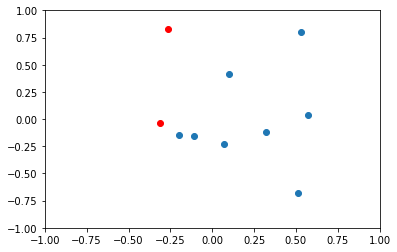

In [12]:
teacher_weights=teacher.state_dict()['linear_body.0.weight']
#print(teacher_weights)
teacher_weights=torch.transpose(teacher_weights,0,1)
#print(teacher_weights)
student_weights=student.state_dict()['linear_body.0.weight']
print(student_weights)
student_weights=torch.transpose(student_weights,0,1)
plt.scatter(teacher_weights[0],teacher_weights[1],color='red')
plt.scatter(student_weights[0], student_weights[1])
plt.xlim((-1,1))
plt.ylim((-1,1))

## Checking to be in the benign overfitting regime

In [2]:
widths=[25,50,100,200,400]
task="classification"

teacher_depth=2
teacher_width=8
trainset_size=1000
testset_size=10000
epochs=1

depth=2


input_dim=2
sample_size=trainset_size+testset_size
with torch.no_grad():
    teacher=utils_MNIST.fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
    inputs=torch.normal(0,1,(sample_size,round(input_dim)))
    if task=="classification":
        outputs=teacher(inputs)
        mean=torch.mean(outputs).item()
        std=torch.std(outputs).item()
        labels=outputs
        labels=labels-mean
        labels[labels<0]=0
        labels[labels>0]=1
        outputs=torch.squeeze(labels)
        #print(outputs)
    else:
        outputs=teacher(inputs)
        
train_set = utils_MNIST.CustomDataSet(inputs[:trainset_size], outputs[:trainset_size], input_dim)
test_set = utils_MNIST.CustomDataSet(inputs[trainset_size:], outputs[trainset_size:], input_dim)
trainloader=torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=0)
testloader=torch.utils.data.DataLoader(test_set, batch_size=len(test_set),shuffle=False, num_workers=0)
if task=='classification':
    criterion=nn.BCEWithLogitsLoss()
    #criterion=nn.BCELoss()
else:
    criterion=nn.MSELoss(reduction='mean')
    
learning_rate=5e-2


NameError: name 'batch_size' is not defined

In [3]:
outputs_dictionary=dict()
width_test_accs=[]
for W in widths:
    width_outputs=[]
    width_test_acc=0
    for i in range(3):
        student=utils_MNIST.fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
        optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
        #optimizer = optim.Adam(student.parameters(),lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-7)
        train_acc=0
        for epoch in range(epochs):
            if train_acc!=100:
                epoch+=1
                running_loss=0
                for i, data in enumerate(trainloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    #print(labels)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward + backward + optimize
                    outputs=student(inputs)
                    outputs = torch.squeeze(outputs)
                    #print(outputs)

                    #print(labels)
                    loss = criterion(outputs.to(torch.float32), labels.to(torch.float32))
                    loss.backward()
                    optimizer.step()
                    # print statistics
                    running_loss += loss.item()
                scheduler.step()
                if epoch%10==0:    
                    train_acc,train_loss,_=utils_MNIST.evaluate_on_dataset('teacher', trainloader, student, criterion)
                    test_acc,test_loss,_=utils_MNIST.evaluate_on_dataset('teacher', testloader, student, criterion)
                    #print(train_loss.item()/len(train_set),'    ', test_loss.item()/len(test_set))
                    print(f'Width {W}, epoch: {epoch}, train accuracy {train_acc}, test accuracy {test_acc}')
        train_acc,train_loss,_=utils_MNIST.evaluate_on_dataset('teacher', trainloader, student, criterion)
        test_acc,test_loss,test_outputs=utils_MNIST.evaluate_on_dataset('teacher', testloader, student, criterion)
        test_outputs=torch.sigmoid(test_outputs)
        width_test_acc+=test_acc
            
        #print(test_outputs)
        width_outputs.append(test_outputs)
    outputs_dictionary[W]=width_outputs
    width_test_accs.append(width_test_acc/3.)
        

NameError: name 'width' is not defined

In [33]:
accuracy_inf=0
list_of_outputs=outputs_dictionary[widths[-1]]
ensemble_outputs=torch.zeros(len(test_set))
for element in list_of_outputs:
    ensemble_outputs=ensemble_outputs+element
ensemble_outputs=ensemble_outputs/3

In [34]:
test_acc,test_loss,_=utils_MNIST.evaluate_on_dataset('teacher', testloader, student, nn.BCEWithLogitsLoss())

In [35]:
print(test_acc)

99.63


In [36]:
print(width_test_accs)

[99.52333333333333, 99.63333333333333, 99.60333333333334, 99.56333333333333, 99.60000000000001]
